## Camera Selection

In [2]:
import scipy.io as spio
#from __future__ import print_function

import numpy as np
import os

from IPython.display import clear_output
from IPython import display

import matplotlib.pyplot as plt
#import cv2 as cv
%matplotlib inline

In [3]:
import string
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.distributions import Categorical
import time, math
 
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

use_cuda = torch.cuda.is_available()

if use_cuda:
    print ('CUDA is available')
#use_cuda=False   #uncomment this if you dont want to use cuda variables

CUDA is available


In [4]:
import sys
import os
import gc
import collections
import hickle as hkl
import ttictoc as tt

sys.path.insert(0, '../data/')
import get_pid_train_test as db
import auxiliary as af

In [5]:
# sys.path.insert(0,'../py-MDNet/modules')
# from sample_generator import *


### For Validation

In [6]:
# Test function
def plot_current_state(ped, c,fno):
    # load image for current location
    img,bb = load_image(ped,c,fno,db_no)

    dpi = 80.0
    #figsize = (img.size[0]/dpi, img.size[1]/dpi)
    figsize = (img.shape[0]/dpi, img.shape[1]/dpi)
    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    # get image and rect handle
    imAX = ax.imshow(img, aspect='normal')
    rect = plt.Rectangle(tuple(bb[0,:2]),bb[0,2],bb[0,3], 
        linewidth=3, edgecolor="#ff0000", zorder=1, fill=False)
    ax.add_patch(rect)

    plt.pause(.01)
    plt.draw()
    #fig.savefig(os.path.join(savefig_dir,'0000.jpg'),dpi=dpi)
    
    return imAX, rect
    
def plot_second(ped,c,curr_frame, imAX,rect):
    img,bb =  load_image(ped,c,curr_frame,db_no)
    #if np.array(img).shape[0] > 0:
    if img != []:
        imAX.set_data(img)
    #print (bb)

    #if bb.shape[0] > 0:
    if bb != []:
        rect.set_xy(bb[0,:2])
        rect.set_width(bb[0,2])
        rect.set_height(bb[0,3])
        print ('Correct camera')
    elif c!= num_camera-1:
        print ('Wrong camera')

    
    display.display(plt.gcf())
    plt.pause(1)
    plt.draw()
    #fig.savefig(os.path.join(savefig_dir,'%04d.jpg'%(i)),dpi=dpi)

def get_reward_gt(ped, curr_frame, c):
    y = afc.find_target_camera(ped,curr_frame)
    # get reward (give reward at end of episode)
    if y == num_camera-1 and y == c:
        reward = 0
    elif y == c:
        reward = 1
    else:
        reward = -1
        
    return reward,y

def get_next_step(ped,c,curr_frame, state):
    # update current state and history
    ispresent,this_state = get_state_vector(ped, c,curr_frame)
    if ispresent:
        next_state = this_state
    else:
        # use previous state
        next_state = state
    
    # get correct label from ground truth
    reward,y = get_reward_gt(ped, curr_frame,c)

    return next_state,reward,y,ispresent

def test_func(pTest, iloc='first', eloc='last', fixLoc=-1, isdebug=0, req_inc=1):
    policy_net.eval()
    rsT,accT = [],[]
    Qvalues = []
    numTrAllP = []
    
    for p in range(pTest.shape[0]): 
        reward_sum = 0
        accP = []
        inc = 1
        aaa = 1
        Qval_1p= []
        numTr = 0
        
        # load p'th person data
        ped = np.copy(pTest[p])
        # camera index and frame index starts from zero
        ped[:,0] -= 1
        ped[:,1] -= 1
        
        # Initialize with current state with start frame
        if iloc == 'first':
            startIDX = 0
        elif iloc == 'rand':
            startIDX = np.random.randint( 0,ped.shape[0]-20 )
        elif iloc == 'fix':
            startIDX = fixLoc
        if startIDX > ped.shape[0]:
            continue
        myPos = ped[startIDX,0:]
        print ('Initial position: ',myPos)
        
        curr_camera = myPos[0]
        curr_frame = myPos[1]
        
        # Initialize history variable (one-hot encoding)
        ch = np.zeros((h_len,duke_cam))
        occ_len = 0.01
        # Make initial state
        x_t,c_t,te_tau,r_t = make_state_vector(ped, curr_camera,curr_frame,ch,occ_len)
        prev_rt = r_t[0:4]
        #print (state.size())
        num_steps = 0
        prev_camera = curr_camera
        count_curr_c = 0
        
        if render: # show current location
            plot_current_state(ped, curr_camera,curr_frame)

            display.clear_output(wait=True)
            display.display(plt.gcf())

        # select an action from the current state
        hidden, cell = enc(torch.from_numpy(ch).float().cuda().unsqueeze(1))
        #print (x_t.size(),h_t.size(),enc_history.size())
        state_xt = torch.cat([x_t, te_tau], dim=1)
        state = torch.cat([state_xt, hidden[1,].detach()], dim=1)
        
        
        while(curr_frame <= ped[-1,1]): # alltime-6):
            
            if use_cuda:
                state_in = Variable(state)
                value_c = policy_net(state_in)
            else:
                state_in = Variable(state)
                value_c = policy_net(state_in)
                
            # Only exploitation for testing
            camera_index = torch.argmax(value_c)
            c = camera_index.detach().cpu().numpy()
            
            occ_max_val = 12000000
            aaa += 1
            if aaa > 1 and occ_len > occ_max_val:
                c = c #np.array(num_camera-1)
            if occ_len > occ_max_val and aaa%50 == 0:
                aaa = 1
                c = np.array(np.random.randint(num_camera))

            # find target for the next frame
            curr_frame += fpsc
            num_steps += 1
            
            # get correct label from ground truth
            reward,y = get_reward_gt(ped, curr_frame,c)
            #if req_inc:
            if inc==1 and y!=num_camera-1:
                # inside a camera
                if req_inc:
                    accP.append((y,y))
                    c = y
                else:
                    accP.append((y,c.item(0)))
            elif inc==0 and y==c.item(0) and y!=num_camera-1:
                # transitioning to second camera
                accP.append((y,c.item(0)))
                inc = 1
                numTr += 1
            elif inc==1 and y==num_camera-1:
                # moving out of a camera FOV
                inc = 0
                accP.append((y,c.item(0)))
            else:
                # Making transition
                accP.append((y,c.item(0)))
                #print ('Another case',y,c.item(0))
                    
            #else:
            #    accP.append((y,c.item(0)))
            
            # get the current bounding box
            bbox = ped[ np.logical_and(ped[:,0]==c,ped[:,1]==curr_frame),2:]
            if bbox.shape[0] > 0: # and np.random.rand < 0.95:
                bbox = bbox[0]
                rt = np.zeros((8))
                rt[0] = bbox[0]/320 -(np.random.rand()-0.5)/100
                rt[1] = bbox[1]/240 -(np.random.rand()-0.5)/100
                rt[2] = bbox[2]/320 -(np.random.rand()-0.5)/100
                rt[3] = bbox[3]/240 -(np.random.rand()-0.5)/100
                rt[4] = rt[0] - prev_rt[0] if occ_len < 0.2 else 0
                rt[5] = rt[1] - prev_rt[1] if occ_len < 0.2 else 0
                rt[6] = rt[2] - prev_rt[2] if occ_len < 0.2 else 0
                rt[7] = rt[3] - prev_rt[3] if occ_len < 0.2 else 0
                curr_camera = c
                
                # make next_state vector
                this_cam = afc.make_one_hot_camera(curr_camera)
                x_t = np.concatenate((this_cam, rt.ravel()))
                x_t[x_t==0] = -10
                x_t[x_t==1] = 10
                x_t = x_t.reshape(1,-1)
                if use_cuda:
                    x_t = torch.from_numpy(x_t).float().cuda()
                
                
                ispresent = 1
                prev_rt = rt[0:4]
                    
            else:
                ispresent = 0
                
            # count the time of prev_camera selection
            if ispresent:
                occ_len = 0.01
            else:
                occ_len += 1
            #hcount = np.array(-occ_max_val + (occ_len/500)*(occ_max_val-(-occ_max_val)))
            hcount = np.array(10*np.log(occ_len))
            
            # update current state and history
            ch[1:,] = ch[0:-1,]
            ch[0,0:num_camera] = afc.make_one_hot_camera(c)
            ch[0,num_camera:] = 0
            this_cam = afc.make_one_hot_camera(c)
            c_t = this_cam.reshape(1,-1)
            
            if use_cuda:
                c_t = torch.from_numpy(c_t).float().cuda()
                te_tau = torch.from_numpy(hcount.reshape(1,-1)).float().cuda()
            else:
                c_t = torch.from_numpy(c_t).float()
                te_tau = torch.from_numpy(hcount.reshape(1,-1)).float()
                
            if isdebug:
                print ( np.where(rt.ravel()))
                print ( np.where(ch))
                print (c, curr_frame)
                print ('isPresent', ispresent)
                
            # make next_state vector
            hidden, cell = enc(torch.from_numpy(ch).float().cuda().unsqueeze(1))
            #print (x_t.size(),h_t.size(),enc_history.size())
            next_state_xt = torch.cat([x_t, te_tau], dim=1)
            next_state = torch.cat([next_state_xt, hidden[1,].detach()], dim=1)
            
            # store current reward
            reward_sum += reward
            Qval_1p.append((list(value_c.detach().cpu().numpy()[0]),hcount.ravel()[0],reward,False,y,c,state.detach().cpu().numpy()))
                        
            #state = next_state
            #state_xt = next_state_xt
            state = next_state #torch.cat([state_xt, enc_history], dim=1)
            prev_camera = c
            
            if render:
                plot_second()
            if eloc != 'last':
                if num_steps > eloc:
                    break
            
        # stack episodic reward 
        Qvalues.append((np.stack(Qval_1p)))
        rsT.append((reward_sum,num_steps))
        accT.append(accP)
        numTrAllP.append(numTr)
        
    return rsT, accT, Qvalues, numTrAllP


### Initialize hyper-parameters

In [7]:
learning_rate = 1e-4
batch_size = 1500
replay_memory_size = 20000
#epsilon = 0.1
gamma = 0.9

resume = False # resume from previous checkpoint?
render = False
eps = np.finfo(np.float32).eps.item()


In [8]:
# load dataset
db_no = 3
[pALL,num_camera,alltime,fps] = db.get_pid(set_no=db_no, train_flag='train')
num_camera += 1  # occlusion is also considered as a FOV
fpsc = 2
pALL = np.array(pALL)

# load test set for current data set
[pTest,num_camera,alltime,fps] = db.get_pid(set_no=db_no, train_flag='test')
num_camera += 1  # occlusion is also considered as a FOV
fpsc = 2
pTest = np.array(pTest)

Total number of person in data set:  (1, 14)
Total number of person in data set:  (1, 14)


In [9]:
numEpoch = 100000
d = 10
region_size = (d,d)

h_len = 10

# Load auxiliary functions using an object
afc = af.AuxiliaryFunction(num_camera=num_camera, d=d, h_len=h_len)

## Policy Model

In [10]:
# Initialize required parameters
lstm_size = 256
hidden_size1 = 4096
hidden_size2 = 2048
hidden_size3 = 256

input_size = lstm_size + num_camera+ 4*2 +1

# Required network
class NextCamera(nn.Module):
    def __init__(self):
        super(NextCamera, self).__init__()
        
        # make decoder layers
        self.fch1 = nn.Linear(input_size, hidden_size1)
        self.fch2 = nn.Linear(hidden_size1, hidden_size2)
        self.fch3 = nn.Linear(hidden_size2, hidden_size3)
        self.fco = nn.Linear(hidden_size3, num_camera)
        
        # Activation function 
        self.tanh = nn.Tanh() #ReLU()
        self.relu = nn.ReLU() #ReLU()
        #self.linear = nn.Linear() 
        
    def forward(self, x):
        
        x = self.relu(self.fch1(x))
        x = self.relu(self.fch2(x))
        x = self.relu(self.fch3(x))
        x = self.fco(x)
            
        return x # nn.functional.softmax(x)

In [11]:
# build the model
if use_cuda:
    policy_net = NextCamera().float().cuda()
    criterion = nn.MSELoss().cuda()
    
else:
    policy_net = NextCamera().float()
    criterion = nn.MSELoss()
    
if use_cuda:
    target_net = NextCamera().cuda()
    target_net.float().cuda()
target_net.load_state_dict(policy_net.state_dict())

# use ADAM as optimizer since we can load the whole data to train
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

In [12]:
def backward_network(replay_memory_pos,pos_prob, replay_memory_neg, replay_memory_cx, update_criteria):

    # sample random minibatch
    minibatch_pos = random.choices(replay_memory_pos, k=min(len(replay_memory_pos), 500), weights=pos_prob)
    #minibatch_pos = random.sample(replay_memory_pos, min(len(replay_memory_pos), 300)) #int(batch_size/3)))
    minibatch_posneg = minibatch_pos + random.sample(replay_memory_neg, min(len(replay_memory_neg), 500)) # int(batch_size/3)))
    minibatch = minibatch_posneg + random.sample(replay_memory_cx, min(len(replay_memory_cx), 500)) #int(batch_size/3)))
    
    # unpack minibatch
    #state_xt = tuple(d[0] for d in minibatch)
    state = torch.cat(tuple(d[0] for d in minibatch))
    #prev_ch = tuple(d[1] for d in minibatch)
    action = torch.cat(tuple(d[1] for d in minibatch))
    reward = torch.cat(tuple(d[2] for d in minibatch))
    #next_state_xt = tuple(d[4] for d in minibatch)
    next_state = torch.cat(tuple(d[3] for d in minibatch))
    #ch = tuple(d[5] for d in minibatch)
    
    # num samples of different categories
    numRew = torch.stack([torch.sum(reward>=0.2),torch.sum(reward==-1),torch.sum(reward==0.01)]).data.cpu().numpy()
    
    # get output for the next state
    next_output = target_net(next_state)

    # set y_j to r_j for terminal state, otherwise to r_j + gamma*max(Q)
    y = torch.cat(tuple(reward[i] if minibatch[i][4] \
                        else reward[i] + gamma * torch.max(next_output[i]) \
                        for i in range(len(minibatch))))

    # extract Q-value
    q_value = torch.sum(policy_net(state) * action, dim=1)

    # PyTorch accumulates gradients by default, so they need to be reset in each pass
    optimizer.zero_grad()

    # returns a new Tensor, detached from the current graph, the result will never require gradient
    y = y.detach()

    #print (y, q_value)
    # calculate loss
    loss = criterion(q_value, y)

    # do backward pass
    loss.backward()
    optimizer.step()

    # copy weights from policy_net to target_net
    if update_criteria == 10:
        target_net.load_state_dict(policy_net.state_dict())
        update_criteria = 0
    update_criteria += 1
    
    return loss.data,numRew,update_criteria

## AE Model

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = src #self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell
    
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size, dim]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size, dim]
        
        embedded = input #self.dropout(self.embedding(input))
        #embedded[np.arange(embedded.size),a] = 1
        
        #embedded = [1, batch size, emb dim]
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell
    
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.1):
        
        #src = [src len, batch size, dim]
        #trg = [trg len, batch size, dim]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output #.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

In [14]:
duke_cam = 9
INPUT_DIM = duke_cam
OUTPUT_DIM = duke_cam
ENC_EMB_DIM = duke_cam
DEC_EMB_DIM = duke_cam
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).float().cuda()
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).float().cuda()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Seq2Seq(enc, dec, device).float().to(device)
criterion_ae = nn.CrossEntropyLoss()

In [15]:
# load encoder model
#enc.load_state_dict(torch.load('enc-model_manyDB_state64.pt'))
#enc.load_state_dict(torch.load('enc-model_manyDB.pt'))
#enc.eval()
#dec.load_state_dict(torch.load('dec-model_manyDB_state64.pt'))
#dec.eval()
model.load_state_dict(torch.load('tut1-model_duke_lstmSize128_manyDB_2.pt'))
model.eval()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9, 9)
    (rnn): LSTM(9, 256, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5)
  )
  (decoder): Decoder(
    (embedding): Embedding(9, 9)
    (rnn): LSTM(9, 256, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=256, out_features=9, bias=True)
    (dropout): Dropout(p=0.5)
  )
)

In [16]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Run episodes

In [16]:
reward_sum = 0
running_reward = None
xs,rs,cprs = [],[],[]
episode_number = 0
episode_durations = []
episode_reward = []
validation_reward= []
replay_memory_pos = []
pos_prob = []
replay_memory_neg = []
replay_memory_cx = []
M = np.zeros((num_camera,num_camera))

In [17]:
def make_state_vector(ped, curr_camera,curr_frame, ch,occ_len):
    numSamples = 30
    overlap_thres = [0.9, 1]
        
    # read image
    img,bbox,p = afc.load_image(ped,curr_camera,curr_frame,db_no)
    imw, imh = (320,240) #img.size
    hc = np.array(10*np.log(occ_len))
    
    if p:
        rt = np.zeros((8))
        rt[0] = bbox[0]/imw -(np.random.rand()-0.5)/100
        rt[1] = bbox[1]/imh -(np.random.rand()-0.5)/100
        rt[2] = bbox[2]/imw -(np.random.rand()-0.5)/100
        rt[3] = bbox[3]/imh -(np.random.rand()-0.5)/100
        rt[4] = 0
        rt[5] = 0
        rt[6] = 0
        rt[7] = 0
        #print (np.where(rt.ravel()))
        
        # make next_state vector
        #this_cam = afc.make_one_hot_camera(curr_camera)
        #state = np.concatenate((this_cam, rt.ravel()))
        #state = np.concatenate((state, hc.ravel()))
        #state = np.concatenate((state, ch.ravel()))
        #state = state.reshape(1,-1)
        #state[state==0] = -10
        #state[state==1] = 10
        
        # make next_state vector
        this_cam = afc.make_one_hot_camera(curr_camera)
        xt = np.concatenate((this_cam, rt.ravel()))
        xt[xt==0] = -10
        xt[xt==1] = 10
        xt = xt.reshape(1,-1)
        
        # make history vector
        c_t = this_cam.reshape(1,-1)
        
        if use_cuda:
            xt = torch.from_numpy(xt).float().cuda()
            c_t = torch.from_numpy(c_t).float().cuda()
            hc = torch.from_numpy(hc.reshape(1,-1)).float().cuda()
        else:
            xt = torch.from_numpy(xt).float()
            c_t = torch.from_numpy(c_t).float()
            hc = torch.from_numpy(hc.reshape(1,-1)).float()
    else:
        print ('Target is not present in ',c,curr_frame)
        xt,h_t = [],[]
    
    return xt,c_t,hc,rt #p,state,rt

def append_reward(rs,num_steps):
    if len(rs) > 0:
        # stack episodic reward 
        epR = np.vstack(rs)
        rs = []

        # append the episodic reward
        #episode_number += 1
        #episode_durations.append(num_steps)
        reward_stat = [num_steps,np.std(epR),np.sum(epR)]
        episode_reward.append(reward_stat)
    
    return rs

def reinit_ae(ch):
    # Initialize history variable (one-hot encoding)
    if use_cuda:
        ch = torch.from_numpy(ch).float().cuda()
        enc_h = torch.zeros(1,lstm_size).float().cuda()
        enc_c = torch.zeros(1,lstm_size).float().cuda()
    else:
        enc_h = torch.zeros(1,lstm_size).float()
        enc_c = torch.zeros(1,lstm_size).float()
        
    # encode whole camera history
    for i in range(seq_len-1,-1,-1):
        #print (ch[i,:])
        x = ch[i,:].view(1,-1)
        h_lstm,enc = ae_enc((enc_h,enc_c), x)
        (enc_h,enc_c) = h_lstm

    return h_lstm,enc

In [18]:
epoch = 0
occ_max_val = 100

In [19]:
EpData = []
allEpData = []
numRew=[]

numUpdateRew=[]
update_criteria = 0
episode_count = 0
steps_count = 0
initialEpsilon = 0.2
finalEpsilon = 0.01
epsilon = initialEpsilon

In [20]:
trExplored = {}
for i in range(num_camera):
    for j in range(num_camera):
        trExplored[str(i)+'-'+str(j)] = []

In [21]:
resume = False
if resume:
    epoch = 600
    epsilon = 0.170962
    aaa = np.load('./EpData/.npy', allow_pickle=True)
    episode_count = aaa[2]
    steps_count = aaa[3]
    episode_reward_pre = aaa[0]
    validation_reward_pre = aaa[1]
    policy_net.load_state_dict(torch.load('./models/')['state_dict'])

In [22]:
tt.tic()

In [23]:
max_ep_len = 500
seq_len = 20
h_len = seq_len

while epoch < numEpoch:
#for epoch in range(numEpoch):
    # repeat for all pedestrians
    #disp(pALL)
    
    for p in range(pALL.shape[0]): #range(pInLoop.shape[0])
        
        policy_net.train()
        
        # load p'th person data
        ped = np.copy(pALL[p])

        # camera index and frame index starts from zero
        ped[:,0] -= 1
        ped[:,1] -= 1
        #print (np.unique(ped[:,0]))
        
        # check if camera number is correct
        if (ped[:,0] >= num_camera).any():
            print ('Error in person ', p)
            break
            
        if ped.shape[0] < max_ep_len/4:
            continue
        
        # select a camera uniformly
        uniq_cam = np.unique(ped[:,0])
        if len(uniq_cam) < 2 and np.random.rand() > 0.4:
            if len(np.where(ped[1:,1]-ped[0:-1,1] != 1)[0]) == 0:
                continue
        rand_cam = uniq_cam[np.random.randint(len(uniq_cam))]
        index_of_rand_cam = np.nonzero( ped[:,0]==rand_cam )[0]
        len_indices_rand_cam = len(index_of_rand_cam)
        
        # Initialize with current state with start frame
        tranIDX = np.where(ped[1:,0]-ped[0:-1,0])[0]
        if len(uniq_cam) < 2 or np.random.rand() < 0.4:
            startIDX = np.random.randint( 0,int(ped.shape[0]-ped.shape[0]/2) )
        else:
            startIDX = np.random.choice(tranIDX)-20
        #startIDX = np.random.choice(tranIDX)-20 if np.random.rand(1) < 0.6 else np.random.randint( 0,ped.shape[0]-max_ep_len/2 )
        #startIDX = index_of_rand_cam[np.random.randint(len_indices_rand_cam/10)]
        myPos = ped[startIDX,0:]
        #print (myPos)
        
        curr_camera = myPos[0]
        curr_frame = myPos[1]
        
        # Initialize history variable (one-hot encoding)
        ch = np.zeros((h_len,duke_cam))
        prev_ch = ch
        
        # initialize total time target was occluded
        num_steps = 0
        occ_len = 0.01
        hcount = np.array(10*np.log(occ_len))
        CDataEp = []
        inCDataEp = []
        EpData = []
        episodic_seq = []
        
        # create initial state (ct,rt,tau_t)
        #bbox = myPos[2:]
        #rt = afc.find_curr_rt(bbox)
        x_t,c_t,te_tau,r_t = make_state_vector(ped, curr_camera,curr_frame,ch,occ_len)
        prev_rt = r_t[0:4]
        stCam = curr_camera
        expStC = curr_camera
        count_curr_c = 0
        prev_camera = curr_camera

        if render: # show current location
            plt.imshow(x.reshape(input_size))
            display.clear_output(wait=True)
            display.display(plt.gcf())
        episode_count += 1
        if epsilon > finalEpsilon:
            epsilon -= (initialEpsilon - finalEpsilon)/30000
        
        # select an action from the current state
        hidden, cell = enc(torch.from_numpy(ch).float().cuda().unsqueeze(1))
        #print (x_t.size(),h_t.size(),enc_history.size())
        state_xt = torch.cat([x_t, te_tau], dim=1)
        #state = torch.cat([state_xt, hidden.detach().flatten().view(1,-1)], dim=1)
        state = torch.cat([state_xt, hidden[1,].detach()], dim=1)
        #print ('State size: ', state.size())
        
        while(curr_frame <= ped[-1,1]):
        
            state_in = Variable(state)
            value_c = policy_net(state_in)

            steps_count += 1
            
            # generate random steps
            if np.random.rand(1) < 0.01:
                rsteps = np.random.randint(fpsc,20,1)
            else:
                rsteps = 1
            curr_frame += rsteps*fpsc if rsteps > 1 else fpsc
            num_steps += 1
                
            # initialize action
            one_hot_action = torch.zeros([num_camera], dtype=torch.float32)
            if use_cuda:  # put on GPU if CUDA is available
                one_hot_action = one_hot_action.cuda()

            # epsilon greedy exploration
            random_action = np.random.random() <= epsilon
            camera_index = [torch.randint(num_camera, torch.Size([]), dtype=torch.int)
                           if random_action else torch.argmax(value_c)][0]
            
            if use_cuda:  # put on GPU if CUDA is available
                camera_index = camera_index.cuda()

            one_hot_action[camera_index] = 1
            one_hot_action = one_hot_action.unsqueeze(0)
            c = camera_index.detach().cpu().numpy()
            
            # Store the transition explored
            #M[stCam,c] += 1
            
            # get the current bounding box
            bbox = ped[ np.logical_and(ped[:,0]==c,ped[:,1]==curr_frame),2:]
            if bbox.shape[0] > 0:
                #rt = afc.find_curr_rt(bbox[0]) 
                bbox = bbox[0]
                rt = np.zeros((8))
                rt[0] = bbox[0]/320 -(np.random.rand()-0.5)/100
                rt[1] = bbox[1]/240 -(np.random.rand()-0.5)/100
                rt[2] = bbox[2]/320 -(np.random.rand()-0.5)/100
                rt[3] = bbox[3]/240 -(np.random.rand()-0.5)/100
                rt[4] = rt[0] - prev_rt[0] if occ_len < 0.2 else 0
                rt[5] = rt[1] - prev_rt[1] if occ_len < 0.2 else 0
                rt[6] = rt[2] - prev_rt[2] if occ_len < 0.2 else 0
                rt[7] = rt[3] - prev_rt[3] if occ_len < 0.2 else 0
                
                curr_camera = c
                # make next_state vector
                this_cam = afc.make_one_hot_camera(curr_camera)
                x_t = np.concatenate((this_cam, rt.ravel()))
                x_t[x_t==0] = -10
                x_t[x_t==1] = 10
                x_t = x_t.reshape(1,-1)
                if use_cuda:
                    x_t = torch.from_numpy(x_t).float().cuda()
                
                #num_steps = 0
                ispresent = 1
                stCam = c
                
                prev_rt = rt[0:4]
            else:
                ispresent = 0
            
            #if ispresent and expStC != num_camera-1 and c != num_camera-1:
            #    trExplored[str(expStC)+'-'+str(c)].append(occ_len)
            #    expStC = c
            
            # get correct label from ground truth
            y = afc.find_target_camera(ped, curr_frame)
            # get reward (give reward at end of episode)
            if y == num_camera-1 and y == c:
                reward = 0.01
            elif y == c and occ_len< 20:
                reward = 0.5
                wt = 1
            elif y == c:
                reward = 1
                wt = 10
            else:
                reward = -1
            reward_sum += reward
            rs.append(reward)
            EpData.append((list(value_c.detach().cpu().numpy()[0]),hcount.ravel()[0],reward,random_action,y,c,episode_reward))
            
            #print (np.array([rt, ispresent,c]))
            ######################## prepare the next state  #############################
            # count the time of prev_camera selection
            if ispresent:
                occ_len = 0.01
            else:
                occ_len += rsteps
            #hcount = np.array(-occ_max_val + (occ_len/500)*(occ_max_val-(-occ_max_val)))
            hcount = np.array(10*np.log(occ_len))
            
            # get next camera using policy network
            this_cam = afc.make_one_hot_camera(c)
            c_t = this_cam.reshape(1,-1)
            
            # update current state and history
            prev_ch = ch
            ch[1:,] = ch[0:-1,]
            ch[0,0:num_camera] = afc.make_one_hot_camera(c)
            ch[0,num_camera:] = 0
            
            #chCuda = torch.from_numpy(ch).float().cuda().unsqueeze(1)
            #outSeq = model(chCuda, chCuda)
            #print ('Encoding .. ', chCuda[:,0,].argmax(1))
            #print ('Decoded ..', outSeq[:,0].argmax(1))
            #print ('')
            
            if use_cuda:
                c_t = torch.from_numpy(c_t).float().cuda()
                te_tau = torch.from_numpy(hcount.reshape(1,-1)).float().cuda()
            else:
                c_t = torch.from_numpy(c_t).float()
                te_tau = torch.from_numpy(hcount.reshape(1,-1)).float()
            episodic_seq.append((c_t))
            
            # make next_state vector
            hidden, cell = enc(torch.from_numpy(ch).float().cuda().unsqueeze(1))
            #print (x_t.size(),h_t.size(),enc_history.size())
            next_state_xt = torch.cat([x_t, te_tau], dim=1)
            #next_state = torch.cat([next_state_xt, hidden.detach().flatten().view(1,-1)], dim=1)
            next_state = torch.cat([next_state_xt, hidden[1,].detach()], dim=1)
            
            if use_cuda:
                reward = torch.from_numpy(np.array([reward], dtype=np.float32)).unsqueeze(0).cuda()
            else:
                reward = torch.from_numpy(np.array([reward], dtype=np.float32)).unsqueeze(0)
            
            #replay_memory.append((state_xt,prev_ch, one_hot_action, reward, next_state_xt,ch, ispresent))
            
            # save transition to replay memory
            if reward > 0.2:
                #replay_memory_pos.append((state_xt,prev_ch, one_hot_action, reward, next_state_xt,ch, ispresent))
                replay_memory_pos.append((state, one_hot_action, reward, next_state, ispresent))
                pos_prob.append(wt)
            elif reward == 0.01:
                #replay_memory_cx.append((state_xt,prev_ch, one_hot_action, reward, next_state_xt,ch, ispresent))
                replay_memory_cx.append((state, one_hot_action, reward, next_state, ispresent))
            else:
                #replay_memory_neg.append((state_xt,prev_ch, one_hot_action, reward, next_state_xt,ch, ispresent))
                replay_memory_neg.append((state, one_hot_action, reward, next_state, ispresent))
            
            # if replay memory is full, remove the oldest transition
            if len(replay_memory_pos) > replay_memory_size:
                replay_memory_pos.pop(0)
                pos_prob.pop(0)
            if len(replay_memory_neg) > replay_memory_size:
                replay_memory_neg.pop(0)
            if len(replay_memory_cx) > replay_memory_size:
                replay_memory_cx.pop(0)
            
            #state_xt = next_state_xt
            state = next_state #torch.cat([state_xt, hidden.detach()], dim=1)
            #state = torch.cat([next_state_xt, enc_history], dim=1)
            prev_camera = c
            
            if num_steps >= max_ep_len and y!=num_camera-1 and y==c:  # break the episode
                #print ('')
                #print (epoch, p, random_action, rsteps)
                #print ('x_t: ', c,rt)
                ##print ( np.where(ch)[1])
                #print ('Q values: ', value_c)
                #print (y,c, curr_frame,ped[-1,1], num_steps, hcount)
                #print ('isPresent', ispresent)
                #print ('Pos Replay length: ', len(replay_memory_pos))
                
                #print (pos_prob[:])
                break
        
        # update value_function
        loss,rrr,update_criteria = backward_network(replay_memory_pos, pos_prob[:], replay_memory_neg,replay_memory_cx, update_criteria)
        numUpdateRew.append(rrr)
        if np.random.rand() < 0.05:
            allEpData.append((np.stack(EpData)))
        
        # store episodic reward
        #numRew.append((sum(np.stack(rs)==100),sum(np.stack(rs)==-100),sum(np.stack(rs)==0.1)))
        rs = append_reward(rs,num_steps)
        
        # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print ('ep %d: ep_len:%d episode reward: total was %f. running mean: %f' % (epoch, num_steps, reward_sum, running_reward))
        reward_sum = 0
        num_steps = 0
        rs = []
    
    if epoch % 20 == 0: # test on validation set
        _,accV,qv,numTR = test_func(pTest[1:2],iloc='first',eloc='last')
        av = np.stack(accV[0])
        av = sum(av[av[:,0]!=(num_camera-1),0] == av[av[:,0]!=(num_camera-1),1])/sum(av[:,0]!=(num_camera-1))
        validation_reward.append((qv,av,numTR)) 
    #print (M)
    epoch += 1
    print ('epsilon:%f episode_count: %d. steps_count: %f' % (epsilon, episode_count,steps_count))
    if epoch % 50 == 1: 
        torch.save({'state_dict': policy_net.state_dict()}, './models/policy_ECCV_db3_pretrDukeAE256_seq20_rp20K_'+str(epoch))
    #if epoch %200 == 100:
        #np.save('./EpData/allEpData_ECCV_db3_pretrAE64_seq20_rp20K_'+str(epoch),np.array(allEpData),allow_pickle=True)
        #np.save('./EpData/episode_reward_ECCV_db3_pretrAE64_seq20_rp20K_'+str(epoch), (episode_reward,validation_reward,epsilon,episode_count, steps_count,running_reward))
    allEpData = []
    print ('Time elapsed: ', tt.toc())

ep 0: ep_len:505 episode reward: total was -461.790000. running mean: -461.790000
ep 0: ep_len:513 episode reward: total was -283.400000. running mean: -460.006100
ep 0: ep_len:799 episode reward: total was -348.810000. running mean: -458.894139
ep 0: ep_len:138 episode reward: total was -68.940000. running mean: -454.994598
ep 0: ep_len:50 episode reward: total was -47.000000. running mean: -450.914652
ep 0: ep_len:703 episode reward: total was -156.410000. running mean: -447.969605
ep 0: ep_len:596 episode reward: total was -205.920000. running mean: -445.549109
Initial position:  [  2   0  17  87  63 149]
epsilon:0.199956 episode_count: 7. steps_count: 3304.000000
Time elapsed:  17.53948950767517
ep 1: ep_len:694 episode reward: total was -284.280000. running mean: -443.936418
ep 1: ep_len:500 episode reward: total was -305.430000. running mean: -442.551354
ep 1: ep_len:538 episode reward: total was -374.890000. running mean: -441.874740
ep 1: ep_len:773 episode reward: total was -5

ep 12: ep_len:79 episode reward: total was -20.310000. running mean: -309.250178
ep 12: ep_len:533 episode reward: total was -147.400000. running mean: -307.631676
ep 12: ep_len:3 episode reward: total was 0.000000. running mean: -304.555359
ep 12: ep_len:502 episode reward: total was -122.710000. running mean: -302.736906
ep 12: ep_len:585 episode reward: total was -172.310000. running mean: -301.432637
epsilon:0.199424 episode_count: 91. steps_count: 43506.000000
Time elapsed:  122.58621215820312
ep 13: ep_len:507 episode reward: total was -116.180000. running mean: -299.580110
ep 13: ep_len:201 episode reward: total was -96.500000. running mean: -297.549309
ep 13: ep_len:555 episode reward: total was -162.090000. running mean: -296.194716
ep 13: ep_len:627 episode reward: total was -143.240000. running mean: -294.665169
ep 13: ep_len:3 episode reward: total was 0.000000. running mean: -291.718517
ep 13: ep_len:224 episode reward: total was -37.990000. running mean: -289.181232
ep 13

ep 24: ep_len:108 episode reward: total was -15.330000. running mean: -199.032548
ep 24: ep_len:553 episode reward: total was -169.820000. running mean: -198.740423
ep 24: ep_len:500 episode reward: total was -140.520000. running mean: -198.158219
epsilon:0.198892 episode_count: 175. steps_count: 78624.000000
Time elapsed:  221.45384907722473
ep 25: ep_len:500 episode reward: total was -107.740000. running mean: -197.254037
ep 25: ep_len:500 episode reward: total was -147.150000. running mean: -196.752996
ep 25: ep_len:637 episode reward: total was -221.610000. running mean: -197.001566
ep 25: ep_len:532 episode reward: total was -122.070000. running mean: -196.252251
ep 25: ep_len:3 episode reward: total was 0.000000. running mean: -194.289728
ep 25: ep_len:511 episode reward: total was -238.350000. running mean: -194.730331
ep 25: ep_len:558 episode reward: total was -207.430000. running mean: -194.857327
epsilon:0.198847 episode_count: 182. steps_count: 81865.000000
Time elapsed:  2

ep 36: ep_len:630 episode reward: total was -177.320000. running mean: -153.329639
epsilon:0.198360 episode_count: 259. steps_count: 117451.000000
Time elapsed:  324.3915026187897
ep 37: ep_len:564 episode reward: total was -163.180000. running mean: -153.428142
ep 37: ep_len:594 episode reward: total was -126.600000. running mean: -153.159861
ep 37: ep_len:446 episode reward: total was -61.450000. running mean: -152.242762
ep 37: ep_len:500 episode reward: total was -117.800000. running mean: -151.898335
ep 37: ep_len:3 episode reward: total was 0.000000. running mean: -150.379351
ep 37: ep_len:531 episode reward: total was -155.970000. running mean: -150.435258
ep 37: ep_len:358 episode reward: total was -164.210000. running mean: -150.573005
epsilon:0.198315 episode_count: 266. steps_count: 120447.000000
Time elapsed:  332.3329703807831
ep 38: ep_len:500 episode reward: total was -83.130000. running mean: -149.898575
ep 38: ep_len:520 episode reward: total was -166.500000. running m

ep 49: ep_len:500 episode reward: total was -119.240000. running mean: -123.445706
ep 49: ep_len:500 episode reward: total was -34.850000. running mean: -122.559749
ep 49: ep_len:78 episode reward: total was -2.750000. running mean: -121.361652
ep 49: ep_len:547 episode reward: total was -74.330000. running mean: -120.891335
ep 49: ep_len:50 episode reward: total was 11.500000. running mean: -119.567422
ep 49: ep_len:615 episode reward: total was -73.450000. running mean: -119.106247
ep 49: ep_len:542 episode reward: total was -202.980000. running mean: -119.944985
epsilon:0.197783 episode_count: 350. steps_count: 156249.000000
Time elapsed:  432.555499792099
ep 50: ep_len:134 episode reward: total was -9.560000. running mean: -118.841135
ep 50: ep_len:514 episode reward: total was -136.010000. running mean: -119.012824
ep 50: ep_len:622 episode reward: total was -161.120000. running mean: -119.433896
ep 50: ep_len:500 episode reward: total was -146.900000. running mean: -119.708557
ep

ep 61: ep_len:501 episode reward: total was -75.820000. running mean: -104.738332
ep 61: ep_len:501 episode reward: total was -136.130000. running mean: -105.052249
ep 61: ep_len:3 episode reward: total was 0.000000. running mean: -104.001726
ep 61: ep_len:505 episode reward: total was -88.390000. running mean: -103.845609
ep 61: ep_len:508 episode reward: total was -104.750000. running mean: -103.854653
epsilon:0.197251 episode_count: 434. steps_count: 191848.000000
Time elapsed:  533.2734034061432
ep 62: ep_len:607 episode reward: total was -107.120000. running mean: -103.887306
ep 62: ep_len:671 episode reward: total was -112.450000. running mean: -103.972933
ep 62: ep_len:582 episode reward: total was -135.100000. running mean: -104.284204
ep 62: ep_len:543 episode reward: total was -61.970000. running mean: -103.861062
ep 62: ep_len:103 episode reward: total was -31.670000. running mean: -103.139151
ep 62: ep_len:582 episode reward: total was -101.210000. running mean: -103.119860

ep 73: ep_len:584 episode reward: total was -121.510000. running mean: -99.885428
ep 73: ep_len:197 episode reward: total was -55.650000. running mean: -99.443073
epsilon:0.196719 episode_count: 518. steps_count: 229808.000000
Time elapsed:  635.0445146560669
ep 74: ep_len:572 episode reward: total was -82.130000. running mean: -99.269943
ep 74: ep_len:500 episode reward: total was -78.280000. running mean: -99.060043
ep 74: ep_len:522 episode reward: total was -124.230000. running mean: -99.311743
ep 74: ep_len:504 episode reward: total was -47.330000. running mean: -98.791925
ep 74: ep_len:3 episode reward: total was -1.500000. running mean: -97.819006
ep 74: ep_len:518 episode reward: total was -132.220000. running mean: -98.163016
ep 74: ep_len:625 episode reward: total was -179.170000. running mean: -98.973086
epsilon:0.196675 episode_count: 525. steps_count: 233052.000000
Time elapsed:  643.7830729484558
ep 75: ep_len:525 episode reward: total was -75.280000. running mean: -98.73

ep 86: ep_len:593 episode reward: total was -129.380000. running mean: -95.971683
ep 86: ep_len:521 episode reward: total was -126.680000. running mean: -96.278766
ep 86: ep_len:529 episode reward: total was -154.360000. running mean: -96.859579
ep 86: ep_len:528 episode reward: total was -149.810000. running mean: -97.389083
ep 86: ep_len:3 episode reward: total was 0.000000. running mean: -96.415192
ep 86: ep_len:500 episode reward: total was -188.150000. running mean: -97.332540
ep 86: ep_len:608 episode reward: total was -124.290000. running mean: -97.602115
epsilon:0.196143 episode_count: 609. steps_count: 269879.000000
Time elapsed:  747.18630194664
ep 87: ep_len:620 episode reward: total was -123.220000. running mean: -97.858294
ep 87: ep_len:588 episode reward: total was -131.430000. running mean: -98.194011
ep 87: ep_len:571 episode reward: total was -91.960000. running mean: -98.131671
ep 87: ep_len:591 episode reward: total was -153.390000. running mean: -98.684254
ep 87: ep

ep 98: ep_len:542 episode reward: total was -159.640000. running mean: -95.046613
ep 98: ep_len:3 episode reward: total was -1.500000. running mean: -94.111147
ep 98: ep_len:611 episode reward: total was -133.710000. running mean: -94.507136
ep 98: ep_len:591 episode reward: total was -81.090000. running mean: -94.372964
epsilon:0.195611 episode_count: 693. steps_count: 308576.000000
Time elapsed:  850.8335959911346
ep 99: ep_len:642 episode reward: total was -114.740000. running mean: -94.576635
ep 99: ep_len:532 episode reward: total was -149.930000. running mean: -95.130168
ep 99: ep_len:500 episode reward: total was -135.310000. running mean: -95.531967
ep 99: ep_len:541 episode reward: total was -51.800000. running mean: -95.094647
ep 99: ep_len:96 episode reward: total was -10.800000. running mean: -94.251700
ep 99: ep_len:229 episode reward: total was -17.680000. running mean: -93.485983
ep 99: ep_len:501 episode reward: total was -94.160000. running mean: -93.492724
epsilon:0.1

ep 110: ep_len:512 episode reward: total was -94.890000. running mean: -95.201915
ep 110: ep_len:583 episode reward: total was -183.530000. running mean: -96.085196
epsilon:0.195079 episode_count: 777. steps_count: 346669.000000
Time elapsed:  957.3871779441833
ep 111: ep_len:220 episode reward: total was -60.690000. running mean: -95.731244
ep 111: ep_len:186 episode reward: total was -35.690000. running mean: -95.130832
ep 111: ep_len:552 episode reward: total was -98.370000. running mean: -95.163224
ep 111: ep_len:500 episode reward: total was -30.310000. running mean: -94.514691
ep 111: ep_len:100 episode reward: total was -33.180000. running mean: -93.901344
ep 111: ep_len:539 episode reward: total was -102.230000. running mean: -93.984631
ep 111: ep_len:580 episode reward: total was -111.450000. running mean: -94.159285
epsilon:0.195035 episode_count: 784. steps_count: 349346.000000
Time elapsed:  964.9386467933655
ep 112: ep_len:627 episode reward: total was -166.590000. running

ep 123: ep_len:593 episode reward: total was -61.400000. running mean: -88.365686
ep 123: ep_len:500 episode reward: total was -56.760000. running mean: -88.049629
ep 123: ep_len:500 episode reward: total was -115.750000. running mean: -88.326632
ep 123: ep_len:515 episode reward: total was -66.450000. running mean: -88.107866
ep 123: ep_len:3 episode reward: total was 0.000000. running mean: -87.226787
ep 123: ep_len:522 episode reward: total was -45.960000. running mean: -86.814120
ep 123: ep_len:578 episode reward: total was -121.560000. running mean: -87.161578
epsilon:0.194503 episode_count: 868. steps_count: 387980.000000
Time elapsed:  1073.7783229351044
ep 124: ep_len:643 episode reward: total was -105.030000. running mean: -87.340263
ep 124: ep_len:500 episode reward: total was -2.900000. running mean: -86.495860
ep 124: ep_len:544 episode reward: total was -70.090000. running mean: -86.331801
ep 124: ep_len:500 episode reward: total was -37.530000. running mean: -85.843783
ep

ep 135: ep_len:500 episode reward: total was -99.490000. running mean: -87.249586
ep 135: ep_len:621 episode reward: total was -47.730000. running mean: -86.854390
ep 135: ep_len:3 episode reward: total was 0.000000. running mean: -85.985846
ep 135: ep_len:657 episode reward: total was -153.480000. running mean: -86.660788
ep 135: ep_len:509 episode reward: total was -70.610000. running mean: -86.500280
epsilon:0.193971 episode_count: 952. steps_count: 425307.000000
Time elapsed:  1173.0627739429474
ep 136: ep_len:616 episode reward: total was -84.210000. running mean: -86.477377
ep 136: ep_len:500 episode reward: total was -57.030000. running mean: -86.182903
ep 136: ep_len:53 episode reward: total was -7.320000. running mean: -85.394274
ep 136: ep_len:500 episode reward: total was -46.590000. running mean: -85.006231
ep 136: ep_len:3 episode reward: total was 0.000000. running mean: -84.156169
ep 136: ep_len:500 episode reward: total was -197.000000. running mean: -85.284607
ep 136: 

ep 147: ep_len:78 episode reward: total was -25.310000. running mean: -91.378005
ep 147: ep_len:528 episode reward: total was -59.490000. running mean: -91.059125
ep 147: ep_len:568 episode reward: total was -68.080000. running mean: -90.829334
epsilon:0.193439 episode_count: 1036. steps_count: 462618.000000
Time elapsed:  1291.506807088852
ep 148: ep_len:186 episode reward: total was -28.030000. running mean: -90.201341
ep 148: ep_len:525 episode reward: total was -99.960000. running mean: -90.298927
ep 148: ep_len:501 episode reward: total was -131.390000. running mean: -90.709838
ep 148: ep_len:500 episode reward: total was -141.970000. running mean: -91.222440
ep 148: ep_len:104 episode reward: total was -63.320000. running mean: -90.943415
ep 148: ep_len:667 episode reward: total was -137.990000. running mean: -91.413881
ep 148: ep_len:285 episode reward: total was -96.880000. running mean: -91.468542
epsilon:0.193394 episode_count: 1043. steps_count: 465386.000000
Time elapsed:  

ep 159: ep_len:547 episode reward: total was -138.610000. running mean: -82.883250
epsilon:0.192907 episode_count: 1120. steps_count: 498161.000000
Time elapsed:  1390.4031128883362
ep 160: ep_len:548 episode reward: total was -94.640000. running mean: -83.000818
ep 160: ep_len:564 episode reward: total was -92.560000. running mean: -83.096409
ep 160: ep_len:558 episode reward: total was -60.970000. running mean: -82.875145
ep 160: ep_len:522 episode reward: total was -80.490000. running mean: -82.851294
ep 160: ep_len:3 episode reward: total was 0.000000. running mean: -82.022781
ep 160: ep_len:517 episode reward: total was -138.230000. running mean: -82.584853
ep 160: ep_len:571 episode reward: total was -86.580000. running mean: -82.624805
Initial position:  [  2   0  17  87  63 149]
epsilon:0.192862 episode_count: 1127. steps_count: 501444.000000
Time elapsed:  1404.2207815647125
ep 161: ep_len:580 episode reward: total was -120.240000. running mean: -83.000956
ep 161: ep_len:586 e

ep 172: ep_len:197 episode reward: total was -17.480000. running mean: -85.108016
ep 172: ep_len:506 episode reward: total was -151.010000. running mean: -85.767036
ep 172: ep_len:667 episode reward: total was -130.920000. running mean: -86.218566
ep 172: ep_len:500 episode reward: total was -132.570000. running mean: -86.682080
ep 172: ep_len:3 episode reward: total was -1.500000. running mean: -85.830260
ep 172: ep_len:555 episode reward: total was -58.930000. running mean: -85.561257
ep 172: ep_len:605 episode reward: total was -80.100000. running mean: -85.506644
epsilon:0.192330 episode_count: 1211. steps_count: 538410.000000
Time elapsed:  1502.9579544067383
ep 173: ep_len:662 episode reward: total was -122.860000. running mean: -85.880178
ep 173: ep_len:542 episode reward: total was -73.710000. running mean: -85.758476
ep 173: ep_len:558 episode reward: total was -112.120000. running mean: -86.022091
ep 173: ep_len:501 episode reward: total was -23.560000. running mean: -85.3974

ep 184: ep_len:513 episode reward: total was -95.330000. running mean: -85.248345
ep 184: ep_len:399 episode reward: total was -25.450000. running mean: -84.650362
ep 184: ep_len:378 episode reward: total was -53.830000. running mean: -84.342158
ep 184: ep_len:3 episode reward: total was 0.000000. running mean: -83.498737
ep 184: ep_len:501 episode reward: total was -102.370000. running mean: -83.687449
ep 184: ep_len:598 episode reward: total was -122.560000. running mean: -84.076175
epsilon:0.191798 episode_count: 1295. steps_count: 574392.000000
Time elapsed:  1606.0006494522095
ep 185: ep_len:129 episode reward: total was -13.160000. running mean: -83.367013
ep 185: ep_len:184 episode reward: total was -52.150000. running mean: -83.054843
ep 185: ep_len:647 episode reward: total was -163.370000. running mean: -83.857995
ep 185: ep_len:501 episode reward: total was -37.020000. running mean: -83.389615
ep 185: ep_len:110 episode reward: total was 2.290000. running mean: -82.532818
ep

ep 196: ep_len:527 episode reward: total was -112.520000. running mean: -82.790197
ep 196: ep_len:3 episode reward: total was -1.500000. running mean: -81.977295
ep 196: ep_len:500 episode reward: total was -82.290000. running mean: -81.980422
ep 196: ep_len:500 episode reward: total was -79.700000. running mean: -81.957618
epsilon:0.191266 episode_count: 1379. steps_count: 611113.000000
Time elapsed:  1704.787085533142
ep 197: ep_len:542 episode reward: total was -69.130000. running mean: -81.829342
ep 197: ep_len:617 episode reward: total was -122.390000. running mean: -82.234948
ep 197: ep_len:507 episode reward: total was -29.080000. running mean: -81.703399
ep 197: ep_len:500 episode reward: total was -72.100000. running mean: -81.607365
ep 197: ep_len:3 episode reward: total was 0.000000. running mean: -80.791291
ep 197: ep_len:500 episode reward: total was -98.710000. running mean: -80.970478
ep 197: ep_len:326 episode reward: total was -90.970000. running mean: -81.070473
epsil

ep 208: ep_len:500 episode reward: total was -51.100000. running mean: -77.749141
ep 208: ep_len:540 episode reward: total was -105.650000. running mean: -78.028149
epsilon:0.190734 episode_count: 1463. steps_count: 646488.000000
Time elapsed:  1805.9149515628815
ep 209: ep_len:594 episode reward: total was -92.000000. running mean: -78.167868
ep 209: ep_len:279 episode reward: total was -73.030000. running mean: -78.116489
ep 209: ep_len:687 episode reward: total was -137.630000. running mean: -78.711624
ep 209: ep_len:363 episode reward: total was -110.530000. running mean: -79.029808
ep 209: ep_len:3 episode reward: total was 0.000000. running mean: -78.239510
ep 209: ep_len:539 episode reward: total was -102.510000. running mean: -78.482215
ep 209: ep_len:516 episode reward: total was -80.520000. running mean: -78.502593
epsilon:0.190690 episode_count: 1470. steps_count: 649469.000000
Time elapsed:  1813.774399280548
ep 210: ep_len:228 episode reward: total was -23.260000. running 

epsilon:0.190202 episode_count: 1547. steps_count: 685064.000000
Time elapsed:  1912.6756377220154
ep 221: ep_len:257 episode reward: total was -13.900000. running mean: -81.135654
ep 221: ep_len:596 episode reward: total was -12.950000. running mean: -80.453797
ep 221: ep_len:500 episode reward: total was -95.360000. running mean: -80.602859
ep 221: ep_len:501 episode reward: total was -26.720000. running mean: -80.064031
ep 221: ep_len:121 episode reward: total was -59.220000. running mean: -79.855590
ep 221: ep_len:624 episode reward: total was -131.570000. running mean: -80.372734
ep 221: ep_len:315 episode reward: total was -78.720000. running mean: -80.356207
epsilon:0.190158 episode_count: 1554. steps_count: 687978.000000
Time elapsed:  1920.362148284912
ep 222: ep_len:586 episode reward: total was -123.630000. running mean: -80.788945
ep 222: ep_len:501 episode reward: total was -8.250000. running mean: -80.063555
ep 222: ep_len:555 episode reward: total was -85.910000. running

ep 233: ep_len:546 episode reward: total was -105.710000. running mean: -81.292379
ep 233: ep_len:568 episode reward: total was -146.870000. running mean: -81.948155
ep 233: ep_len:500 episode reward: total was -36.150000. running mean: -81.490174
ep 233: ep_len:82 episode reward: total was -40.760000. running mean: -81.082872
ep 233: ep_len:186 episode reward: total was -28.040000. running mean: -80.552443
ep 233: ep_len:210 episode reward: total was -53.720000. running mean: -80.284119
epsilon:0.189626 episode_count: 1638. steps_count: 724841.000000
Time elapsed:  2019.456460237503
ep 234: ep_len:558 episode reward: total was -37.130000. running mean: -79.852577
ep 234: ep_len:577 episode reward: total was -150.810000. running mean: -80.562152
ep 234: ep_len:506 episode reward: total was -99.890000. running mean: -80.755430
ep 234: ep_len:500 episode reward: total was 12.830000. running mean: -79.819576
ep 234: ep_len:3 episode reward: total was -1.500000. running mean: -79.036380
ep

ep 245: ep_len:629 episode reward: total was -117.230000. running mean: -82.883786
ep 245: ep_len:169 episode reward: total was 2.070000. running mean: -82.034248
ep 245: ep_len:3 episode reward: total was 0.000000. running mean: -81.213905
ep 245: ep_len:590 episode reward: total was -178.110000. running mean: -82.182866
ep 245: ep_len:573 episode reward: total was -152.520000. running mean: -82.886238
epsilon:0.189094 episode_count: 1722. steps_count: 762897.000000
Time elapsed:  2126.3503546714783
ep 246: ep_len:537 episode reward: total was -83.460000. running mean: -82.891975
ep 246: ep_len:181 episode reward: total was -56.940000. running mean: -82.632455
ep 246: ep_len:545 episode reward: total was -76.860000. running mean: -82.574731
ep 246: ep_len:510 episode reward: total was -67.570000. running mean: -82.424684
ep 246: ep_len:94 episode reward: total was -30.290000. running mean: -81.903337
ep 246: ep_len:535 episode reward: total was -56.580000. running mean: -81.650103
ep 

ep 257: ep_len:98 episode reward: total was -3.800000. running mean: -77.471132
ep 257: ep_len:172 episode reward: total was 6.100000. running mean: -76.635421
ep 257: ep_len:196 episode reward: total was -59.740000. running mean: -76.466467
epsilon:0.188562 episode_count: 1806. steps_count: 799274.000000
Time elapsed:  2234.018864631653
ep 258: ep_len:593 episode reward: total was -91.750000. running mean: -76.619302
ep 258: ep_len:537 episode reward: total was -110.860000. running mean: -76.961709
ep 258: ep_len:461 episode reward: total was -2.930000. running mean: -76.221392
ep 258: ep_len:539 episode reward: total was -29.420000. running mean: -75.753378
ep 258: ep_len:3 episode reward: total was 0.000000. running mean: -74.995844
ep 258: ep_len:573 episode reward: total was -96.410000. running mean: -75.209986
ep 258: ep_len:588 episode reward: total was -140.110000. running mean: -75.858986
epsilon:0.188518 episode_count: 1813. steps_count: 802568.000000
Time elapsed:  2244.2923

ep 269: ep_len:633 episode reward: total was -83.290000. running mean: -80.026370
ep 269: ep_len:299 episode reward: total was -52.870000. running mean: -79.754806
epsilon:0.188030 episode_count: 1890. steps_count: 838087.000000
Time elapsed:  2357.9006803035736
ep 270: ep_len:546 episode reward: total was -132.980000. running mean: -80.287058
ep 270: ep_len:528 episode reward: total was -61.270000. running mean: -80.096888
ep 270: ep_len:569 episode reward: total was -79.350000. running mean: -80.089419
ep 270: ep_len:131 episode reward: total was -2.980000. running mean: -79.318325
ep 270: ep_len:3 episode reward: total was -1.500000. running mean: -78.540141
ep 270: ep_len:222 episode reward: total was -13.220000. running mean: -77.886940
ep 270: ep_len:560 episode reward: total was -113.470000. running mean: -78.242771
epsilon:0.187986 episode_count: 1897. steps_count: 840646.000000
Time elapsed:  2365.9332976341248
ep 271: ep_len:658 episode reward: total was -189.910000. running 

ep 282: ep_len:229 episode reward: total was -31.780000. running mean: -72.464455
ep 282: ep_len:523 episode reward: total was -113.360000. running mean: -72.873410
ep 282: ep_len:545 episode reward: total was -68.720000. running mean: -72.831876
ep 282: ep_len:44 episode reward: total was -0.740000. running mean: -72.110958
ep 282: ep_len:3 episode reward: total was 0.000000. running mean: -71.389848
ep 282: ep_len:500 episode reward: total was -105.920000. running mean: -71.735150
ep 282: ep_len:529 episode reward: total was -74.280000. running mean: -71.760598
epsilon:0.187454 episode_count: 1981. steps_count: 877270.000000
Time elapsed:  2482.735431909561
ep 283: ep_len:133 episode reward: total was -10.090000. running mean: -71.143892
ep 283: ep_len:500 episode reward: total was -0.590000. running mean: -70.438353
ep 283: ep_len:528 episode reward: total was -105.590000. running mean: -70.789870
ep 283: ep_len:546 episode reward: total was -60.840000. running mean: -70.690371
ep 2

ep 294: ep_len:645 episode reward: total was -116.230000. running mean: -71.630191
ep 294: ep_len:500 episode reward: total was 4.990000. running mean: -70.863989
ep 294: ep_len:81 episode reward: total was -5.320000. running mean: -70.208549
ep 294: ep_len:186 episode reward: total was 1.070000. running mean: -69.495764
ep 294: ep_len:571 episode reward: total was -74.760000. running mean: -69.548406
epsilon:0.186922 episode_count: 2065. steps_count: 914283.000000
Time elapsed:  2584.4651148319244
ep 295: ep_len:500 episode reward: total was -26.410000. running mean: -69.117022
ep 295: ep_len:551 episode reward: total was -54.060000. running mean: -68.966452
ep 295: ep_len:562 episode reward: total was -118.870000. running mean: -69.465487
ep 295: ep_len:534 episode reward: total was -76.070000. running mean: -69.531532
ep 295: ep_len:3 episode reward: total was 0.000000. running mean: -68.836217
ep 295: ep_len:500 episode reward: total was -124.130000. running mean: -69.389155
ep 295

ep 306: ep_len:587 episode reward: total was -75.110000. running mean: -72.523606
ep 306: ep_len:345 episode reward: total was -57.930000. running mean: -72.377670
epsilon:0.186390 episode_count: 2149. steps_count: 951445.000000
Time elapsed:  2690.1317224502563
ep 307: ep_len:604 episode reward: total was -95.780000. running mean: -72.611693
ep 307: ep_len:500 episode reward: total was -31.830000. running mean: -72.203876
ep 307: ep_len:501 episode reward: total was -77.780000. running mean: -72.259637
ep 307: ep_len:151 episode reward: total was -9.460000. running mean: -71.631641
ep 307: ep_len:112 episode reward: total was -14.800000. running mean: -71.063324
ep 307: ep_len:530 episode reward: total was -126.140000. running mean: -71.614091
ep 307: ep_len:511 episode reward: total was -103.050000. running mean: -71.928450
epsilon:0.186345 episode_count: 2156. steps_count: 954354.000000
Time elapsed:  2698.3663482666016
ep 308: ep_len:223 episode reward: total was -27.350000. runnin

ep 319: ep_len:667 episode reward: total was -85.170000. running mean: -70.720833
ep 319: ep_len:636 episode reward: total was -110.080000. running mean: -71.114425
ep 319: ep_len:592 episode reward: total was -98.700000. running mean: -71.390280
ep 319: ep_len:500 episode reward: total was -47.000000. running mean: -71.146377
ep 319: ep_len:3 episode reward: total was 0.000000. running mean: -70.434914
ep 319: ep_len:500 episode reward: total was -57.750000. running mean: -70.308065
ep 319: ep_len:547 episode reward: total was -82.120000. running mean: -70.426184
epsilon:0.185813 episode_count: 2240. steps_count: 990215.000000
Time elapsed:  2793.6050260066986
ep 320: ep_len:265 episode reward: total was -30.800000. running mean: -70.029922
ep 320: ep_len:500 episode reward: total was -55.310000. running mean: -69.882723
ep 320: ep_len:384 episode reward: total was -55.560000. running mean: -69.739496
ep 320: ep_len:588 episode reward: total was -35.680000. running mean: -69.398901
ep

ep 331: ep_len:533 episode reward: total was -159.470000. running mean: -67.027717
ep 331: ep_len:500 episode reward: total was -45.330000. running mean: -66.810740
ep 331: ep_len:3 episode reward: total was 0.000000. running mean: -66.142632
ep 331: ep_len:598 episode reward: total was -96.530000. running mean: -66.446506
ep 331: ep_len:500 episode reward: total was -50.610000. running mean: -66.288141
epsilon:0.185281 episode_count: 2324. steps_count: 1026356.000000
Time elapsed:  2895.605192899704
ep 332: ep_len:194 episode reward: total was -0.860000. running mean: -65.633859
ep 332: ep_len:549 episode reward: total was -110.620000. running mean: -66.083721
ep 332: ep_len:405 episode reward: total was -93.600000. running mean: -66.358884
ep 332: ep_len:589 episode reward: total was -36.640000. running mean: -66.061695
ep 332: ep_len:3 episode reward: total was 0.000000. running mean: -65.401078
ep 332: ep_len:502 episode reward: total was -118.230000. running mean: -65.929367
ep 33

ep 343: ep_len:101 episode reward: total was -15.740000. running mean: -66.821591
ep 343: ep_len:670 episode reward: total was -98.690000. running mean: -67.140275
ep 343: ep_len:516 episode reward: total was -64.160000. running mean: -67.110473
epsilon:0.184749 episode_count: 2408. steps_count: 1062335.000000
Time elapsed:  2998.336267232895
ep 344: ep_len:551 episode reward: total was -91.430000. running mean: -67.353668
ep 344: ep_len:642 episode reward: total was -13.160000. running mean: -66.811731
ep 344: ep_len:422 episode reward: total was -39.780000. running mean: -66.541414
ep 344: ep_len:500 episode reward: total was -55.840000. running mean: -66.434400
ep 344: ep_len:3 episode reward: total was 0.000000. running mean: -65.770056
ep 344: ep_len:575 episode reward: total was -69.810000. running mean: -65.810455
ep 344: ep_len:536 episode reward: total was -84.790000. running mean: -66.000251
epsilon:0.184705 episode_count: 2415. steps_count: 1065564.000000
Time elapsed:  3007

ep 355: ep_len:563 episode reward: total was -66.630000. running mean: -62.970717
epsilon:0.184217 episode_count: 2492. steps_count: 1100789.000000
Time elapsed:  3101.79647231102
ep 356: ep_len:577 episode reward: total was -83.420000. running mean: -63.175210
ep 356: ep_len:500 episode reward: total was 28.960000. running mean: -62.253858
ep 356: ep_len:592 episode reward: total was -108.930000. running mean: -62.720619
ep 356: ep_len:513 episode reward: total was -98.390000. running mean: -63.077313
ep 356: ep_len:94 episode reward: total was 11.740000. running mean: -62.329140
ep 356: ep_len:533 episode reward: total was -101.680000. running mean: -62.722648
ep 356: ep_len:639 episode reward: total was -125.390000. running mean: -63.349322
epsilon:0.184173 episode_count: 2499. steps_count: 1104237.000000
Time elapsed:  3110.7901685237885
ep 357: ep_len:535 episode reward: total was -116.140000. running mean: -63.877229
ep 357: ep_len:500 episode reward: total was -71.640000. runnin

ep 368: ep_len:553 episode reward: total was -103.190000. running mean: -63.387665
ep 368: ep_len:152 episode reward: total was -35.590000. running mean: -63.109689
ep 368: ep_len:633 episode reward: total was -87.440000. running mean: -63.352992
ep 368: ep_len:501 episode reward: total was -81.630000. running mean: -63.535762
ep 368: ep_len:94 episode reward: total was -61.770000. running mean: -63.518104
ep 368: ep_len:527 episode reward: total was -26.640000. running mean: -63.149323
ep 368: ep_len:332 episode reward: total was -108.740000. running mean: -63.605230
epsilon:0.183641 episode_count: 2583. steps_count: 1139441.000000
Time elapsed:  3210.8054492473602
ep 369: ep_len:587 episode reward: total was -93.620000. running mean: -63.905378
ep 369: ep_len:504 episode reward: total was -56.700000. running mean: -63.833324
ep 369: ep_len:79 episode reward: total was -9.780000. running mean: -63.292791
ep 369: ep_len:518 episode reward: total was -35.880000. running mean: -63.018663

ep 380: ep_len:607 episode reward: total was -134.500000. running mean: -70.077513
ep 380: ep_len:500 episode reward: total was -101.010000. running mean: -70.386838
ep 380: ep_len:92 episode reward: total was -12.310000. running mean: -69.806069
ep 380: ep_len:577 episode reward: total was -123.000000. running mean: -70.338008
ep 380: ep_len:542 episode reward: total was -94.050000. running mean: -70.575128
Initial position:  [  2   0  17  87  63 149]
epsilon:0.183109 episode_count: 2667. steps_count: 1176544.000000
Time elapsed:  3315.8482007980347
ep 381: ep_len:535 episode reward: total was -29.620000. running mean: -70.165577
ep 381: ep_len:500 episode reward: total was -58.440000. running mean: -70.048321
ep 381: ep_len:524 episode reward: total was -72.480000. running mean: -70.072638
ep 381: ep_len:561 episode reward: total was -40.970000. running mean: -69.781612
ep 381: ep_len:92 episode reward: total was -7.260000. running mean: -69.156396
ep 381: ep_len:638 episode reward: 

ep 392: ep_len:542 episode reward: total was -66.370000. running mean: -67.492990
ep 392: ep_len:567 episode reward: total was -74.310000. running mean: -67.561160
epsilon:0.182577 episode_count: 2751. steps_count: 1212576.000000
Time elapsed:  3412.730614900589
ep 393: ep_len:573 episode reward: total was -85.940000. running mean: -67.744949
ep 393: ep_len:341 episode reward: total was -71.590000. running mean: -67.783399
ep 393: ep_len:570 episode reward: total was -79.670000. running mean: -67.902265
ep 393: ep_len:625 episode reward: total was -28.470000. running mean: -67.507943
ep 393: ep_len:3 episode reward: total was 0.000000. running mean: -66.832863
ep 393: ep_len:631 episode reward: total was -82.350000. running mean: -66.988035
ep 393: ep_len:500 episode reward: total was -76.730000. running mean: -67.085454
epsilon:0.182533 episode_count: 2758. steps_count: 1215819.000000
Time elapsed:  3421.5491814613342
ep 394: ep_len:580 episode reward: total was -130.410000. running m

ep 405: ep_len:242 episode reward: total was -20.790000. running mean: -65.764575
ep 405: ep_len:560 episode reward: total was -158.490000. running mean: -66.691829
ep 405: ep_len:528 episode reward: total was -95.160000. running mean: -66.976511
ep 405: ep_len:500 episode reward: total was -76.820000. running mean: -67.074946
ep 405: ep_len:3 episode reward: total was -1.500000. running mean: -66.419197
ep 405: ep_len:635 episode reward: total was -114.730000. running mean: -66.902305
ep 405: ep_len:527 episode reward: total was -95.490000. running mean: -67.188182
epsilon:0.182001 episode_count: 2842. steps_count: 1254189.000000
Time elapsed:  3533.7007410526276
ep 406: ep_len:122 episode reward: total was -1.630000. running mean: -66.532600
ep 406: ep_len:294 episode reward: total was -58.610000. running mean: -66.453374
ep 406: ep_len:500 episode reward: total was -94.660000. running mean: -66.735440
ep 406: ep_len:166 episode reward: total was -11.900000. running mean: -66.187086


ep 417: ep_len:554 episode reward: total was -110.470000. running mean: -64.921367
ep 417: ep_len:502 episode reward: total was -63.020000. running mean: -64.902353
ep 417: ep_len:38 episode reward: total was 11.500000. running mean: -64.138330
ep 417: ep_len:525 episode reward: total was -100.850000. running mean: -64.505446
ep 417: ep_len:555 episode reward: total was -142.460000. running mean: -65.284992
epsilon:0.181469 episode_count: 2926. steps_count: 1291121.000000
Time elapsed:  3645.7705500125885
ep 418: ep_len:615 episode reward: total was -92.550000. running mean: -65.557642
ep 418: ep_len:609 episode reward: total was -139.680000. running mean: -66.298865
ep 418: ep_len:838 episode reward: total was -349.890000. running mean: -69.134777
ep 418: ep_len:500 episode reward: total was -58.870000. running mean: -69.032129
ep 418: ep_len:111 episode reward: total was -28.800000. running mean: -68.629808
ep 418: ep_len:651 episode reward: total was -100.870000. running mean: -68.9

ep 429: ep_len:53 episode reward: total was 1.000000. running mean: -67.302568
ep 429: ep_len:641 episode reward: total was -88.240000. running mean: -67.511942
ep 429: ep_len:513 episode reward: total was -102.580000. running mean: -67.862623
epsilon:0.180937 episode_count: 3010. steps_count: 1328889.000000
Time elapsed:  3767.2986800670624
ep 430: ep_len:525 episode reward: total was -30.070000. running mean: -67.484697
ep 430: ep_len:511 episode reward: total was -106.510000. running mean: -67.874950
ep 430: ep_len:605 episode reward: total was -118.750000. running mean: -68.383700
ep 430: ep_len:128 episode reward: total was 7.530000. running mean: -67.624563
ep 430: ep_len:3 episode reward: total was -1.500000. running mean: -66.963318
ep 430: ep_len:500 episode reward: total was -114.050000. running mean: -67.434185
ep 430: ep_len:338 episode reward: total was -75.010000. running mean: -67.509943
epsilon:0.180892 episode_count: 3017. steps_count: 1331499.000000
Time elapsed:  377

ep 441: ep_len:543 episode reward: total was -77.810000. running mean: -65.068705
epsilon:0.180405 episode_count: 3094. steps_count: 1363028.000000
Time elapsed:  3874.1084372997284
ep 442: ep_len:501 episode reward: total was -17.210000. running mean: -64.590118
ep 442: ep_len:500 episode reward: total was -126.480000. running mean: -65.209017
ep 442: ep_len:546 episode reward: total was -75.580000. running mean: -65.312726
ep 442: ep_len:522 episode reward: total was -87.560000. running mean: -65.535199
ep 442: ep_len:3 episode reward: total was 0.000000. running mean: -64.879847
ep 442: ep_len:521 episode reward: total was -92.530000. running mean: -65.156349
ep 442: ep_len:582 episode reward: total was -62.830000. running mean: -65.133085
epsilon:0.180360 episode_count: 3101. steps_count: 1366203.000000
Time elapsed:  3882.4538114070892
ep 443: ep_len:550 episode reward: total was -85.350000. running mean: -65.335254
ep 443: ep_len:526 episode reward: total was -81.560000. running 

ep 454: ep_len:510 episode reward: total was -69.980000. running mean: -66.866647
ep 454: ep_len:334 episode reward: total was -97.040000. running mean: -67.168381
ep 454: ep_len:581 episode reward: total was -80.840000. running mean: -67.305097
ep 454: ep_len:594 episode reward: total was -133.690000. running mean: -67.968946
ep 454: ep_len:3 episode reward: total was 1.010000. running mean: -67.279157
ep 454: ep_len:603 episode reward: total was -83.620000. running mean: -67.442565
ep 454: ep_len:203 episode reward: total was -69.740000. running mean: -67.465539
epsilon:0.179828 episode_count: 3185. steps_count: 1404087.000000
Time elapsed:  3984.5649330615997
ep 455: ep_len:547 episode reward: total was -39.380000. running mean: -67.184684
ep 455: ep_len:574 episode reward: total was -55.220000. running mean: -67.065037
ep 455: ep_len:570 episode reward: total was -112.500000. running mean: -67.519387
ep 455: ep_len:500 episode reward: total was -24.490000. running mean: -67.089093


ep 466: ep_len:500 episode reward: total was -87.560000. running mean: -62.159750
ep 466: ep_len:505 episode reward: total was -144.540000. running mean: -62.983553
ep 466: ep_len:3 episode reward: total was 0.000000. running mean: -62.353717
ep 466: ep_len:533 episode reward: total was -107.110000. running mean: -62.801280
ep 466: ep_len:332 episode reward: total was -131.930000. running mean: -63.492567
epsilon:0.179296 episode_count: 3269. steps_count: 1440330.000000
Time elapsed:  4086.595160961151
ep 467: ep_len:207 episode reward: total was 1.170000. running mean: -62.845941
ep 467: ep_len:526 episode reward: total was -81.170000. running mean: -63.029182
ep 467: ep_len:510 episode reward: total was -50.480000. running mean: -62.903690
ep 467: ep_len:391 episode reward: total was -49.280000. running mean: -62.767453
ep 467: ep_len:3 episode reward: total was -1.500000. running mean: -62.154779
ep 467: ep_len:570 episode reward: total was -68.580000. running mean: -62.219031
ep 46

ep 478: ep_len:96 episode reward: total was -18.270000. running mean: -64.977363
ep 478: ep_len:574 episode reward: total was -152.660000. running mean: -65.854189
ep 478: ep_len:552 episode reward: total was -66.110000. running mean: -65.856747
epsilon:0.178764 episode_count: 3353. steps_count: 1477480.000000
Time elapsed:  4186.837096691132
ep 479: ep_len:500 episode reward: total was -19.790000. running mean: -65.396080
ep 479: ep_len:543 episode reward: total was -57.200000. running mean: -65.314119
ep 479: ep_len:500 episode reward: total was -44.960000. running mean: -65.110578
ep 479: ep_len:503 episode reward: total was -43.010000. running mean: -64.889572
ep 479: ep_len:3 episode reward: total was 0.000000. running mean: -64.240676
ep 479: ep_len:147 episode reward: total was 8.420000. running mean: -63.514069
ep 479: ep_len:616 episode reward: total was -59.740000. running mean: -63.476329
epsilon:0.178720 episode_count: 3360. steps_count: 1480292.000000
Time elapsed:  4194.4

ep 490: ep_len:562 episode reward: total was -131.450000. running mean: -61.502568
epsilon:0.178232 episode_count: 3437. steps_count: 1513353.000000
Time elapsed:  4288.413744926453
ep 491: ep_len:626 episode reward: total was -69.020000. running mean: -61.577742
ep 491: ep_len:500 episode reward: total was -34.400000. running mean: -61.305965
ep 491: ep_len:513 episode reward: total was -83.490000. running mean: -61.527805
ep 491: ep_len:501 episode reward: total was -91.050000. running mean: -61.823027
ep 491: ep_len:3 episode reward: total was -1.500000. running mean: -61.219797
ep 491: ep_len:566 episode reward: total was -29.050000. running mean: -60.898099
ep 491: ep_len:613 episode reward: total was -85.990000. running mean: -61.149018
epsilon:0.178188 episode_count: 3444. steps_count: 1516675.000000
Time elapsed:  4296.925763368607
ep 492: ep_len:607 episode reward: total was -125.380000. running mean: -61.791328
ep 492: ep_len:633 episode reward: total was -15.810000. running 

ep 503: ep_len:503 episode reward: total was -49.510000. running mean: -65.208844
ep 503: ep_len:185 episode reward: total was -33.890000. running mean: -64.895656
ep 503: ep_len:577 episode reward: total was -127.810000. running mean: -65.524799
ep 503: ep_len:615 episode reward: total was -5.250000. running mean: -64.922051
ep 503: ep_len:3 episode reward: total was 0.000000. running mean: -64.272831
ep 503: ep_len:651 episode reward: total was -120.960000. running mean: -64.839703
ep 503: ep_len:595 episode reward: total was -58.340000. running mean: -64.774706
epsilon:0.177656 episode_count: 3528. steps_count: 1554114.000000
Time elapsed:  4401.896535396576
ep 504: ep_len:652 episode reward: total was -210.470000. running mean: -66.231659
ep 504: ep_len:529 episode reward: total was -125.310000. running mean: -66.822442
ep 504: ep_len:590 episode reward: total was -83.650000. running mean: -66.990718
ep 504: ep_len:146 episode reward: total was -18.960000. running mean: -66.510410


ep 515: ep_len:562 episode reward: total was -134.550000. running mean: -61.984387
ep 515: ep_len:546 episode reward: total was -67.450000. running mean: -62.039043
ep 515: ep_len:3 episode reward: total was -1.500000. running mean: -61.433652
ep 515: ep_len:513 episode reward: total was -83.580000. running mean: -61.655116
ep 515: ep_len:589 episode reward: total was -45.730000. running mean: -61.495865
epsilon:0.177124 episode_count: 3612. steps_count: 1589827.000000
Time elapsed:  4503.853528022766
ep 516: ep_len:600 episode reward: total was -81.610000. running mean: -61.697006
ep 516: ep_len:528 episode reward: total was -105.530000. running mean: -62.135336
ep 516: ep_len:79 episode reward: total was -0.200000. running mean: -61.515983
ep 516: ep_len:503 episode reward: total was -85.310000. running mean: -61.753923
ep 516: ep_len:108 episode reward: total was 19.230000. running mean: -60.944084
ep 516: ep_len:505 episode reward: total was -115.530000. running mean: -61.489943
ep

ep 527: ep_len:77 episode reward: total was -0.800000. running mean: -60.900999
ep 527: ep_len:150 episode reward: total was -11.710000. running mean: -60.409089
ep 527: ep_len:194 episode reward: total was -35.300000. running mean: -60.157999
epsilon:0.176592 episode_count: 3696. steps_count: 1625528.000000
Time elapsed:  4620.281230688095
ep 528: ep_len:500 episode reward: total was -36.340000. running mean: -59.919819
ep 528: ep_len:275 episode reward: total was -164.650000. running mean: -60.967120
ep 528: ep_len:569 episode reward: total was -44.610000. running mean: -60.803549
ep 528: ep_len:119 episode reward: total was -2.600000. running mean: -60.221514
ep 528: ep_len:94 episode reward: total was 9.750000. running mean: -59.521799
ep 528: ep_len:604 episode reward: total was -136.260000. running mean: -60.289181
ep 528: ep_len:295 episode reward: total was -57.500000. running mean: -60.261289
epsilon:0.176548 episode_count: 3703. steps_count: 1627984.000000
Time elapsed:  4628

ep 539: ep_len:200 episode reward: total was -20.640000. running mean: -58.012691
epsilon:0.176060 episode_count: 3780. steps_count: 1661894.000000
Time elapsed:  4735.120292901993
ep 540: ep_len:642 episode reward: total was -58.910000. running mean: -58.021664
ep 540: ep_len:500 episode reward: total was 26.260000. running mean: -57.178847
ep 540: ep_len:64 episode reward: total was -6.900000. running mean: -56.676059
ep 540: ep_len:591 episode reward: total was -69.680000. running mean: -56.806098
ep 540: ep_len:3 episode reward: total was -1.500000. running mean: -56.253037
ep 540: ep_len:568 episode reward: total was -83.070000. running mean: -56.521207
ep 540: ep_len:614 episode reward: total was -146.800000. running mean: -57.423995
Initial position:  [  2   0  17  87  63 149]
epsilon:0.176016 episode_count: 3787. steps_count: 1664876.000000
Time elapsed:  4749.4986453056335
ep 541: ep_len:552 episode reward: total was -99.140000. running mean: -57.841155
ep 541: ep_len:500 epis

ep 552: ep_len:500 episode reward: total was -36.930000. running mean: -55.651303
ep 552: ep_len:500 episode reward: total was -46.440000. running mean: -55.559190
ep 552: ep_len:516 episode reward: total was -189.300000. running mean: -56.896598
ep 552: ep_len:544 episode reward: total was -18.950000. running mean: -56.517132
ep 552: ep_len:3 episode reward: total was 1.010000. running mean: -55.941861
ep 552: ep_len:500 episode reward: total was -93.570000. running mean: -56.318142
ep 552: ep_len:615 episode reward: total was -106.940000. running mean: -56.824361
epsilon:0.175484 episode_count: 3871. steps_count: 1701133.000000
Time elapsed:  4860.368264198303
ep 553: ep_len:596 episode reward: total was -47.790000. running mean: -56.734017
ep 553: ep_len:553 episode reward: total was -70.590000. running mean: -56.872577
ep 553: ep_len:397 episode reward: total was 7.720000. running mean: -56.226652
ep 553: ep_len:527 episode reward: total was -69.640000. running mean: -56.360785
ep 

ep 564: ep_len:570 episode reward: total was -190.260000. running mean: -61.766883
ep 564: ep_len:514 episode reward: total was -0.900000. running mean: -61.158214
ep 564: ep_len:3 episode reward: total was 0.000000. running mean: -60.546632
ep 564: ep_len:500 episode reward: total was -54.200000. running mean: -60.483166
ep 564: ep_len:610 episode reward: total was -51.690000. running mean: -60.395234
epsilon:0.174952 episode_count: 3955. steps_count: 1738835.000000
Time elapsed:  4975.040009260178
ep 565: ep_len:618 episode reward: total was -125.330000. running mean: -61.044582
ep 565: ep_len:500 episode reward: total was -70.320000. running mean: -61.137336
ep 565: ep_len:580 episode reward: total was -123.180000. running mean: -61.757763
ep 565: ep_len:500 episode reward: total was -72.400000. running mean: -61.864185
ep 565: ep_len:97 episode reward: total was -26.770000. running mean: -61.513243
ep 565: ep_len:548 episode reward: total was -115.300000. running mean: -62.051111
e

ep 576: ep_len:605 episode reward: total was -56.060000. running mean: -55.865288
ep 576: ep_len:519 episode reward: total was -69.620000. running mean: -56.002835
epsilon:0.174420 episode_count: 4039. steps_count: 1775045.000000
Time elapsed:  5072.510979175568
ep 577: ep_len:571 episode reward: total was -116.950000. running mean: -56.612306
ep 577: ep_len:568 episode reward: total was -44.100000. running mean: -56.487183
ep 577: ep_len:599 episode reward: total was -68.020000. running mean: -56.602511
ep 577: ep_len:562 episode reward: total was -1.660000. running mean: -56.053086
ep 577: ep_len:3 episode reward: total was -1.500000. running mean: -55.507555
ep 577: ep_len:500 episode reward: total was -25.620000. running mean: -55.208680
ep 577: ep_len:515 episode reward: total was -78.500000. running mean: -55.441593
epsilon:0.174375 episode_count: 4046. steps_count: 1778363.000000
Time elapsed:  5081.425217151642
ep 578: ep_len:220 episode reward: total was -13.390000. running me

ep 589: ep_len:604 episode reward: total was -141.080000. running mean: -59.128795
ep 589: ep_len:640 episode reward: total was -54.080000. running mean: -59.078307
ep 589: ep_len:556 episode reward: total was -53.310000. running mean: -59.020624
ep 589: ep_len:570 episode reward: total was -54.860000. running mean: -58.979018
ep 589: ep_len:3 episode reward: total was 0.000000. running mean: -58.389228
ep 589: ep_len:237 episode reward: total was -1.250000. running mean: -57.817835
ep 589: ep_len:208 episode reward: total was -35.940000. running mean: -57.599057
epsilon:0.173843 episode_count: 4130. steps_count: 1813765.000000
Time elapsed:  5181.658444881439
ep 590: ep_len:501 episode reward: total was 2.590000. running mean: -56.997166
ep 590: ep_len:501 episode reward: total was -14.010000. running mean: -56.567295
ep 590: ep_len:528 episode reward: total was -95.060000. running mean: -56.952222
ep 590: ep_len:521 episode reward: total was -31.480000. running mean: -56.697500
ep 59

ep 601: ep_len:505 episode reward: total was -88.220000. running mean: -57.844023
ep 601: ep_len:547 episode reward: total was -12.270000. running mean: -57.388283
ep 601: ep_len:3 episode reward: total was 0.000000. running mean: -56.814400
ep 601: ep_len:500 episode reward: total was -80.500000. running mean: -57.051256
ep 601: ep_len:556 episode reward: total was -98.070000. running mean: -57.461443
epsilon:0.173311 episode_count: 4214. steps_count: 1850156.000000
Time elapsed:  5286.280788183212
ep 602: ep_len:218 episode reward: total was -35.910000. running mean: -57.245929
ep 602: ep_len:500 episode reward: total was -71.940000. running mean: -57.392869
ep 602: ep_len:629 episode reward: total was -111.080000. running mean: -57.929741
ep 602: ep_len:554 episode reward: total was -40.460000. running mean: -57.755043
ep 602: ep_len:92 episode reward: total was -19.290000. running mean: -57.370393
ep 602: ep_len:500 episode reward: total was -119.630000. running mean: -57.992989
ep

ep 613: ep_len:55 episode reward: total was -21.500000. running mean: -56.378713
ep 613: ep_len:530 episode reward: total was -58.810000. running mean: -56.403026
ep 613: ep_len:510 episode reward: total was -39.210000. running mean: -56.231095
epsilon:0.172779 episode_count: 4298. steps_count: 1886869.000000
Time elapsed:  5398.7122848033905
ep 614: ep_len:500 episode reward: total was 18.620000. running mean: -55.482584
ep 614: ep_len:560 episode reward: total was -11.300000. running mean: -55.040759
ep 614: ep_len:349 episode reward: total was -32.990000. running mean: -54.820251
ep 614: ep_len:533 episode reward: total was -25.060000. running mean: -54.522649
ep 614: ep_len:3 episode reward: total was 0.000000. running mean: -53.977422
ep 614: ep_len:505 episode reward: total was -81.920000. running mean: -54.256848
ep 614: ep_len:503 episode reward: total was -75.370000. running mean: -54.467979
epsilon:0.172735 episode_count: 4305. steps_count: 1889822.000000
Time elapsed:  5407.

ep 625: ep_len:500 episode reward: total was -27.690000. running mean: -52.550075
epsilon:0.172247 episode_count: 4382. steps_count: 1922583.000000
Time elapsed:  5502.810426950455
ep 626: ep_len:519 episode reward: total was -33.390000. running mean: -52.358474
ep 626: ep_len:529 episode reward: total was -46.430000. running mean: -52.299189
ep 626: ep_len:556 episode reward: total was -95.450000. running mean: -52.730697
ep 626: ep_len:586 episode reward: total was -15.310000. running mean: -52.356490
ep 626: ep_len:3 episode reward: total was -1.500000. running mean: -51.847926
ep 626: ep_len:513 episode reward: total was -58.240000. running mean: -51.911846
ep 626: ep_len:570 episode reward: total was -69.060000. running mean: -52.083328
epsilon:0.172203 episode_count: 4389. steps_count: 1925859.000000
Time elapsed:  5511.456627368927
ep 627: ep_len:213 episode reward: total was -10.000000. running mean: -51.662495
ep 627: ep_len:500 episode reward: total was -76.570000. running me

ep 638: ep_len:246 episode reward: total was -16.830000. running mean: -52.364488
ep 638: ep_len:500 episode reward: total was -43.690000. running mean: -52.277743
ep 638: ep_len:563 episode reward: total was -75.610000. running mean: -52.511066
ep 638: ep_len:510 episode reward: total was -59.370000. running mean: -52.579655
ep 638: ep_len:53 episode reward: total was 13.000000. running mean: -51.923859
ep 638: ep_len:501 episode reward: total was -63.240000. running mean: -52.037020
ep 638: ep_len:503 episode reward: total was -49.790000. running mean: -52.014550
epsilon:0.171671 episode_count: 4473. steps_count: 1961162.000000
Time elapsed:  5606.335381031036
ep 639: ep_len:178 episode reward: total was 4.550000. running mean: -51.448904
ep 639: ep_len:188 episode reward: total was -18.160000. running mean: -51.116015
ep 639: ep_len:539 episode reward: total was -65.690000. running mean: -51.261755
ep 639: ep_len:522 episode reward: total was -47.880000. running mean: -51.227938
ep 

ep 650: ep_len:672 episode reward: total was -86.640000. running mean: -53.959941
ep 650: ep_len:509 episode reward: total was -65.200000. running mean: -54.072342
ep 650: ep_len:74 episode reward: total was -36.770000. running mean: -53.899318
ep 650: ep_len:633 episode reward: total was -82.050000. running mean: -54.180825
ep 650: ep_len:557 episode reward: total was -92.010000. running mean: -54.559117
epsilon:0.171139 episode_count: 4557. steps_count: 1997304.000000
Time elapsed:  5708.853116750717
ep 651: ep_len:563 episode reward: total was -132.810000. running mean: -55.341626
ep 651: ep_len:599 episode reward: total was -129.050000. running mean: -56.078709
ep 651: ep_len:79 episode reward: total was -4.760000. running mean: -55.565522
ep 651: ep_len:500 episode reward: total was -12.860000. running mean: -55.138467
ep 651: ep_len:3 episode reward: total was 1.010000. running mean: -54.576982
ep 651: ep_len:559 episode reward: total was -109.480000. running mean: -55.126013
ep 

ep 662: ep_len:570 episode reward: total was -48.250000. running mean: -53.135076
ep 662: ep_len:529 episode reward: total was -59.610000. running mean: -53.199825
epsilon:0.170607 episode_count: 4641. steps_count: 2033987.000000
Time elapsed:  5813.781964540482
ep 663: ep_len:580 episode reward: total was -1.950000. running mean: -52.687327
ep 663: ep_len:544 episode reward: total was -38.920000. running mean: -52.549654
ep 663: ep_len:381 episode reward: total was -2.280000. running mean: -52.046957
ep 663: ep_len:511 episode reward: total was -38.450000. running mean: -51.910988
ep 663: ep_len:92 episode reward: total was -11.300000. running mean: -51.504878
ep 663: ep_len:572 episode reward: total was -97.270000. running mean: -51.962529
ep 663: ep_len:550 episode reward: total was -88.070000. running mean: -52.323604
epsilon:0.170563 episode_count: 4648. steps_count: 2037217.000000
Time elapsed:  5822.33070063591
ep 664: ep_len:117 episode reward: total was 0.310000. running mean:

ep 675: ep_len:228 episode reward: total was -9.330000. running mean: -49.295688
ep 675: ep_len:623 episode reward: total was -75.140000. running mean: -49.554131
ep 675: ep_len:374 episode reward: total was -10.770000. running mean: -49.166290
ep 675: ep_len:518 episode reward: total was -23.810000. running mean: -48.912727
ep 675: ep_len:3 episode reward: total was 0.000000. running mean: -48.423600
ep 675: ep_len:169 episode reward: total was 4.480000. running mean: -47.894564
ep 675: ep_len:505 episode reward: total was -65.230000. running mean: -48.067918
epsilon:0.170031 episode_count: 4732. steps_count: 2072007.000000
Time elapsed:  5917.276844024658
ep 676: ep_len:500 episode reward: total was -67.600000. running mean: -48.263239
ep 676: ep_len:500 episode reward: total was 6.090000. running mean: -47.719707
ep 676: ep_len:429 episode reward: total was -19.260000. running mean: -47.435110
ep 676: ep_len:123 episode reward: total was -5.560000. running mean: -47.016358
ep 676: e

ep 687: ep_len:542 episode reward: total was -105.450000. running mean: -51.306723
ep 687: ep_len:515 episode reward: total was -15.910000. running mean: -50.952755
ep 687: ep_len:86 episode reward: total was -51.250000. running mean: -50.955728
ep 687: ep_len:635 episode reward: total was -105.220000. running mean: -51.498371
ep 687: ep_len:564 episode reward: total was -92.660000. running mean: -51.909987
epsilon:0.169499 episode_count: 4816. steps_count: 2109313.000000
Time elapsed:  6023.249637842178
ep 688: ep_len:604 episode reward: total was 7.570000. running mean: -51.315187
ep 688: ep_len:531 episode reward: total was -92.690000. running mean: -51.728935
ep 688: ep_len:619 episode reward: total was -114.110000. running mean: -52.352746
ep 688: ep_len:521 episode reward: total was -110.090000. running mean: -52.930118
ep 688: ep_len:3 episode reward: total was 0.000000. running mean: -52.400817
ep 688: ep_len:501 episode reward: total was -151.010000. running mean: -53.386909
e

ep 699: ep_len:540 episode reward: total was -69.660000. running mean: -51.596245
ep 699: ep_len:537 episode reward: total was -102.260000. running mean: -52.102883
epsilon:0.168967 episode_count: 4900. steps_count: 2145415.000000
Time elapsed:  6118.195261955261
ep 700: ep_len:674 episode reward: total was -106.670000. running mean: -52.648554
ep 700: ep_len:503 episode reward: total was -101.350000. running mean: -53.135569
ep 700: ep_len:580 episode reward: total was -179.230000. running mean: -54.396513
ep 700: ep_len:501 episode reward: total was -41.240000. running mean: -54.264948
ep 700: ep_len:102 episode reward: total was -47.780000. running mean: -54.200098
ep 700: ep_len:569 episode reward: total was -50.140000. running mean: -54.159497
ep 700: ep_len:627 episode reward: total was -76.720000. running mean: -54.385102
Initial position:  [  2   0  17  87  63 149]
epsilon:0.168922 episode_count: 4907. steps_count: 2148971.000000
Time elapsed:  6132.853661298752
ep 701: ep_len:

ep 712: ep_len:501 episode reward: total was -105.070000. running mean: -52.881587
ep 712: ep_len:577 episode reward: total was -25.170000. running mean: -52.604472
ep 712: ep_len:521 episode reward: total was -36.860000. running mean: -52.447027
ep 712: ep_len:515 episode reward: total was -130.590000. running mean: -53.228457
ep 712: ep_len:3 episode reward: total was 0.000000. running mean: -52.696172
ep 712: ep_len:558 episode reward: total was -68.640000. running mean: -52.855610
ep 712: ep_len:619 episode reward: total was -63.050000. running mean: -52.957554
epsilon:0.168390 episode_count: 4991. steps_count: 2184452.000000
Time elapsed:  6230.231214761734
ep 713: ep_len:121 episode reward: total was -0.660000. running mean: -52.434579
ep 713: ep_len:338 episode reward: total was -50.370000. running mean: -52.413933
ep 713: ep_len:500 episode reward: total was -27.930000. running mean: -52.169094
ep 713: ep_len:432 episode reward: total was -43.970000. running mean: -52.087103
ep

ep 724: ep_len:547 episode reward: total was -32.250000. running mean: -49.632173
ep 724: ep_len:520 episode reward: total was -7.240000. running mean: -49.208251
ep 724: ep_len:87 episode reward: total was 7.720000. running mean: -48.638968
ep 724: ep_len:603 episode reward: total was -72.480000. running mean: -48.877379
ep 724: ep_len:505 episode reward: total was -116.390000. running mean: -49.552505
epsilon:0.167858 episode_count: 5075. steps_count: 2219480.000000
Time elapsed:  6330.6408133506775
ep 725: ep_len:247 episode reward: total was -14.730000. running mean: -49.204280
ep 725: ep_len:536 episode reward: total was -51.240000. running mean: -49.224637
ep 725: ep_len:535 episode reward: total was -59.490000. running mean: -49.327291
ep 725: ep_len:500 episode reward: total was -38.470000. running mean: -49.218718
ep 725: ep_len:3 episode reward: total was 0.000000. running mean: -48.726531
ep 725: ep_len:500 episode reward: total was -63.000000. running mean: -48.869265
ep 72

ep 736: ep_len:86 episode reward: total was -10.260000. running mean: -50.354296
ep 736: ep_len:177 episode reward: total was 4.010000. running mean: -49.810653
ep 736: ep_len:503 episode reward: total was -51.000000. running mean: -49.822547
epsilon:0.167326 episode_count: 5159. steps_count: 2254631.000000
Time elapsed:  6426.0077250003815
ep 737: ep_len:501 episode reward: total was -31.870000. running mean: -49.643021
ep 737: ep_len:500 episode reward: total was -0.760000. running mean: -49.154191
ep 737: ep_len:527 episode reward: total was -72.790000. running mean: -49.390549
ep 737: ep_len:544 episode reward: total was -48.020000. running mean: -49.376844
ep 737: ep_len:52 episode reward: total was 9.500000. running mean: -48.788075
ep 737: ep_len:527 episode reward: total was -102.950000. running mean: -49.329695
ep 737: ep_len:527 episode reward: total was -51.620000. running mean: -49.352598
epsilon:0.167282 episode_count: 5166. steps_count: 2257809.000000
Time elapsed:  6434.

ep 748: ep_len:501 episode reward: total was -85.530000. running mean: -51.893541
epsilon:0.166794 episode_count: 5243. steps_count: 2291752.000000
Time elapsed:  6531.435955286026
ep 749: ep_len:544 episode reward: total was -28.390000. running mean: -51.658505
ep 749: ep_len:648 episode reward: total was -27.500000. running mean: -51.416920
ep 749: ep_len:362 episode reward: total was -8.040000. running mean: -50.983151
ep 749: ep_len:543 episode reward: total was 5.880000. running mean: -50.414519
ep 749: ep_len:3 episode reward: total was 0.000000. running mean: -49.910374
ep 749: ep_len:668 episode reward: total was -41.040000. running mean: -49.821670
ep 749: ep_len:517 episode reward: total was -53.080000. running mean: -49.854254
epsilon:0.166750 episode_count: 5250. steps_count: 2295037.000000
Time elapsed:  6539.2745106220245
ep 750: ep_len:500 episode reward: total was -77.840000. running mean: -50.134111
ep 750: ep_len:624 episode reward: total was 13.990000. running mean: 

ep 761: ep_len:121 episode reward: total was -8.040000. running mean: -49.726152
ep 761: ep_len:501 episode reward: total was -16.000000. running mean: -49.388890
ep 761: ep_len:605 episode reward: total was -72.410000. running mean: -49.619101
ep 761: ep_len:520 episode reward: total was -54.760000. running mean: -49.670510
ep 761: ep_len:3 episode reward: total was 0.000000. running mean: -49.173805
ep 761: ep_len:500 episode reward: total was -97.570000. running mean: -49.657767
ep 761: ep_len:500 episode reward: total was -109.740000. running mean: -50.258590
epsilon:0.166218 episode_count: 5334. steps_count: 2332562.000000
Time elapsed:  6644.949112653732
ep 762: ep_len:543 episode reward: total was -97.330000. running mean: -50.729304
ep 762: ep_len:187 episode reward: total was -45.530000. running mean: -50.677311
ep 762: ep_len:570 episode reward: total was -74.570000. running mean: -50.916237
ep 762: ep_len:505 episode reward: total was -62.700000. running mean: -51.034075
ep 

ep 773: ep_len:598 episode reward: total was -67.200000. running mean: -48.243020
ep 773: ep_len:563 episode reward: total was -22.150000. running mean: -47.982090
ep 773: ep_len:3 episode reward: total was 0.000000. running mean: -47.502269
ep 773: ep_len:555 episode reward: total was -126.530000. running mean: -48.292546
ep 773: ep_len:566 episode reward: total was -23.790000. running mean: -48.047521
epsilon:0.165686 episode_count: 5418. steps_count: 2366882.000000
Time elapsed:  6739.353814840317
ep 774: ep_len:603 episode reward: total was 17.200000. running mean: -47.395046
ep 774: ep_len:620 episode reward: total was -252.960000. running mean: -49.450695
ep 774: ep_len:560 episode reward: total was -85.080000. running mean: -49.806988
ep 774: ep_len:501 episode reward: total was 16.080000. running mean: -49.148118
ep 774: ep_len:126 episode reward: total was -16.700000. running mean: -48.823637
ep 774: ep_len:561 episode reward: total was -90.970000. running mean: -49.245101
ep 

ep 785: ep_len:99 episode reward: total was -8.780000. running mean: -54.702955
ep 785: ep_len:500 episode reward: total was -81.350000. running mean: -54.969425
ep 785: ep_len:515 episode reward: total was -73.640000. running mean: -55.156131
epsilon:0.165154 episode_count: 5502. steps_count: 2402122.000000
Time elapsed:  6840.534403800964
ep 786: ep_len:591 episode reward: total was -159.460000. running mean: -56.199169
ep 786: ep_len:678 episode reward: total was -114.650000. running mean: -56.783678
ep 786: ep_len:525 episode reward: total was -82.630000. running mean: -57.042141
ep 786: ep_len:154 episode reward: total was -8.880000. running mean: -56.560520
ep 786: ep_len:55 episode reward: total was 17.000000. running mean: -55.824914
ep 786: ep_len:620 episode reward: total was -83.070000. running mean: -56.097365
ep 786: ep_len:590 episode reward: total was -71.420000. running mean: -56.250592
epsilon:0.165110 episode_count: 5509. steps_count: 2405335.000000
Time elapsed:  684

ep 797: ep_len:311 episode reward: total was -89.200000. running mean: -56.909798
epsilon:0.164622 episode_count: 5586. steps_count: 2439390.000000
Time elapsed:  6942.988794565201
ep 798: ep_len:566 episode reward: total was -74.660000. running mean: -57.087300
ep 798: ep_len:760 episode reward: total was -232.740000. running mean: -58.843827
ep 798: ep_len:500 episode reward: total was -41.810000. running mean: -58.673489
ep 798: ep_len:500 episode reward: total was 9.040000. running mean: -57.996354
ep 798: ep_len:130 episode reward: total was 0.290000. running mean: -57.413491
ep 798: ep_len:500 episode reward: total was -22.170000. running mean: -57.061056
ep 798: ep_len:622 episode reward: total was -119.750000. running mean: -57.687945
epsilon:0.164578 episode_count: 5593. steps_count: 2442968.000000
Time elapsed:  6952.220747709274
ep 799: ep_len:672 episode reward: total was -110.270000. running mean: -58.213766
ep 799: ep_len:500 episode reward: total was -24.170000. running 

ep 810: ep_len:500 episode reward: total was 1.940000. running mean: -54.240204
ep 810: ep_len:555 episode reward: total was 1.960000. running mean: -53.678202
ep 810: ep_len:535 episode reward: total was -18.600000. running mean: -53.327419
ep 810: ep_len:562 episode reward: total was -104.980000. running mean: -53.843945
ep 810: ep_len:3 episode reward: total was -1.500000. running mean: -53.320506
ep 810: ep_len:550 episode reward: total was -120.760000. running mean: -53.994901
ep 810: ep_len:600 episode reward: total was -84.440000. running mean: -54.299352
epsilon:0.164046 episode_count: 5677. steps_count: 2480653.000000
Time elapsed:  7059.816360473633
ep 811: ep_len:545 episode reward: total was 6.670000. running mean: -53.689658
ep 811: ep_len:235 episode reward: total was -25.780000. running mean: -53.410562
ep 811: ep_len:455 episode reward: total was 5.270000. running mean: -52.823756
ep 811: ep_len:583 episode reward: total was -86.010000. running mean: -53.155618
ep 811: 

ep 822: ep_len:387 episode reward: total was -31.790000. running mean: -50.164062
ep 822: ep_len:534 episode reward: total was -22.640000. running mean: -49.888821
ep 822: ep_len:3 episode reward: total was 0.000000. running mean: -49.389933
ep 822: ep_len:510 episode reward: total was -64.240000. running mean: -49.538433
ep 822: ep_len:577 episode reward: total was -54.310000. running mean: -49.586149
epsilon:0.163514 episode_count: 5761. steps_count: 2518894.000000
Time elapsed:  7166.185187339783
ep 823: ep_len:500 episode reward: total was 4.540000. running mean: -49.044888
ep 823: ep_len:518 episode reward: total was -40.250000. running mean: -48.956939
ep 823: ep_len:551 episode reward: total was -85.810000. running mean: -49.325469
ep 823: ep_len:502 episode reward: total was -47.500000. running mean: -49.307215
ep 823: ep_len:100 episode reward: total was 7.240000. running mean: -48.741743
ep 823: ep_len:516 episode reward: total was -56.430000. running mean: -48.818625
ep 823:

ep 834: ep_len:331 episode reward: total was -7.420000. running mean: -46.564775
ep 834: ep_len:596 episode reward: total was -38.950000. running mean: -46.488627
epsilon:0.162982 episode_count: 5845. steps_count: 2554646.000000
Time elapsed:  7262.445932865143
ep 835: ep_len:628 episode reward: total was -100.410000. running mean: -47.027841
ep 835: ep_len:616 episode reward: total was 31.820000. running mean: -46.239362
ep 835: ep_len:79 episode reward: total was -1.240000. running mean: -45.789369
ep 835: ep_len:56 episode reward: total was -8.650000. running mean: -45.417975
ep 835: ep_len:3 episode reward: total was 0.000000. running mean: -44.963795
ep 835: ep_len:500 episode reward: total was -51.740000. running mean: -45.031557
ep 835: ep_len:500 episode reward: total was -51.840000. running mean: -45.099642
epsilon:0.162937 episode_count: 5852. steps_count: 2557028.000000
Time elapsed:  7269.1653916835785
ep 836: ep_len:508 episode reward: total was -12.730000. running mean: -

ep 847: ep_len:568 episode reward: total was -6.360000. running mean: -46.520362
ep 847: ep_len:584 episode reward: total was -7.980000. running mean: -46.134959
ep 847: ep_len:623 episode reward: total was -139.770000. running mean: -47.071309
ep 847: ep_len:500 episode reward: total was -58.620000. running mean: -47.186796
ep 847: ep_len:3 episode reward: total was 0.000000. running mean: -46.714928
ep 847: ep_len:709 episode reward: total was -218.350000. running mean: -48.431279
ep 847: ep_len:535 episode reward: total was -58.140000. running mean: -48.528366
epsilon:0.162405 episode_count: 5936. steps_count: 2593943.000000
Time elapsed:  7373.604250669479
ep 848: ep_len:615 episode reward: total was -95.430000. running mean: -48.997382
ep 848: ep_len:500 episode reward: total was -69.260000. running mean: -49.200008
ep 848: ep_len:339 episode reward: total was -89.130000. running mean: -49.599308
ep 848: ep_len:528 episode reward: total was -1.540000. running mean: -49.118715
ep 8

ep 859: ep_len:520 episode reward: total was -80.580000. running mean: -46.496525
ep 859: ep_len:99 episode reward: total was -43.230000. running mean: -46.463860
ep 859: ep_len:184 episode reward: total was 4.970000. running mean: -45.949521
ep 859: ep_len:538 episode reward: total was -78.660000. running mean: -46.276626
epsilon:0.161873 episode_count: 6020. steps_count: 2628144.000000
Time elapsed:  7467.01570391655
ep 860: ep_len:130 episode reward: total was -19.210000. running mean: -46.005960
ep 860: ep_len:514 episode reward: total was -42.290000. running mean: -45.968800
ep 860: ep_len:551 episode reward: total was -101.060000. running mean: -46.519712
ep 860: ep_len:501 episode reward: total was 11.980000. running mean: -45.934715
ep 860: ep_len:3 episode reward: total was 0.000000. running mean: -45.475368
ep 860: ep_len:500 episode reward: total was -51.110000. running mean: -45.531714
ep 860: ep_len:319 episode reward: total was -57.930000. running mean: -45.655697
Initial

ep 871: ep_len:500 episode reward: total was -123.350000. running mean: -47.140602
ep 871: ep_len:171 episode reward: total was -23.720000. running mean: -46.906396
epsilon:0.161341 episode_count: 6104. steps_count: 2663365.000000
Time elapsed:  7565.196254491806
ep 872: ep_len:238 episode reward: total was -35.420000. running mean: -46.791532
ep 872: ep_len:500 episode reward: total was -29.690000. running mean: -46.620517
ep 872: ep_len:564 episode reward: total was -110.340000. running mean: -47.257712
ep 872: ep_len:524 episode reward: total was -35.720000. running mean: -47.142335
ep 872: ep_len:3 episode reward: total was 0.000000. running mean: -46.670911
ep 872: ep_len:520 episode reward: total was -96.420000. running mean: -47.168402
ep 872: ep_len:503 episode reward: total was -78.240000. running mean: -47.479118
epsilon:0.161297 episode_count: 6111. steps_count: 2666217.000000
Time elapsed:  7572.961782217026
ep 873: ep_len:500 episode reward: total was -14.750000. running m

ep 884: ep_len:598 episode reward: total was -26.380000. running mean: -48.812134
ep 884: ep_len:500 episode reward: total was -78.180000. running mean: -49.105813
ep 884: ep_len:659 episode reward: total was -67.590000. running mean: -49.290654
ep 884: ep_len:543 episode reward: total was -23.640000. running mean: -49.034148
ep 884: ep_len:3 episode reward: total was 0.000000. running mean: -48.543806
ep 884: ep_len:583 episode reward: total was -44.750000. running mean: -48.505868
ep 884: ep_len:532 episode reward: total was -77.430000. running mean: -48.795110
epsilon:0.160765 episode_count: 6195. steps_count: 2704452.000000
Time elapsed:  7682.461017608643
ep 885: ep_len:568 episode reward: total was -29.860000. running mean: -48.605759
ep 885: ep_len:506 episode reward: total was -11.050000. running mean: -48.230201
ep 885: ep_len:576 episode reward: total was -65.160000. running mean: -48.399499
ep 885: ep_len:584 episode reward: total was -15.610000. running mean: -48.071604
ep 

ep 896: ep_len:627 episode reward: total was -113.140000. running mean: -45.928724
ep 896: ep_len:376 episode reward: total was -82.130000. running mean: -46.290737
ep 896: ep_len:3 episode reward: total was 0.000000. running mean: -45.827830
ep 896: ep_len:590 episode reward: total was -84.650000. running mean: -46.216051
ep 896: ep_len:506 episode reward: total was -57.050000. running mean: -46.324391
epsilon:0.160233 episode_count: 6279. steps_count: 2741494.000000
Time elapsed:  7780.455767393112
ep 897: ep_len:117 episode reward: total was -2.020000. running mean: -45.881347
ep 897: ep_len:590 episode reward: total was -39.950000. running mean: -45.822033
ep 897: ep_len:440 episode reward: total was -22.400000. running mean: -45.587813
ep 897: ep_len:500 episode reward: total was -24.770000. running mean: -45.379635
ep 897: ep_len:123 episode reward: total was -28.740000. running mean: -45.213239
ep 897: ep_len:577 episode reward: total was -53.360000. running mean: -45.294706
ep 

ep 908: ep_len:121 episode reward: total was -4.730000. running mean: -48.201244
ep 908: ep_len:500 episode reward: total was -31.850000. running mean: -48.037732
ep 908: ep_len:646 episode reward: total was -62.840000. running mean: -48.185754
epsilon:0.159701 episode_count: 6363. steps_count: 2778895.000000
Time elapsed:  7888.0824337005615
ep 909: ep_len:544 episode reward: total was 0.930000. running mean: -47.694597
ep 909: ep_len:500 episode reward: total was -47.320000. running mean: -47.690851
ep 909: ep_len:551 episode reward: total was -71.870000. running mean: -47.932642
ep 909: ep_len:500 episode reward: total was 8.910000. running mean: -47.364216
ep 909: ep_len:3 episode reward: total was 0.000000. running mean: -46.890574
ep 909: ep_len:590 episode reward: total was -78.920000. running mean: -47.210868
ep 909: ep_len:584 episode reward: total was -101.630000. running mean: -47.755059
epsilon:0.159657 episode_count: 6370. steps_count: 2782167.000000
Time elapsed:  7897.49

ep 920: ep_len:500 episode reward: total was -55.240000. running mean: -49.640160
Initial position:  [  2   0  17  87  63 149]
epsilon:0.159169 episode_count: 6447. steps_count: 2815841.000000
Time elapsed:  7995.063953399658
ep 921: ep_len:615 episode reward: total was -21.040000. running mean: -49.354158
ep 921: ep_len:500 episode reward: total was -80.850000. running mean: -49.669116
ep 921: ep_len:375 episode reward: total was -9.260000. running mean: -49.265025
ep 921: ep_len:500 episode reward: total was -68.270000. running mean: -49.455075
ep 921: ep_len:3 episode reward: total was 0.000000. running mean: -48.960524
ep 921: ep_len:500 episode reward: total was -122.840000. running mean: -49.699319
ep 921: ep_len:597 episode reward: total was -57.780000. running mean: -49.780126
epsilon:0.159125 episode_count: 6454. steps_count: 2818931.000000
Time elapsed:  8003.17343711853
ep 922: ep_len:163 episode reward: total was -21.040000. running mean: -49.492725
ep 922: ep_len:500 episo

ep 933: ep_len:505 episode reward: total was 9.360000. running mean: -44.558963
ep 933: ep_len:575 episode reward: total was 37.340000. running mean: -43.739973
ep 933: ep_len:453 episode reward: total was -11.640000. running mean: -43.418974
ep 933: ep_len:500 episode reward: total was -52.290000. running mean: -43.507684
ep 933: ep_len:115 episode reward: total was 1.210000. running mean: -43.060507
ep 933: ep_len:571 episode reward: total was 3.150000. running mean: -42.598402
ep 933: ep_len:500 episode reward: total was -36.220000. running mean: -42.534618
epsilon:0.158593 episode_count: 6538. steps_count: 2854543.000000
Time elapsed:  8100.507526636124
ep 934: ep_len:234 episode reward: total was 0.740000. running mean: -42.101872
ep 934: ep_len:599 episode reward: total was -27.630000. running mean: -41.957153
ep 934: ep_len:558 episode reward: total was -96.590000. running mean: -42.503482
ep 934: ep_len:508 episode reward: total was -39.130000. running mean: -42.469747
ep 934: 

ep 945: ep_len:579 episode reward: total was -60.970000. running mean: -41.814084
ep 945: ep_len:500 episode reward: total was -27.190000. running mean: -41.667843
ep 945: ep_len:3 episode reward: total was 0.000000. running mean: -41.251165
ep 945: ep_len:502 episode reward: total was -56.820000. running mean: -41.406853
ep 945: ep_len:152 episode reward: total was -35.200000. running mean: -41.344785
epsilon:0.158061 episode_count: 6622. steps_count: 2890149.000000
Time elapsed:  8200.822602033615
ep 946: ep_len:519 episode reward: total was -49.840000. running mean: -41.429737
ep 946: ep_len:331 episode reward: total was -90.310000. running mean: -41.918540
ep 946: ep_len:896 episode reward: total was -276.910000. running mean: -44.268454
ep 946: ep_len:544 episode reward: total was -84.040000. running mean: -44.666170
ep 946: ep_len:67 episode reward: total was 2.650000. running mean: -44.193008
ep 946: ep_len:500 episode reward: total was -38.630000. running mean: -44.137378
ep 94

ep 957: ep_len:82 episode reward: total was 10.730000. running mean: -43.240956
ep 957: ep_len:527 episode reward: total was -48.670000. running mean: -43.295247
ep 957: ep_len:549 episode reward: total was -74.810000. running mean: -43.610394
epsilon:0.157529 episode_count: 6706. steps_count: 2928164.000000
Time elapsed:  8310.716059446335
ep 958: ep_len:584 episode reward: total was -40.060000. running mean: -43.574890
ep 958: ep_len:500 episode reward: total was -76.410000. running mean: -43.903241
ep 958: ep_len:613 episode reward: total was -90.740000. running mean: -44.371609
ep 958: ep_len:502 episode reward: total was -48.480000. running mean: -44.412693
ep 958: ep_len:3 episode reward: total was 0.000000. running mean: -43.968566
ep 958: ep_len:617 episode reward: total was -77.540000. running mean: -44.304280
ep 958: ep_len:550 episode reward: total was -64.250000. running mean: -44.503737
epsilon:0.157484 episode_count: 6713. steps_count: 2931533.000000
Time elapsed:  8321.8

ep 969: ep_len:211 episode reward: total was -42.630000. running mean: -49.299532
epsilon:0.156997 episode_count: 6790. steps_count: 2963477.000000
Time elapsed:  8429.279751300812
ep 970: ep_len:511 episode reward: total was -51.560000. running mean: -49.322137
ep 970: ep_len:527 episode reward: total was -93.820000. running mean: -49.767116
ep 970: ep_len:79 episode reward: total was 3.780000. running mean: -49.231644
ep 970: ep_len:512 episode reward: total was -47.600000. running mean: -49.215328
ep 970: ep_len:86 episode reward: total was 9.730000. running mean: -48.625875
ep 970: ep_len:557 episode reward: total was -83.100000. running mean: -48.970616
ep 970: ep_len:500 episode reward: total was -94.030000. running mean: -49.421210
epsilon:0.156952 episode_count: 6797. steps_count: 2966249.000000
Time elapsed:  8439.158572912216
ep 971: ep_len:509 episode reward: total was -101.940000. running mean: -49.946398
ep 971: ep_len:500 episode reward: total was -45.090000. running mean

ep 982: ep_len:522 episode reward: total was -86.310000. running mean: -44.333117
ep 982: ep_len:500 episode reward: total was -15.820000. running mean: -44.047986
ep 982: ep_len:591 episode reward: total was -67.840000. running mean: -44.285906
ep 982: ep_len:564 episode reward: total was 22.760000. running mean: -43.615447
ep 982: ep_len:95 episode reward: total was 15.730000. running mean: -43.021992
ep 982: ep_len:628 episode reward: total was -66.010000. running mean: -43.251872
ep 982: ep_len:558 episode reward: total was -45.920000. running mean: -43.278554
epsilon:0.156420 episode_count: 6881. steps_count: 3002065.000000
Time elapsed:  8560.176358699799
ep 983: ep_len:548 episode reward: total was -106.220000. running mean: -43.907968
ep 983: ep_len:500 episode reward: total was -52.150000. running mean: -43.990388
ep 983: ep_len:581 episode reward: total was -65.590000. running mean: -44.206385
ep 983: ep_len:501 episode reward: total was -28.000000. running mean: -44.044321
e

ep 994: ep_len:501 episode reward: total was 0.720000. running mean: -41.438757
ep 994: ep_len:3 episode reward: total was 1.010000. running mean: -41.014269
ep 994: ep_len:511 episode reward: total was -59.950000. running mean: -41.203626
ep 994: ep_len:305 episode reward: total was -47.200000. running mean: -41.263590
epsilon:0.155888 episode_count: 6965. steps_count: 3037121.000000
Time elapsed:  8665.460592508316
ep 995: ep_len:195 episode reward: total was -7.890000. running mean: -40.929854
ep 995: ep_len:500 episode reward: total was -70.510000. running mean: -41.225656
ep 995: ep_len:593 episode reward: total was -54.030000. running mean: -41.353699
ep 995: ep_len:500 episode reward: total was -34.080000. running mean: -41.280962
ep 995: ep_len:43 episode reward: total was 14.000000. running mean: -40.728152
ep 995: ep_len:181 episode reward: total was -1.920000. running mean: -40.340071
ep 995: ep_len:299 episode reward: total was -75.450000. running mean: -40.691170
epsilon:0

ep 1006: ep_len:125 episode reward: total was 0.300000. running mean: -40.756540
ep 1006: ep_len:534 episode reward: total was -136.400000. running mean: -41.712974
ep 1006: ep_len:590 episode reward: total was -55.970000. running mean: -41.855544
epsilon:0.155356 episode_count: 7049. steps_count: 3074098.000000
Time elapsed:  8785.850514173508
ep 1007: ep_len:514 episode reward: total was 8.750000. running mean: -41.349489
ep 1007: ep_len:500 episode reward: total was -8.930000. running mean: -41.025294
ep 1007: ep_len:571 episode reward: total was -73.810000. running mean: -41.353141
ep 1007: ep_len:591 episode reward: total was -33.020000. running mean: -41.269810
ep 1007: ep_len:3 episode reward: total was 0.000000. running mean: -40.857112
ep 1007: ep_len:532 episode reward: total was -71.290000. running mean: -41.161440
ep 1007: ep_len:531 episode reward: total was -33.420000. running mean: -41.084026
epsilon:0.155312 episode_count: 7056. steps_count: 3077340.000000
Time elapsed:

ep 1018: ep_len:577 episode reward: total was -76.480000. running mean: -44.119724
epsilon:0.154824 episode_count: 7133. steps_count: 3109143.000000
Time elapsed:  8902.251120090485
ep 1019: ep_len:583 episode reward: total was -60.070000. running mean: -44.279227
ep 1019: ep_len:516 episode reward: total was -23.610000. running mean: -44.072535
ep 1019: ep_len:534 episode reward: total was -43.330000. running mean: -44.065109
ep 1019: ep_len:521 episode reward: total was -32.750000. running mean: -43.951958
ep 1019: ep_len:3 episode reward: total was 0.000000. running mean: -43.512439
ep 1019: ep_len:582 episode reward: total was -53.130000. running mean: -43.608614
ep 1019: ep_len:500 episode reward: total was -45.740000. running mean: -43.629928
epsilon:0.154780 episode_count: 7140. steps_count: 3112382.000000
Time elapsed:  8912.063577651978
ep 1020: ep_len:554 episode reward: total was -79.100000. running mean: -43.984629
ep 1020: ep_len:540 episode reward: total was -9.620000. ru

ep 1031: ep_len:125 episode reward: total was -6.590000. running mean: -39.705852
ep 1031: ep_len:501 episode reward: total was -111.540000. running mean: -40.424194
ep 1031: ep_len:500 episode reward: total was -35.920000. running mean: -40.379152
ep 1031: ep_len:539 episode reward: total was -31.590000. running mean: -40.291260
ep 1031: ep_len:3 episode reward: total was 0.000000. running mean: -39.888348
ep 1031: ep_len:640 episode reward: total was -55.440000. running mean: -40.043864
ep 1031: ep_len:574 episode reward: total was -78.880000. running mean: -40.432225
epsilon:0.154248 episode_count: 7224. steps_count: 3147301.000000
Time elapsed:  9029.256990909576
ep 1032: ep_len:513 episode reward: total was -4.840000. running mean: -40.076303
ep 1032: ep_len:510 episode reward: total was -100.590000. running mean: -40.681440
ep 1032: ep_len:578 episode reward: total was -70.560000. running mean: -40.980226
ep 1032: ep_len:539 episode reward: total was -73.620000. running mean: -41

ep 1043: ep_len:500 episode reward: total was -39.940000. running mean: -42.768465
ep 1043: ep_len:500 episode reward: total was -54.660000. running mean: -42.887381
ep 1043: ep_len:500 episode reward: total was -59.540000. running mean: -43.053907
ep 1043: ep_len:3 episode reward: total was 0.000000. running mean: -42.623368
ep 1043: ep_len:570 episode reward: total was 0.410000. running mean: -42.193034
ep 1043: ep_len:328 episode reward: total was -45.750000. running mean: -42.228604
epsilon:0.153716 episode_count: 7308. steps_count: 3181899.000000
Time elapsed:  9146.801998853683
ep 1044: ep_len:525 episode reward: total was -67.620000. running mean: -42.482518
ep 1044: ep_len:625 episode reward: total was -16.360000. running mean: -42.221293
ep 1044: ep_len:555 episode reward: total was -49.490000. running mean: -42.293980
ep 1044: ep_len:541 episode reward: total was -95.750000. running mean: -42.828540
ep 1044: ep_len:91 episode reward: total was 3.720000. running mean: -42.3630

ep 1055: ep_len:500 episode reward: total was -45.610000. running mean: -48.515599
ep 1055: ep_len:3 episode reward: total was -1.500000. running mean: -48.045443
ep 1055: ep_len:529 episode reward: total was -86.840000. running mean: -48.433389
ep 1055: ep_len:614 episode reward: total was -41.810000. running mean: -48.367155
epsilon:0.153184 episode_count: 7392. steps_count: 3217505.000000
Time elapsed:  9259.620168924332
ep 1056: ep_len:134 episode reward: total was -13.200000. running mean: -48.015483
ep 1056: ep_len:500 episode reward: total was -64.750000. running mean: -48.182828
ep 1056: ep_len:579 episode reward: total was -70.660000. running mean: -48.407600
ep 1056: ep_len:503 episode reward: total was -3.310000. running mean: -47.956624
ep 1056: ep_len:3 episode reward: total was 0.000000. running mean: -47.477058
ep 1056: ep_len:705 episode reward: total was -67.970000. running mean: -47.681987
ep 1056: ep_len:561 episode reward: total was -120.810000. running mean: -48.41

ep 1067: ep_len:509 episode reward: total was -101.110000. running mean: -47.771777
ep 1067: ep_len:565 episode reward: total was -68.620000. running mean: -47.980259
epsilon:0.152652 episode_count: 7476. steps_count: 3252763.000000
Time elapsed:  9367.537402391434
ep 1068: ep_len:500 episode reward: total was -0.260000. running mean: -47.503057
ep 1068: ep_len:514 episode reward: total was -40.060000. running mean: -47.428626
ep 1068: ep_len:507 episode reward: total was -75.230000. running mean: -47.706640
ep 1068: ep_len:500 episode reward: total was -39.950000. running mean: -47.629074
ep 1068: ep_len:50 episode reward: total was 14.500000. running mean: -47.007783
ep 1068: ep_len:275 episode reward: total was -52.250000. running mean: -47.060205
ep 1068: ep_len:315 episode reward: total was -42.640000. running mean: -47.016003
epsilon:0.152608 episode_count: 7483. steps_count: 3255424.000000
Time elapsed:  9375.45735168457
ep 1069: ep_len:587 episode reward: total was -15.180000. 

ep 1079: ep_len:517 episode reward: total was -48.820000. running mean: -47.899204
epsilon:0.152120 episode_count: 7560. steps_count: 3290783.000000
Time elapsed:  9471.632677555084
ep 1080: ep_len:590 episode reward: total was -63.000000. running mean: -48.050212
ep 1080: ep_len:649 episode reward: total was -229.630000. running mean: -49.866010
ep 1080: ep_len:500 episode reward: total was -39.720000. running mean: -49.764550
ep 1080: ep_len:507 episode reward: total was -83.520000. running mean: -50.102104
ep 1080: ep_len:3 episode reward: total was 0.000000. running mean: -49.601083
ep 1080: ep_len:517 episode reward: total was -103.310000. running mean: -50.138173
ep 1080: ep_len:600 episode reward: total was -84.110000. running mean: -50.477891
Initial position:  [  2   0  17  87  63 149]
epsilon:0.152076 episode_count: 7567. steps_count: 3294149.000000
Time elapsed:  9485.089941501617
ep 1081: ep_len:560 episode reward: total was -179.220000. running mean: -51.765312
ep 1081: ep

ep 1092: ep_len:229 episode reward: total was -8.800000. running mean: -49.185549
ep 1092: ep_len:588 episode reward: total was -51.450000. running mean: -49.208194
ep 1092: ep_len:540 episode reward: total was -71.710000. running mean: -49.433212
ep 1092: ep_len:500 episode reward: total was -11.170000. running mean: -49.050580
ep 1092: ep_len:110 episode reward: total was 25.250000. running mean: -48.307574
ep 1092: ep_len:609 episode reward: total was -26.670000. running mean: -48.091198
ep 1092: ep_len:615 episode reward: total was -40.020000. running mean: -48.010486
epsilon:0.151544 episode_count: 7651. steps_count: 3332204.000000
Time elapsed:  9590.951993703842
ep 1093: ep_len:561 episode reward: total was -22.930000. running mean: -47.759681
ep 1093: ep_len:621 episode reward: total was -72.090000. running mean: -48.002985
ep 1093: ep_len:628 episode reward: total was -61.970000. running mean: -48.142655
ep 1093: ep_len:500 episode reward: total was -123.590000. running mean: 

ep 1104: ep_len:549 episode reward: total was -94.780000. running mean: -46.540116
ep 1104: ep_len:520 episode reward: total was -78.870000. running mean: -46.863415
ep 1104: ep_len:576 episode reward: total was -28.030000. running mean: -46.675080
ep 1104: ep_len:3 episode reward: total was 0.000000. running mean: -46.208330
ep 1104: ep_len:695 episode reward: total was -40.560000. running mean: -46.151846
ep 1104: ep_len:511 episode reward: total was -63.170000. running mean: -46.322028
epsilon:0.151012 episode_count: 7735. steps_count: 3368424.000000
Time elapsed:  9694.02399301529
ep 1105: ep_len:500 episode reward: total was 5.710000. running mean: -45.801708
ep 1105: ep_len:603 episode reward: total was -69.580000. running mean: -46.039491
ep 1105: ep_len:461 episode reward: total was -4.800000. running mean: -45.627096
ep 1105: ep_len:500 episode reward: total was -21.250000. running mean: -45.383325
ep 1105: ep_len:100 episode reward: total was 15.720000. running mean: -44.7722

ep 1116: ep_len:62 episode reward: total was 10.190000. running mean: -46.488798
ep 1116: ep_len:521 episode reward: total was -62.370000. running mean: -46.647610
ep 1116: ep_len:3 episode reward: total was 0.000000. running mean: -46.181134
ep 1116: ep_len:630 episode reward: total was -45.270000. running mean: -46.172023
ep 1116: ep_len:211 episode reward: total was -25.990000. running mean: -45.970202
epsilon:0.150480 episode_count: 7819. steps_count: 3405701.000000
Time elapsed:  9793.777381896973
ep 1117: ep_len:592 episode reward: total was 9.540000. running mean: -45.415100
ep 1117: ep_len:531 episode reward: total was 24.690000. running mean: -44.714049
ep 1117: ep_len:500 episode reward: total was -45.410000. running mean: -44.721009
ep 1117: ep_len:508 episode reward: total was -74.710000. running mean: -45.020899
ep 1117: ep_len:3 episode reward: total was -1.500000. running mean: -44.585690
ep 1117: ep_len:598 episode reward: total was -52.110000. running mean: -44.660933


ep 1128: ep_len:56 episode reward: total was -11.730000. running mean: -41.868000
ep 1128: ep_len:101 episode reward: total was 6.250000. running mean: -41.386820
ep 1128: ep_len:553 episode reward: total was -37.840000. running mean: -41.351351
ep 1128: ep_len:500 episode reward: total was -42.260000. running mean: -41.360438
epsilon:0.149948 episode_count: 7903. steps_count: 3441415.000000
Time elapsed:  9894.066148042679
ep 1129: ep_len:542 episode reward: total was 25.250000. running mean: -40.694333
ep 1129: ep_len:500 episode reward: total was -59.260000. running mean: -40.879990
ep 1129: ep_len:545 episode reward: total was -93.770000. running mean: -41.408890
ep 1129: ep_len:132 episode reward: total was 8.580000. running mean: -40.909001
ep 1129: ep_len:3 episode reward: total was -1.500000. running mean: -40.514911
ep 1129: ep_len:528 episode reward: total was -61.880000. running mean: -40.728562
ep 1129: ep_len:185 episode reward: total was -18.560000. running mean: -40.5068

ep 1140: ep_len:509 episode reward: total was -95.710000. running mean: -42.016282
ep 1140: ep_len:577 episode reward: total was -167.900000. running mean: -43.275120
Initial position:  [  2   0  17  87  63 149]
epsilon:0.149416 episode_count: 7987. steps_count: 3476335.000000
Time elapsed:  9997.264499664307
ep 1141: ep_len:549 episode reward: total was -47.260000. running mean: -43.314968
ep 1141: ep_len:554 episode reward: total was -50.720000. running mean: -43.389019
ep 1141: ep_len:336 episode reward: total was 6.170000. running mean: -42.893429
ep 1141: ep_len:500 episode reward: total was -113.060000. running mean: -43.595094
ep 1141: ep_len:129 episode reward: total was 2.270000. running mean: -43.136443
ep 1141: ep_len:621 episode reward: total was -45.220000. running mean: -43.157279
ep 1141: ep_len:623 episode reward: total was -94.420000. running mean: -43.669906
epsilon:0.149371 episode_count: 7994. steps_count: 3479647.000000
Time elapsed:  10007.001438379288
ep 1142: ep

ep 1152: ep_len:553 episode reward: total was -24.780000. running mean: -41.247627
epsilon:0.148884 episode_count: 8071. steps_count: 3516080.000000
Time elapsed:  10108.549946308136
ep 1153: ep_len:260 episode reward: total was -5.720000. running mean: -40.892350
ep 1153: ep_len:500 episode reward: total was -13.690000. running mean: -40.620327
ep 1153: ep_len:436 episode reward: total was -53.140000. running mean: -40.745523
ep 1153: ep_len:500 episode reward: total was 12.310000. running mean: -40.214968
ep 1153: ep_len:3 episode reward: total was 0.000000. running mean: -39.812819
ep 1153: ep_len:544 episode reward: total was -65.170000. running mean: -40.066390
ep 1153: ep_len:500 episode reward: total was -54.470000. running mean: -40.210426
epsilon:0.148839 episode_count: 8078. steps_count: 3518823.000000
Time elapsed:  10117.039432764053
ep 1154: ep_len:500 episode reward: total was 15.150000. running mean: -39.656822
ep 1154: ep_len:190 episode reward: total was -32.460000. ru

ep 1165: ep_len:500 episode reward: total was 7.660000. running mean: -38.802141
ep 1165: ep_len:500 episode reward: total was -44.010000. running mean: -38.854219
ep 1165: ep_len:617 episode reward: total was -44.170000. running mean: -38.907377
ep 1165: ep_len:127 episode reward: total was 2.070000. running mean: -38.497603
ep 1165: ep_len:3 episode reward: total was 0.000000. running mean: -38.112627
ep 1165: ep_len:518 episode reward: total was -61.170000. running mean: -38.343201
ep 1165: ep_len:507 episode reward: total was -48.560000. running mean: -38.445369
epsilon:0.148307 episode_count: 8162. steps_count: 3553814.000000
Time elapsed:  10221.555788755417
ep 1166: ep_len:622 episode reward: total was -38.940000. running mean: -38.450315
ep 1166: ep_len:500 episode reward: total was -35.940000. running mean: -38.425212
ep 1166: ep_len:647 episode reward: total was -134.380000. running mean: -39.384760
ep 1166: ep_len:514 episode reward: total was -38.860000. running mean: -39.3

ep 1177: ep_len:501 episode reward: total was 1.000000. running mean: -37.033408
ep 1177: ep_len:500 episode reward: total was -58.320000. running mean: -37.246274
ep 1177: ep_len:504 episode reward: total was -35.730000. running mean: -37.231111
ep 1177: ep_len:3 episode reward: total was -1.500000. running mean: -36.873800
ep 1177: ep_len:500 episode reward: total was -22.080000. running mean: -36.725862
ep 1177: ep_len:566 episode reward: total was -71.720000. running mean: -37.075804
epsilon:0.147775 episode_count: 8246. steps_count: 3591686.000000
Time elapsed:  10326.066425323486
ep 1178: ep_len:580 episode reward: total was -27.480000. running mean: -36.979846
ep 1178: ep_len:500 episode reward: total was -10.320000. running mean: -36.713247
ep 1178: ep_len:501 episode reward: total was -34.840000. running mean: -36.694515
ep 1178: ep_len:121 episode reward: total was -4.570000. running mean: -36.373269
ep 1178: ep_len:3 episode reward: total was -1.500000. running mean: -36.024

ep 1189: ep_len:639 episode reward: total was -61.110000. running mean: -43.300517
ep 1189: ep_len:501 episode reward: total was -12.030000. running mean: -42.987812
ep 1189: ep_len:94 episode reward: total was 6.750000. running mean: -42.490434
ep 1189: ep_len:501 episode reward: total was -2.390000. running mean: -42.089430
ep 1189: ep_len:503 episode reward: total was -78.440000. running mean: -42.452935
epsilon:0.147243 episode_count: 8330. steps_count: 3628942.000000
Time elapsed:  10431.109462022781
ep 1190: ep_len:560 episode reward: total was -19.450000. running mean: -42.222906
ep 1190: ep_len:500 episode reward: total was -22.160000. running mean: -42.022277
ep 1190: ep_len:628 episode reward: total was -77.930000. running mean: -42.381354
ep 1190: ep_len:500 episode reward: total was -45.760000. running mean: -42.415141
ep 1190: ep_len:3 episode reward: total was 0.000000. running mean: -41.990989
ep 1190: ep_len:501 episode reward: total was -59.300000. running mean: -42.16

ep 1201: ep_len:533 episode reward: total was 0.450000. running mean: -41.875368
ep 1201: ep_len:40 episode reward: total was 14.000000. running mean: -41.316614
ep 1201: ep_len:501 episode reward: total was -57.960000. running mean: -41.483048
ep 1201: ep_len:204 episode reward: total was -29.230000. running mean: -41.360518
epsilon:0.146711 episode_count: 8414. steps_count: 3664254.000000
Time elapsed:  10532.782527446747
ep 1202: ep_len:619 episode reward: total was -40.200000. running mean: -41.348912
ep 1202: ep_len:574 episode reward: total was -84.120000. running mean: -41.776623
ep 1202: ep_len:75 episode reward: total was -10.250000. running mean: -41.461357
ep 1202: ep_len:542 episode reward: total was -15.760000. running mean: -41.204344
ep 1202: ep_len:3 episode reward: total was -1.500000. running mean: -40.807300
ep 1202: ep_len:503 episode reward: total was -47.990000. running mean: -40.879127
ep 1202: ep_len:554 episode reward: total was -34.380000. running mean: -40.81

ep 1213: ep_len:61 episode reward: total was 4.150000. running mean: -41.379750
ep 1213: ep_len:557 episode reward: total was -144.620000. running mean: -42.412152
ep 1213: ep_len:588 episode reward: total was -76.080000. running mean: -42.748831
epsilon:0.146179 episode_count: 8498. steps_count: 3701468.000000
Time elapsed:  10632.231747150421
ep 1214: ep_len:589 episode reward: total was -30.320000. running mean: -42.624542
ep 1214: ep_len:547 episode reward: total was -13.580000. running mean: -42.334097
ep 1214: ep_len:562 episode reward: total was -72.720000. running mean: -42.637956
ep 1214: ep_len:518 episode reward: total was -36.640000. running mean: -42.577976
ep 1214: ep_len:3 episode reward: total was 0.000000. running mean: -42.152197
ep 1214: ep_len:541 episode reward: total was -87.160000. running mean: -42.602275
ep 1214: ep_len:500 episode reward: total was -65.550000. running mean: -42.831752
epsilon:0.146135 episode_count: 8505. steps_count: 3704728.000000
Time elaps

ep 1225: ep_len:155 episode reward: total was -8.490000. running mean: -38.578801
ep 1225: ep_len:500 episode reward: total was -59.330000. running mean: -38.786313
epsilon:0.145647 episode_count: 8582. steps_count: 3737596.000000
Time elapsed:  10735.653561115265
ep 1226: ep_len:601 episode reward: total was -107.290000. running mean: -39.471350
ep 1226: ep_len:559 episode reward: total was -58.740000. running mean: -39.664037
ep 1226: ep_len:79 episode reward: total was -0.720000. running mean: -39.274596
ep 1226: ep_len:516 episode reward: total was -2.600000. running mean: -38.907850
ep 1226: ep_len:3 episode reward: total was 0.000000. running mean: -38.518772
ep 1226: ep_len:500 episode reward: total was -20.670000. running mean: -38.340284
ep 1226: ep_len:500 episode reward: total was -20.520000. running mean: -38.162081
epsilon:0.145603 episode_count: 8589. steps_count: 3740354.000000
Time elapsed:  10743.234825134277
ep 1227: ep_len:713 episode reward: total was -95.750000. ru

ep 1237: ep_len:500 episode reward: total was -50.170000. running mean: -36.582450
epsilon:0.145115 episode_count: 8666. steps_count: 3772379.000000
Time elapsed:  10829.20532631874
ep 1238: ep_len:547 episode reward: total was -26.000000. running mean: -36.476625
ep 1238: ep_len:533 episode reward: total was 10.240000. running mean: -36.009459
ep 1238: ep_len:548 episode reward: total was -95.620000. running mean: -36.605564
ep 1238: ep_len:508 episode reward: total was 2.860000. running mean: -36.210909
ep 1238: ep_len:129 episode reward: total was 11.360000. running mean: -35.735200
ep 1238: ep_len:500 episode reward: total was -75.870000. running mean: -36.136548
ep 1238: ep_len:508 episode reward: total was -51.840000. running mean: -36.293582
epsilon:0.145071 episode_count: 8673. steps_count: 3775652.000000
Time elapsed:  10837.76848936081
ep 1239: ep_len:134 episode reward: total was -6.160000. running mean: -35.992246
ep 1239: ep_len:509 episode reward: total was -92.860000. ru

ep 1250: ep_len:573 episode reward: total was 7.500000. running mean: -41.178177
ep 1250: ep_len:594 episode reward: total was -49.090000. running mean: -41.257296
ep 1250: ep_len:516 episode reward: total was -63.150000. running mean: -41.476223
ep 1250: ep_len:500 episode reward: total was -40.320000. running mean: -41.464660
ep 1250: ep_len:119 episode reward: total was 22.750000. running mean: -40.822514
ep 1250: ep_len:500 episode reward: total was -82.270000. running mean: -41.236989
ep 1250: ep_len:500 episode reward: total was -61.160000. running mean: -41.436219
epsilon:0.144539 episode_count: 8757. steps_count: 3814115.000000
Time elapsed:  10944.94961476326
ep 1251: ep_len:582 episode reward: total was -186.530000. running mean: -42.887157
ep 1251: ep_len:500 episode reward: total was 2.930000. running mean: -42.428985
ep 1251: ep_len:79 episode reward: total was 1.790000. running mean: -41.986795
ep 1251: ep_len:393 episode reward: total was -37.080000. running mean: -41.93

ep 1262: ep_len:336 episode reward: total was -49.360000. running mean: -35.555563
ep 1262: ep_len:538 episode reward: total was -51.970000. running mean: -35.719708
ep 1262: ep_len:605 episode reward: total was 0.680000. running mean: -35.355711
ep 1262: ep_len:125 episode reward: total was 12.300000. running mean: -34.879154
ep 1262: ep_len:626 episode reward: total was -118.220000. running mean: -35.712562
ep 1262: ep_len:302 episode reward: total was -63.940000. running mean: -35.994836
epsilon:0.144007 episode_count: 8841. steps_count: 3849332.000000
Time elapsed:  11051.903001785278
ep 1263: ep_len:595 episode reward: total was -32.300000. running mean: -35.957888
ep 1263: ep_len:517 episode reward: total was 10.930000. running mean: -35.489009
ep 1263: ep_len:373 episode reward: total was -7.170000. running mean: -35.205819
ep 1263: ep_len:117 episode reward: total was -15.660000. running mean: -35.010361
ep 1263: ep_len:3 episode reward: total was -1.500000. running mean: -34.6

ep 1274: ep_len:501 episode reward: total was -29.070000. running mean: -33.091538
ep 1274: ep_len:83 episode reward: total was -4.840000. running mean: -32.809023
ep 1274: ep_len:529 episode reward: total was -43.880000. running mean: -32.919732
ep 1274: ep_len:500 episode reward: total was -146.570000. running mean: -34.056235
epsilon:0.143475 episode_count: 8925. steps_count: 3884611.000000
Time elapsed:  11146.68254494667
ep 1275: ep_len:506 episode reward: total was -29.480000. running mean: -34.010473
ep 1275: ep_len:500 episode reward: total was -15.250000. running mean: -33.822868
ep 1275: ep_len:500 episode reward: total was -49.590000. running mean: -33.980539
ep 1275: ep_len:130 episode reward: total was 10.550000. running mean: -33.535234
ep 1275: ep_len:3 episode reward: total was 0.000000. running mean: -33.199882
ep 1275: ep_len:599 episode reward: total was -27.120000. running mean: -33.139083
ep 1275: ep_len:500 episode reward: total was -31.410000. running mean: -33.1

ep 1286: ep_len:644 episode reward: total was -43.250000. running mean: -37.279391
ep 1286: ep_len:512 episode reward: total was -50.020000. running mean: -37.406797
epsilon:0.142943 episode_count: 9009. steps_count: 3921063.000000
Time elapsed:  11250.715379476547
ep 1287: ep_len:99 episode reward: total was -4.160000. running mean: -37.074329
ep 1287: ep_len:605 episode reward: total was -75.330000. running mean: -37.456886
ep 1287: ep_len:560 episode reward: total was -37.170000. running mean: -37.454017
ep 1287: ep_len:500 episode reward: total was -75.970000. running mean: -37.839177
ep 1287: ep_len:52 episode reward: total was 17.000000. running mean: -37.290785
ep 1287: ep_len:673 episode reward: total was -191.830000. running mean: -38.836177
ep 1287: ep_len:339 episode reward: total was -56.610000. running mean: -39.013916
epsilon:0.142899 episode_count: 9016. steps_count: 3923891.000000
Time elapsed:  11258.61303639412
ep 1288: ep_len:577 episode reward: total was -153.170000

ep 1299: ep_len:500 episode reward: total was 30.130000. running mean: -37.857403
ep 1299: ep_len:500 episode reward: total was -9.640000. running mean: -37.575229
ep 1299: ep_len:563 episode reward: total was -95.120000. running mean: -38.150677
ep 1299: ep_len:346 episode reward: total was -81.780000. running mean: -38.586970
ep 1299: ep_len:124 episode reward: total was -61.190000. running mean: -38.813000
ep 1299: ep_len:537 episode reward: total was -92.500000. running mean: -39.349870
ep 1299: ep_len:501 episode reward: total was -78.390000. running mean: -39.740272
epsilon:0.142367 episode_count: 9100. steps_count: 3958748.000000
Time elapsed:  11355.296717643738
ep 1300: ep_len:580 episode reward: total was -17.800000. running mean: -39.520869
ep 1300: ep_len:500 episode reward: total was -28.550000. running mean: -39.411160
ep 1300: ep_len:593 episode reward: total was -132.510000. running mean: -40.342149
ep 1300: ep_len:500 episode reward: total was 20.360000. running mean: 

ep 1311: ep_len:286 episode reward: total was -95.200000. running mean: -38.114277
ep 1311: ep_len:650 episode reward: total was -63.980000. running mean: -38.372934
ep 1311: ep_len:553 episode reward: total was -40.100000. running mean: -38.390205
ep 1311: ep_len:3 episode reward: total was -1.500000. running mean: -38.021303
ep 1311: ep_len:613 episode reward: total was -115.120000. running mean: -38.792290
ep 1311: ep_len:577 episode reward: total was -66.780000. running mean: -39.072167
epsilon:0.141835 episode_count: 9184. steps_count: 3993672.000000
Time elapsed:  11466.560751914978
ep 1312: ep_len:602 episode reward: total was -5.940000. running mean: -38.740845
ep 1312: ep_len:501 episode reward: total was -64.720000. running mean: -39.000637
ep 1312: ep_len:644 episode reward: total was -19.710000. running mean: -38.807730
ep 1312: ep_len:500 episode reward: total was -34.420000. running mean: -38.763853
ep 1312: ep_len:3 episode reward: total was 0.000000. running mean: -38.3

ep 1323: ep_len:79 episode reward: total was -27.260000. running mean: -37.853837
ep 1323: ep_len:566 episode reward: total was -10.990000. running mean: -37.585199
ep 1323: ep_len:105 episode reward: total was 26.270000. running mean: -36.946647
ep 1323: ep_len:562 episode reward: total was -45.650000. running mean: -37.033680
ep 1323: ep_len:603 episode reward: total was -66.530000. running mean: -37.328643
epsilon:0.141303 episode_count: 9268. steps_count: 4029268.000000
Time elapsed:  11568.02814245224
ep 1324: ep_len:613 episode reward: total was -0.530000. running mean: -36.960657
ep 1324: ep_len:500 episode reward: total was -35.410000. running mean: -36.945150
ep 1324: ep_len:679 episode reward: total was -83.820000. running mean: -37.413899
ep 1324: ep_len:512 episode reward: total was 13.080000. running mean: -36.908960
ep 1324: ep_len:3 episode reward: total was -1.500000. running mean: -36.554870
ep 1324: ep_len:616 episode reward: total was -55.030000. running mean: -36.73

ep 1335: ep_len:500 episode reward: total was -96.450000. running mean: -38.924703
ep 1335: ep_len:50 episode reward: total was 17.500000. running mean: -38.360456
ep 1335: ep_len:505 episode reward: total was -35.730000. running mean: -38.334151
ep 1335: ep_len:523 episode reward: total was -69.060000. running mean: -38.641410
epsilon:0.140771 episode_count: 9352. steps_count: 4067015.000000
Time elapsed:  11672.355031013489
ep 1336: ep_len:659 episode reward: total was -116.340000. running mean: -39.418396
ep 1336: ep_len:549 episode reward: total was -20.450000. running mean: -39.228712
ep 1336: ep_len:530 episode reward: total was -54.360000. running mean: -39.380025
ep 1336: ep_len:500 episode reward: total was -81.570000. running mean: -39.801925
ep 1336: ep_len:48 episode reward: total was 16.500000. running mean: -39.238905
ep 1336: ep_len:526 episode reward: total was -104.060000. running mean: -39.887116
ep 1336: ep_len:331 episode reward: total was -24.260000. running mean: 

ep 1347: ep_len:513 episode reward: total was -86.330000. running mean: -41.006441
ep 1347: ep_len:500 episode reward: total was -46.200000. running mean: -41.058376
epsilon:0.140239 episode_count: 9436. steps_count: 4103933.000000
Time elapsed:  11777.08351802826
ep 1348: ep_len:246 episode reward: total was -2.290000. running mean: -40.670692
ep 1348: ep_len:526 episode reward: total was -15.650000. running mean: -40.420486
ep 1348: ep_len:79 episode reward: total was -5.770000. running mean: -40.073981
ep 1348: ep_len:521 episode reward: total was 5.350000. running mean: -39.619741
ep 1348: ep_len:90 episode reward: total was 21.740000. running mean: -39.006143
ep 1348: ep_len:525 episode reward: total was -65.810000. running mean: -39.274182
ep 1348: ep_len:534 episode reward: total was -31.870000. running mean: -39.200140
epsilon:0.140194 episode_count: 9443. steps_count: 4106454.000000
Time elapsed:  11785.195292711258
ep 1349: ep_len:241 episode reward: total was -1.300000. runn

ep 1359: ep_len:553 episode reward: total was -35.680000. running mean: -33.233254
epsilon:0.139707 episode_count: 9520. steps_count: 4139986.000000
Time elapsed:  11876.555287361145
ep 1360: ep_len:238 episode reward: total was 3.780000. running mean: -32.863121
ep 1360: ep_len:575 episode reward: total was -62.980000. running mean: -33.164290
ep 1360: ep_len:582 episode reward: total was -39.760000. running mean: -33.230247
ep 1360: ep_len:500 episode reward: total was -27.640000. running mean: -33.174345
ep 1360: ep_len:3 episode reward: total was 0.000000. running mean: -32.842601
ep 1360: ep_len:514 episode reward: total was -67.590000. running mean: -33.190075
ep 1360: ep_len:500 episode reward: total was -53.040000. running mean: -33.388575
Initial position:  [  2   0  17  87  63 149]
epsilon:0.139662 episode_count: 9527. steps_count: 4142898.000000
Time elapsed:  11889.033436775208
ep 1361: ep_len:500 episode reward: total was 36.200000. running mean: -32.692689
ep 1361: ep_len

ep 1372: ep_len:249 episode reward: total was 6.280000. running mean: -33.780238
ep 1372: ep_len:178 episode reward: total was -40.970000. running mean: -33.852136
ep 1372: ep_len:393 episode reward: total was 10.160000. running mean: -33.412014
ep 1372: ep_len:500 episode reward: total was -31.020000. running mean: -33.388094
ep 1372: ep_len:129 episode reward: total was 2.330000. running mean: -33.030913
ep 1372: ep_len:500 episode reward: total was -10.440000. running mean: -32.805004
ep 1372: ep_len:300 episode reward: total was -47.070000. running mean: -32.947654
epsilon:0.139130 episode_count: 9611. steps_count: 4178045.000000
Time elapsed:  11986.586829423904
ep 1373: ep_len:500 episode reward: total was 37.600000. running mean: -32.242178
ep 1373: ep_len:502 episode reward: total was -59.880000. running mean: -32.518556
ep 1373: ep_len:556 episode reward: total was -41.830000. running mean: -32.611670
ep 1373: ep_len:507 episode reward: total was -24.290000. running mean: -32.

ep 1384: ep_len:500 episode reward: total was -9.880000. running mean: -32.707172
ep 1384: ep_len:633 episode reward: total was -138.930000. running mean: -33.769401
ep 1384: ep_len:510 episode reward: total was -14.430000. running mean: -33.576007
ep 1384: ep_len:48 episode reward: total was 16.500000. running mean: -33.075246
ep 1384: ep_len:500 episode reward: total was -53.380000. running mean: -33.278294
ep 1384: ep_len:607 episode reward: total was -19.230000. running mean: -33.137811
epsilon:0.138598 episode_count: 9695. steps_count: 4212509.000000
Time elapsed:  12082.462743282318
ep 1385: ep_len:566 episode reward: total was -54.670000. running mean: -33.353133
ep 1385: ep_len:500 episode reward: total was 8.980000. running mean: -32.929802
ep 1385: ep_len:556 episode reward: total was -43.540000. running mean: -33.035904
ep 1385: ep_len:46 episode reward: total was -4.820000. running mean: -32.753745
ep 1385: ep_len:128 episode reward: total was 4.800000. running mean: -32.37

ep 1396: ep_len:530 episode reward: total was -16.900000. running mean: -37.717646
ep 1396: ep_len:620 episode reward: total was 19.130000. running mean: -37.149170
ep 1396: ep_len:3 episode reward: total was 0.000000. running mean: -36.777678
ep 1396: ep_len:500 episode reward: total was -37.100000. running mean: -36.780901
ep 1396: ep_len:182 episode reward: total was -42.710000. running mean: -36.840192
epsilon:0.138066 episode_count: 9779. steps_count: 4248366.000000
Time elapsed:  12180.84955573082
ep 1397: ep_len:216 episode reward: total was -4.970000. running mean: -36.521490
ep 1397: ep_len:500 episode reward: total was 2.180000. running mean: -36.134475
ep 1397: ep_len:544 episode reward: total was -162.390000. running mean: -37.397031
ep 1397: ep_len:500 episode reward: total was -3.250000. running mean: -37.055560
ep 1397: ep_len:3 episode reward: total was 1.010000. running mean: -36.674905
ep 1397: ep_len:539 episode reward: total was -51.700000. running mean: -36.825156


ep 1408: ep_len:500 episode reward: total was -21.690000. running mean: -34.707413
ep 1408: ep_len:54 episode reward: total was 18.000000. running mean: -34.180339
ep 1408: ep_len:517 episode reward: total was -82.530000. running mean: -34.663836
ep 1408: ep_len:543 episode reward: total was -51.470000. running mean: -34.831898
epsilon:0.137534 episode_count: 9863. steps_count: 4287205.000000
Time elapsed:  12291.185270786285
ep 1409: ep_len:501 episode reward: total was 0.390000. running mean: -34.479679
ep 1409: ep_len:500 episode reward: total was 35.050000. running mean: -33.784382
ep 1409: ep_len:574 episode reward: total was -40.230000. running mean: -33.848838
ep 1409: ep_len:546 episode reward: total was -64.760000. running mean: -34.157950
ep 1409: ep_len:3 episode reward: total was 0.000000. running mean: -33.816370
ep 1409: ep_len:500 episode reward: total was -55.120000. running mean: -34.029406
ep 1409: ep_len:200 episode reward: total was -18.050000. running mean: -33.869

ep 1420: ep_len:167 episode reward: total was 8.650000. running mean: -32.072003
ep 1420: ep_len:598 episode reward: total was -35.940000. running mean: -32.110683
Initial position:  [  2   0  17  87  63 149]
epsilon:0.137002 episode_count: 9947. steps_count: 4322138.000000
Time elapsed:  12392.901514530182
ep 1421: ep_len:576 episode reward: total was 21.370000. running mean: -31.575876
ep 1421: ep_len:528 episode reward: total was -20.620000. running mean: -31.466317
ep 1421: ep_len:575 episode reward: total was -77.560000. running mean: -31.927254
ep 1421: ep_len:157 episode reward: total was -5.430000. running mean: -31.662282
ep 1421: ep_len:3 episode reward: total was 0.000000. running mean: -31.345659
ep 1421: ep_len:602 episode reward: total was -47.320000. running mean: -31.505402
ep 1421: ep_len:509 episode reward: total was -52.420000. running mean: -31.714548
epsilon:0.136958 episode_count: 9954. steps_count: 4325088.000000
Time elapsed:  12402.495551347733
ep 1422: ep_len:

ep 1432: ep_len:204 episode reward: total was -23.540000. running mean: -32.060739
epsilon:0.136470 episode_count: 10031. steps_count: 4355810.000000
Time elapsed:  12486.950250864029
ep 1433: ep_len:599 episode reward: total was -89.860000. running mean: -32.638731
ep 1433: ep_len:500 episode reward: total was -10.490000. running mean: -32.417244
ep 1433: ep_len:628 episode reward: total was -72.180000. running mean: -32.814871
ep 1433: ep_len:514 episode reward: total was 7.790000. running mean: -32.408823
ep 1433: ep_len:97 episode reward: total was 22.670000. running mean: -31.858035
ep 1433: ep_len:500 episode reward: total was -47.730000. running mean: -32.016754
ep 1433: ep_len:589 episode reward: total was -79.580000. running mean: -32.492387
epsilon:0.136426 episode_count: 10038. steps_count: 4359237.000000
Time elapsed:  12496.148452997208
ep 1434: ep_len:753 episode reward: total was -401.460000. running mean: -36.182063
ep 1434: ep_len:513 episode reward: total was 20.96000

ep 1445: ep_len:563 episode reward: total was -41.510000. running mean: -31.682627
ep 1445: ep_len:565 episode reward: total was -25.470000. running mean: -31.620500
ep 1445: ep_len:547 episode reward: total was -260.890000. running mean: -33.913195
ep 1445: ep_len:590 episode reward: total was -10.530000. running mean: -33.679363
ep 1445: ep_len:3 episode reward: total was 1.010000. running mean: -33.332470
ep 1445: ep_len:512 episode reward: total was -78.910000. running mean: -33.788245
ep 1445: ep_len:604 episode reward: total was -93.460000. running mean: -34.384963
epsilon:0.135894 episode_count: 10122. steps_count: 4395663.000000
Time elapsed:  12601.881519317627
ep 1446: ep_len:533 episode reward: total was -15.570000. running mean: -34.196813
ep 1446: ep_len:267 episode reward: total was -39.080000. running mean: -34.245645
ep 1446: ep_len:500 episode reward: total was -86.150000. running mean: -34.764688
ep 1446: ep_len:500 episode reward: total was 34.820000. running mean: -

ep 1457: ep_len:605 episode reward: total was -9.300000. running mean: -32.693848
ep 1457: ep_len:637 episode reward: total was -72.390000. running mean: -33.090809
ep 1457: ep_len:148 episode reward: total was 3.010000. running mean: -32.729801
ep 1457: ep_len:3 episode reward: total was 1.010000. running mean: -32.392403
ep 1457: ep_len:500 episode reward: total was -21.280000. running mean: -32.281279
ep 1457: ep_len:550 episode reward: total was -101.200000. running mean: -32.970466
epsilon:0.135362 episode_count: 10206. steps_count: 4430545.000000
Time elapsed:  12703.626450061798
ep 1458: ep_len:500 episode reward: total was -39.060000. running mean: -33.031362
ep 1458: ep_len:200 episode reward: total was 3.880000. running mean: -32.662248
ep 1458: ep_len:619 episode reward: total was -146.510000. running mean: -33.800726
ep 1458: ep_len:515 episode reward: total was -97.880000. running mean: -34.441518
ep 1458: ep_len:3 episode reward: total was 0.000000. running mean: -34.0971

ep 1469: ep_len:500 episode reward: total was -23.420000. running mean: -35.260841
ep 1469: ep_len:130 episode reward: total was 5.010000. running mean: -34.858133
ep 1469: ep_len:75 episode reward: total was 5.730000. running mean: -34.452251
ep 1469: ep_len:543 episode reward: total was -44.310000. running mean: -34.550829
ep 1469: ep_len:515 episode reward: total was -46.600000. running mean: -34.671320
epsilon:0.134830 episode_count: 10290. steps_count: 4468060.000000
Time elapsed:  12819.613686561584
ep 1470: ep_len:559 episode reward: total was -93.620000. running mean: -35.260807
ep 1470: ep_len:535 episode reward: total was -42.080000. running mean: -35.328999
ep 1470: ep_len:697 episode reward: total was -81.520000. running mean: -35.790909
ep 1470: ep_len:565 episode reward: total was 3.210000. running mean: -35.400900
ep 1470: ep_len:126 episode reward: total was 9.340000. running mean: -34.953491
ep 1470: ep_len:620 episode reward: total was -58.840000. running mean: -35.19

ep 1481: ep_len:501 episode reward: total was 16.630000. running mean: -36.696838
ep 1481: ep_len:126 episode reward: total was -3.690000. running mean: -36.366770
ep 1481: ep_len:315 episode reward: total was -8.130000. running mean: -36.084402
ep 1481: ep_len:500 episode reward: total was -41.400000. running mean: -36.137558
epsilon:0.134298 episode_count: 10374. steps_count: 4506985.000000
Time elapsed:  12936.380039215088
ep 1482: ep_len:643 episode reward: total was -14.920000. running mean: -35.925383
ep 1482: ep_len:591 episode reward: total was -69.520000. running mean: -36.261329
ep 1482: ep_len:564 episode reward: total was -52.550000. running mean: -36.424215
ep 1482: ep_len:508 episode reward: total was 17.430000. running mean: -35.885673
ep 1482: ep_len:3 episode reward: total was 0.000000. running mean: -35.526817
ep 1482: ep_len:542 episode reward: total was -56.900000. running mean: -35.740548
ep 1482: ep_len:500 episode reward: total was -48.400000. running mean: -35.8

ep 1493: ep_len:3 episode reward: total was 1.010000. running mean: -31.198712
ep 1493: ep_len:523 episode reward: total was -81.090000. running mean: -31.697625
ep 1493: ep_len:500 episode reward: total was -72.700000. running mean: -32.107649
epsilon:0.133766 episode_count: 10458. steps_count: 4541223.000000
Time elapsed:  13048.270711183548
ep 1494: ep_len:508 episode reward: total was -87.510000. running mean: -32.661672
ep 1494: ep_len:501 episode reward: total was -66.850000. running mean: -33.003556
ep 1494: ep_len:540 episode reward: total was -140.950000. running mean: -34.083020
ep 1494: ep_len:534 episode reward: total was -3.810000. running mean: -33.780290
ep 1494: ep_len:3 episode reward: total was 0.000000. running mean: -33.442487
ep 1494: ep_len:552 episode reward: total was -22.020000. running mean: -33.328262
ep 1494: ep_len:298 episode reward: total was -24.840000. running mean: -33.243379
epsilon:0.133722 episode_count: 10465. steps_count: 4544159.000000
Time elaps

ep 1505: ep_len:205 episode reward: total was 5.830000. running mean: -30.502894
ep 1505: ep_len:343 episode reward: total was -26.100000. running mean: -30.458866
epsilon:0.133234 episode_count: 10542. steps_count: 4575307.000000
Time elapsed:  13157.118838310242
ep 1506: ep_len:229 episode reward: total was 3.260000. running mean: -30.121677
ep 1506: ep_len:614 episode reward: total was -46.430000. running mean: -30.284760
ep 1506: ep_len:696 episode reward: total was -84.930000. running mean: -30.831213
ep 1506: ep_len:520 episode reward: total was -32.060000. running mean: -30.843500
ep 1506: ep_len:93 episode reward: total was 11.210000. running mean: -30.422965
ep 1506: ep_len:570 episode reward: total was -43.840000. running mean: -30.557136
ep 1506: ep_len:272 episode reward: total was -31.410000. running mean: -30.565664
epsilon:0.133190 episode_count: 10549. steps_count: 4578301.000000
Time elapsed:  13165.147722959518
ep 1507: ep_len:575 episode reward: total was -1.660000. 

ep 1517: ep_len:583 episode reward: total was -40.170000. running mean: -31.610416
epsilon:0.132702 episode_count: 10626. steps_count: 4608903.000000
Time elapsed:  13252.587610244751
ep 1518: ep_len:252 episode reward: total was -9.320000. running mean: -31.387511
ep 1518: ep_len:500 episode reward: total was 9.450000. running mean: -30.979136
ep 1518: ep_len:500 episode reward: total was -6.160000. running mean: -30.730945
ep 1518: ep_len:556 episode reward: total was -15.680000. running mean: -30.580435
ep 1518: ep_len:130 episode reward: total was 13.330000. running mean: -30.141331
ep 1518: ep_len:500 episode reward: total was 3.730000. running mean: -29.802618
ep 1518: ep_len:615 episode reward: total was -31.130000. running mean: -29.815892
epsilon:0.132658 episode_count: 10633. steps_count: 4611956.000000
Time elapsed:  13260.868569135666
ep 1519: ep_len:501 episode reward: total was -24.140000. running mean: -29.759133
ep 1519: ep_len:556 episode reward: total was -190.090000.

ep 1530: ep_len:534 episode reward: total was -25.680000. running mean: -29.757358
ep 1530: ep_len:500 episode reward: total was -18.930000. running mean: -29.649084
ep 1530: ep_len:79 episode reward: total was 1.760000. running mean: -29.334993
ep 1530: ep_len:527 episode reward: total was -81.720000. running mean: -29.858843
ep 1530: ep_len:3 episode reward: total was -0.490000. running mean: -29.565155
ep 1530: ep_len:630 episode reward: total was -15.840000. running mean: -29.427903
ep 1530: ep_len:556 episode reward: total was -39.780000. running mean: -29.531424
epsilon:0.132126 episode_count: 10717. steps_count: 4647616.000000
Time elapsed:  13366.03649187088
ep 1531: ep_len:534 episode reward: total was -93.870000. running mean: -30.174810
ep 1531: ep_len:642 episode reward: total was -124.210000. running mean: -31.115162
ep 1531: ep_len:569 episode reward: total was -30.310000. running mean: -31.107110
ep 1531: ep_len:514 episode reward: total was -21.340000. running mean: -31

ep 1542: ep_len:500 episode reward: total was 9.910000. running mean: -28.380989
ep 1542: ep_len:610 episode reward: total was -67.100000. running mean: -28.768179
ep 1542: ep_len:534 episode reward: total was -126.990000. running mean: -29.750397
ep 1542: ep_len:3 episode reward: total was -1.500000. running mean: -29.467893
ep 1542: ep_len:574 episode reward: total was -27.130000. running mean: -29.444514
ep 1542: ep_len:195 episode reward: total was -37.890000. running mean: -29.528969
epsilon:0.131594 episode_count: 10801. steps_count: 4684559.000000
Time elapsed:  13474.189907550812
ep 1543: ep_len:507 episode reward: total was -99.520000. running mean: -30.228880
ep 1543: ep_len:500 episode reward: total was -37.170000. running mean: -30.298291
ep 1543: ep_len:500 episode reward: total was -21.350000. running mean: -30.208808
ep 1543: ep_len:536 episode reward: total was -46.820000. running mean: -30.374920
ep 1543: ep_len:67 episode reward: total was -2.310000. running mean: -30

ep 1554: ep_len:592 episode reward: total was -85.630000. running mean: -36.771827
ep 1554: ep_len:500 episode reward: total was 12.030000. running mean: -36.283808
ep 1554: ep_len:3 episode reward: total was 0.000000. running mean: -35.920970
ep 1554: ep_len:143 episode reward: total was 16.580000. running mean: -35.395961
ep 1554: ep_len:501 episode reward: total was -71.700000. running mean: -35.759001
epsilon:0.131062 episode_count: 10885. steps_count: 4720910.000000
Time elapsed:  13574.29913854599
ep 1555: ep_len:243 episode reward: total was 5.730000. running mean: -35.344111
ep 1555: ep_len:500 episode reward: total was 34.130000. running mean: -34.649370
ep 1555: ep_len:53 episode reward: total was 3.120000. running mean: -34.271676
ep 1555: ep_len:501 episode reward: total was -44.600000. running mean: -34.374959
ep 1555: ep_len:3 episode reward: total was 1.010000. running mean: -34.021110
ep 1555: ep_len:564 episode reward: total was -3.600000. running mean: -33.716899
ep 1

ep 1566: ep_len:536 episode reward: total was 2.450000. running mean: -33.264314
ep 1566: ep_len:105 episode reward: total was -3.760000. running mean: -32.969271
ep 1566: ep_len:546 episode reward: total was -4.390000. running mean: -32.683478
ep 1566: ep_len:592 episode reward: total was -22.000000. running mean: -32.576643
epsilon:0.130530 episode_count: 10969. steps_count: 4758031.000000
Time elapsed:  13676.155436754227
ep 1567: ep_len:590 episode reward: total was -36.860000. running mean: -32.619477
ep 1567: ep_len:570 episode reward: total was -36.610000. running mean: -32.659382
ep 1567: ep_len:513 episode reward: total was -53.370000. running mean: -32.866488
ep 1567: ep_len:407 episode reward: total was -35.630000. running mean: -32.894123
ep 1567: ep_len:3 episode reward: total was 1.010000. running mean: -32.555082
ep 1567: ep_len:516 episode reward: total was -53.270000. running mean: -32.762231
ep 1567: ep_len:619 episode reward: total was -14.400000. running mean: -32.5

ep 1578: ep_len:52 episode reward: total was 15.500000. running mean: -33.175987
ep 1578: ep_len:245 episode reward: total was 6.420000. running mean: -32.780027
ep 1578: ep_len:573 episode reward: total was -22.000000. running mean: -32.672226
epsilon:0.129998 episode_count: 11053. steps_count: 4795218.000000
Time elapsed:  13781.841601610184
ep 1579: ep_len:514 episode reward: total was -68.270000. running mean: -33.028204
ep 1579: ep_len:500 episode reward: total was 7.130000. running mean: -32.626622
ep 1579: ep_len:366 episode reward: total was 8.100000. running mean: -32.219356
ep 1579: ep_len:500 episode reward: total was -17.660000. running mean: -32.073762
ep 1579: ep_len:54 episode reward: total was 19.010000. running mean: -31.562925
ep 1579: ep_len:629 episode reward: total was -69.120000. running mean: -31.938495
ep 1579: ep_len:338 episode reward: total was -22.280000. running mean: -31.841910
epsilon:0.129953 episode_count: 11060. steps_count: 4798119.000000
Time elapsed

ep 1590: ep_len:244 episode reward: total was 21.720000. running mean: -29.150575
ep 1590: ep_len:173 episode reward: total was -14.520000. running mean: -29.004269
epsilon:0.129466 episode_count: 11137. steps_count: 4831322.000000
Time elapsed:  13887.118184566498
ep 1591: ep_len:610 episode reward: total was -76.650000. running mean: -29.480726
ep 1591: ep_len:542 episode reward: total was -40.120000. running mean: -29.587119
ep 1591: ep_len:698 episode reward: total was -137.370000. running mean: -30.664948
ep 1591: ep_len:500 episode reward: total was -19.220000. running mean: -30.550498
ep 1591: ep_len:3 episode reward: total was 0.000000. running mean: -30.244993
ep 1591: ep_len:608 episode reward: total was -62.610000. running mean: -30.568643
ep 1591: ep_len:532 episode reward: total was -78.120000. running mean: -31.044157
epsilon:0.129421 episode_count: 11144. steps_count: 4834815.000000
Time elapsed:  13898.37628531456
ep 1592: ep_len:568 episode reward: total was 1.060000. 

ep 1602: ep_len:616 episode reward: total was -21.460000. running mean: -36.355654
epsilon:0.128934 episode_count: 11221. steps_count: 4868878.000000
Time elapsed:  13993.795949935913
ep 1603: ep_len:548 episode reward: total was -84.460000. running mean: -36.836697
ep 1603: ep_len:527 episode reward: total was -10.430000. running mean: -36.572630
ep 1603: ep_len:567 episode reward: total was -91.860000. running mean: -37.125504
ep 1603: ep_len:153 episode reward: total was -4.460000. running mean: -36.798849
ep 1603: ep_len:89 episode reward: total was 16.770000. running mean: -36.263160
ep 1603: ep_len:510 episode reward: total was -97.170000. running mean: -36.872229
ep 1603: ep_len:291 episode reward: total was -28.490000. running mean: -36.788406
epsilon:0.128889 episode_count: 11228. steps_count: 4871563.000000
Time elapsed:  14001.186680078506
ep 1604: ep_len:505 episode reward: total was -35.980000. running mean: -36.780322
ep 1604: ep_len:538 episode reward: total was -94.2200

ep 1615: ep_len:518 episode reward: total was -127.980000. running mean: -31.776357
ep 1615: ep_len:545 episode reward: total was -25.390000. running mean: -31.712493
ep 1615: ep_len:557 episode reward: total was -23.200000. running mean: -31.627369
ep 1615: ep_len:500 episode reward: total was 28.200000. running mean: -31.029095
ep 1615: ep_len:117 episode reward: total was -0.200000. running mean: -30.720804
ep 1615: ep_len:672 episode reward: total was -26.950000. running mean: -30.683096
ep 1615: ep_len:500 episode reward: total was -48.280000. running mean: -30.859065
epsilon:0.128357 episode_count: 11312. steps_count: 4907569.000000
Time elapsed:  14103.83174419403
ep 1616: ep_len:241 episode reward: total was -128.800000. running mean: -31.838474
ep 1616: ep_len:572 episode reward: total was -66.670000. running mean: -32.186790
ep 1616: ep_len:500 episode reward: total was -26.480000. running mean: -32.129722
ep 1616: ep_len:160 episode reward: total was 13.590000. running mean:

ep 1627: ep_len:381 episode reward: total was -70.550000. running mean: -29.540366
ep 1627: ep_len:368 episode reward: total was 15.250000. running mean: -29.092462
ep 1627: ep_len:500 episode reward: total was -13.500000. running mean: -28.936538
ep 1627: ep_len:3 episode reward: total was 1.010000. running mean: -28.637072
ep 1627: ep_len:500 episode reward: total was -36.950000. running mean: -28.720202
ep 1627: ep_len:575 episode reward: total was -157.020000. running mean: -30.003200
epsilon:0.127825 episode_count: 11396. steps_count: 4943533.000000
Time elapsed:  14212.485131025314
ep 1628: ep_len:500 episode reward: total was -53.300000. running mean: -30.236168
ep 1628: ep_len:513 episode reward: total was -34.770000. running mean: -30.281506
ep 1628: ep_len:500 episode reward: total was -25.130000. running mean: -30.229991
ep 1628: ep_len:414 episode reward: total was -20.490000. running mean: -30.132591
ep 1628: ep_len:123 episode reward: total was 12.830000. running mean: -2

ep 1639: ep_len:609 episode reward: total was -51.190000. running mean: -29.850686
ep 1639: ep_len:521 episode reward: total was -41.570000. running mean: -29.967879
ep 1639: ep_len:126 episode reward: total was 8.790000. running mean: -29.580300
ep 1639: ep_len:595 episode reward: total was -58.010000. running mean: -29.864597
ep 1639: ep_len:537 episode reward: total was -18.000000. running mean: -29.745951
epsilon:0.127293 episode_count: 11480. steps_count: 4980386.000000
Time elapsed:  14312.49517917633
ep 1640: ep_len:500 episode reward: total was 25.700000. running mean: -29.191492
ep 1640: ep_len:554 episode reward: total was -28.970000. running mean: -29.189277
ep 1640: ep_len:554 episode reward: total was -63.270000. running mean: -29.530084
ep 1640: ep_len:504 episode reward: total was -60.200000. running mean: -29.836783
ep 1640: ep_len:3 episode reward: total was 1.010000. running mean: -29.528315
ep 1640: ep_len:684 episode reward: total was -33.170000. running mean: -29.5

ep 1651: ep_len:527 episode reward: total was -20.090000. running mean: -25.627198
ep 1651: ep_len:124 episode reward: total was 9.850000. running mean: -25.272426
ep 1651: ep_len:500 episode reward: total was -29.060000. running mean: -25.310302
ep 1651: ep_len:511 episode reward: total was -36.690000. running mean: -25.424099
epsilon:0.126761 episode_count: 11564. steps_count: 5017114.000000
Time elapsed:  14423.639533281326
ep 1652: ep_len:565 episode reward: total was 12.570000. running mean: -25.044158
ep 1652: ep_len:628 episode reward: total was -33.470000. running mean: -25.128416
ep 1652: ep_len:609 episode reward: total was -10.190000. running mean: -24.979032
ep 1652: ep_len:502 episode reward: total was 28.210000. running mean: -24.447142
ep 1652: ep_len:3 episode reward: total was -3.000000. running mean: -24.232670
ep 1652: ep_len:592 episode reward: total was -36.810000. running mean: -24.358443
ep 1652: ep_len:568 episode reward: total was -37.450000. running mean: -24.

ep 1663: ep_len:649 episode reward: total was -36.710000. running mean: -26.026371
ep 1663: ep_len:334 episode reward: total was -30.400000. running mean: -26.070107
epsilon:0.126229 episode_count: 11648. steps_count: 5052210.000000
Time elapsed:  14525.622448205948
ep 1664: ep_len:581 episode reward: total was -90.920000. running mean: -26.718606
ep 1664: ep_len:503 episode reward: total was -30.290000. running mean: -26.754320
ep 1664: ep_len:79 episode reward: total was -2.740000. running mean: -26.514177
ep 1664: ep_len:501 episode reward: total was -44.230000. running mean: -26.691335
ep 1664: ep_len:106 episode reward: total was 10.760000. running mean: -26.316822
ep 1664: ep_len:521 episode reward: total was -78.330000. running mean: -26.836954
ep 1664: ep_len:584 episode reward: total was -38.050000. running mean: -26.949084
epsilon:0.126185 episode_count: 11655. steps_count: 5055085.000000
Time elapsed:  14533.24541759491
ep 1665: ep_len:500 episode reward: total was -70.61000

ep 1675: ep_len:618 episode reward: total was -43.360000. running mean: -28.664124
epsilon:0.125697 episode_count: 11732. steps_count: 5086342.000000
Time elapsed:  14628.340980291367
ep 1676: ep_len:580 episode reward: total was -102.040000. running mean: -29.397883
ep 1676: ep_len:274 episode reward: total was -32.000000. running mean: -29.423904
ep 1676: ep_len:614 episode reward: total was -53.190000. running mean: -29.661565
ep 1676: ep_len:501 episode reward: total was -85.450000. running mean: -30.219449
ep 1676: ep_len:3 episode reward: total was 1.010000. running mean: -29.907155
ep 1676: ep_len:649 episode reward: total was -25.290000. running mean: -29.860983
ep 1676: ep_len:514 episode reward: total was -91.300000. running mean: -30.475373
epsilon:0.125653 episode_count: 11739. steps_count: 5089477.000000
Time elapsed:  14636.05342054367
ep 1677: ep_len:615 episode reward: total was -198.920000. running mean: -32.159820
ep 1677: ep_len:274 episode reward: total was -49.4600

ep 1688: ep_len:240 episode reward: total was -21.750000. running mean: -27.546025
ep 1688: ep_len:537 episode reward: total was -24.010000. running mean: -27.510665
ep 1688: ep_len:579 episode reward: total was -47.690000. running mean: -27.712458
ep 1688: ep_len:617 episode reward: total was -29.460000. running mean: -27.729933
ep 1688: ep_len:3 episode reward: total was 1.010000. running mean: -27.442534
ep 1688: ep_len:336 episode reward: total was -73.310000. running mean: -27.901209
ep 1688: ep_len:509 episode reward: total was -93.100000. running mean: -28.553197
epsilon:0.125121 episode_count: 11823. steps_count: 5125007.000000
Time elapsed:  14747.989957809448
ep 1689: ep_len:638 episode reward: total was -8.850000. running mean: -28.356165
ep 1689: ep_len:501 episode reward: total was -35.410000. running mean: -28.426703
ep 1689: ep_len:511 episode reward: total was -109.380000. running mean: -29.236236
ep 1689: ep_len:153 episode reward: total was 14.060000. running mean: -2

ep 1700: ep_len:501 episode reward: total was -12.060000. running mean: -25.917512
ep 1700: ep_len:500 episode reward: total was -18.450000. running mean: -25.842837
ep 1700: ep_len:508 episode reward: total was 11.100000. running mean: -25.473408
ep 1700: ep_len:3 episode reward: total was 1.010000. running mean: -25.208574
ep 1700: ep_len:683 episode reward: total was -37.470000. running mean: -25.331189
ep 1700: ep_len:567 episode reward: total was -36.750000. running mean: -25.445377
Initial position:  [  2   0  17  87  63 149]
epsilon:0.124589 episode_count: 11907. steps_count: 5161843.000000
Time elapsed:  14854.908212900162
ep 1701: ep_len:642 episode reward: total was -85.360000. running mean: -26.044523
ep 1701: ep_len:500 episode reward: total was -26.810000. running mean: -26.052178
ep 1701: ep_len:364 episode reward: total was 32.350000. running mean: -25.468156
ep 1701: ep_len:511 episode reward: total was 23.740000. running mean: -24.976074
ep 1701: ep_len:3 episode rewar

ep 1712: ep_len:79 episode reward: total was 0.780000. running mean: -25.460504
ep 1712: ep_len:504 episode reward: total was -78.170000. running mean: -25.987599
ep 1712: ep_len:3 episode reward: total was 1.010000. running mean: -25.717623
ep 1712: ep_len:536 episode reward: total was -28.810000. running mean: -25.748547
ep 1712: ep_len:595 episode reward: total was -31.290000. running mean: -25.803962
epsilon:0.124057 episode_count: 11991. steps_count: 5197756.000000
Time elapsed:  14954.95667886734
ep 1713: ep_len:516 episode reward: total was -46.920000. running mean: -26.015122
ep 1713: ep_len:173 episode reward: total was 13.250000. running mean: -25.622471
ep 1713: ep_len:508 episode reward: total was -103.500000. running mean: -26.401246
ep 1713: ep_len:500 episode reward: total was 18.230000. running mean: -25.954934
ep 1713: ep_len:79 episode reward: total was -2.770000. running mean: -25.723084
ep 1713: ep_len:598 episode reward: total was -20.100000. running mean: -25.6668

ep 1724: ep_len:500 episode reward: total was -52.100000. running mean: -33.598684
ep 1724: ep_len:37 episode reward: total was -24.500000. running mean: -33.507697
ep 1724: ep_len:549 episode reward: total was -17.040000. running mean: -33.343020
ep 1724: ep_len:553 episode reward: total was -37.110000. running mean: -33.380690
epsilon:0.123525 episode_count: 12075. steps_count: 5234624.000000
Time elapsed:  15064.538331270218
ep 1725: ep_len:567 episode reward: total was 13.040000. running mean: -32.916483
ep 1725: ep_len:545 episode reward: total was -78.950000. running mean: -33.376819
ep 1725: ep_len:529 episode reward: total was -97.290000. running mean: -34.015950
ep 1725: ep_len:120 episode reward: total was -6.540000. running mean: -33.741191
ep 1725: ep_len:103 episode reward: total was 14.710000. running mean: -33.256679
ep 1725: ep_len:560 episode reward: total was -80.860000. running mean: -33.732712
ep 1725: ep_len:284 episode reward: total was -47.880000. running mean: -

ep 1736: ep_len:76 episode reward: total was -4.840000. running mean: -32.416412
ep 1736: ep_len:500 episode reward: total was -20.860000. running mean: -32.300847
ep 1736: ep_len:500 episode reward: total was -23.590000. running mean: -32.213739
epsilon:0.122993 episode_count: 12159. steps_count: 5271884.000000
Time elapsed:  15165.691526174545
ep 1737: ep_len:508 episode reward: total was 14.200000. running mean: -31.749602
ep 1737: ep_len:500 episode reward: total was 23.910000. running mean: -31.193006
ep 1737: ep_len:500 episode reward: total was -5.150000. running mean: -30.932575
ep 1737: ep_len:501 episode reward: total was -11.420000. running mean: -30.737450
ep 1737: ep_len:111 episode reward: total was 26.760000. running mean: -30.162475
ep 1737: ep_len:655 episode reward: total was -14.960000. running mean: -30.010450
ep 1737: ep_len:318 episode reward: total was -9.980000. running mean: -29.810146
epsilon:0.122949 episode_count: 12166. steps_count: 5274977.000000
Time elap

ep 1748: ep_len:500 episode reward: total was -34.860000. running mean: -26.819593
ep 1748: ep_len:298 episode reward: total was -36.750000. running mean: -26.918897
epsilon:0.122461 episode_count: 12243. steps_count: 5308361.000000
Time elapsed:  15269.443862199783
ep 1749: ep_len:176 episode reward: total was 18.460000. running mean: -26.465108
ep 1749: ep_len:282 episode reward: total was -63.960000. running mean: -26.840057
ep 1749: ep_len:551 episode reward: total was -60.180000. running mean: -27.173456
ep 1749: ep_len:502 episode reward: total was -16.040000. running mean: -27.062122
ep 1749: ep_len:3 episode reward: total was 1.010000. running mean: -26.781401
ep 1749: ep_len:500 episode reward: total was -16.880000. running mean: -26.682387
ep 1749: ep_len:587 episode reward: total was -25.610000. running mean: -26.671663
epsilon:0.122417 episode_count: 12250. steps_count: 5310962.000000
Time elapsed:  15278.950252771378
ep 1750: ep_len:501 episode reward: total was -2.350000.

ep 1760: ep_len:569 episode reward: total was -44.370000. running mean: -30.369750
Initial position:  [  2   0  17  87  63 149]
epsilon:0.121929 episode_count: 12327. steps_count: 5344782.000000
Time elapsed:  15375.984858512878
ep 1761: ep_len:605 episode reward: total was -65.250000. running mean: -30.718553
ep 1761: ep_len:528 episode reward: total was -35.950000. running mean: -30.770867
ep 1761: ep_len:452 episode reward: total was 10.780000. running mean: -30.355358
ep 1761: ep_len:500 episode reward: total was -22.810000. running mean: -30.279905
ep 1761: ep_len:58 episode reward: total was 11.610000. running mean: -29.861006
ep 1761: ep_len:557 episode reward: total was -43.990000. running mean: -30.002296
ep 1761: ep_len:500 episode reward: total was -24.340000. running mean: -29.945673
epsilon:0.121885 episode_count: 12334. steps_count: 5347982.000000
Time elapsed:  15385.77661728859
ep 1762: ep_len:216 episode reward: total was -1.340000. running mean: -29.659616
ep 1762: ep

ep 1773: ep_len:599 episode reward: total was 22.010000. running mean: -25.416108
ep 1773: ep_len:500 episode reward: total was -96.700000. running mean: -26.128947
ep 1773: ep_len:435 episode reward: total was -11.490000. running mean: -25.982557
ep 1773: ep_len:500 episode reward: total was -30.120000. running mean: -26.023932
ep 1773: ep_len:3 episode reward: total was 1.010000. running mean: -25.753592
ep 1773: ep_len:500 episode reward: total was -10.350000. running mean: -25.599557
ep 1773: ep_len:500 episode reward: total was -37.470000. running mean: -25.718261
epsilon:0.121353 episode_count: 12418. steps_count: 5383615.000000
Time elapsed:  15495.622647047043
ep 1774: ep_len:614 episode reward: total was -62.280000. running mean: -26.083878
ep 1774: ep_len:201 episode reward: total was -5.570000. running mean: -25.878740
ep 1774: ep_len:655 episode reward: total was -90.060000. running mean: -26.520552
ep 1774: ep_len:613 episode reward: total was 17.560000. running mean: -26.

ep 1785: ep_len:502 episode reward: total was -99.430000. running mean: -26.962882
ep 1785: ep_len:566 episode reward: total was -109.460000. running mean: -27.787853
ep 1785: ep_len:500 episode reward: total was 15.350000. running mean: -27.356474
ep 1785: ep_len:58 episode reward: total was -20.400000. running mean: -27.286910
ep 1785: ep_len:500 episode reward: total was -9.790000. running mean: -27.111940
ep 1785: ep_len:501 episode reward: total was -144.680000. running mean: -28.287621
epsilon:0.120821 episode_count: 12502. steps_count: 5420909.000000
Time elapsed:  15604.05107665062
ep 1786: ep_len:551 episode reward: total was 30.140000. running mean: -27.703345
ep 1786: ep_len:582 episode reward: total was -58.910000. running mean: -28.015411
ep 1786: ep_len:558 episode reward: total was -53.070000. running mean: -28.265957
ep 1786: ep_len:500 episode reward: total was 42.790000. running mean: -27.555398
ep 1786: ep_len:3 episode reward: total was 1.010000. running mean: -27.2

ep 1797: ep_len:509 episode reward: total was -17.300000. running mean: -26.947620
ep 1797: ep_len:509 episode reward: total was 17.700000. running mean: -26.501144
ep 1797: ep_len:51 episode reward: total was -14.500000. running mean: -26.381133
ep 1797: ep_len:500 episode reward: total was 5.320000. running mean: -26.064121
ep 1797: ep_len:500 episode reward: total was -12.570000. running mean: -25.929180
epsilon:0.120289 episode_count: 12586. steps_count: 5456470.000000
Time elapsed:  15708.63999414444
ep 1798: ep_len:501 episode reward: total was 10.300000. running mean: -25.566888
ep 1798: ep_len:611 episode reward: total was -182.110000. running mean: -27.132319
ep 1798: ep_len:613 episode reward: total was -40.940000. running mean: -27.270396
ep 1798: ep_len:587 episode reward: total was 31.810000. running mean: -26.679592
ep 1798: ep_len:37 episode reward: total was 12.010000. running mean: -26.292696
ep 1798: ep_len:310 episode reward: total was 13.580000. running mean: -25.89

ep 1809: ep_len:500 episode reward: total was 10.050000. running mean: -24.556003
ep 1809: ep_len:3 episode reward: total was 1.010000. running mean: -24.300343
ep 1809: ep_len:561 episode reward: total was -55.990000. running mean: -24.617240
ep 1809: ep_len:291 episode reward: total was -16.190000. running mean: -24.532967
epsilon:0.119757 episode_count: 12670. steps_count: 5493138.000000
Time elapsed:  15814.721989154816
ep 1810: ep_len:226 episode reward: total was 1.670000. running mean: -24.270938
ep 1810: ep_len:630 episode reward: total was -11.380000. running mean: -24.142028
ep 1810: ep_len:612 episode reward: total was -55.980000. running mean: -24.460408
ep 1810: ep_len:500 episode reward: total was -29.510000. running mean: -24.510904
ep 1810: ep_len:90 episode reward: total was 1.230000. running mean: -24.253495
ep 1810: ep_len:584 episode reward: total was -105.100000. running mean: -25.061960
ep 1810: ep_len:534 episode reward: total was -12.380000. running mean: -24.93

ep 1821: ep_len:500 episode reward: total was -9.680000. running mean: -23.018883
ep 1821: ep_len:560 episode reward: total was -5.820000. running mean: -22.846894
epsilon:0.119225 episode_count: 12754. steps_count: 5529225.000000
Time elapsed:  15925.606463432312
ep 1822: ep_len:643 episode reward: total was -55.560000. running mean: -23.174025
ep 1822: ep_len:527 episode reward: total was -32.940000. running mean: -23.271685
ep 1822: ep_len:554 episode reward: total was -30.940000. running mean: -23.348368
ep 1822: ep_len:500 episode reward: total was -2.700000. running mean: -23.141884
ep 1822: ep_len:3 episode reward: total was 1.010000. running mean: -22.900365
ep 1822: ep_len:553 episode reward: total was -12.040000. running mean: -22.791762
ep 1822: ep_len:612 episode reward: total was -30.630000. running mean: -22.870144
epsilon:0.119180 episode_count: 12761. steps_count: 5532617.000000
Time elapsed:  15936.487334728241
ep 1823: ep_len:519 episode reward: total was -49.880000. 

ep 1833: ep_len:207 episode reward: total was -9.980000. running mean: -25.089905
epsilon:0.118693 episode_count: 12838. steps_count: 5567710.000000
Time elapsed:  16031.791118621826
ep 1834: ep_len:616 episode reward: total was -45.460000. running mean: -25.293606
ep 1834: ep_len:500 episode reward: total was 40.600000. running mean: -24.634670
ep 1834: ep_len:586 episode reward: total was -74.700000. running mean: -25.135323
ep 1834: ep_len:558 episode reward: total was 1.420000. running mean: -24.869770
ep 1834: ep_len:3 episode reward: total was -1.500000. running mean: -24.636072
ep 1834: ep_len:551 episode reward: total was -4.690000. running mean: -24.436612
ep 1834: ep_len:586 episode reward: total was -19.060000. running mean: -24.382845
epsilon:0.118648 episode_count: 12845. steps_count: 5571110.000000
Time elapsed:  16043.238531827927
ep 1835: ep_len:174 episode reward: total was 16.970000. running mean: -23.969317
ep 1835: ep_len:524 episode reward: total was -34.840000. ru

ep 1846: ep_len:610 episode reward: total was 21.010000. running mean: -25.543938
ep 1846: ep_len:534 episode reward: total was -61.300000. running mean: -25.901498
ep 1846: ep_len:378 episode reward: total was 11.680000. running mean: -25.525683
ep 1846: ep_len:503 episode reward: total was -32.940000. running mean: -25.599826
ep 1846: ep_len:94 episode reward: total was 14.740000. running mean: -25.196428
ep 1846: ep_len:500 episode reward: total was -34.950000. running mean: -25.293964
ep 1846: ep_len:536 episode reward: total was -137.320000. running mean: -26.414224
epsilon:0.118116 episode_count: 12929. steps_count: 5606484.000000
Time elapsed:  16151.09959936142
ep 1847: ep_len:532 episode reward: total was -63.800000. running mean: -26.788082
ep 1847: ep_len:582 episode reward: total was 3.330000. running mean: -26.486901
ep 1847: ep_len:59 episode reward: total was 4.160000. running mean: -26.180432
ep 1847: ep_len:537 episode reward: total was 17.550000. running mean: -25.743

ep 1858: ep_len:569 episode reward: total was -117.670000. running mean: -26.801523
ep 1858: ep_len:153 episode reward: total was 15.570000. running mean: -26.377808
ep 1858: ep_len:96 episode reward: total was 14.240000. running mean: -25.971630
ep 1858: ep_len:537 episode reward: total was -25.670000. running mean: -25.968614
ep 1858: ep_len:545 episode reward: total was -29.900000. running mean: -26.007927
epsilon:0.117584 episode_count: 13013. steps_count: 5643683.000000
Time elapsed:  16260.128093957901
ep 1859: ep_len:239 episode reward: total was 7.750000. running mean: -25.670348
ep 1859: ep_len:589 episode reward: total was -9.020000. running mean: -25.503845
ep 1859: ep_len:71 episode reward: total was 3.700000. running mean: -25.211806
ep 1859: ep_len:577 episode reward: total was 12.460000. running mean: -24.835088
ep 1859: ep_len:93 episode reward: total was 13.750000. running mean: -24.449237
ep 1859: ep_len:586 episode reward: total was -76.970000. running mean: -24.9744

ep 1870: ep_len:121 episode reward: total was 17.620000. running mean: -27.967526
ep 1870: ep_len:90 episode reward: total was 1.600000. running mean: -27.671850
ep 1870: ep_len:513 episode reward: total was -48.050000. running mean: -27.875632
ep 1870: ep_len:505 episode reward: total was -63.440000. running mean: -28.231275
epsilon:0.117052 episode_count: 13097. steps_count: 5680277.000000
Time elapsed:  16370.65725684166
ep 1871: ep_len:579 episode reward: total was -64.250000. running mean: -28.591463
ep 1871: ep_len:506 episode reward: total was -100.120000. running mean: -29.306748
ep 1871: ep_len:612 episode reward: total was -10.490000. running mean: -29.118581
ep 1871: ep_len:508 episode reward: total was 5.200000. running mean: -28.775395
ep 1871: ep_len:3 episode reward: total was 1.010000. running mean: -28.477541
ep 1871: ep_len:527 episode reward: total was -23.310000. running mean: -28.425865
ep 1871: ep_len:500 episode reward: total was -40.840000. running mean: -28.550

ep 1882: ep_len:74 episode reward: total was 5.110000. running mean: -27.251250
ep 1882: ep_len:535 episode reward: total was -35.120000. running mean: -27.329938
ep 1882: ep_len:624 episode reward: total was -26.490000. running mean: -27.321538
epsilon:0.116520 episode_count: 13181. steps_count: 5715906.000000
Time elapsed:  16481.675939559937
ep 1883: ep_len:170 episode reward: total was -4.470000. running mean: -27.093023
ep 1883: ep_len:509 episode reward: total was -40.640000. running mean: -27.228493
ep 1883: ep_len:535 episode reward: total was -34.030000. running mean: -27.296508
ep 1883: ep_len:526 episode reward: total was -41.730000. running mean: -27.440843
ep 1883: ep_len:50 episode reward: total was 11.500000. running mean: -27.051434
ep 1883: ep_len:500 episode reward: total was -2.850000. running mean: -26.809420
ep 1883: ep_len:531 episode reward: total was -67.200000. running mean: -27.213326
epsilon:0.116476 episode_count: 13188. steps_count: 5718727.000000
Time elap

ep 1894: ep_len:616 episode reward: total was -72.710000. running mean: -24.600664
ep 1894: ep_len:584 episode reward: total was -64.530000. running mean: -24.999957
epsilon:0.115988 episode_count: 13265. steps_count: 5751996.000000
Time elapsed:  16590.884642124176
ep 1895: ep_len:562 episode reward: total was 13.260000. running mean: -24.617357
ep 1895: ep_len:555 episode reward: total was -71.600000. running mean: -25.087184
ep 1895: ep_len:611 episode reward: total was -58.440000. running mean: -25.420712
ep 1895: ep_len:404 episode reward: total was -13.050000. running mean: -25.297005
ep 1895: ep_len:2 episode reward: total was -0.500000. running mean: -25.049035
ep 1895: ep_len:534 episode reward: total was -29.740000. running mean: -25.095944
ep 1895: ep_len:598 episode reward: total was -22.160000. running mean: -25.066585
epsilon:0.115944 episode_count: 13272. steps_count: 5755262.000000
Time elapsed:  16599.62543773651
ep 1896: ep_len:569 episode reward: total was 34.500000.

ep 1906: ep_len:310 episode reward: total was -34.850000. running mean: -21.876609
epsilon:0.115456 episode_count: 13349. steps_count: 5789848.000000
Time elapsed:  16702.25172829628
ep 1907: ep_len:500 episode reward: total was 21.590000. running mean: -21.441943
ep 1907: ep_len:550 episode reward: total was 15.850000. running mean: -21.069023
ep 1907: ep_len:500 episode reward: total was 5.000000. running mean: -20.808333
ep 1907: ep_len:526 episode reward: total was 26.690000. running mean: -20.333350
ep 1907: ep_len:3 episode reward: total was -1.500000. running mean: -20.145016
ep 1907: ep_len:517 episode reward: total was -36.410000. running mean: -20.307666
ep 1907: ep_len:299 episode reward: total was -39.640000. running mean: -20.500989
epsilon:0.115412 episode_count: 13356. steps_count: 5792743.000000
Time elapsed:  16710.151731967926
ep 1908: ep_len:258 episode reward: total was -3.850000. running mean: -20.334479
ep 1908: ep_len:527 episode reward: total was 0.560000. runni

ep 1919: ep_len:191 episode reward: total was -4.960000. running mean: -21.783666
ep 1919: ep_len:527 episode reward: total was -25.040000. running mean: -21.816230
ep 1919: ep_len:546 episode reward: total was -49.640000. running mean: -22.094467
ep 1919: ep_len:500 episode reward: total was -2.110000. running mean: -21.894623
ep 1919: ep_len:131 episode reward: total was 14.870000. running mean: -21.526977
ep 1919: ep_len:186 episode reward: total was 12.180000. running mean: -21.189907
ep 1919: ep_len:542 episode reward: total was -18.820000. running mean: -21.166208
epsilon:0.114880 episode_count: 13440. steps_count: 5827754.000000
Time elapsed:  16811.520325660706
ep 1920: ep_len:563 episode reward: total was -39.830000. running mean: -21.352846
ep 1920: ep_len:618 episode reward: total was -2.940000. running mean: -21.168717
ep 1920: ep_len:619 episode reward: total was -36.210000. running mean: -21.319130
ep 1920: ep_len:501 episode reward: total was 5.150000. running mean: -21.

ep 1931: ep_len:504 episode reward: total was -26.440000. running mean: -19.558224
ep 1931: ep_len:528 episode reward: total was -12.660000. running mean: -19.489242
ep 1931: ep_len:516 episode reward: total was -46.180000. running mean: -19.756150
ep 1931: ep_len:86 episode reward: total was 19.250000. running mean: -19.366088
ep 1931: ep_len:578 episode reward: total was -14.480000. running mean: -19.317227
ep 1931: ep_len:171 episode reward: total was -1.100000. running mean: -19.135055
epsilon:0.114348 episode_count: 13524. steps_count: 5864219.000000
Time elapsed:  16914.900455474854
ep 1932: ep_len:516 episode reward: total was -24.350000. running mean: -19.187204
ep 1932: ep_len:293 episode reward: total was -8.470000. running mean: -19.080032
ep 1932: ep_len:596 episode reward: total was -31.280000. running mean: -19.202032
ep 1932: ep_len:629 episode reward: total was -427.840000. running mean: -23.288412
ep 1932: ep_len:3 episode reward: total was 0.000000. running mean: -23.

ep 1943: ep_len:500 episode reward: total was 5.220000. running mean: -24.169779
ep 1943: ep_len:56 episode reward: total was 1.830000. running mean: -23.909781
ep 1943: ep_len:127 episode reward: total was 18.840000. running mean: -23.482283
ep 1943: ep_len:530 episode reward: total was -40.320000. running mean: -23.650660
ep 1943: ep_len:562 episode reward: total was -21.770000. running mean: -23.631854
epsilon:0.113816 episode_count: 13608. steps_count: 5901673.000000
Time elapsed:  17027.108869552612
ep 1944: ep_len:644 episode reward: total was -100.550000. running mean: -24.401035
ep 1944: ep_len:532 episode reward: total was -129.800000. running mean: -25.455025
ep 1944: ep_len:500 episode reward: total was -50.890000. running mean: -25.709374
ep 1944: ep_len:129 episode reward: total was -12.540000. running mean: -25.577681
ep 1944: ep_len:89 episode reward: total was 5.230000. running mean: -25.269604
ep 1944: ep_len:225 episode reward: total was 11.730000. running mean: -24.8

ep 1955: ep_len:3 episode reward: total was 1.010000. running mean: -23.155871
ep 1955: ep_len:500 episode reward: total was -85.620000. running mean: -23.780512
ep 1955: ep_len:301 episode reward: total was -42.000000. running mean: -23.962707
epsilon:0.113284 episode_count: 13692. steps_count: 5937591.000000
Time elapsed:  17151.48291707039
ep 1956: ep_len:574 episode reward: total was 24.560000. running mean: -23.477480
ep 1956: ep_len:501 episode reward: total was -18.390000. running mean: -23.426605
ep 1956: ep_len:380 episode reward: total was 21.220000. running mean: -22.980139
ep 1956: ep_len:500 episode reward: total was -31.500000. running mean: -23.065337
ep 1956: ep_len:93 episode reward: total was -62.240000. running mean: -23.457084
ep 1956: ep_len:588 episode reward: total was -37.160000. running mean: -23.594113
ep 1956: ep_len:516 episode reward: total was -91.590000. running mean: -24.274072
epsilon:0.113240 episode_count: 13699. steps_count: 5940743.000000
Time elaps

ep 1967: ep_len:503 episode reward: total was 15.870000. running mean: -27.401145
ep 1967: ep_len:587 episode reward: total was -30.610000. running mean: -27.433233
epsilon:0.112752 episode_count: 13776. steps_count: 5974281.000000
Time elapsed:  17270.07764148712
ep 1968: ep_len:225 episode reward: total was 4.110000. running mean: -27.117801
ep 1968: ep_len:505 episode reward: total was -95.740000. running mean: -27.804023
ep 1968: ep_len:590 episode reward: total was -73.270000. running mean: -28.258683
ep 1968: ep_len:418 episode reward: total was -45.560000. running mean: -28.431696
ep 1968: ep_len:98 episode reward: total was 19.220000. running mean: -27.955179
ep 1968: ep_len:647 episode reward: total was -33.060000. running mean: -28.006227
ep 1968: ep_len:528 episode reward: total was -31.820000. running mean: -28.044365
epsilon:0.112708 episode_count: 13783. steps_count: 5977292.000000
Time elapsed:  17284.588121414185
ep 1969: ep_len:665 episode reward: total was -67.400000.

ep 1980: ep_len:532 episode reward: total was -72.630000. running mean: -25.302075
ep 1980: ep_len:525 episode reward: total was 13.200000. running mean: -24.917055
ep 1980: ep_len:426 episode reward: total was 28.430000. running mean: -24.383584
ep 1980: ep_len:500 episode reward: total was -4.990000. running mean: -24.189648
ep 1980: ep_len:3 episode reward: total was 0.000000. running mean: -23.947752
ep 1980: ep_len:551 episode reward: total was -59.310000. running mean: -24.301374
ep 1980: ep_len:287 episode reward: total was -15.830000. running mean: -24.216660
Initial position:  [  2   0  17  87  63 149]
epsilon:0.112176 episode_count: 13867. steps_count: 6014237.000000
Time elapsed:  17410.161328554153
ep 1981: ep_len:217 episode reward: total was -3.810000. running mean: -24.012594
ep 1981: ep_len:582 episode reward: total was 6.430000. running mean: -23.708168
ep 1981: ep_len:555 episode reward: total was -43.520000. running mean: -23.906286
ep 1981: ep_len:506 episode reward

ep 1992: ep_len:520 episode reward: total was -7.540000. running mean: -26.716850
ep 1992: ep_len:515 episode reward: total was -58.370000. running mean: -27.033381
ep 1992: ep_len:500 episode reward: total was -16.650000. running mean: -26.929547
ep 1992: ep_len:108 episode reward: total was 27.220000. running mean: -26.388052
ep 1992: ep_len:290 episode reward: total was 20.970000. running mean: -25.914471
ep 1992: ep_len:509 episode reward: total was -56.780000. running mean: -26.223127
epsilon:0.111644 episode_count: 13951. steps_count: 6050388.000000
Time elapsed:  17509.825320482254
ep 1993: ep_len:645 episode reward: total was -70.730000. running mean: -26.668195
ep 1993: ep_len:540 episode reward: total was -81.470000. running mean: -27.216213
ep 1993: ep_len:584 episode reward: total was -57.090000. running mean: -27.514951
ep 1993: ep_len:540 episode reward: total was -1.150000. running mean: -27.251302
ep 1993: ep_len:3 episode reward: total was 1.010000. running mean: -26.9

ep 2004: ep_len:646 episode reward: total was -84.430000. running mean: -27.881324
ep 2004: ep_len:160 episode reward: total was 7.670000. running mean: -27.525810
ep 2004: ep_len:3 episode reward: total was 1.010000. running mean: -27.240452
ep 2004: ep_len:710 episode reward: total was -25.760000. running mean: -27.225648
ep 2004: ep_len:500 episode reward: total was -35.570000. running mean: -27.309091
epsilon:0.111112 episode_count: 14035. steps_count: 6087766.000000
Time elapsed:  17620.295128822327
ep 2005: ep_len:132 episode reward: total was 11.020000. running mean: -26.925800
ep 2005: ep_len:501 episode reward: total was 0.470000. running mean: -26.651842
ep 2005: ep_len:537 episode reward: total was -56.490000. running mean: -26.950224
ep 2005: ep_len:580 episode reward: total was -1.190000. running mean: -26.692622
ep 2005: ep_len:3 episode reward: total was 0.000000. running mean: -26.425695
ep 2005: ep_len:537 episode reward: total was -36.660000. running mean: -26.528038


ep 2016: ep_len:507 episode reward: total was -79.780000. running mean: -23.817789
ep 2016: ep_len:500 episode reward: total was -14.950000. running mean: -23.729111
epsilon:0.110580 episode_count: 14119. steps_count: 6123911.000000
Time elapsed:  17719.739342212677
ep 2017: ep_len:558 episode reward: total was 19.290000. running mean: -23.298920
ep 2017: ep_len:292 episode reward: total was -71.690000. running mean: -23.782830
ep 2017: ep_len:500 episode reward: total was -100.470000. running mean: -24.549702
ep 2017: ep_len:502 episode reward: total was -92.810000. running mean: -25.232305
ep 2017: ep_len:3 episode reward: total was 1.010000. running mean: -24.969882
ep 2017: ep_len:500 episode reward: total was -32.040000. running mean: -25.040583
ep 2017: ep_len:500 episode reward: total was -8.390000. running mean: -24.874077
epsilon:0.110535 episode_count: 14126. steps_count: 6126766.000000
Time elapsed:  17727.605083942413
ep 2018: ep_len:500 episode reward: total was 36.860000.

ep 2028: ep_len:302 episode reward: total was -39.090000. running mean: -21.973104
epsilon:0.110048 episode_count: 14203. steps_count: 6157770.000000
Time elapsed:  17814.554625034332
ep 2029: ep_len:592 episode reward: total was 20.240000. running mean: -21.550973
ep 2029: ep_len:507 episode reward: total was 20.690000. running mean: -21.128563
ep 2029: ep_len:606 episode reward: total was -20.060000. running mean: -21.117878
ep 2029: ep_len:532 episode reward: total was -33.910000. running mean: -21.245799
ep 2029: ep_len:94 episode reward: total was 8.220000. running mean: -20.951141
ep 2029: ep_len:501 episode reward: total was 1.860000. running mean: -20.723030
ep 2029: ep_len:503 episode reward: total was -35.730000. running mean: -20.873099
epsilon:0.110003 episode_count: 14210. steps_count: 6161105.000000
Time elapsed:  17825.49607872963
ep 2030: ep_len:551 episode reward: total was 20.340000. running mean: -20.460968
ep 2030: ep_len:527 episode reward: total was -42.200000. ru

epsilon:0.109516 episode_count: 14287. steps_count: 6193532.000000
Time elapsed:  17930.99300980568
ep 2041: ep_len:229 episode reward: total was 15.840000. running mean: -17.543871
ep 2041: ep_len:293 episode reward: total was -5.300000. running mean: -17.421432
ep 2041: ep_len:655 episode reward: total was -102.060000. running mean: -18.267818
ep 2041: ep_len:500 episode reward: total was -32.200000. running mean: -18.407140
ep 2041: ep_len:3 episode reward: total was 1.010000. running mean: -18.212968
ep 2041: ep_len:500 episode reward: total was -18.540000. running mean: -18.216239
ep 2041: ep_len:553 episode reward: total was -17.680000. running mean: -18.210876
epsilon:0.109471 episode_count: 14294. steps_count: 6196265.000000
Time elapsed:  17942.28493833542
ep 2042: ep_len:607 episode reward: total was 15.030000. running mean: -17.878468
ep 2042: ep_len:501 episode reward: total was 36.600000. running mean: -17.333683
ep 2042: ep_len:576 episode reward: total was -81.130000. ru

ep 2053: ep_len:500 episode reward: total was 48.070000. running mean: -14.102234
ep 2053: ep_len:617 episode reward: total was 88.390000. running mean: -13.077312
ep 2053: ep_len:550 episode reward: total was -64.160000. running mean: -13.588139
ep 2053: ep_len:91 episode reward: total was -0.130000. running mean: -13.453557
ep 2053: ep_len:54 episode reward: total was 15.000000. running mean: -13.169022
ep 2053: ep_len:162 episode reward: total was 18.700000. running mean: -12.850331
ep 2053: ep_len:317 episode reward: total was -52.670000. running mean: -13.248528
epsilon:0.108939 episode_count: 14378. steps_count: 6228561.000000
Time elapsed:  18036.93531680107
ep 2054: ep_len:628 episode reward: total was -61.900000. running mean: -13.735043
ep 2054: ep_len:569 episode reward: total was -51.090000. running mean: -14.108592
ep 2054: ep_len:69 episode reward: total was 3.370000. running mean: -13.933807
ep 2054: ep_len:500 episode reward: total was -65.350000. running mean: -14.4479

ep 2065: ep_len:525 episode reward: total was -10.030000. running mean: -20.504604
ep 2065: ep_len:521 episode reward: total was -56.220000. running mean: -20.861758
ep 2065: ep_len:500 episode reward: total was -33.090000. running mean: -20.984040
ep 2065: ep_len:3 episode reward: total was 1.010000. running mean: -20.764100
ep 2065: ep_len:503 episode reward: total was -100.840000. running mean: -21.564859
ep 2065: ep_len:583 episode reward: total was -80.390000. running mean: -22.153110
epsilon:0.108407 episode_count: 14462. steps_count: 6265525.000000
Time elapsed:  18149.58187508583
ep 2066: ep_len:527 episode reward: total was -20.630000. running mean: -22.137879
ep 2066: ep_len:575 episode reward: total was -118.550000. running mean: -23.102000
ep 2066: ep_len:551 episode reward: total was -41.680000. running mean: -23.287780
ep 2066: ep_len:500 episode reward: total was -21.920000. running mean: -23.274103
ep 2066: ep_len:50 episode reward: total was 19.000000. running mean: -2

ep 2077: ep_len:405 episode reward: total was 31.940000. running mean: -21.157131
ep 2077: ep_len:485 episode reward: total was -25.610000. running mean: -21.201660
ep 2077: ep_len:3 episode reward: total was 0.000000. running mean: -20.989644
ep 2077: ep_len:516 episode reward: total was -59.970000. running mean: -21.379447
ep 2077: ep_len:553 episode reward: total was -7.880000. running mean: -21.244453
epsilon:0.107875 episode_count: 14546. steps_count: 6301689.000000
Time elapsed:  18258.419271707535
ep 2078: ep_len:237 episode reward: total was -10.880000. running mean: -21.140808
ep 2078: ep_len:598 episode reward: total was -2.280000. running mean: -20.952200
ep 2078: ep_len:641 episode reward: total was -62.900000. running mean: -21.371678
ep 2078: ep_len:504 episode reward: total was 28.810000. running mean: -20.869861
ep 2078: ep_len:3 episode reward: total was -3.000000. running mean: -20.691163
ep 2078: ep_len:534 episode reward: total was -47.090000. running mean: -20.9551

ep 2089: ep_len:536 episode reward: total was 38.370000. running mean: -19.701146
ep 2089: ep_len:3 episode reward: total was -0.490000. running mean: -19.509034
ep 2089: ep_len:245 episode reward: total was 3.850000. running mean: -19.275444
ep 2089: ep_len:583 episode reward: total was -8.760000. running mean: -19.170289
epsilon:0.107343 episode_count: 14630. steps_count: 6336766.000000
Time elapsed:  18364.244522094727
ep 2090: ep_len:568 episode reward: total was -52.630000. running mean: -19.504886
ep 2090: ep_len:328 episode reward: total was -12.190000. running mean: -19.431738
ep 2090: ep_len:533 episode reward: total was -60.360000. running mean: -19.841020
ep 2090: ep_len:500 episode reward: total was 37.740000. running mean: -19.265210
ep 2090: ep_len:3 episode reward: total was 1.010000. running mean: -19.062458
ep 2090: ep_len:557 episode reward: total was -37.600000. running mean: -19.247833
ep 2090: ep_len:509 episode reward: total was -55.000000. running mean: -19.60535

ep 2101: ep_len:565 episode reward: total was -35.890000. running mean: -19.458301
ep 2101: ep_len:624 episode reward: total was -14.460000. running mean: -19.408318
epsilon:0.106811 episode_count: 14714. steps_count: 6374305.000000
Time elapsed:  18468.013328552246
ep 2102: ep_len:520 episode reward: total was -54.800000. running mean: -19.762235
ep 2102: ep_len:500 episode reward: total was 16.490000. running mean: -19.399712
ep 2102: ep_len:390 episode reward: total was 32.460000. running mean: -18.881115
ep 2102: ep_len:378 episode reward: total was -19.810000. running mean: -18.890404
ep 2102: ep_len:3 episode reward: total was 1.010000. running mean: -18.691400
ep 2102: ep_len:513 episode reward: total was -15.600000. running mean: -18.660486
ep 2102: ep_len:517 episode reward: total was -23.140000. running mean: -18.705281
epsilon:0.106767 episode_count: 14721. steps_count: 6377126.000000
Time elapsed:  18475.66782617569
ep 2103: ep_len:500 episode reward: total was 31.050000. r

ep 2113: ep_len:541 episode reward: total was -7.620000. running mean: -18.229296
epsilon:0.106279 episode_count: 14798. steps_count: 6409479.000000
Time elapsed:  18573.254725933075
ep 2114: ep_len:595 episode reward: total was -177.600000. running mean: -19.823003
ep 2114: ep_len:500 episode reward: total was 41.300000. running mean: -19.211773
ep 2114: ep_len:500 episode reward: total was -47.240000. running mean: -19.492056
ep 2114: ep_len:500 episode reward: total was -6.620000. running mean: -19.363335
ep 2114: ep_len:3 episode reward: total was 1.010000. running mean: -19.159602
ep 2114: ep_len:502 episode reward: total was 1.920000. running mean: -18.948806
ep 2114: ep_len:501 episode reward: total was 1.050000. running mean: -18.748818
epsilon:0.106235 episode_count: 14805. steps_count: 6412580.000000
Time elapsed:  18581.46298980713
ep 2115: ep_len:658 episode reward: total was 4.300000. running mean: -18.518329
ep 2115: ep_len:500 episode reward: total was 15.430000. running

ep 2126: ep_len:500 episode reward: total was -40.900000. running mean: -14.259835
ep 2126: ep_len:514 episode reward: total was 46.570000. running mean: -13.651537
ep 2126: ep_len:68 episode reward: total was 3.180000. running mean: -13.483222
ep 2126: ep_len:552 episode reward: total was 8.040000. running mean: -13.267989
ep 2126: ep_len:3 episode reward: total was 1.010000. running mean: -13.125210
ep 2126: ep_len:569 episode reward: total was 10.030000. running mean: -12.893657
ep 2126: ep_len:558 episode reward: total was -44.740000. running mean: -13.212121
epsilon:0.105703 episode_count: 14889. steps_count: 6449407.000000
Time elapsed:  18696.077179670334
ep 2127: ep_len:500 episode reward: total was 11.700000. running mean: -12.963000
ep 2127: ep_len:500 episode reward: total was 47.690000. running mean: -12.356470
ep 2127: ep_len:534 episode reward: total was -38.040000. running mean: -12.613305
ep 2127: ep_len:595 episode reward: total was -10.470000. running mean: -12.591872

ep 2138: ep_len:622 episode reward: total was -96.240000. running mean: -14.525176
ep 2138: ep_len:598 episode reward: total was 23.530000. running mean: -14.144624
ep 2138: ep_len:90 episode reward: total was 21.680000. running mean: -13.786378
ep 2138: ep_len:640 episode reward: total was -11.690000. running mean: -13.765414
ep 2138: ep_len:601 episode reward: total was 15.640000. running mean: -13.471360
epsilon:0.105171 episode_count: 14973. steps_count: 6485713.000000
Time elapsed:  18795.861505270004
ep 2139: ep_len:545 episode reward: total was -61.320000. running mean: -13.949846
ep 2139: ep_len:520 episode reward: total was -45.550000. running mean: -14.265848
ep 2139: ep_len:662 episode reward: total was -96.910000. running mean: -15.092289
ep 2139: ep_len:162 episode reward: total was -2.400000. running mean: -14.965366
ep 2139: ep_len:3 episode reward: total was 1.010000. running mean: -14.805613
ep 2139: ep_len:500 episode reward: total was -12.410000. running mean: -14.78

ep 2150: ep_len:170 episode reward: total was 11.640000. running mean: -16.887500
ep 2150: ep_len:128 episode reward: total was 14.880000. running mean: -16.569825
ep 2150: ep_len:702 episode reward: total was -164.140000. running mean: -18.045526
ep 2150: ep_len:572 episode reward: total was -11.040000. running mean: -17.975471
epsilon:0.104639 episode_count: 15057. steps_count: 6522197.000000
Time elapsed:  18911.565904140472
ep 2151: ep_len:559 episode reward: total was 44.120000. running mean: -17.354516
ep 2151: ep_len:526 episode reward: total was -18.260000. running mean: -17.363571
ep 2151: ep_len:500 episode reward: total was -34.720000. running mean: -17.537136
ep 2151: ep_len:505 episode reward: total was 16.250000. running mean: -17.199264
ep 2151: ep_len:115 episode reward: total was 1.760000. running mean: -17.009672
ep 2151: ep_len:507 episode reward: total was -89.550000. running mean: -17.735075
ep 2151: ep_len:512 episode reward: total was -18.140000. running mean: -1

ep 2162: ep_len:50 episode reward: total was 16.000000. running mean: -19.385066
ep 2162: ep_len:278 episode reward: total was 25.010000. running mean: -18.941116
ep 2162: ep_len:500 episode reward: total was -29.360000. running mean: -19.045304
epsilon:0.104107 episode_count: 15141. steps_count: 6558257.000000
Time elapsed:  19044.744256734848
ep 2163: ep_len:563 episode reward: total was -40.960000. running mean: -19.264451
ep 2163: ep_len:502 episode reward: total was 18.730000. running mean: -18.884507
ep 2163: ep_len:506 episode reward: total was -57.330000. running mean: -19.268962
ep 2163: ep_len:581 episode reward: total was 14.270000. running mean: -18.933572
ep 2163: ep_len:3 episode reward: total was 1.010000. running mean: -18.734136
ep 2163: ep_len:625 episode reward: total was -13.590000. running mean: -18.682695
ep 2163: ep_len:563 episode reward: total was -67.130000. running mean: -19.167168
epsilon:0.104063 episode_count: 15148. steps_count: 6561600.000000
Time elapse

ep 2174: ep_len:507 episode reward: total was -24.030000. running mean: -17.623099
epsilon:0.103575 episode_count: 15225. steps_count: 6595051.000000
Time elapsed:  19165.950971364975
ep 2175: ep_len:700 episode reward: total was -70.600000. running mean: -18.152868
ep 2175: ep_len:191 episode reward: total was -10.540000. running mean: -18.076740
ep 2175: ep_len:542 episode reward: total was -65.330000. running mean: -18.549272
ep 2175: ep_len:507 episode reward: total was -29.440000. running mean: -18.658180
ep 2175: ep_len:93 episode reward: total was -19.710000. running mean: -18.668698
ep 2175: ep_len:582 episode reward: total was -70.040000. running mean: -19.182411
ep 2175: ep_len:553 episode reward: total was 15.600000. running mean: -18.834587
epsilon:0.103531 episode_count: 15232. steps_count: 6598219.000000
Time elapsed:  19174.432075738907
ep 2176: ep_len:644 episode reward: total was -15.340000. running mean: -18.799641
ep 2176: ep_len:572 episode reward: total was -4.0100

ep 2187: ep_len:524 episode reward: total was -89.860000. running mean: -17.556385
ep 2187: ep_len:552 episode reward: total was 38.990000. running mean: -16.990921
ep 2187: ep_len:653 episode reward: total was -32.940000. running mean: -17.150412
ep 2187: ep_len:125 episode reward: total was -12.440000. running mean: -17.103308
ep 2187: ep_len:3 episode reward: total was -0.490000. running mean: -16.937175
ep 2187: ep_len:520 episode reward: total was -71.420000. running mean: -17.482003
ep 2187: ep_len:562 episode reward: total was -0.050000. running mean: -17.307683
epsilon:0.102999 episode_count: 15316. steps_count: 6634750.000000
Time elapsed:  19280.337959051132
ep 2188: ep_len:601 episode reward: total was -121.740000. running mean: -18.352006
ep 2188: ep_len:500 episode reward: total was 24.680000. running mean: -17.921686
ep 2188: ep_len:593 episode reward: total was -44.040000. running mean: -18.182869
ep 2188: ep_len:570 episode reward: total was 46.850000. running mean: -17

ep 2199: ep_len:540 episode reward: total was -88.420000. running mean: -13.222441
ep 2199: ep_len:500 episode reward: total was -19.480000. running mean: -13.285016
ep 2199: ep_len:3 episode reward: total was 1.010000. running mean: -13.142066
ep 2199: ep_len:500 episode reward: total was -27.950000. running mean: -13.290146
ep 2199: ep_len:500 episode reward: total was 10.720000. running mean: -13.050044
epsilon:0.102467 episode_count: 15400. steps_count: 6669907.000000
Time elapsed:  19386.76677107811
ep 2200: ep_len:205 episode reward: total was 10.700000. running mean: -12.812544
ep 2200: ep_len:166 episode reward: total was -20.860000. running mean: -12.893018
ep 2200: ep_len:595 episode reward: total was -34.560000. running mean: -13.109688
ep 2200: ep_len:510 episode reward: total was 20.100000. running mean: -12.777591
ep 2200: ep_len:3 episode reward: total was 1.010000. running mean: -12.639715
ep 2200: ep_len:625 episode reward: total was -128.570000. running mean: -13.7990

ep 2211: ep_len:514 episode reward: total was -129.030000. running mean: -15.061981
ep 2211: ep_len:3 episode reward: total was 1.010000. running mean: -14.901261
ep 2211: ep_len:601 episode reward: total was 4.820000. running mean: -14.704048
ep 2211: ep_len:515 episode reward: total was -2.740000. running mean: -14.584408
epsilon:0.101935 episode_count: 15484. steps_count: 6705615.000000
Time elapsed:  19484.084535121918
ep 2212: ep_len:587 episode reward: total was -50.400000. running mean: -14.942564
ep 2212: ep_len:578 episode reward: total was -7.760000. running mean: -14.870738
ep 2212: ep_len:675 episode reward: total was -59.500000. running mean: -15.317031
ep 2212: ep_len:162 episode reward: total was 3.670000. running mean: -15.127160
ep 2212: ep_len:87 episode reward: total was 14.700000. running mean: -14.828889
ep 2212: ep_len:531 episode reward: total was -23.720000. running mean: -14.917800
ep 2212: ep_len:530 episode reward: total was -64.950000. running mean: -15.4181

ep 2223: ep_len:77 episode reward: total was -5.270000. running mean: -15.988587
ep 2223: ep_len:500 episode reward: total was -25.360000. running mean: -16.082301
ep 2223: ep_len:278 episode reward: total was -16.350000. running mean: -16.084978
epsilon:0.101403 episode_count: 15568. steps_count: 6740614.000000
Time elapsed:  19597.43798804283
ep 2224: ep_len:500 episode reward: total was -52.840000. running mean: -16.452529
ep 2224: ep_len:660 episode reward: total was -0.570000. running mean: -16.293703
ep 2224: ep_len:558 episode reward: total was -63.640000. running mean: -16.767166
ep 2224: ep_len:56 episode reward: total was 0.300000. running mean: -16.596495
ep 2224: ep_len:3 episode reward: total was 1.010000. running mean: -16.420430
ep 2224: ep_len:512 episode reward: total was -66.470000. running mean: -16.920925
ep 2224: ep_len:568 episode reward: total was 3.010000. running mean: -16.721616
epsilon:0.101358 episode_count: 15575. steps_count: 6743471.000000
Time elapsed:  

ep 2235: ep_len:508 episode reward: total was -5.470000. running mean: -15.563939
epsilon:0.100871 episode_count: 15652. steps_count: 6776619.000000
Time elapsed:  19702.088792085648
ep 2236: ep_len:229 episode reward: total was 0.720000. running mean: -15.401099
ep 2236: ep_len:653 episode reward: total was -130.790000. running mean: -16.554988
ep 2236: ep_len:565 episode reward: total was -53.430000. running mean: -16.923738
ep 2236: ep_len:509 episode reward: total was -49.810000. running mean: -17.252601
ep 2236: ep_len:3 episode reward: total was 0.000000. running mean: -17.080075
ep 2236: ep_len:500 episode reward: total was -21.660000. running mean: -17.125874
ep 2236: ep_len:502 episode reward: total was -39.750000. running mean: -17.352116
epsilon:0.100826 episode_count: 15659. steps_count: 6779580.000000
Time elapsed:  19710.208696365356
ep 2237: ep_len:602 episode reward: total was -19.900000. running mean: -17.377594
ep 2237: ep_len:520 episode reward: total was -48.030000.

ep 2248: ep_len:509 episode reward: total was -14.420000. running mean: -14.636250
ep 2248: ep_len:535 episode reward: total was -34.190000. running mean: -14.831787
ep 2248: ep_len:564 episode reward: total was 3.520000. running mean: -14.648269
ep 2248: ep_len:500 episode reward: total was -7.100000. running mean: -14.572787
ep 2248: ep_len:93 episode reward: total was -14.280000. running mean: -14.569859
ep 2248: ep_len:541 episode reward: total was -19.150000. running mean: -14.615660
ep 2248: ep_len:620 episode reward: total was -35.100000. running mean: -14.820504
epsilon:0.100294 episode_count: 15743. steps_count: 6817480.000000
Time elapsed:  19820.480558156967
ep 2249: ep_len:237 episode reward: total was 5.340000. running mean: -14.618899
ep 2249: ep_len:647 episode reward: total was 26.130000. running mean: -14.211410
ep 2249: ep_len:500 episode reward: total was -29.540000. running mean: -14.364695
ep 2249: ep_len:56 episode reward: total was 3.330000. running mean: -14.187

ep 2260: ep_len:500 episode reward: total was 4.620000. running mean: -12.646231
ep 2260: ep_len:500 episode reward: total was -24.640000. running mean: -12.766168
ep 2260: ep_len:3 episode reward: total was 1.010000. running mean: -12.628407
ep 2260: ep_len:634 episode reward: total was -14.260000. running mean: -12.644723
ep 2260: ep_len:500 episode reward: total was -39.710000. running mean: -12.915376
Initial position:  [  2   0  17  87  63 149]
epsilon:0.099762 episode_count: 15827. steps_count: 6853696.000000
Time elapsed:  19927.968373298645
ep 2261: ep_len:122 episode reward: total was -0.100000. running mean: -12.787222
ep 2261: ep_len:500 episode reward: total was 56.020000. running mean: -12.099150
ep 2261: ep_len:364 episode reward: total was 30.760000. running mean: -11.670558
ep 2261: ep_len:507 episode reward: total was 15.860000. running mean: -11.395252
ep 2261: ep_len:75 episode reward: total was 13.170000. running mean: -11.149600
ep 2261: ep_len:285 episode reward: 

ep 2272: ep_len:500 episode reward: total was 50.750000. running mean: -12.397870
ep 2272: ep_len:3 episode reward: total was 1.010000. running mean: -12.263791
ep 2272: ep_len:647 episode reward: total was -24.070000. running mean: -12.381854
ep 2272: ep_len:240 episode reward: total was -53.170000. running mean: -12.789735
epsilon:0.099230 episode_count: 15911. steps_count: 6888081.000000
Time elapsed:  20026.63387131691
ep 2273: ep_len:503 episode reward: total was 14.830000. running mean: -12.513538
ep 2273: ep_len:582 episode reward: total was 3.280000. running mean: -12.355602
ep 2273: ep_len:646 episode reward: total was -158.190000. running mean: -13.813946
ep 2273: ep_len:500 episode reward: total was 44.200000. running mean: -13.233807
ep 2273: ep_len:3 episode reward: total was 1.010000. running mean: -13.091369
ep 2273: ep_len:643 episode reward: total was 27.850000. running mean: -12.681955
ep 2273: ep_len:605 episode reward: total was -59.800000. running mean: -13.153136


ep 2284: ep_len:509 episode reward: total was -0.280000. running mean: -11.678323
ep 2284: ep_len:508 episode reward: total was -25.160000. running mean: -11.813140
epsilon:0.098698 episode_count: 15995. steps_count: 6924550.000000
Time elapsed:  20149.055967330933
ep 2285: ep_len:245 episode reward: total was 0.240000. running mean: -11.692609
ep 2285: ep_len:550 episode reward: total was -35.340000. running mean: -11.929083
ep 2285: ep_len:539 episode reward: total was -41.570000. running mean: -12.225492
ep 2285: ep_len:500 episode reward: total was 8.180000. running mean: -12.021437
ep 2285: ep_len:111 episode reward: total was 24.250000. running mean: -11.658723
ep 2285: ep_len:595 episode reward: total was -9.860000. running mean: -11.640735
ep 2285: ep_len:540 episode reward: total was -181.980000. running mean: -13.344128
epsilon:0.098654 episode_count: 16002. steps_count: 6927630.000000
Time elapsed:  20156.251028060913
ep 2286: ep_len:558 episode reward: total was -44.140000.

ep 2296: ep_len:529 episode reward: total was 15.460000. running mean: -12.291898
epsilon:0.098166 episode_count: 16079. steps_count: 6962088.000000
Time elapsed:  20254.78795194626
ep 2297: ep_len:501 episode reward: total was -52.050000. running mean: -12.689479
ep 2297: ep_len:500 episode reward: total was -90.640000. running mean: -13.468984
ep 2297: ep_len:433 episode reward: total was 5.060000. running mean: -13.283695
ep 2297: ep_len:570 episode reward: total was 9.600000. running mean: -13.054858
ep 2297: ep_len:92 episode reward: total was 14.330000. running mean: -12.781009
ep 2297: ep_len:300 episode reward: total was 6.530000. running mean: -12.587899
ep 2297: ep_len:500 episode reward: total was -56.420000. running mean: -13.026220
epsilon:0.098122 episode_count: 16086. steps_count: 6964984.000000
Time elapsed:  20259.65407705307
ep 2298: ep_len:512 episode reward: total was -30.610000. running mean: -13.202058
ep 2298: ep_len:500 episode reward: total was 3.220000. runnin

ep 2309: ep_len:544 episode reward: total was 36.010000. running mean: -8.073320
ep 2309: ep_len:500 episode reward: total was 12.940000. running mean: -7.863187
ep 2309: ep_len:79 episode reward: total was -0.230000. running mean: -7.786855
ep 2309: ep_len:508 episode reward: total was -20.060000. running mean: -7.909586
ep 2309: ep_len:3 episode reward: total was 0.000000. running mean: -7.830491
ep 2309: ep_len:559 episode reward: total was -2.280000. running mean: -7.774986
ep 2309: ep_len:591 episode reward: total was -17.540000. running mean: -7.872636
epsilon:0.097590 episode_count: 16170. steps_count: 7001245.000000
Time elapsed:  20369.648324728012
ep 2310: ep_len:636 episode reward: total was -81.870000. running mean: -8.612609
ep 2310: ep_len:511 episode reward: total was -5.590000. running mean: -8.582383
ep 2310: ep_len:429 episode reward: total was 47.770000. running mean: -8.018859
ep 2310: ep_len:500 episode reward: total was -5.170000. running mean: -7.990371
ep 2310: 

ep 2321: ep_len:564 episode reward: total was -53.720000. running mean: -8.432835
ep 2321: ep_len:606 episode reward: total was 20.870000. running mean: -8.139807
ep 2321: ep_len:3 episode reward: total was 0.000000. running mean: -8.058409
ep 2321: ep_len:500 episode reward: total was -36.300000. running mean: -8.340825
ep 2321: ep_len:623 episode reward: total was -19.460000. running mean: -8.452016
epsilon:0.097058 episode_count: 16254. steps_count: 7038834.000000
Time elapsed:  20473.13562464714
ep 2322: ep_len:581 episode reward: total was 13.520000. running mean: -8.232296
ep 2322: ep_len:519 episode reward: total was 15.810000. running mean: -7.991873
ep 2322: ep_len:348 episode reward: total was 17.280000. running mean: -7.739155
ep 2322: ep_len:517 episode reward: total was 40.830000. running mean: -7.253463
ep 2322: ep_len:42 episode reward: total was 19.500000. running mean: -6.985928
ep 2322: ep_len:500 episode reward: total was -9.260000. running mean: -7.008669
ep 2322: e

ep 2333: ep_len:567 episode reward: total was -12.300000. running mean: -8.955425
ep 2333: ep_len:612 episode reward: total was -10.300000. running mean: -8.968871
epsilon:0.096526 episode_count: 16338. steps_count: 7074658.000000
Time elapsed:  20575.73593902588
ep 2334: ep_len:698 episode reward: total was -127.090000. running mean: -10.150082
ep 2334: ep_len:624 episode reward: total was 9.580000. running mean: -9.952782
ep 2334: ep_len:63 episode reward: total was -10.310000. running mean: -9.956354
ep 2334: ep_len:585 episode reward: total was 31.610000. running mean: -9.540690
ep 2334: ep_len:105 episode reward: total was 5.700000. running mean: -9.388283
ep 2334: ep_len:519 episode reward: total was -37.240000. running mean: -9.666800
ep 2334: ep_len:634 episode reward: total was -24.950000. running mean: -9.819632
epsilon:0.096482 episode_count: 16345. steps_count: 7077886.000000
Time elapsed:  20584.15356373787
ep 2335: ep_len:500 episode reward: total was 30.250000. running m

ep 2346: ep_len:500 episode reward: total was 24.230000. running mean: -8.931390
ep 2346: ep_len:568 episode reward: total was -109.160000. running mean: -9.933676
ep 2346: ep_len:536 episode reward: total was -39.720000. running mean: -10.231539
ep 2346: ep_len:530 episode reward: total was -11.360000. running mean: -10.242824
ep 2346: ep_len:3 episode reward: total was 1.010000. running mean: -10.130296
ep 2346: ep_len:518 episode reward: total was -32.690000. running mean: -10.355893
ep 2346: ep_len:500 episode reward: total was -17.950000. running mean: -10.431834
epsilon:0.095950 episode_count: 16429. steps_count: 7113594.000000
Time elapsed:  20701.726260900497
ep 2347: ep_len:265 episode reward: total was 1.390000. running mean: -10.313616
ep 2347: ep_len:519 episode reward: total was -29.040000. running mean: -10.500879
ep 2347: ep_len:607 episode reward: total was -61.420000. running mean: -11.010071
ep 2347: ep_len:541 episode reward: total was -9.010000. running mean: -10.99

ep 2358: ep_len:429 episode reward: total was 25.580000. running mean: -13.136281
ep 2358: ep_len:508 episode reward: total was 8.950000. running mean: -12.915418
ep 2358: ep_len:96 episode reward: total was 18.740000. running mean: -12.598864
ep 2358: ep_len:537 episode reward: total was -11.350000. running mean: -12.586376
ep 2358: ep_len:500 episode reward: total was -57.280000. running mean: -13.033312
epsilon:0.095418 episode_count: 16513. steps_count: 7150177.000000
Time elapsed:  20801.827481985092
ep 2359: ep_len:211 episode reward: total was 0.600000. running mean: -12.896979
ep 2359: ep_len:567 episode reward: total was -12.200000. running mean: -12.890009
ep 2359: ep_len:606 episode reward: total was -20.350000. running mean: -12.964609
ep 2359: ep_len:161 episode reward: total was -8.910000. running mean: -12.924063
ep 2359: ep_len:3 episode reward: total was 1.010000. running mean: -12.784722
ep 2359: ep_len:579 episode reward: total was -18.080000. running mean: -12.83767

ep 2370: ep_len:107 episode reward: total was 10.560000. running mean: -14.359916
ep 2370: ep_len:83 episode reward: total was 16.160000. running mean: -14.054717
ep 2370: ep_len:501 episode reward: total was -5.910000. running mean: -13.973270
ep 2370: ep_len:358 episode reward: total was -34.170000. running mean: -14.175237
epsilon:0.094886 episode_count: 16597. steps_count: 7185374.000000
Time elapsed:  20907.93093252182
ep 2371: ep_len:564 episode reward: total was -69.270000. running mean: -14.726185
ep 2371: ep_len:559 episode reward: total was -108.870000. running mean: -15.667623
ep 2371: ep_len:647 episode reward: total was -150.110000. running mean: -17.012047
ep 2371: ep_len:500 episode reward: total was -19.340000. running mean: -17.035326
ep 2371: ep_len:94 episode reward: total was 26.740000. running mean: -16.597573
ep 2371: ep_len:680 episode reward: total was -157.730000. running mean: -18.008897
ep 2371: ep_len:526 episode reward: total was -38.880000. running mean: -

ep 2382: ep_len:112 episode reward: total was 9.270000. running mean: -15.715237
ep 2382: ep_len:695 episode reward: total was -18.670000. running mean: -15.744785
ep 2382: ep_len:500 episode reward: total was -41.180000. running mean: -15.999137
epsilon:0.094354 episode_count: 16681. steps_count: 7223810.000000
Time elapsed:  21026.250193834305
ep 2383: ep_len:638 episode reward: total was 12.030000. running mean: -15.718846
ep 2383: ep_len:582 episode reward: total was 40.780000. running mean: -15.153857
ep 2383: ep_len:500 episode reward: total was -9.810000. running mean: -15.100419
ep 2383: ep_len:500 episode reward: total was -97.010000. running mean: -15.919515
ep 2383: ep_len:44 episode reward: total was -22.500000. running mean: -15.985320
ep 2383: ep_len:500 episode reward: total was 11.740000. running mean: -15.708066
ep 2383: ep_len:500 episode reward: total was -24.660000. running mean: -15.797586
epsilon:0.094309 episode_count: 16688. steps_count: 7227074.000000
Time elap

ep 2394: ep_len:637 episode reward: total was -36.430000. running mean: -15.704583
epsilon:0.093822 episode_count: 16765. steps_count: 7260426.000000
Time elapsed:  21116.88734936714
ep 2395: ep_len:528 episode reward: total was 19.400000. running mean: -15.353537
ep 2395: ep_len:500 episode reward: total was 35.790000. running mean: -14.842102
ep 2395: ep_len:366 episode reward: total was -9.160000. running mean: -14.785281
ep 2395: ep_len:591 episode reward: total was 25.180000. running mean: -14.385628
ep 2395: ep_len:92 episode reward: total was 19.740000. running mean: -14.044372
ep 2395: ep_len:692 episode reward: total was -46.250000. running mean: -14.366428
ep 2395: ep_len:519 episode reward: total was -32.250000. running mean: -14.545264
epsilon:0.093777 episode_count: 16772. steps_count: 7263714.000000
Time elapsed:  21125.730543613434
ep 2396: ep_len:531 episode reward: total was 10.780000. running mean: -14.292011
ep 2396: ep_len:500 episode reward: total was -0.390000. ru

ep 2407: ep_len:242 episode reward: total was 7.840000. running mean: -15.301381
ep 2407: ep_len:579 episode reward: total was 44.910000. running mean: -14.699267
ep 2407: ep_len:500 episode reward: total was -6.070000. running mean: -14.612975
ep 2407: ep_len:516 episode reward: total was -48.140000. running mean: -14.948245
ep 2407: ep_len:89 episode reward: total was 14.230000. running mean: -14.656463
ep 2407: ep_len:501 episode reward: total was 4.590000. running mean: -14.463998
ep 2407: ep_len:514 episode reward: total was -17.540000. running mean: -14.494758
epsilon:0.093245 episode_count: 16856. steps_count: 7299076.000000
Time elapsed:  21223.929730415344
ep 2408: ep_len:500 episode reward: total was -2.710000. running mean: -14.376910
ep 2408: ep_len:500 episode reward: total was -61.450000. running mean: -14.847641
ep 2408: ep_len:500 episode reward: total was 3.900000. running mean: -14.660165
ep 2408: ep_len:503 episode reward: total was -10.960000. running mean: -14.6231

ep 2419: ep_len:387 episode reward: total was 12.380000. running mean: -11.645620
ep 2419: ep_len:603 episode reward: total was 64.850000. running mean: -10.880664
ep 2419: ep_len:3 episode reward: total was 1.010000. running mean: -10.761757
ep 2419: ep_len:312 episode reward: total was 4.230000. running mean: -10.611839
ep 2419: ep_len:530 episode reward: total was 0.490000. running mean: -10.500821
epsilon:0.092713 episode_count: 16940. steps_count: 7334408.000000
Time elapsed:  21318.95941734314
ep 2420: ep_len:558 episode reward: total was 12.700000. running mean: -10.268813
ep 2420: ep_len:592 episode reward: total was 0.150000. running mean: -10.164625
ep 2420: ep_len:79 episode reward: total was -1.760000. running mean: -10.080578
ep 2420: ep_len:506 episode reward: total was -7.170000. running mean: -10.051473
ep 2420: ep_len:3 episode reward: total was -1.500000. running mean: -9.965958
ep 2420: ep_len:155 episode reward: total was 8.470000. running mean: -9.781598
ep 2420: e

ep 2431: ep_len:521 episode reward: total was -19.840000. running mean: -17.503661
ep 2431: ep_len:3 episode reward: total was 1.010000. running mean: -17.318524
ep 2431: ep_len:518 episode reward: total was 33.490000. running mean: -16.810439
ep 2431: ep_len:292 episode reward: total was -26.200000. running mean: -16.904335
epsilon:0.092181 episode_count: 17024. steps_count: 7371617.000000
Time elapsed:  21424.371612787247
ep 2432: ep_len:500 episode reward: total was 61.380000. running mean: -16.121491
ep 2432: ep_len:583 episode reward: total was 10.220000. running mean: -15.858076
ep 2432: ep_len:559 episode reward: total was -58.770000. running mean: -16.287196
ep 2432: ep_len:509 episode reward: total was -30.620000. running mean: -16.430524
ep 2432: ep_len:74 episode reward: total was 19.130000. running mean: -16.074918
ep 2432: ep_len:612 episode reward: total was -26.300000. running mean: -16.177169
ep 2432: ep_len:574 episode reward: total was -164.640000. running mean: -17.6

ep 2443: ep_len:500 episode reward: total was -86.400000. running mean: -15.817217
ep 2443: ep_len:538 episode reward: total was -48.150000. running mean: -16.140545
epsilon:0.091649 episode_count: 17108. steps_count: 7409099.000000
Time elapsed:  21531.60653448105
ep 2444: ep_len:574 episode reward: total was -73.700000. running mean: -16.716139
ep 2444: ep_len:591 episode reward: total was -11.420000. running mean: -16.663178
ep 2444: ep_len:500 episode reward: total was -165.770000. running mean: -18.154246
ep 2444: ep_len:56 episode reward: total was -1.170000. running mean: -17.984404
ep 2444: ep_len:3 episode reward: total was 1.010000. running mean: -17.794460
ep 2444: ep_len:525 episode reward: total was 16.410000. running mean: -17.452415
ep 2444: ep_len:500 episode reward: total was 2.030000. running mean: -17.257591
epsilon:0.091605 episode_count: 17115. steps_count: 7411848.000000
Time elapsed:  21538.884106636047
ep 2445: ep_len:530 episode reward: total was 21.350000. run

ep 2455: ep_len:564 episode reward: total was -36.690000. running mean: -13.435963
epsilon:0.091117 episode_count: 17192. steps_count: 7446036.000000
Time elapsed:  21657.451502084732
ep 2456: ep_len:510 episode reward: total was 14.480000. running mean: -13.156804
ep 2456: ep_len:176 episode reward: total was -14.670000. running mean: -13.171936
ep 2456: ep_len:574 episode reward: total was -26.690000. running mean: -13.307116
ep 2456: ep_len:514 episode reward: total was -31.970000. running mean: -13.493745
ep 2456: ep_len:3 episode reward: total was -1.500000. running mean: -13.373808
ep 2456: ep_len:500 episode reward: total was -34.920000. running mean: -13.589270
ep 2456: ep_len:500 episode reward: total was 1.420000. running mean: -13.439177
epsilon:0.091073 episode_count: 17199. steps_count: 7448813.000000
Time elapsed:  21666.020475149155
ep 2457: ep_len:638 episode reward: total was 7.500000. running mean: -13.229785
ep 2457: ep_len:547 episode reward: total was -13.980000. r

ep 2468: ep_len:650 episode reward: total was -449.190000. running mean: -14.244840
ep 2468: ep_len:594 episode reward: total was -15.200000. running mean: -14.254391
ep 2468: ep_len:409 episode reward: total was 42.970000. running mean: -13.682147
ep 2468: ep_len:577 episode reward: total was -4.900000. running mean: -13.594326
ep 2468: ep_len:3 episode reward: total was 1.010000. running mean: -13.448283
ep 2468: ep_len:500 episode reward: total was 29.470000. running mean: -13.019100
ep 2468: ep_len:500 episode reward: total was -50.880000. running mean: -13.397709
epsilon:0.090541 episode_count: 17283. steps_count: 7486133.000000
Time elapsed:  21799.57218813896
ep 2469: ep_len:600 episode reward: total was -34.170000. running mean: -13.605432
ep 2469: ep_len:582 episode reward: total was 0.820000. running mean: -13.461177
ep 2469: ep_len:79 episode reward: total was 6.290000. running mean: -13.263666
ep 2469: ep_len:500 episode reward: total was -12.890000. running mean: -13.25992

ep 2480: ep_len:503 episode reward: total was -36.240000. running mean: -8.741894
ep 2480: ep_len:118 episode reward: total was 0.050000. running mean: -8.653975
ep 2480: ep_len:3 episode reward: total was 1.010000. running mean: -8.557335
ep 2480: ep_len:513 episode reward: total was -33.180000. running mean: -8.803562
ep 2480: ep_len:518 episode reward: total was -22.030000. running mean: -8.935826
Initial position:  [  2   0  17  87  63 149]
epsilon:0.090009 episode_count: 17367. steps_count: 7521116.000000
Time elapsed:  21920.84713435173
ep 2481: ep_len:527 episode reward: total was 8.810000. running mean: -8.758368
ep 2481: ep_len:613 episode reward: total was 18.610000. running mean: -8.484684
ep 2481: ep_len:565 episode reward: total was -46.270000. running mean: -8.862537
ep 2481: ep_len:406 episode reward: total was -38.590000. running mean: -9.159812
ep 2481: ep_len:3 episode reward: total was 1.010000. running mean: -9.058114
ep 2481: ep_len:634 episode reward: total was 18

ep 2492: ep_len:516 episode reward: total was -13.340000. running mean: -10.289088
ep 2492: ep_len:581 episode reward: total was -47.740000. running mean: -10.663597
epsilon:0.089477 episode_count: 17451. steps_count: 7557259.000000
Time elapsed:  22030.536329984665
ep 2493: ep_len:509 episode reward: total was -99.930000. running mean: -11.556262
ep 2493: ep_len:536 episode reward: total was 58.050000. running mean: -10.860199
ep 2493: ep_len:555 episode reward: total was -32.350000. running mean: -11.075097
ep 2493: ep_len:525 episode reward: total was 22.870000. running mean: -10.735646
ep 2493: ep_len:3 episode reward: total was 1.010000. running mean: -10.618189
ep 2493: ep_len:658 episode reward: total was 26.100000. running mean: -10.251008
ep 2493: ep_len:294 episode reward: total was 10.010000. running mean: -10.048398
epsilon:0.089433 episode_count: 17458. steps_count: 7560339.000000
Time elapsed:  22037.21480202675
ep 2494: ep_len:530 episode reward: total was -43.360000. ru

ep 2504: ep_len:567 episode reward: total was -4.050000. running mean: -10.773959
epsilon:0.088945 episode_count: 17535. steps_count: 7594749.000000
Time elapsed:  22140.92549920082
ep 2505: ep_len:134 episode reward: total was 3.420000. running mean: -10.632019
ep 2505: ep_len:500 episode reward: total was 29.680000. running mean: -10.228899
ep 2505: ep_len:69 episode reward: total was -3.240000. running mean: -10.159010
ep 2505: ep_len:607 episode reward: total was 51.080000. running mean: -9.546620
ep 2505: ep_len:133 episode reward: total was 36.870000. running mean: -9.082454
ep 2505: ep_len:231 episode reward: total was 47.390000. running mean: -8.517729
ep 2505: ep_len:552 episode reward: total was 22.900000. running mean: -8.203552
epsilon:0.088901 episode_count: 17542. steps_count: 7596975.000000
Time elapsed:  22147.096753835678
ep 2506: ep_len:501 episode reward: total was -39.570000. running mean: -8.517216
ep 2506: ep_len:580 episode reward: total was 22.400000. running me

ep 2517: ep_len:615 episode reward: total was -206.070000. running mean: -10.692346
ep 2517: ep_len:252 episode reward: total was -46.600000. running mean: -11.051423
ep 2517: ep_len:595 episode reward: total was -80.640000. running mean: -11.747309
ep 2517: ep_len:541 episode reward: total was 27.250000. running mean: -11.357335
ep 2517: ep_len:90 episode reward: total was 16.750000. running mean: -11.076262
ep 2517: ep_len:612 episode reward: total was 13.950000. running mean: -10.825999
ep 2517: ep_len:331 episode reward: total was -14.700000. running mean: -10.864739
epsilon:0.088369 episode_count: 17626. steps_count: 7632412.000000
Time elapsed:  22246.859456777573
ep 2518: ep_len:599 episode reward: total was -71.280000. running mean: -11.468892
ep 2518: ep_len:603 episode reward: total was -11.180000. running mean: -11.466003
ep 2518: ep_len:569 episode reward: total was -30.370000. running mean: -11.655043
ep 2518: ep_len:127 episode reward: total was -11.500000. running mean: 

ep 2529: ep_len:500 episode reward: total was 50.780000. running mean: -8.425497
ep 2529: ep_len:558 episode reward: total was -27.450000. running mean: -8.615742
ep 2529: ep_len:132 episode reward: total was 23.610000. running mean: -8.293485
ep 2529: ep_len:3 episode reward: total was 1.010000. running mean: -8.200450
ep 2529: ep_len:546 episode reward: total was -64.610000. running mean: -8.764545
ep 2529: ep_len:556 episode reward: total was 13.600000. running mean: -8.540900
epsilon:0.087837 episode_count: 17710. steps_count: 7667934.000000
Time elapsed:  22364.708193063736
ep 2530: ep_len:585 episode reward: total was 42.960000. running mean: -8.025891
ep 2530: ep_len:500 episode reward: total was 17.530000. running mean: -7.770332
ep 2530: ep_len:528 episode reward: total was -30.530000. running mean: -7.997929
ep 2530: ep_len:521 episode reward: total was -6.110000. running mean: -7.979049
ep 2530: ep_len:93 episode reward: total was -43.770000. running mean: -8.336959
ep 2530:

ep 2541: ep_len:500 episode reward: total was 48.930000. running mean: -4.821747
ep 2541: ep_len:91 episode reward: total was 12.230000. running mean: -4.651229
ep 2541: ep_len:507 episode reward: total was -22.940000. running mean: -4.834117
ep 2541: ep_len:250 episode reward: total was -86.190000. running mean: -5.647676
epsilon:0.087305 episode_count: 17794. steps_count: 7706093.000000
Time elapsed:  22475.65420269966
ep 2542: ep_len:504 episode reward: total was 17.040000. running mean: -5.420799
ep 2542: ep_len:500 episode reward: total was 53.410000. running mean: -4.832491
ep 2542: ep_len:555 episode reward: total was -38.990000. running mean: -5.174066
ep 2542: ep_len:500 episode reward: total was 39.740000. running mean: -4.724925
ep 2542: ep_len:128 episode reward: total was 16.340000. running mean: -4.514276
ep 2542: ep_len:500 episode reward: total was -22.020000. running mean: -4.689333
ep 2542: ep_len:521 episode reward: total was -15.510000. running mean: -4.797540
epsil

ep 2553: ep_len:546 episode reward: total was 11.080000. running mean: -4.338952
epsilon:0.086773 episode_count: 17878. steps_count: 7742155.000000
Time elapsed:  22599.74240231514
ep 2554: ep_len:500 episode reward: total was -15.560000. running mean: -4.451163
ep 2554: ep_len:602 episode reward: total was 35.160000. running mean: -4.055051
ep 2554: ep_len:392 episode reward: total was 40.010000. running mean: -3.614401
ep 2554: ep_len:577 episode reward: total was 11.800000. running mean: -3.460257
ep 2554: ep_len:3 episode reward: total was 1.010000. running mean: -3.415554
ep 2554: ep_len:500 episode reward: total was -14.100000. running mean: -3.522398
ep 2554: ep_len:500 episode reward: total was -5.270000. running mean: -3.539874
epsilon:0.086728 episode_count: 17885. steps_count: 7745229.000000
Time elapsed:  22613.15671658516
ep 2555: ep_len:603 episode reward: total was -51.320000. running mean: -4.017676
ep 2555: ep_len:628 episode reward: total was 30.680000. running mean: 

ep 2566: ep_len:560 episode reward: total was -8.480000. running mean: -2.821713
ep 2566: ep_len:521 episode reward: total was 14.950000. running mean: -2.643996
ep 2566: ep_len:387 episode reward: total was -16.520000. running mean: -2.782756
ep 2566: ep_len:55 episode reward: total was -1.670000. running mean: -2.771628
ep 2566: ep_len:110 episode reward: total was 21.270000. running mean: -2.531212
ep 2566: ep_len:533 episode reward: total was 8.110000. running mean: -2.424800
ep 2566: ep_len:733 episode reward: total was -85.380000. running mean: -3.254352
epsilon:0.086196 episode_count: 17969. steps_count: 7779524.000000
Time elapsed:  22733.551753520966
ep 2567: ep_len:622 episode reward: total was -78.740000. running mean: -4.009209
ep 2567: ep_len:551 episode reward: total was -66.260000. running mean: -4.631716
ep 2567: ep_len:407 episode reward: total was 20.080000. running mean: -4.384599
ep 2567: ep_len:152 episode reward: total was 11.050000. running mean: -4.230253
ep 256

ep 2578: ep_len:3 episode reward: total was 1.010000. running mean: -5.522841
ep 2578: ep_len:524 episode reward: total was -25.270000. running mean: -5.720312
ep 2578: ep_len:553 episode reward: total was -21.220000. running mean: -5.875309
epsilon:0.085664 episode_count: 18053. steps_count: 7815208.000000
Time elapsed:  22852.49435544014
ep 2579: ep_len:545 episode reward: total was -14.480000. running mean: -5.961356
ep 2579: ep_len:365 episode reward: total was -9.670000. running mean: -5.998442
ep 2579: ep_len:562 episode reward: total was -30.290000. running mean: -6.241358
ep 2579: ep_len:500 episode reward: total was 9.090000. running mean: -6.088044
ep 2579: ep_len:3 episode reward: total was 1.010000. running mean: -6.017064
ep 2579: ep_len:578 episode reward: total was -31.140000. running mean: -6.268293
ep 2579: ep_len:517 episode reward: total was -13.990000. running mean: -6.345510
epsilon:0.085620 episode_count: 18060. steps_count: 7818278.000000
Time elapsed:  22859.439

ep 2590: ep_len:621 episode reward: total was -130.020000. running mean: -6.565634
epsilon:0.085132 episode_count: 18137. steps_count: 7852017.000000
Time elapsed:  22972.83217072487
ep 2591: ep_len:531 episode reward: total was 33.210000. running mean: -6.167878
ep 2591: ep_len:528 episode reward: total was 1.260000. running mean: -6.093599
ep 2591: ep_len:530 episode reward: total was -36.890000. running mean: -6.401563
ep 2591: ep_len:56 episode reward: total was -10.150000. running mean: -6.439048
ep 2591: ep_len:94 episode reward: total was 30.630000. running mean: -6.068357
ep 2591: ep_len:522 episode reward: total was -5.610000. running mean: -6.063774
ep 2591: ep_len:585 episode reward: total was -15.430000. running mean: -6.157436
epsilon:0.085088 episode_count: 18144. steps_count: 7854863.000000
Time elapsed:  22987.11318588257
ep 2592: ep_len:661 episode reward: total was -77.640000. running mean: -6.872262
ep 2592: ep_len:352 episode reward: total was -154.680000. running m

ep 2603: ep_len:610 episode reward: total was 26.440000. running mean: -10.272298
ep 2603: ep_len:580 episode reward: total was -37.530000. running mean: -10.544875
ep 2603: ep_len:500 episode reward: total was -23.650000. running mean: -10.675927
ep 2603: ep_len:98 episode reward: total was 1.930000. running mean: -10.549867
ep 2603: ep_len:88 episode reward: total was 23.250000. running mean: -10.211869
ep 2603: ep_len:501 episode reward: total was -8.770000. running mean: -10.197450
ep 2603: ep_len:523 episode reward: total was -62.840000. running mean: -10.723876
epsilon:0.084556 episode_count: 18228. steps_count: 7891918.000000
Time elapsed:  23117.716921567917
ep 2604: ep_len:517 episode reward: total was -23.250000. running mean: -10.849137
ep 2604: ep_len:554 episode reward: total was -13.890000. running mean: -10.879545
ep 2604: ep_len:500 episode reward: total was 12.840000. running mean: -10.642350
ep 2604: ep_len:543 episode reward: total was 24.490000. running mean: -10.29

ep 2615: ep_len:69 episode reward: total was -3.240000. running mean: -5.775684
ep 2615: ep_len:502 episode reward: total was -4.970000. running mean: -5.767627
ep 2615: ep_len:87 episode reward: total was 5.210000. running mean: -5.657851
ep 2615: ep_len:529 episode reward: total was -14.480000. running mean: -5.746072
ep 2615: ep_len:500 episode reward: total was -9.850000. running mean: -5.787111
epsilon:0.084024 episode_count: 18312. steps_count: 7927761.000000
Time elapsed:  23264.74894452095
ep 2616: ep_len:584 episode reward: total was 63.750000. running mean: -5.091740
ep 2616: ep_len:539 episode reward: total was -32.350000. running mean: -5.364323
ep 2616: ep_len:560 episode reward: total was -12.070000. running mean: -5.431380
ep 2616: ep_len:128 episode reward: total was 21.550000. running mean: -5.161566
ep 2616: ep_len:3 episode reward: total was 1.010000. running mean: -5.099850
ep 2616: ep_len:546 episode reward: total was -23.160000. running mean: -5.280452
ep 2616: ep

ep 2627: ep_len:500 episode reward: total was 4.870000. running mean: -5.300792
ep 2627: ep_len:522 episode reward: total was -32.280000. running mean: -5.570584
epsilon:0.083492 episode_count: 18396. steps_count: 7963455.000000
Time elapsed:  23393.411890745163
ep 2628: ep_len:223 episode reward: total was 9.640000. running mean: -5.418478
ep 2628: ep_len:500 episode reward: total was -28.340000. running mean: -5.647693
ep 2628: ep_len:434 episode reward: total was 31.170000. running mean: -5.279516
ep 2628: ep_len:43 episode reward: total was -10.220000. running mean: -5.328921
ep 2628: ep_len:3 episode reward: total was 1.010000. running mean: -5.265532
ep 2628: ep_len:500 episode reward: total was 0.570000. running mean: -5.207177
ep 2628: ep_len:304 episode reward: total was -9.950000. running mean: -5.254605
epsilon:0.083448 episode_count: 18403. steps_count: 7965462.000000
Time elapsed:  23405.62650156021
ep 2629: ep_len:116 episode reward: total was 7.000000. running mean: -5.1

ep 2640: ep_len:513 episode reward: total was -75.150000. running mean: -9.319518
ep 2640: ep_len:541 episode reward: total was 73.590000. running mean: -8.490423
ep 2640: ep_len:538 episode reward: total was 1.340000. running mean: -8.392119
ep 2640: ep_len:561 episode reward: total was 23.430000. running mean: -8.073897
ep 2640: ep_len:3 episode reward: total was 1.010000. running mean: -7.983058
ep 2640: ep_len:514 episode reward: total was 27.340000. running mean: -7.629828
ep 2640: ep_len:545 episode reward: total was 34.490000. running mean: -7.208630
Initial position:  [  2   0  17  87  63 149]
epsilon:0.082916 episode_count: 18487. steps_count: 8001050.000000
Time elapsed:  23538.434795618057
ep 2641: ep_len:134 episode reward: total was -3.560000. running mean: -7.172143
ep 2641: ep_len:500 episode reward: total was 53.870000. running mean: -6.561722
ep 2641: ep_len:557 episode reward: total was -36.430000. running mean: -6.860405
ep 2641: ep_len:504 episode reward: total was 

ep 2652: ep_len:592 episode reward: total was -151.500000. running mean: -10.711111
ep 2652: ep_len:154 episode reward: total was 10.650000. running mean: -10.497500
ep 2652: ep_len:3 episode reward: total was 1.010000. running mean: -10.382425
ep 2652: ep_len:519 episode reward: total was -57.120000. running mean: -10.849800
ep 2652: ep_len:500 episode reward: total was -40.690000. running mean: -11.148202
epsilon:0.082384 episode_count: 18571. steps_count: 8035560.000000
Time elapsed:  23646.355775117874
ep 2653: ep_len:500 episode reward: total was -52.570000. running mean: -11.562420
ep 2653: ep_len:581 episode reward: total was 7.640000. running mean: -11.370396
ep 2653: ep_len:500 episode reward: total was 13.700000. running mean: -11.119692
ep 2653: ep_len:500 episode reward: total was -22.680000. running mean: -11.235295
ep 2653: ep_len:85 episode reward: total was 19.730000. running mean: -10.925642
ep 2653: ep_len:214 episode reward: total was 29.100000. running mean: -10.525

ep 2664: ep_len:53 episode reward: total was 24.510000. running mean: -5.668381
ep 2664: ep_len:601 episode reward: total was -22.820000. running mean: -5.839898
ep 2664: ep_len:588 episode reward: total was 12.700000. running mean: -5.654499
epsilon:0.081852 episode_count: 18655. steps_count: 8070124.000000
Time elapsed:  23749.675936937332
ep 2665: ep_len:210 episode reward: total was 14.700000. running mean: -5.450954
ep 2665: ep_len:500 episode reward: total was -27.500000. running mean: -5.671444
ep 2665: ep_len:590 episode reward: total was -24.500000. running mean: -5.859730
ep 2665: ep_len:510 episode reward: total was -9.970000. running mean: -5.900832
ep 2665: ep_len:3 episode reward: total was 1.010000. running mean: -5.831724
ep 2665: ep_len:500 episode reward: total was 13.350000. running mean: -5.639907
ep 2665: ep_len:346 episode reward: total was -65.830000. running mean: -6.241808
epsilon:0.081807 episode_count: 18662. steps_count: 8072783.000000
Time elapsed:  23756.9

ep 2677: ep_len:531 episode reward: total was -35.140000. running mean: -5.715085
ep 2677: ep_len:500 episode reward: total was -59.240000. running mean: -6.250334
ep 2677: ep_len:553 episode reward: total was -76.880000. running mean: -6.956631
ep 2677: ep_len:513 episode reward: total was -19.190000. running mean: -7.078965
ep 2677: ep_len:3 episode reward: total was -0.490000. running mean: -7.013075
ep 2677: ep_len:587 episode reward: total was -25.780000. running mean: -7.200744
ep 2677: ep_len:555 episode reward: total was 3.340000. running mean: -7.095337
epsilon:0.081275 episode_count: 18746. steps_count: 8108122.000000
Time elapsed:  23864.03650689125
ep 2678: ep_len:555 episode reward: total was -58.790000. running mean: -7.612284
ep 2678: ep_len:501 episode reward: total was 74.950000. running mean: -6.786661
ep 2678: ep_len:500 episode reward: total was -15.060000. running mean: -6.869394
ep 2678: ep_len:536 episode reward: total was 28.500000. running mean: -6.515700
ep 26

ep 2689: ep_len:543 episode reward: total was -35.690000. running mean: -3.636046
ep 2689: ep_len:130 episode reward: total was 16.580000. running mean: -3.433886
ep 2689: ep_len:3 episode reward: total was 1.010000. running mean: -3.389447
ep 2689: ep_len:617 episode reward: total was 11.430000. running mean: -3.241253
ep 2689: ep_len:198 episode reward: total was -13.620000. running mean: -3.345040
epsilon:0.080743 episode_count: 18830. steps_count: 8144257.000000
Time elapsed:  23960.729047060013
ep 2690: ep_len:577 episode reward: total was -30.730000. running mean: -3.618890
ep 2690: ep_len:514 episode reward: total was -35.510000. running mean: -3.937801
ep 2690: ep_len:79 episode reward: total was 8.800000. running mean: -3.810423
ep 2690: ep_len:519 episode reward: total was 5.850000. running mean: -3.713819
ep 2690: ep_len:3 episode reward: total was 1.010000. running mean: -3.666580
ep 2690: ep_len:614 episode reward: total was -27.260000. running mean: -3.902515
ep 2690: ep_

ep 2701: ep_len:310 episode reward: total was 18.140000. running mean: -3.413381
ep 2701: ep_len:588 episode reward: total was 2.620000. running mean: -3.353048
epsilon:0.080211 episode_count: 18914. steps_count: 8180141.000000
Time elapsed:  24079.533474445343
ep 2702: ep_len:594 episode reward: total was 19.500000. running mean: -3.124517
ep 2702: ep_len:501 episode reward: total was 12.880000. running mean: -2.964472
ep 2702: ep_len:595 episode reward: total was -18.340000. running mean: -3.118227
ep 2702: ep_len:415 episode reward: total was 10.210000. running mean: -2.984945
ep 2702: ep_len:110 episode reward: total was -29.700000. running mean: -3.252096
ep 2702: ep_len:575 episode reward: total was -21.680000. running mean: -3.436375
ep 2702: ep_len:528 episode reward: total was -73.300000. running mean: -4.135011
epsilon:0.080167 episode_count: 18921. steps_count: 8183459.000000
Time elapsed:  24088.491646766663
ep 2703: ep_len:630 episode reward: total was -0.840000. running m

ep 2714: ep_len:559 episode reward: total was 53.090000. running mean: -4.291108
ep 2714: ep_len:500 episode reward: total was 26.540000. running mean: -3.982797
ep 2714: ep_len:632 episode reward: total was -33.360000. running mean: -4.276569
ep 2714: ep_len:518 episode reward: total was -42.160000. running mean: -4.655403
ep 2714: ep_len:51 episode reward: total was 19.010000. running mean: -4.418749
ep 2714: ep_len:500 episode reward: total was 18.470000. running mean: -4.189862
ep 2714: ep_len:624 episode reward: total was 5.040000. running mean: -4.097563
epsilon:0.079635 episode_count: 19005. steps_count: 8221518.000000
Time elapsed:  24194.30415058136
ep 2715: ep_len:558 episode reward: total was -29.110000. running mean: -4.347687
ep 2715: ep_len:500 episode reward: total was 32.510000. running mean: -3.979110
ep 2715: ep_len:57 episode reward: total was 5.180000. running mean: -3.887519
ep 2715: ep_len:160 episode reward: total was 17.630000. running mean: -3.672344
ep 2715: e

ep 2726: ep_len:69 episode reward: total was -1.740000. running mean: -6.311790
ep 2726: ep_len:56 episode reward: total was 2.840000. running mean: -6.220272
ep 2726: ep_len:1 episode reward: total was -1.000000. running mean: -6.168069
ep 2726: ep_len:171 episode reward: total was 26.140000. running mean: -5.844988
ep 2726: ep_len:623 episode reward: total was 23.410000. running mean: -5.552438
epsilon:0.079103 episode_count: 19089. steps_count: 8254868.000000
Time elapsed:  24305.927885770798
ep 2727: ep_len:591 episode reward: total was 27.550000. running mean: -5.221414
ep 2727: ep_len:500 episode reward: total was 15.100000. running mean: -5.018200
ep 2727: ep_len:72 episode reward: total was -1.740000. running mean: -4.985418
ep 2727: ep_len:506 episode reward: total was 20.350000. running mean: -4.732064
ep 2727: ep_len:107 episode reward: total was 23.230000. running mean: -4.452443
ep 2727: ep_len:587 episode reward: total was 7.030000. running mean: -4.337619
ep 2727: ep_len

ep 2738: ep_len:301 episode reward: total was 8.190000. running mean: -0.856822
ep 2738: ep_len:561 episode reward: total was -76.510000. running mean: -1.613354
epsilon:0.078571 episode_count: 19173. steps_count: 8291757.000000
Time elapsed:  24415.10705113411
ep 2739: ep_len:532 episode reward: total was 15.780000. running mean: -1.439421
ep 2739: ep_len:594 episode reward: total was -20.690000. running mean: -1.631926
ep 2739: ep_len:565 episode reward: total was -62.120000. running mean: -2.236807
ep 2739: ep_len:500 episode reward: total was 8.390000. running mean: -2.130539
ep 2739: ep_len:3 episode reward: total was -1.500000. running mean: -2.124234
ep 2739: ep_len:540 episode reward: total was -27.010000. running mean: -2.373091
ep 2739: ep_len:500 episode reward: total was 10.120000. running mean: -2.248160
epsilon:0.078527 episode_count: 19180. steps_count: 8294991.000000
Time elapsed:  24420.53311562538
ep 2740: ep_len:648 episode reward: total was -33.660000. running mean:

Time elapsed:  24509.8681640625
ep 2751: ep_len:553 episode reward: total was -64.060000. running mean: -4.736078
ep 2751: ep_len:581 episode reward: total was -4.340000. running mean: -4.732117
ep 2751: ep_len:384 episode reward: total was 15.940000. running mean: -4.525396
ep 2751: ep_len:530 episode reward: total was -41.800000. running mean: -4.898142
ep 2751: ep_len:3 episode reward: total was 1.010000. running mean: -4.839060
ep 2751: ep_len:534 episode reward: total was 19.200000. running mean: -4.598670
ep 2751: ep_len:517 episode reward: total was -63.120000. running mean: -5.183883
epsilon:0.077995 episode_count: 19264. steps_count: 8334128.000000
Time elapsed:  24518.241249084473
ep 2752: ep_len:645 episode reward: total was -146.390000. running mean: -6.595944
ep 2752: ep_len:500 episode reward: total was -26.240000. running mean: -6.792385
ep 2752: ep_len:584 episode reward: total was -13.800000. running mean: -6.862461
ep 2752: ep_len:500 episode reward: total was 46.5000

ep 2763: ep_len:500 episode reward: total was -22.870000. running mean: -8.378276
ep 2763: ep_len:556 episode reward: total was 25.740000. running mean: -8.037094
ep 2763: ep_len:3 episode reward: total was 1.010000. running mean: -7.946623
ep 2763: ep_len:506 episode reward: total was -0.430000. running mean: -7.871456
ep 2763: ep_len:500 episode reward: total was -45.770000. running mean: -8.250442
epsilon:0.077463 episode_count: 19348. steps_count: 8370316.000000
Time elapsed:  24621.500097990036
ep 2764: ep_len:128 episode reward: total was -0.100000. running mean: -8.168937
ep 2764: ep_len:586 episode reward: total was 0.810000. running mean: -8.079148
ep 2764: ep_len:351 episode reward: total was -18.190000. running mean: -8.180257
ep 2764: ep_len:570 episode reward: total was 31.630000. running mean: -7.782154
ep 2764: ep_len:3 episode reward: total was 1.010000. running mean: -7.694232
ep 2764: ep_len:155 episode reward: total was 0.170000. running mean: -7.615590
ep 2764: ep_l

ep 2775: ep_len:517 episode reward: total was -8.170000. running mean: -6.615333
ep 2775: ep_len:595 episode reward: total was -42.750000. running mean: -6.976679
epsilon:0.076931 episode_count: 19432. steps_count: 8406871.000000
Time elapsed:  24727.32498049736
ep 2776: ep_len:517 episode reward: total was 39.370000. running mean: -6.513213
ep 2776: ep_len:527 episode reward: total was 1.540000. running mean: -6.432681
ep 2776: ep_len:366 episode reward: total was 17.280000. running mean: -6.195554
ep 2776: ep_len:514 episode reward: total was 48.440000. running mean: -5.649198
ep 2776: ep_len:3 episode reward: total was 0.000000. running mean: -5.592706
ep 2776: ep_len:227 episode reward: total was 26.870000. running mean: -5.268079
ep 2776: ep_len:593 episode reward: total was -31.110000. running mean: -5.526498
epsilon:0.076886 episode_count: 19439. steps_count: 8409618.000000
Time elapsed:  24734.757441997528
ep 2777: ep_len:579 episode reward: total was 38.170000. running mean: -

ep 2788: ep_len:663 episode reward: total was -58.520000. running mean: -6.393550
ep 2788: ep_len:579 episode reward: total was -6.000000. running mean: -6.389614
ep 2788: ep_len:539 episode reward: total was 34.530000. running mean: -5.980418
ep 2788: ep_len:160 episode reward: total was 16.640000. running mean: -5.754214
ep 2788: ep_len:3 episode reward: total was 1.010000. running mean: -5.686572
ep 2788: ep_len:591 episode reward: total was 2.620000. running mean: -5.603506
ep 2788: ep_len:500 episode reward: total was -27.160000. running mean: -5.819071
epsilon:0.076354 episode_count: 19523. steps_count: 8446349.000000
Time elapsed:  24852.978709697723
ep 2789: ep_len:563 episode reward: total was -0.030000. running mean: -5.761180
ep 2789: ep_len:500 episode reward: total was -0.950000. running mean: -5.713068
ep 2789: ep_len:571 episode reward: total was 9.840000. running mean: -5.557538
ep 2789: ep_len:500 episode reward: total was 51.940000. running mean: -4.982562
ep 2789: ep

ep 2800: ep_len:563 episode reward: total was 31.660000. running mean: -4.536954
ep 2800: ep_len:107 episode reward: total was -60.200000. running mean: -5.093584
ep 2800: ep_len:508 episode reward: total was -4.740000. running mean: -5.090048
ep 2800: ep_len:590 episode reward: total was -18.440000. running mean: -5.223548
Initial position:  [  2   0  17  87  63 149]
epsilon:0.075822 episode_count: 19607. steps_count: 8482937.000000
Time elapsed:  24972.16206932068
ep 2801: ep_len:541 episode reward: total was 45.980000. running mean: -4.711512
ep 2801: ep_len:548 episode reward: total was -76.660000. running mean: -5.430997
ep 2801: ep_len:79 episode reward: total was 10.820000. running mean: -5.268487
ep 2801: ep_len:56 episode reward: total was 1.310000. running mean: -5.202702
ep 2801: ep_len:98 episode reward: total was 23.260000. running mean: -4.918075
ep 2801: ep_len:583 episode reward: total was 41.540000. running mean: -4.453495
ep 2801: ep_len:603 episode reward: total was 

ep 2812: ep_len:527 episode reward: total was -26.450000. running mean: -3.034217
ep 2812: ep_len:503 episode reward: total was -16.740000. running mean: -3.171275
epsilon:0.075290 episode_count: 19691. steps_count: 8517463.000000
Time elapsed:  25089.149924993515
ep 2813: ep_len:574 episode reward: total was -29.900000. running mean: -3.438562
ep 2813: ep_len:500 episode reward: total was -10.060000. running mean: -3.504776
ep 2813: ep_len:379 episode reward: total was 44.930000. running mean: -3.020429
ep 2813: ep_len:500 episode reward: total was 20.770000. running mean: -2.782524
ep 2813: ep_len:128 episode reward: total was 22.860000. running mean: -2.526099
ep 2813: ep_len:501 episode reward: total was -38.690000. running mean: -2.887738
ep 2813: ep_len:548 episode reward: total was -42.140000. running mean: -3.280261
epsilon:0.075246 episode_count: 19698. steps_count: 8520593.000000
Time elapsed:  25100.015137910843
ep 2814: ep_len:608 episode reward: total was -44.160000. runni

ep 2825: ep_len:227 episode reward: total was 13.750000. running mean: -3.967529
ep 2825: ep_len:578 episode reward: total was 25.610000. running mean: -3.671753
ep 2825: ep_len:573 episode reward: total was -50.920000. running mean: -4.144236
ep 2825: ep_len:500 episode reward: total was -5.310000. running mean: -4.155893
ep 2825: ep_len:1 episode reward: total was -1.000000. running mean: -4.124334
ep 2825: ep_len:529 episode reward: total was -30.690000. running mean: -4.389991
ep 2825: ep_len:179 episode reward: total was -17.520000. running mean: -4.521291
epsilon:0.074714 episode_count: 19782. steps_count: 8555720.000000
Time elapsed:  25238.97991323471
ep 2826: ep_len:522 episode reward: total was -93.630000. running mean: -5.412378
ep 2826: ep_len:339 episode reward: total was 0.100000. running mean: -5.357254
ep 2826: ep_len:368 episode reward: total was 6.950000. running mean: -5.234182
ep 2826: ep_len:549 episode reward: total was 36.160000. running mean: -4.820240
ep 2826: 

ep 2837: ep_len:500 episode reward: total was 14.310000. running mean: -7.829280
ep 2837: ep_len:56 episode reward: total was 10.680000. running mean: -7.644188
ep 2837: ep_len:542 episode reward: total was 10.890000. running mean: -7.458846
ep 2837: ep_len:601 episode reward: total was 15.020000. running mean: -7.234057
epsilon:0.074182 episode_count: 19866. steps_count: 8591832.000000
Time elapsed:  25363.542054891586
ep 2838: ep_len:577 episode reward: total was 20.790000. running mean: -6.953817
ep 2838: ep_len:500 episode reward: total was 8.190000. running mean: -6.802379
ep 2838: ep_len:527 episode reward: total was 19.060000. running mean: -6.543755
ep 2838: ep_len:500 episode reward: total was -9.820000. running mean: -6.576517
ep 2838: ep_len:3 episode reward: total was 1.010000. running mean: -6.500652
ep 2838: ep_len:705 episode reward: total was -40.310000. running mean: -6.838746
ep 2838: ep_len:211 episode reward: total was -51.260000. running mean: -7.282958
epsilon:0.0

ep 2849: ep_len:553 episode reward: total was -6.800000. running mean: -2.046740
ep 2849: ep_len:531 episode reward: total was -24.280000. running mean: -2.269073
epsilon:0.073650 episode_count: 19950. steps_count: 8627869.000000
Time elapsed:  25502.11825323105
ep 2850: ep_len:500 episode reward: total was 21.840000. running mean: -2.027982
ep 2850: ep_len:596 episode reward: total was -2.990000. running mean: -2.037602
ep 2850: ep_len:558 episode reward: total was -41.930000. running mean: -2.436526
ep 2850: ep_len:552 episode reward: total was 18.500000. running mean: -2.227161
ep 2850: ep_len:3 episode reward: total was 1.010000. running mean: -2.194790
ep 2850: ep_len:697 episode reward: total was 23.130000. running mean: -1.941542
ep 2850: ep_len:574 episode reward: total was -1.740000. running mean: -1.939526
epsilon:0.073606 episode_count: 19957. steps_count: 8631349.000000
Time elapsed:  25510.78866481781
ep 2851: ep_len:500 episode reward: total was -37.220000. running mean: 

ep 2862: ep_len:509 episode reward: total was 47.250000. running mean: -1.779896
ep 2862: ep_len:514 episode reward: total was -34.450000. running mean: -2.106597
ep 2862: ep_len:628 episode reward: total was -14.840000. running mean: -2.233931
ep 2862: ep_len:56 episode reward: total was -4.640000. running mean: -2.257992
ep 2862: ep_len:3 episode reward: total was 1.010000. running mean: -2.225312
ep 2862: ep_len:563 episode reward: total was -17.610000. running mean: -2.379159
ep 2862: ep_len:585 episode reward: total was -2.600000. running mean: -2.381368
epsilon:0.073074 episode_count: 20041. steps_count: 8665584.000000
Time elapsed:  25617.742095708847
ep 2863: ep_len:211 episode reward: total was -29.030000. running mean: -2.647854
ep 2863: ep_len:533 episode reward: total was 18.670000. running mean: -2.434675
ep 2863: ep_len:507 episode reward: total was -21.330000. running mean: -2.623629
ep 2863: ep_len:627 episode reward: total was -116.490000. running mean: -3.762292
ep 28

ep 2874: ep_len:502 episode reward: total was -7.600000. running mean: -1.970530
ep 2874: ep_len:3 episode reward: total was 1.010000. running mean: -1.940725
ep 2874: ep_len:532 episode reward: total was -40.340000. running mean: -2.324718
ep 2874: ep_len:521 episode reward: total was -14.010000. running mean: -2.441570
epsilon:0.072542 episode_count: 20125. steps_count: 8701670.000000
Time elapsed:  25740.34145784378
ep 2875: ep_len:548 episode reward: total was -2.360000. running mean: -2.440755
ep 2875: ep_len:526 episode reward: total was 73.100000. running mean: -1.685347
ep 2875: ep_len:575 episode reward: total was -34.590000. running mean: -2.014394
ep 2875: ep_len:636 episode reward: total was 63.860000. running mean: -1.355650
ep 2875: ep_len:3 episode reward: total was 1.010000. running mean: -1.331993
ep 2875: ep_len:595 episode reward: total was 29.240000. running mean: -1.026273
ep 2875: ep_len:563 episode reward: total was 21.690000. running mean: -0.799111
epsilon:0.07

ep 2886: ep_len:513 episode reward: total was -22.820000. running mean: -0.251243
epsilon:0.072010 episode_count: 20209. steps_count: 8737768.000000
Time elapsed:  25865.697746753693
ep 2887: ep_len:642 episode reward: total was 35.120000. running mean: 0.102470
ep 2887: ep_len:537 episode reward: total was -7.980000. running mean: 0.021645
ep 2887: ep_len:556 episode reward: total was 32.460000. running mean: 0.346028
ep 2887: ep_len:500 episode reward: total was 46.610000. running mean: 0.808668
ep 2887: ep_len:106 episode reward: total was 32.250000. running mean: 1.123081
ep 2887: ep_len:500 episode reward: total was -8.530000. running mean: 1.026551
ep 2887: ep_len:276 episode reward: total was -28.650000. running mean: 0.729785
epsilon:0.071965 episode_count: 20216. steps_count: 8740885.000000
Time elapsed:  25875.14662528038
ep 2888: ep_len:220 episode reward: total was 1.240000. running mean: 0.734887
ep 2888: ep_len:156 episode reward: total was -15.700000. running mean: 0.570

ep 2899: ep_len:344 episode reward: total was 25.350000. running mean: 2.459466
ep 2899: ep_len:500 episode reward: total was 68.980000. running mean: 3.124671
ep 2899: ep_len:96 episode reward: total was 26.240000. running mean: 3.355825
ep 2899: ep_len:852 episode reward: total was -589.320000. running mean: -2.570934
ep 2899: ep_len:505 episode reward: total was -10.230000. running mean: -2.647524
epsilon:0.071433 episode_count: 20300. steps_count: 8776943.000000
Time elapsed:  26028.78892660141
ep 2900: ep_len:546 episode reward: total was 66.470000. running mean: -1.956349
ep 2900: ep_len:189 episode reward: total was 4.780000. running mean: -1.888986
ep 2900: ep_len:500 episode reward: total was 24.930000. running mean: -1.620796
ep 2900: ep_len:411 episode reward: total was -6.330000. running mean: -1.667888
ep 2900: ep_len:3 episode reward: total was -1.500000. running mean: -1.666209
ep 2900: ep_len:555 episode reward: total was -41.160000. running mean: -2.061147
ep 2900: ep_

ep 2911: ep_len:103 episode reward: total was 23.740000. running mean: -4.461853
ep 2911: ep_len:610 episode reward: total was -65.770000. running mean: -5.074934
ep 2911: ep_len:570 episode reward: total was 4.220000. running mean: -4.981985
epsilon:0.070901 episode_count: 20384. steps_count: 8813443.000000
Time elapsed:  26158.794902801514
ep 2912: ep_len:500 episode reward: total was 67.290000. running mean: -4.259265
ep 2912: ep_len:305 episode reward: total was -20.510000. running mean: -4.421772
ep 2912: ep_len:500 episode reward: total was 3.220000. running mean: -4.345355
ep 2912: ep_len:511 episode reward: total was 50.290000. running mean: -3.799001
ep 2912: ep_len:75 episode reward: total was -9.300000. running mean: -3.854011
ep 2912: ep_len:500 episode reward: total was 17.420000. running mean: -3.641271
ep 2912: ep_len:533 episode reward: total was -11.310000. running mean: -3.717958
epsilon:0.070857 episode_count: 20391. steps_count: 8816367.000000
Time elapsed:  26166.5

ep 2923: ep_len:510 episode reward: total was -28.060000. running mean: -5.926846
epsilon:0.070369 episode_count: 20468. steps_count: 8849096.000000
Time elapsed:  26264.20342183113
ep 2924: ep_len:524 episode reward: total was -38.230000. running mean: -6.249878
ep 2924: ep_len:603 episode reward: total was 17.000000. running mean: -6.017379
ep 2924: ep_len:545 episode reward: total was -27.430000. running mean: -6.231505
ep 2924: ep_len:500 episode reward: total was 62.930000. running mean: -5.539890
ep 2924: ep_len:110 episode reward: total was 23.810000. running mean: -5.246391
ep 2924: ep_len:563 episode reward: total was -38.240000. running mean: -5.576327
ep 2924: ep_len:500 episode reward: total was -22.550000. running mean: -5.746064
epsilon:0.070325 episode_count: 20475. steps_count: 8852441.000000
Time elapsed:  26277.9366004467
ep 2925: ep_len:257 episode reward: total was 17.420000. running mean: -5.514403
ep 2925: ep_len:500 episode reward: total was -17.020000. running m

ep 2936: ep_len:193 episode reward: total was 16.610000. running mean: -5.711276
ep 2936: ep_len:500 episode reward: total was -9.780000. running mean: -5.751963
ep 2936: ep_len:500 episode reward: total was 4.600000. running mean: -5.648444
ep 2936: ep_len:500 episode reward: total was -12.270000. running mean: -5.714659
ep 2936: ep_len:85 episode reward: total was 17.250000. running mean: -5.485012
ep 2936: ep_len:631 episode reward: total was -10.940000. running mean: -5.539562
ep 2936: ep_len:500 episode reward: total was 18.440000. running mean: -5.299767
epsilon:0.069793 episode_count: 20559. steps_count: 8888952.000000
Time elapsed:  26403.213859796524
ep 2937: ep_len:500 episode reward: total was 42.560000. running mean: -4.821169
ep 2937: ep_len:547 episode reward: total was 26.580000. running mean: -4.507157
ep 2937: ep_len:533 episode reward: total was -9.340000. running mean: -4.555486
ep 2937: ep_len:513 episode reward: total was 30.860000. running mean: -4.201331
ep 2937:

ep 2948: ep_len:580 episode reward: total was 13.090000. running mean: 0.086589
ep 2948: ep_len:355 episode reward: total was -27.120000. running mean: -0.185476
ep 2948: ep_len:3 episode reward: total was 1.010000. running mean: -0.173522
ep 2948: ep_len:527 episode reward: total was 23.190000. running mean: 0.060114
ep 2948: ep_len:565 episode reward: total was 23.580000. running mean: 0.295312
epsilon:0.069261 episode_count: 20643. steps_count: 8925882.000000
Time elapsed:  26509.897861480713
ep 2949: ep_len:596 episode reward: total was 59.000000. running mean: 0.882359
ep 2949: ep_len:565 episode reward: total was 92.700000. running mean: 1.800536
ep 2949: ep_len:545 episode reward: total was -3.160000. running mean: 1.750930
ep 2949: ep_len:509 episode reward: total was -1.290000. running mean: 1.720521
ep 2949: ep_len:3 episode reward: total was -0.490000. running mean: 1.698416
ep 2949: ep_len:500 episode reward: total was 16.790000. running mean: 1.849332
ep 2949: ep_len:535 e

ep 2960: ep_len:538 episode reward: total was -3.090000. running mean: -1.087752
ep 2960: ep_len:573 episode reward: total was -74.040000. running mean: -1.817275
Initial position:  [  2   0  17  87  63 149]
epsilon:0.068729 episode_count: 20727. steps_count: 8963937.000000
Time elapsed:  26645.942946910858
ep 2961: ep_len:665 episode reward: total was -59.260000. running mean: -2.391702
ep 2961: ep_len:541 episode reward: total was 20.310000. running mean: -2.164685
ep 2961: ep_len:556 episode reward: total was 40.910000. running mean: -1.733938
ep 2961: ep_len:500 episode reward: total was 46.240000. running mean: -1.254199
ep 2961: ep_len:3 episode reward: total was 1.010000. running mean: -1.231557
ep 2961: ep_len:556 episode reward: total was -26.390000. running mean: -1.483141
ep 2961: ep_len:594 episode reward: total was 19.860000. running mean: -1.269710
epsilon:0.068685 episode_count: 20734. steps_count: 8967352.000000
Time elapsed:  26659.761248350143
ep 2962: ep_len:610 epis

ep 2973: ep_len:596 episode reward: total was -65.990000. running mean: -2.549566
ep 2973: ep_len:165 episode reward: total was 0.860000. running mean: -2.515470
ep 2973: ep_len:642 episode reward: total was 0.680000. running mean: -2.483516
ep 2973: ep_len:508 episode reward: total was 4.990000. running mean: -2.408781
ep 2973: ep_len:3 episode reward: total was 1.010000. running mean: -2.374593
ep 2973: ep_len:545 episode reward: total was -9.130000. running mean: -2.442147
ep 2973: ep_len:538 episode reward: total was -36.430000. running mean: -2.782025
epsilon:0.068153 episode_count: 20818. steps_count: 9000878.000000
Time elapsed:  26763.246203660965
ep 2974: ep_len:596 episode reward: total was 47.320000. running mean: -2.281005
ep 2974: ep_len:529 episode reward: total was 5.280000. running mean: -2.205395
ep 2974: ep_len:500 episode reward: total was -123.730000. running mean: -3.420641
ep 2974: ep_len:520 episode reward: total was 44.510000. running mean: -2.941335
ep 2974: ep

ep 2985: ep_len:531 episode reward: total was -23.150000. running mean: -4.085409
ep 2985: ep_len:56 episode reward: total was 5.320000. running mean: -3.991355
ep 2985: ep_len:99 episode reward: total was 30.250000. running mean: -3.648941
ep 2985: ep_len:514 episode reward: total was 6.060000. running mean: -3.551852
ep 2985: ep_len:336 episode reward: total was -6.970000. running mean: -3.586033
epsilon:0.067621 episode_count: 20902. steps_count: 9035873.000000
Time elapsed:  26872.290032863617
ep 2986: ep_len:598 episode reward: total was 60.860000. running mean: -2.941573
ep 2986: ep_len:575 episode reward: total was -9.600000. running mean: -3.008157
ep 2986: ep_len:534 episode reward: total was -19.460000. running mean: -3.172676
ep 2986: ep_len:544 episode reward: total was 28.630000. running mean: -2.854649
ep 2986: ep_len:3 episode reward: total was 1.010000. running mean: -2.816002
ep 2986: ep_len:607 episode reward: total was -36.170000. running mean: -3.149542
ep 2986: ep_

ep 2997: ep_len:592 episode reward: total was 0.080000. running mean: -3.026726
ep 2997: ep_len:591 episode reward: total was 3.070000. running mean: -2.965759
epsilon:0.067089 episode_count: 20986. steps_count: 9072010.000000
Time elapsed:  26976.27825665474
ep 2998: ep_len:116 episode reward: total was -0.560000. running mean: -2.941701
ep 2998: ep_len:500 episode reward: total was -6.870000. running mean: -2.980984
ep 2998: ep_len:594 episode reward: total was 28.720000. running mean: -2.663975
ep 2998: ep_len:500 episode reward: total was 52.890000. running mean: -2.108435
ep 2998: ep_len:3 episode reward: total was 1.010000. running mean: -2.077251
ep 2998: ep_len:598 episode reward: total was -6.680000. running mean: -2.123278
ep 2998: ep_len:515 episode reward: total was -6.400000. running mean: -2.166045
epsilon:0.067044 episode_count: 20993. steps_count: 9074836.000000
Time elapsed:  26991.38182592392
ep 2999: ep_len:556 episode reward: total was 27.110000. running mean: -1.87

ep 3010: ep_len:511 episode reward: total was -9.260000. running mean: -1.504114
ep 3010: ep_len:500 episode reward: total was -22.520000. running mean: -1.714273
ep 3010: ep_len:500 episode reward: total was -18.120000. running mean: -1.878330
ep 3010: ep_len:595 episode reward: total was 20.600000. running mean: -1.653547
ep 3010: ep_len:3 episode reward: total was 1.010000. running mean: -1.626911
ep 3010: ep_len:516 episode reward: total was 18.400000. running mean: -1.426642
ep 3010: ep_len:604 episode reward: total was -38.210000. running mean: -1.794476
epsilon:0.066512 episode_count: 21077. steps_count: 9111753.000000
Time elapsed:  27160.593105077744
ep 3011: ep_len:188 episode reward: total was 15.210000. running mean: -1.624431
ep 3011: ep_len:552 episode reward: total was 37.530000. running mean: -1.232887
ep 3011: ep_len:360 episode reward: total was 52.570000. running mean: -0.694858
ep 3011: ep_len:500 episode reward: total was 11.600000. running mean: -0.571909
ep 3011:

ep 3022: ep_len:611 episode reward: total was -11.320000. running mean: -2.053789
ep 3022: ep_len:42 episode reward: total was 3.710000. running mean: -1.996151
ep 3022: ep_len:97 episode reward: total was 22.700000. running mean: -1.749190
ep 3022: ep_len:500 episode reward: total was -2.500000. running mean: -1.756698
ep 3022: ep_len:518 episode reward: total was 16.330000. running mean: -1.575831
epsilon:0.065980 episode_count: 21161. steps_count: 9148310.000000
Time elapsed:  27304.296423196793
ep 3023: ep_len:500 episode reward: total was 56.480000. running mean: -0.995272
ep 3023: ep_len:561 episode reward: total was 48.450000. running mean: -0.500820
ep 3023: ep_len:515 episode reward: total was 19.220000. running mean: -0.303611
ep 3023: ep_len:540 episode reward: total was 24.390000. running mean: -0.056675
ep 3023: ep_len:86 episode reward: total was 23.230000. running mean: 0.176191
ep 3023: ep_len:521 episode reward: total was -7.070000. running mean: 0.103730
ep 3023: ep_l

ep 3034: ep_len:634 episode reward: total was -55.120000. running mean: -0.072747
ep 3034: ep_len:282 episode reward: total was -8.810000. running mean: -0.160119
epsilon:0.065448 episode_count: 21245. steps_count: 9185067.000000
Time elapsed:  27425.95663523674
ep 3035: ep_len:518 episode reward: total was -48.980000. running mean: -0.648318
ep 3035: ep_len:500 episode reward: total was -0.320000. running mean: -0.645035
ep 3035: ep_len:648 episode reward: total was 8.300000. running mean: -0.555585
ep 3035: ep_len:500 episode reward: total was 50.500000. running mean: -0.045029
ep 3035: ep_len:103 episode reward: total was 26.250000. running mean: 0.217921
ep 3035: ep_len:502 episode reward: total was -7.360000. running mean: 0.142142
ep 3035: ep_len:500 episode reward: total was -42.860000. running mean: -0.287879
epsilon:0.065404 episode_count: 21252. steps_count: 9188338.000000
Time elapsed:  27450.480782985687
ep 3036: ep_len:519 episode reward: total was 47.650000. running mean:

ep 3047: ep_len:501 episode reward: total was 53.950000. running mean: 3.789173
ep 3047: ep_len:565 episode reward: total was 16.490000. running mean: 3.916181
ep 3047: ep_len:510 episode reward: total was 38.510000. running mean: 4.262119
ep 3047: ep_len:537 episode reward: total was 35.450000. running mean: 4.573998
ep 3047: ep_len:3 episode reward: total was 1.010000. running mean: 4.538358
ep 3047: ep_len:614 episode reward: total was -14.830000. running mean: 4.344675
ep 3047: ep_len:187 episode reward: total was 8.490000. running mean: 4.386128
epsilon:0.064872 episode_count: 21336. steps_count: 9225812.000000
Time elapsed:  27583.527734041214
ep 3048: ep_len:593 episode reward: total was 61.430000. running mean: 4.956567
ep 3048: ep_len:500 episode reward: total was 22.960000. running mean: 5.136601
ep 3048: ep_len:361 episode reward: total was 45.240000. running mean: 5.537635
ep 3048: ep_len:545 episode reward: total was -20.850000. running mean: 5.273759
ep 3048: ep_len:3 epi

ep 3059: ep_len:3 episode reward: total was 1.010000. running mean: 2.071345
ep 3059: ep_len:589 episode reward: total was -4.160000. running mean: 2.009031
ep 3059: ep_len:181 episode reward: total was 7.080000. running mean: 2.059741
epsilon:0.064340 episode_count: 21420. steps_count: 9263468.000000
Time elapsed:  27749.0329310894
ep 3060: ep_len:205 episode reward: total was -3.870000. running mean: 2.000444
ep 3060: ep_len:547 episode reward: total was -56.260000. running mean: 1.417839
ep 3060: ep_len:579 episode reward: total was 29.110000. running mean: 1.694761
ep 3060: ep_len:500 episode reward: total was 45.850000. running mean: 2.136313
ep 3060: ep_len:3 episode reward: total was 1.010000. running mean: 2.125050
ep 3060: ep_len:558 episode reward: total was 3.490000. running mean: 2.138700
ep 3060: ep_len:326 episode reward: total was 3.550000. running mean: 2.152813
Initial position:  [  2   0  17  87  63 149]
epsilon:0.064296 episode_count: 21427. steps_count: 9266186.0000

ep 3072: ep_len:500 episode reward: total was -65.440000. running mean: 4.754857
ep 3072: ep_len:500 episode reward: total was 68.660000. running mean: 5.393909
ep 3072: ep_len:377 episode reward: total was 47.450000. running mean: 5.814469
ep 3072: ep_len:505 episode reward: total was -16.060000. running mean: 5.595725
ep 3072: ep_len:3 episode reward: total was -1.500000. running mean: 5.524767
ep 3072: ep_len:500 episode reward: total was 24.960000. running mean: 5.719120
ep 3072: ep_len:280 episode reward: total was -82.420000. running mean: 4.837729
epsilon:0.063764 episode_count: 21511. steps_count: 9302255.000000
Time elapsed:  27892.627790927887
ep 3073: ep_len:589 episode reward: total was 74.880000. running mean: 5.538151
ep 3073: ep_len:607 episode reward: total was 47.120000. running mean: 5.953970
ep 3073: ep_len:500 episode reward: total was -16.580000. running mean: 5.728630
ep 3073: ep_len:500 episode reward: total was 7.730000. running mean: 5.748644
ep 3073: ep_len:3 

ep 3084: ep_len:544 episode reward: total was 21.640000. running mean: 2.054084
ep 3084: ep_len:52 episode reward: total was 21.500000. running mean: 2.248544
ep 3084: ep_len:561 episode reward: total was 1.420000. running mean: 2.240258
ep 3084: ep_len:537 episode reward: total was -47.220000. running mean: 1.745656
epsilon:0.063232 episode_count: 21595. steps_count: 9340965.000000
Time elapsed:  28006.50845360756
ep 3085: ep_len:643 episode reward: total was 26.530000. running mean: 1.993499
ep 3085: ep_len:550 episode reward: total was 8.320000. running mean: 2.056764
ep 3085: ep_len:79 episode reward: total was 3.260000. running mean: 2.068796
ep 3085: ep_len:500 episode reward: total was -18.670000. running mean: 1.861408
ep 3085: ep_len:97 episode reward: total was 24.750000. running mean: 2.090294
ep 3085: ep_len:500 episode reward: total was -6.520000. running mean: 2.004191
ep 3085: ep_len:286 episode reward: total was -26.740000. running mean: 1.716750
epsilon:0.063187 episod

ep 3097: ep_len:203 episode reward: total was 9.120000. running mean: 3.009170
ep 3097: ep_len:505 episode reward: total was 2.300000. running mean: 3.002079
ep 3097: ep_len:500 episode reward: total was 21.550000. running mean: 3.187558
ep 3097: ep_len:507 episode reward: total was -1.020000. running mean: 3.145482
ep 3097: ep_len:3 episode reward: total was 1.010000. running mean: 3.124128
ep 3097: ep_len:525 episode reward: total was 8.800000. running mean: 3.180886
ep 3097: ep_len:557 episode reward: total was -87.700000. running mean: 2.272077
epsilon:0.062655 episode_count: 21686. steps_count: 9379822.000000
Time elapsed:  28136.47144293785
ep 3098: ep_len:652 episode reward: total was 34.850000. running mean: 2.597857
ep 3098: ep_len:564 episode reward: total was 13.940000. running mean: 2.711278
ep 3098: ep_len:500 episode reward: total was 4.020000. running mean: 2.724365
ep 3098: ep_len:110 episode reward: total was 13.990000. running mean: 2.837022
ep 3098: ep_len:3 episode 

ep 3109: ep_len:53 episode reward: total was 23.010000. running mean: 5.973063
ep 3109: ep_len:541 episode reward: total was 6.350000. running mean: 5.976832
ep 3109: ep_len:500 episode reward: total was 18.690000. running mean: 6.103964
epsilon:0.062123 episode_count: 21770. steps_count: 9414474.000000
Time elapsed:  28250.25153517723
ep 3110: ep_len:122 episode reward: total was 4.920000. running mean: 6.092124
ep 3110: ep_len:500 episode reward: total was 13.970000. running mean: 6.170903
ep 3110: ep_len:500 episode reward: total was 35.090000. running mean: 6.460094
ep 3110: ep_len:500 episode reward: total was 15.000000. running mean: 6.545493
ep 3110: ep_len:109 episode reward: total was 9.320000. running mean: 6.573238
ep 3110: ep_len:624 episode reward: total was -1.160000. running mean: 6.495905
ep 3110: ep_len:500 episode reward: total was 30.190000. running mean: 6.732846
epsilon:0.062079 episode_count: 21777. steps_count: 9417329.000000
Time elapsed:  28257.960302591324
ep 

ep 3122: ep_len:530 episode reward: total was 20.080000. running mean: 2.199555
ep 3122: ep_len:500 episode reward: total was 17.410000. running mean: 2.351659
ep 3122: ep_len:536 episode reward: total was -10.130000. running mean: 2.226843
ep 3122: ep_len:535 episode reward: total was 42.410000. running mean: 2.628674
ep 3122: ep_len:101 episode reward: total was 20.750000. running mean: 2.809888
ep 3122: ep_len:620 episode reward: total was 1.180000. running mean: 2.793589
ep 3122: ep_len:504 episode reward: total was -17.690000. running mean: 2.588753
epsilon:0.061547 episode_count: 21861. steps_count: 9453925.000000
Time elapsed:  28365.74104332924
ep 3123: ep_len:526 episode reward: total was 68.070000. running mean: 3.243565
ep 3123: ep_len:603 episode reward: total was 55.780000. running mean: 3.768930
ep 3123: ep_len:468 episode reward: total was 50.890000. running mean: 4.240140
ep 3123: ep_len:403 episode reward: total was 23.670000. running mean: 4.434439
ep 3123: ep_len:100

ep 3134: ep_len:518 episode reward: total was 17.100000. running mean: 3.261340
ep 3134: ep_len:500 episode reward: total was 16.430000. running mean: 3.393027
epsilon:0.061015 episode_count: 21945. steps_count: 9488705.000000
Time elapsed:  28463.62830066681
ep 3135: ep_len:500 episode reward: total was 76.810000. running mean: 4.127196
ep 3135: ep_len:500 episode reward: total was 20.040000. running mean: 4.286324
ep 3135: ep_len:500 episode reward: total was -14.510000. running mean: 4.098361
ep 3135: ep_len:530 episode reward: total was 15.340000. running mean: 4.210778
ep 3135: ep_len:3 episode reward: total was 1.010000. running mean: 4.178770
ep 3135: ep_len:511 episode reward: total was 40.360000. running mean: 4.540582
ep 3135: ep_len:347 episode reward: total was 26.230000. running mean: 4.757476
epsilon:0.060971 episode_count: 21952. steps_count: 9491596.000000
Time elapsed:  28471.728328466415
ep 3136: ep_len:203 episode reward: total was 4.590000. running mean: 4.755802
ep

ep 3147: ep_len:500 episode reward: total was 49.820000. running mean: 4.890536
ep 3147: ep_len:500 episode reward: total was 40.500000. running mean: 5.246631
ep 3147: ep_len:594 episode reward: total was -16.910000. running mean: 5.025065
ep 3147: ep_len:407 episode reward: total was -0.400000. running mean: 4.970814
ep 3147: ep_len:87 episode reward: total was 20.240000. running mean: 5.123506
ep 3147: ep_len:512 episode reward: total was -20.740000. running mean: 4.864871
ep 3147: ep_len:204 episode reward: total was 17.140000. running mean: 4.987622
epsilon:0.060439 episode_count: 22036. steps_count: 9527305.000000
Time elapsed:  28575.821601629257
ep 3148: ep_len:500 episode reward: total was 4.680000. running mean: 4.984546
ep 3148: ep_len:629 episode reward: total was 45.440000. running mean: 5.389101
ep 3148: ep_len:517 episode reward: total was -30.540000. running mean: 5.029810
ep 3148: ep_len:564 episode reward: total was 45.190000. running mean: 5.431411
ep 3148: ep_len:3 

ep 3159: ep_len:551 episode reward: total was 2.280000. running mean: 3.320818
ep 3159: ep_len:523 episode reward: total was -17.780000. running mean: 3.109810
epsilon:0.059907 episode_count: 22120. steps_count: 9563901.000000
Time elapsed:  28693.559365987778
ep 3160: ep_len:504 episode reward: total was -18.090000. running mean: 2.897812
ep 3160: ep_len:662 episode reward: total was 66.600000. running mean: 3.534834
ep 3160: ep_len:570 episode reward: total was -28.910000. running mean: 3.210385
ep 3160: ep_len:597 episode reward: total was 23.700000. running mean: 3.415281
ep 3160: ep_len:3 episode reward: total was 0.000000. running mean: 3.381129
ep 3160: ep_len:520 episode reward: total was 23.770000. running mean: 3.585017
ep 3160: ep_len:309 episode reward: total was 8.570000. running mean: 3.634867
Initial position:  [  2   0  17  87  63 149]
epsilon:0.059862 episode_count: 22127. steps_count: 9567066.000000
Time elapsed:  28706.657574892044
ep 3161: ep_len:633 episode reward:

ep 3172: ep_len:625 episode reward: total was -49.080000. running mean: 1.712200
ep 3172: ep_len:543 episode reward: total was -57.660000. running mean: 1.118478
ep 3172: ep_len:500 episode reward: total was -17.010000. running mean: 0.937193
ep 3172: ep_len:56 episode reward: total was -6.660000. running mean: 0.861221
ep 3172: ep_len:3 episode reward: total was 1.010000. running mean: 0.862709
ep 3172: ep_len:186 episode reward: total was 23.750000. running mean: 1.091582
ep 3172: ep_len:569 episode reward: total was 10.910000. running mean: 1.189766
epsilon:0.059330 episode_count: 22211. steps_count: 9603085.000000
Time elapsed:  28810.40826678276
ep 3173: ep_len:557 episode reward: total was 56.010000. running mean: 1.737968
ep 3173: ep_len:605 episode reward: total was 34.020000. running mean: 2.060789
ep 3173: ep_len:500 episode reward: total was 5.670000. running mean: 2.096881
ep 3173: ep_len:502 episode reward: total was 2.190000. running mean: 2.097812
ep 3173: ep_len:3 episo

ep 3184: ep_len:132 episode reward: total was 10.080000. running mean: 1.594359
ep 3184: ep_len:3 episode reward: total was -1.500000. running mean: 1.563415
ep 3184: ep_len:571 episode reward: total was 28.090000. running mean: 1.828681
ep 3184: ep_len:608 episode reward: total was 11.150000. running mean: 1.921894
epsilon:0.058798 episode_count: 22295. steps_count: 9640510.000000
Time elapsed:  28931.121872663498
ep 3185: ep_len:537 episode reward: total was 2.850000. running mean: 1.931175
ep 3185: ep_len:550 episode reward: total was 88.190000. running mean: 2.793763
ep 3185: ep_len:602 episode reward: total was 20.230000. running mean: 2.968126
ep 3185: ep_len:56 episode reward: total was -5.650000. running mean: 2.881945
ep 3185: ep_len:3 episode reward: total was 1.010000. running mean: 2.863225
ep 3185: ep_len:582 episode reward: total was 29.330000. running mean: 3.127893
ep 3185: ep_len:207 episode reward: total was -21.180000. running mean: 2.884814
epsilon:0.058754 episode_

ep 3197: ep_len:597 episode reward: total was 19.960000. running mean: 7.949062
ep 3197: ep_len:500 episode reward: total was 31.330000. running mean: 8.182871
ep 3197: ep_len:534 episode reward: total was 7.760000. running mean: 8.178642
ep 3197: ep_len:500 episode reward: total was 16.220000. running mean: 8.259056
ep 3197: ep_len:69 episode reward: total was 12.740000. running mean: 8.303865
ep 3197: ep_len:658 episode reward: total was -24.130000. running mean: 7.979527
ep 3197: ep_len:536 episode reward: total was -15.760000. running mean: 7.742131
epsilon:0.058222 episode_count: 22386. steps_count: 9680446.000000
Time elapsed:  29045.48573088646
ep 3198: ep_len:628 episode reward: total was 3.080000. running mean: 7.695510
ep 3198: ep_len:526 episode reward: total was 8.930000. running mean: 7.707855
ep 3198: ep_len:562 episode reward: total was -14.080000. running mean: 7.489977
ep 3198: ep_len:500 episode reward: total was 25.770000. running mean: 7.672777
ep 3198: ep_len:3 epi

ep 3209: ep_len:157 episode reward: total was 4.700000. running mean: 9.742333
ep 3209: ep_len:3 episode reward: total was 1.010000. running mean: 9.655010
ep 3209: ep_len:219 episode reward: total was 20.120000. running mean: 9.759660
ep 3209: ep_len:547 episode reward: total was 8.060000. running mean: 9.742663
epsilon:0.057690 episode_count: 22470. steps_count: 9716125.000000
Time elapsed:  29157.98542904854
ep 3210: ep_len:598 episode reward: total was 64.640000. running mean: 10.291637
ep 3210: ep_len:598 episode reward: total was -52.950000. running mean: 9.659220
ep 3210: ep_len:569 episode reward: total was -37.440000. running mean: 9.188228
ep 3210: ep_len:534 episode reward: total was 31.850000. running mean: 9.414846
ep 3210: ep_len:3 episode reward: total was 1.010000. running mean: 9.330797
ep 3210: ep_len:525 episode reward: total was 32.730000. running mean: 9.564790
ep 3210: ep_len:196 episode reward: total was -4.520000. running mean: 9.423942
epsilon:0.057646 episode_

ep 3221: ep_len:522 episode reward: total was -9.930000. running mean: 7.341950
epsilon:0.057158 episode_count: 22554. steps_count: 9753486.000000
Time elapsed:  29275.57334113121
ep 3222: ep_len:529 episode reward: total was -37.270000. running mean: 6.895831
ep 3222: ep_len:541 episode reward: total was 24.280000. running mean: 7.069672
ep 3222: ep_len:500 episode reward: total was 12.370000. running mean: 7.122676
ep 3222: ep_len:388 episode reward: total was -115.000000. running mean: 5.901449
ep 3222: ep_len:3 episode reward: total was 1.010000. running mean: 5.852534
ep 3222: ep_len:524 episode reward: total was 63.680000. running mean: 6.430809
ep 3222: ep_len:568 episode reward: total was 17.400000. running mean: 6.540501
epsilon:0.057114 episode_count: 22561. steps_count: 9756539.000000
Time elapsed:  29283.710414409637
ep 3223: ep_len:508 episode reward: total was 8.860000. running mean: 6.563696
ep 3223: ep_len:590 episode reward: total was 25.300000. running mean: 6.751059


ep 3234: ep_len:548 episode reward: total was -27.490000. running mean: 2.988873
ep 3234: ep_len:500 episode reward: total was -0.690000. running mean: 2.952084
ep 3234: ep_len:3 episode reward: total was 1.010000. running mean: 2.932664
ep 3234: ep_len:514 episode reward: total was -14.230000. running mean: 2.761037
ep 3234: ep_len:211 episode reward: total was -23.590000. running mean: 2.497526
epsilon:0.056582 episode_count: 22645. steps_count: 9793569.000000
Time elapsed:  29405.11626148224
ep 3235: ep_len:251 episode reward: total was -11.720000. running mean: 2.355351
ep 3235: ep_len:620 episode reward: total was 24.480000. running mean: 2.576598
ep 3235: ep_len:282 episode reward: total was -21.200000. running mean: 2.338832
ep 3235: ep_len:120 episode reward: total was 15.070000. running mean: 2.466143
ep 3235: ep_len:93 episode reward: total was 22.230000. running mean: 2.663782
ep 3235: ep_len:565 episode reward: total was -14.920000. running mean: 2.487944
ep 3235: ep_len:54

ep 3246: ep_len:1097 episode reward: total was -761.330000. running mean: -8.384609
ep 3246: ep_len:272 episode reward: total was -6.740000. running mean: -8.368163
epsilon:0.056050 episode_count: 22729. steps_count: 9829716.000000
Time elapsed:  29515.151668071747
ep 3247: ep_len:500 episode reward: total was 9.580000. running mean: -8.188681
ep 3247: ep_len:500 episode reward: total was 46.730000. running mean: -7.639494
ep 3247: ep_len:79 episode reward: total was 3.750000. running mean: -7.525599
ep 3247: ep_len:56 episode reward: total was 2.350000. running mean: -7.426843
ep 3247: ep_len:102 episode reward: total was 30.250000. running mean: -7.050075
ep 3247: ep_len:500 episode reward: total was -8.570000. running mean: -7.065274
ep 3247: ep_len:500 episode reward: total was 18.410000. running mean: -6.810521
epsilon:0.056005 episode_count: 22736. steps_count: 9831953.000000
Time elapsed:  29521.430137872696
ep 3248: ep_len:693 episode reward: total was -95.040000. running mean:

ep 3259: ep_len:182 episode reward: total was 12.120000. running mean: 4.935068
ep 3259: ep_len:603 episode reward: total was 58.710000. running mean: 5.472817
ep 3259: ep_len:553 episode reward: total was -22.350000. running mean: 5.194589
ep 3259: ep_len:388 episode reward: total was -9.410000. running mean: 5.048543
ep 3259: ep_len:3 episode reward: total was 1.010000. running mean: 5.008158
ep 3259: ep_len:513 episode reward: total was -14.120000. running mean: 4.816876
ep 3259: ep_len:546 episode reward: total was 21.580000. running mean: 4.984507
epsilon:0.055473 episode_count: 22820. steps_count: 9867016.000000
Time elapsed:  29610.72004055977
ep 3260: ep_len:572 episode reward: total was -56.090000. running mean: 4.373762
ep 3260: ep_len:504 episode reward: total was -38.120000. running mean: 3.948825
ep 3260: ep_len:561 episode reward: total was -15.760000. running mean: 3.751736
ep 3260: ep_len:611 episode reward: total was 47.450000. running mean: 4.188719
ep 3260: ep_len:3 

ep 3271: ep_len:56 episode reward: total was -0.190000. running mean: 3.475250
ep 3271: ep_len:84 episode reward: total was 20.670000. running mean: 3.647197
ep 3271: ep_len:500 episode reward: total was -57.940000. running mean: 3.031325
ep 3271: ep_len:275 episode reward: total was -23.150000. running mean: 2.769512
epsilon:0.054941 episode_count: 22904. steps_count: 9903722.000000
Time elapsed:  29738.431643009186
ep 3272: ep_len:608 episode reward: total was -55.550000. running mean: 2.186317
ep 3272: ep_len:500 episode reward: total was -43.210000. running mean: 1.732354
ep 3272: ep_len:362 episode reward: total was 31.350000. running mean: 2.028530
ep 3272: ep_len:170 episode reward: total was 17.180000. running mean: 2.180045
ep 3272: ep_len:3 episode reward: total was 1.010000. running mean: 2.168344
ep 3272: ep_len:300 episode reward: total was 31.110000. running mean: 2.457761
ep 3272: ep_len:518 episode reward: total was 7.730000. running mean: 2.510483
epsilon:0.054897 epis

ep 3283: ep_len:500 episode reward: total was -14.930000. running mean: 3.395571
epsilon:0.054409 episode_count: 22988. steps_count: 9939416.000000
Time elapsed:  29850.442059755325
ep 3284: ep_len:601 episode reward: total was 20.460000. running mean: 3.566215
ep 3284: ep_len:570 episode reward: total was 70.010000. running mean: 4.230653
ep 3284: ep_len:583 episode reward: total was -10.080000. running mean: 4.087547
ep 3284: ep_len:568 episode reward: total was 80.100000. running mean: 4.847671
ep 3284: ep_len:3 episode reward: total was 1.010000. running mean: 4.809294
ep 3284: ep_len:527 episode reward: total was 31.700000. running mean: 5.078202
ep 3284: ep_len:193 episode reward: total was -21.600000. running mean: 4.811420
epsilon:0.054365 episode_count: 22995. steps_count: 9942461.000000
Time elapsed:  29857.331736803055
ep 3285: ep_len:545 episode reward: total was -21.500000. running mean: 4.548305
ep 3285: ep_len:262 episode reward: total was -64.760000. running mean: 3.855

ep 3296: ep_len:589 episode reward: total was -70.250000. running mean: 5.151198
ep 3296: ep_len:156 episode reward: total was -56.790000. running mean: 4.531786
ep 3296: ep_len:111 episode reward: total was -42.190000. running mean: 4.064568
ep 3296: ep_len:500 episode reward: total was -0.780000. running mean: 4.016122
ep 3296: ep_len:510 episode reward: total was 0.590000. running mean: 3.981861
epsilon:0.053833 episode_count: 23079. steps_count: 9980066.000000
Time elapsed:  29974.890522241592
ep 3297: ep_len:119 episode reward: total was -0.070000. running mean: 3.941342
ep 3297: ep_len:526 episode reward: total was 18.850000. running mean: 4.090429
ep 3297: ep_len:500 episode reward: total was 31.210000. running mean: 4.361624
ep 3297: ep_len:508 episode reward: total was -0.420000. running mean: 4.313808
ep 3297: ep_len:98 episode reward: total was 29.260000. running mean: 4.563270
ep 3297: ep_len:544 episode reward: total was -102.300000. running mean: 3.494637
ep 3297: ep_len:

ep 3308: ep_len:613 episode reward: total was 28.290000. running mean: 6.408593
ep 3308: ep_len:274 episode reward: total was 13.240000. running mean: 6.476907
epsilon:0.053301 episode_count: 23163. steps_count: 10017277.000000
Time elapsed:  30114.649629831314
ep 3309: ep_len:641 episode reward: total was -45.980000. running mean: 5.952338
ep 3309: ep_len:588 episode reward: total was -3.090000. running mean: 5.861915
ep 3309: ep_len:578 episode reward: total was 35.740000. running mean: 6.160695
ep 3309: ep_len:379 episode reward: total was -27.890000. running mean: 5.820188
ep 3309: ep_len:3 episode reward: total was 1.010000. running mean: 5.772087
ep 3309: ep_len:601 episode reward: total was 40.700000. running mean: 6.121366
ep 3309: ep_len:523 episode reward: total was 13.260000. running mean: 6.192752
epsilon:0.053257 episode_count: 23170. steps_count: 10020590.000000
Time elapsed:  30127.986845731735
ep 3310: ep_len:587 episode reward: total was 58.270000. running mean: 6.7135

ep 3321: ep_len:596 episode reward: total was 49.060000. running mean: 5.323972
ep 3321: ep_len:367 episode reward: total was 15.630000. running mean: 5.427033
ep 3321: ep_len:375 episode reward: total was 20.160000. running mean: 5.574362
ep 3321: ep_len:500 episode reward: total was 31.610000. running mean: 5.834719
ep 3321: ep_len:3 episode reward: total was 1.010000. running mean: 5.786472
ep 3321: ep_len:300 episode reward: total was 15.130000. running mean: 5.879907
ep 3321: ep_len:551 episode reward: total was 14.950000. running mean: 5.970608
epsilon:0.052725 episode_count: 23254. steps_count: 10057156.000000
Time elapsed:  30237.3753323555
ep 3322: ep_len:657 episode reward: total was 1.940000. running mean: 5.930302
ep 3322: ep_len:500 episode reward: total was 7.150000. running mean: 5.942499
ep 3322: ep_len:352 episode reward: total was 37.250000. running mean: 6.255574
ep 3322: ep_len:579 episode reward: total was 29.470000. running mean: 6.487718
ep 3322: ep_len:3 episode

ep 3333: ep_len:554 episode reward: total was -4.150000. running mean: 9.142115
ep 3333: ep_len:500 episode reward: total was 22.910000. running mean: 9.279794
epsilon:0.052193 episode_count: 23338. steps_count: 10094308.000000
Time elapsed:  30345.83315038681
ep 3334: ep_len:207 episode reward: total was 13.230000. running mean: 9.319296
ep 3334: ep_len:305 episode reward: total was 2.320000. running mean: 9.249303
ep 3334: ep_len:623 episode reward: total was -7.620000. running mean: 9.080610
ep 3334: ep_len:500 episode reward: total was 12.990000. running mean: 9.119704
ep 3334: ep_len:3 episode reward: total was -1.500000. running mean: 9.013507
ep 3334: ep_len:517 episode reward: total was 28.920000. running mean: 9.212572
ep 3334: ep_len:557 episode reward: total was -38.880000. running mean: 8.731646
epsilon:0.052148 episode_count: 23345. steps_count: 10097020.000000
Time elapsed:  30352.896595716476
ep 3335: ep_len:609 episode reward: total was 64.310000. running mean: 9.287430

ep 3346: ep_len:610 episode reward: total was 32.710000. running mean: 6.409980
ep 3346: ep_len:507 episode reward: total was 16.700000. running mean: 6.512880
ep 3346: ep_len:602 episode reward: total was -14.360000. running mean: 6.304152
ep 3346: ep_len:500 episode reward: total was 6.840000. running mean: 6.309510
ep 3346: ep_len:97 episode reward: total was 28.610000. running mean: 6.532515
ep 3346: ep_len:540 episode reward: total was 32.710000. running mean: 6.794290
ep 3346: ep_len:500 episode reward: total was -0.620000. running mean: 6.720147
epsilon:0.051616 episode_count: 23429. steps_count: 10132750.000000
Time elapsed:  30461.930661916733
ep 3347: ep_len:653 episode reward: total was 39.540000. running mean: 7.048345
ep 3347: ep_len:500 episode reward: total was 10.640000. running mean: 7.084262
ep 3347: ep_len:555 episode reward: total was -15.530000. running mean: 6.858119
ep 3347: ep_len:374 episode reward: total was 35.730000. running mean: 7.146838
ep 3347: ep_len:83

ep 3358: ep_len:582 episode reward: total was -62.990000. running mean: 6.978061
ep 3358: ep_len:297 episode reward: total was 3.340000. running mean: 6.941681
epsilon:0.051084 episode_count: 23513. steps_count: 10168315.000000
Time elapsed:  30565.689788341522
ep 3359: ep_len:684 episode reward: total was -50.620000. running mean: 6.366064
ep 3359: ep_len:534 episode reward: total was 33.440000. running mean: 6.636803
ep 3359: ep_len:500 episode reward: total was -26.310000. running mean: 6.307335
ep 3359: ep_len:500 episode reward: total was 41.320000. running mean: 6.657462
ep 3359: ep_len:3 episode reward: total was 1.010000. running mean: 6.600987
ep 3359: ep_len:556 episode reward: total was 7.830000. running mean: 6.613277
ep 3359: ep_len:562 episode reward: total was -16.690000. running mean: 6.380245
epsilon:0.051040 episode_count: 23520. steps_count: 10171654.000000
Time elapsed:  30574.48628640175
ep 3360: ep_len:513 episode reward: total was 41.850000. running mean: 6.73494

ep 3371: ep_len:507 episode reward: total was 25.770000. running mean: 6.607921
ep 3371: ep_len:500 episode reward: total was -8.910000. running mean: 6.452742
ep 3371: ep_len:623 episode reward: total was -8.270000. running mean: 6.305514
ep 3371: ep_len:513 episode reward: total was -27.750000. running mean: 5.964959
ep 3371: ep_len:3 episode reward: total was 1.010000. running mean: 5.915410
ep 3371: ep_len:610 episode reward: total was 15.900000. running mean: 6.015255
ep 3371: ep_len:500 episode reward: total was -25.950000. running mean: 5.695603
epsilon:0.050508 episode_count: 23604. steps_count: 10209011.000000
Time elapsed:  30685.222620487213
ep 3372: ep_len:570 episode reward: total was -33.490000. running mean: 5.303747
ep 3372: ep_len:500 episode reward: total was 38.270000. running mean: 5.633409
ep 3372: ep_len:671 episode reward: total was -7.500000. running mean: 5.502075
ep 3372: ep_len:527 episode reward: total was 59.070000. running mean: 6.037755
ep 3372: ep_len:53

ep 3383: ep_len:500 episode reward: total was 21.760000. running mean: 8.569236
ep 3383: ep_len:92 episode reward: total was 21.240000. running mean: 8.695944
ep 3383: ep_len:523 episode reward: total was 23.910000. running mean: 8.848084
ep 3383: ep_len:350 episode reward: total was 14.570000. running mean: 8.905303
epsilon:0.049976 episode_count: 23688. steps_count: 10244784.000000
Time elapsed:  30802.805191755295
ep 3384: ep_len:649 episode reward: total was -32.310000. running mean: 8.493150
ep 3384: ep_len:500 episode reward: total was 71.830000. running mean: 9.126519
ep 3384: ep_len:427 episode reward: total was 41.600000. running mean: 9.451254
ep 3384: ep_len:145 episode reward: total was 2.220000. running mean: 9.378941
ep 3384: ep_len:3 episode reward: total was 1.010000. running mean: 9.295252
ep 3384: ep_len:500 episode reward: total was 24.790000. running mean: 9.450199
ep 3384: ep_len:512 episode reward: total was -182.270000. running mean: 7.532997
epsilon:0.049932 epi

ep 3396: ep_len:593 episode reward: total was -463.370000. running mean: 4.358393
ep 3396: ep_len:503 episode reward: total was 50.840000. running mean: 4.823209
ep 3396: ep_len:627 episode reward: total was -37.980000. running mean: 4.395177
ep 3396: ep_len:132 episode reward: total was 14.110000. running mean: 4.492325
ep 3396: ep_len:65 episode reward: total was 18.640000. running mean: 4.633802
ep 3396: ep_len:730 episode reward: total was -373.880000. running mean: 0.848664
ep 3396: ep_len:567 episode reward: total was 40.280000. running mean: 1.242977
epsilon:0.049400 episode_count: 23779. steps_count: 10285520.000000
Time elapsed:  30926.647406101227
ep 3397: ep_len:252 episode reward: total was 12.900000. running mean: 1.359548
ep 3397: ep_len:500 episode reward: total was 129.940000. running mean: 2.645352
ep 3397: ep_len:79 episode reward: total was 2.770000. running mean: 2.646599
ep 3397: ep_len:419 episode reward: total was -15.050000. running mean: 2.469633
ep 3397: ep_le

ep 3408: ep_len:500 episode reward: total was 15.880000. running mean: 8.488982
ep 3408: ep_len:52 episode reward: total was 8.280000. running mean: 8.486892
ep 3408: ep_len:634 episode reward: total was 0.970000. running mean: 8.411723
ep 3408: ep_len:516 episode reward: total was 7.370000. running mean: 8.401306
epsilon:0.048868 episode_count: 23863. steps_count: 10321292.000000
Time elapsed:  31033.95835852623
ep 3409: ep_len:575 episode reward: total was -50.090000. running mean: 7.816393
ep 3409: ep_len:556 episode reward: total was 20.790000. running mean: 7.946129
ep 3409: ep_len:393 episode reward: total was 43.660000. running mean: 8.303268
ep 3409: ep_len:132 episode reward: total was 20.580000. running mean: 8.426035
ep 3409: ep_len:3 episode reward: total was 1.010000. running mean: 8.351875
ep 3409: ep_len:335 episode reward: total was 9.240000. running mean: 8.360756
ep 3409: ep_len:604 episode reward: total was 36.310000. running mean: 8.640248
epsilon:0.048823 episode_c

ep 3420: ep_len:504 episode reward: total was -11.140000. running mean: 9.767195
Initial position:  [  2   0  17  87  63 149]
epsilon:0.048336 episode_count: 23947. steps_count: 10355048.000000
Time elapsed:  31161.344076633453
ep 3421: ep_len:229 episode reward: total was 25.300000. running mean: 9.922523
ep 3421: ep_len:318 episode reward: total was 0.840000. running mean: 9.831698
ep 3421: ep_len:524 episode reward: total was -28.390000. running mean: 9.449481
ep 3421: ep_len:531 episode reward: total was 68.980000. running mean: 10.044786
ep 3421: ep_len:3 episode reward: total was 1.010000. running mean: 9.954438
ep 3421: ep_len:247 episode reward: total was 51.010000. running mean: 10.364994
ep 3421: ep_len:587 episode reward: total was 49.650000. running mean: 10.757844
epsilon:0.048291 episode_count: 23954. steps_count: 10357487.000000
Time elapsed:  31168.07085299492
ep 3422: ep_len:611 episode reward: total was 59.110000. running mean: 11.241365
ep 3422: ep_len:193 episode re

ep 3433: ep_len:209 episode reward: total was 12.790000. running mean: 12.533214
ep 3433: ep_len:500 episode reward: total was 23.690000. running mean: 12.644782
ep 3433: ep_len:500 episode reward: total was 56.280000. running mean: 13.081134
ep 3433: ep_len:555 episode reward: total was -119.620000. running mean: 11.754123
ep 3433: ep_len:108 episode reward: total was 31.260000. running mean: 11.949181
ep 3433: ep_len:597 episode reward: total was 47.420000. running mean: 12.303890
ep 3433: ep_len:599 episode reward: total was 31.720000. running mean: 12.498051
epsilon:0.047759 episode_count: 24038. steps_count: 10394202.000000
Time elapsed:  31271.97796177864
ep 3434: ep_len:500 episode reward: total was 46.390000. running mean: 12.836970
ep 3434: ep_len:500 episode reward: total was 70.690000. running mean: 13.415501
ep 3434: ep_len:649 episode reward: total was -9.160000. running mean: 13.189746
ep 3434: ep_len:123 episode reward: total was 7.560000. running mean: 13.133448
ep 3434

ep 3445: ep_len:610 episode reward: total was -16.690000. running mean: 12.065591
ep 3445: ep_len:500 episode reward: total was 6.670000. running mean: 12.011635
ep 3445: ep_len:3 episode reward: total was 1.010000. running mean: 11.901619
ep 3445: ep_len:226 episode reward: total was 47.830000. running mean: 12.260903
ep 3445: ep_len:593 episode reward: total was 53.460000. running mean: 12.672894
epsilon:0.047227 episode_count: 24122. steps_count: 10429870.000000
Time elapsed:  31413.432903766632
ep 3446: ep_len:102 episode reward: total was 3.770000. running mean: 12.583865
ep 3446: ep_len:532 episode reward: total was 24.520000. running mean: 12.703226
ep 3446: ep_len:614 episode reward: total was 2.130000. running mean: 12.597494
ep 3446: ep_len:500 episode reward: total was -7.780000. running mean: 12.393719
ep 3446: ep_len:3 episode reward: total was 1.010000. running mean: 12.279882
ep 3446: ep_len:509 episode reward: total was -11.940000. running mean: 12.037683
ep 3446: ep_le

ep 3457: ep_len:537 episode reward: total was -3.390000. running mean: 12.089560
ep 3457: ep_len:500 episode reward: total was -7.860000. running mean: 11.890065
epsilon:0.046695 episode_count: 24206. steps_count: 10465541.000000
Time elapsed:  31517.85131764412
ep 3458: ep_len:579 episode reward: total was 65.840000. running mean: 12.429564
ep 3458: ep_len:588 episode reward: total was 23.200000. running mean: 12.537268
ep 3458: ep_len:500 episode reward: total was -22.210000. running mean: 12.189796
ep 3458: ep_len:524 episode reward: total was -28.550000. running mean: 11.782398
ep 3458: ep_len:102 episode reward: total was 22.790000. running mean: 11.892474
ep 3458: ep_len:614 episode reward: total was 17.860000. running mean: 11.952149
ep 3458: ep_len:613 episode reward: total was 21.940000. running mean: 12.052027
epsilon:0.046651 episode_count: 24213. steps_count: 10469061.000000
Time elapsed:  31527.013266563416
ep 3459: ep_len:219 episode reward: total was 16.140000. running m

ep 3470: ep_len:500 episode reward: total was 31.960000. running mean: 6.288015
ep 3470: ep_len:345 episode reward: total was 9.590000. running mean: 6.321034
ep 3470: ep_len:641 episode reward: total was -3.310000. running mean: 6.224724
ep 3470: ep_len:600 episode reward: total was -13.420000. running mean: 6.028277
ep 3470: ep_len:3 episode reward: total was 1.010000. running mean: 5.978094
ep 3470: ep_len:500 episode reward: total was 52.300000. running mean: 6.441313
ep 3470: ep_len:548 episode reward: total was -11.360000. running mean: 6.263300
epsilon:0.046119 episode_count: 24297. steps_count: 10503801.000000
Time elapsed:  31643.400369167328
ep 3471: ep_len:500 episode reward: total was 42.070000. running mean: 6.621367
ep 3471: ep_len:304 episode reward: total was -69.660000. running mean: 5.858553
ep 3471: ep_len:391 episode reward: total was 53.040000. running mean: 6.330368
ep 3471: ep_len:531 episode reward: total was 7.720000. running mean: 6.344264
ep 3471: ep_len:3 ep

ep 3482: ep_len:515 episode reward: total was 32.650000. running mean: 6.739421
ep 3482: ep_len:52 episode reward: total was 23.000000. running mean: 6.902026
ep 3482: ep_len:634 episode reward: total was 1.130000. running mean: 6.844306
ep 3482: ep_len:564 episode reward: total was 24.650000. running mean: 7.022363
epsilon:0.045587 episode_count: 24381. steps_count: 10540140.000000
Time elapsed:  31762.657116174698
ep 3483: ep_len:648 episode reward: total was -24.910000. running mean: 6.703040
ep 3483: ep_len:270 episode reward: total was -5.430000. running mean: 6.581709
ep 3483: ep_len:394 episode reward: total was 59.160000. running mean: 7.107492
ep 3483: ep_len:500 episode reward: total was 40.650000. running mean: 7.442917
ep 3483: ep_len:3 episode reward: total was -0.490000. running mean: 7.363588
ep 3483: ep_len:616 episode reward: total was 33.040000. running mean: 7.620352
ep 3483: ep_len:332 episode reward: total was 5.360000. running mean: 7.597749
epsilon:0.045543 episo

ep 3495: ep_len:728 episode reward: total was -11.020000. running mean: 10.342120
ep 3495: ep_len:352 episode reward: total was 2.010000. running mean: 10.258799
ep 3495: ep_len:79 episode reward: total was 6.780000. running mean: 10.224011
ep 3495: ep_len:514 episode reward: total was 41.140000. running mean: 10.533171
ep 3495: ep_len:3 episode reward: total was 1.010000. running mean: 10.437939
ep 3495: ep_len:637 episode reward: total was -98.050000. running mean: 9.353060
ep 3495: ep_len:525 episode reward: total was -2.160000. running mean: 9.237929
epsilon:0.045011 episode_count: 24472. steps_count: 10578522.000000
Time elapsed:  31868.811091899872
ep 3496: ep_len:584 episode reward: total was 56.590000. running mean: 9.711450
ep 3496: ep_len:531 episode reward: total was 7.940000. running mean: 9.693736
ep 3496: ep_len:458 episode reward: total was 52.140000. running mean: 10.118198
ep 3496: ep_len:152 episode reward: total was 29.570000. running mean: 10.312716
ep 3496: ep_len:

ep 3507: ep_len:500 episode reward: total was -12.270000. running mean: 9.073264
ep 3507: ep_len:3 episode reward: total was 1.010000. running mean: 8.992631
ep 3507: ep_len:509 episode reward: total was 13.360000. running mean: 9.036305
ep 3507: ep_len:326 episode reward: total was -37.400000. running mean: 8.571942
epsilon:0.044479 episode_count: 24556. steps_count: 10615646.000000
Time elapsed:  31985.97752571106
ep 3508: ep_len:500 episode reward: total was 43.330000. running mean: 8.919522
ep 3508: ep_len:500 episode reward: total was 34.760000. running mean: 9.177927
ep 3508: ep_len:606 episode reward: total was -25.190000. running mean: 8.834248
ep 3508: ep_len:626 episode reward: total was 92.140000. running mean: 9.667305
ep 3508: ep_len:88 episode reward: total was 18.720000. running mean: 9.757832
ep 3508: ep_len:594 episode reward: total was 11.880000. running mean: 9.779054
ep 3508: ep_len:565 episode reward: total was 20.190000. running mean: 9.883164
epsilon:0.044434 epi

ep 3519: ep_len:593 episode reward: total was 41.090000. running mean: 11.676773
epsilon:0.043947 episode_count: 24640. steps_count: 10650420.000000
Time elapsed:  32103.57039666176
ep 3520: ep_len:500 episode reward: total was 36.680000. running mean: 11.926805
ep 3520: ep_len:501 episode reward: total was 56.180000. running mean: 12.369337
ep 3520: ep_len:321 episode reward: total was 34.580000. running mean: 12.591444
ep 3520: ep_len:502 episode reward: total was -11.040000. running mean: 12.355129
ep 3520: ep_len:3 episode reward: total was 1.010000. running mean: 12.241678
ep 3520: ep_len:633 episode reward: total was -21.160000. running mean: 11.907661
ep 3520: ep_len:288 episode reward: total was 16.410000. running mean: 11.952685
Initial position:  [  2   0  17  87  63 149]
epsilon:0.043902 episode_count: 24647. steps_count: 10653168.000000
Time elapsed:  32115.745356559753
ep 3521: ep_len:580 episode reward: total was 52.380000. running mean: 12.356958
ep 3521: ep_len:500 epis

ep 3532: ep_len:613 episode reward: total was 8.520000. running mean: 15.224801
ep 3532: ep_len:500 episode reward: total was 74.630000. running mean: 15.818853
ep 3532: ep_len:500 episode reward: total was 0.980000. running mean: 15.670464
ep 3532: ep_len:500 episode reward: total was -1.750000. running mean: 15.496260
ep 3532: ep_len:81 episode reward: total was -32.730000. running mean: 15.013997
ep 3532: ep_len:592 episode reward: total was 48.100000. running mean: 15.344857
ep 3532: ep_len:338 episode reward: total was 16.830000. running mean: 15.359709
epsilon:0.043370 episode_count: 24731. steps_count: 10691104.000000
Time elapsed:  32225.369214773178
ep 3533: ep_len:582 episode reward: total was 83.470000. running mean: 16.040811
ep 3533: ep_len:500 episode reward: total was -92.490000. running mean: 14.955503
ep 3533: ep_len:633 episode reward: total was 16.940000. running mean: 14.975348
ep 3533: ep_len:500 episode reward: total was 45.670000. running mean: 15.282295
ep 3533:

ep 3544: ep_len:500 episode reward: total was 38.410000. running mean: 16.178882
ep 3544: ep_len:500 episode reward: total was 71.960000. running mean: 16.736693
ep 3544: ep_len:3 episode reward: total was 1.010000. running mean: 16.579426
ep 3544: ep_len:320 episode reward: total was 23.540000. running mean: 16.649032
ep 3544: ep_len:500 episode reward: total was -1.830000. running mean: 16.464241
epsilon:0.042838 episode_count: 24815. steps_count: 10726045.000000
Time elapsed:  32322.71640086174
ep 3545: ep_len:237 episode reward: total was 23.130000. running mean: 16.530899
ep 3545: ep_len:525 episode reward: total was 57.690000. running mean: 16.942490
ep 3545: ep_len:604 episode reward: total was 2.740000. running mean: 16.800465
ep 3545: ep_len:578 episode reward: total was 41.980000. running mean: 17.052260
ep 3545: ep_len:3 episode reward: total was 1.010000. running mean: 16.891838
ep 3545: ep_len:313 episode reward: total was 30.570000. running mean: 17.028619
ep 3545: ep_len

ep 3556: ep_len:540 episode reward: total was -70.300000. running mean: 9.615636
ep 3556: ep_len:569 episode reward: total was 17.600000. running mean: 9.695480
epsilon:0.042306 episode_count: 24899. steps_count: 10762647.000000
Time elapsed:  32432.171422958374
ep 3557: ep_len:655 episode reward: total was 30.870000. running mean: 9.907225
ep 3557: ep_len:514 episode reward: total was 3.760000. running mean: 9.845753
ep 3557: ep_len:500 episode reward: total was 16.980000. running mean: 9.917096
ep 3557: ep_len:576 episode reward: total was 65.920000. running mean: 10.477125
ep 3557: ep_len:3 episode reward: total was 1.010000. running mean: 10.382453
ep 3557: ep_len:233 episode reward: total was 45.880000. running mean: 10.737429
ep 3557: ep_len:524 episode reward: total was 15.250000. running mean: 10.782554
epsilon:0.042262 episode_count: 24906. steps_count: 10765652.000000
Time elapsed:  32440.18511915207
ep 3558: ep_len:654 episode reward: total was -20.260000. running mean: 10.4

ep 3569: ep_len:533 episode reward: total was -12.540000. running mean: 10.625298
ep 3569: ep_len:500 episode reward: total was 64.580000. running mean: 11.164845
ep 3569: ep_len:560 episode reward: total was -19.200000. running mean: 10.861197
ep 3569: ep_len:500 episode reward: total was 63.830000. running mean: 11.390885
ep 3569: ep_len:126 episode reward: total was 27.340000. running mean: 11.550376
ep 3569: ep_len:595 episode reward: total was 33.170000. running mean: 11.766572
ep 3569: ep_len:536 episode reward: total was 10.350000. running mean: 11.752406
epsilon:0.041730 episode_count: 24990. steps_count: 10802449.000000
Time elapsed:  32554.324313402176
ep 3570: ep_len:656 episode reward: total was 33.270000. running mean: 11.967582
ep 3570: ep_len:346 episode reward: total was 10.030000. running mean: 11.948206
ep 3570: ep_len:566 episode reward: total was 5.140000. running mean: 11.880124
ep 3570: ep_len:500 episode reward: total was 23.500000. running mean: 11.996323
ep 357

ep 3581: ep_len:542 episode reward: total was -37.010000. running mean: 12.459972
ep 3581: ep_len:567 episode reward: total was -32.890000. running mean: 12.006473
ep 3581: ep_len:107 episode reward: total was 32.230000. running mean: 12.208708
ep 3581: ep_len:633 episode reward: total was 1.820000. running mean: 12.104821
ep 3581: ep_len:604 episode reward: total was 24.260000. running mean: 12.226373
epsilon:0.041198 episode_count: 25074. steps_count: 10838618.000000
Time elapsed:  32674.843274593353
ep 3582: ep_len:586 episode reward: total was -62.590000. running mean: 11.478209
ep 3582: ep_len:505 episode reward: total was 90.240000. running mean: 12.265827
ep 3582: ep_len:403 episode reward: total was 55.760000. running mean: 12.700769
ep 3582: ep_len:603 episode reward: total was 81.460000. running mean: 13.388361
ep 3582: ep_len:47 episode reward: total was 20.010000. running mean: 13.454577
ep 3582: ep_len:548 episode reward: total was 43.580000. running mean: 13.755831
ep 358

ep 3593: ep_len:500 episode reward: total was -33.040000. running mean: 12.179754
ep 3593: ep_len:211 episode reward: total was 18.280000. running mean: 12.240756
epsilon:0.040666 episode_count: 25158. steps_count: 10873271.000000
Time elapsed:  32783.24510669708
ep 3594: ep_len:500 episode reward: total was 86.740000. running mean: 12.985749
ep 3594: ep_len:500 episode reward: total was -0.350000. running mean: 12.852391
ep 3594: ep_len:500 episode reward: total was 29.180000. running mean: 13.015667
ep 3594: ep_len:500 episode reward: total was -1.320000. running mean: 12.872311
ep 3594: ep_len:72 episode reward: total was 18.100000. running mean: 12.924588
ep 3594: ep_len:501 episode reward: total was 16.950000. running mean: 12.964842
ep 3594: ep_len:566 episode reward: total was 0.470000. running mean: 12.839893
epsilon:0.040622 episode_count: 25165. steps_count: 10876410.000000
Time elapsed:  32801.86589431763
ep 3595: ep_len:619 episode reward: total was -9.010000. running mean:

ep 3606: ep_len:531 episode reward: total was -4.800000. running mean: 1.814020
ep 3606: ep_len:627 episode reward: total was 49.280000. running mean: 2.288680
ep 3606: ep_len:563 episode reward: total was -6.300000. running mean: 2.202793
ep 3606: ep_len:500 episode reward: total was 26.230000. running mean: 2.443065
ep 3606: ep_len:88 episode reward: total was 24.200000. running mean: 2.660634
ep 3606: ep_len:504 episode reward: total was -28.020000. running mean: 2.353828
ep 3606: ep_len:188 episode reward: total was 5.040000. running mean: 2.380690
epsilon:0.040090 episode_count: 25249. steps_count: 10912614.000000
Time elapsed:  32953.52329516411
ep 3607: ep_len:755 episode reward: total was -106.770000. running mean: 1.289183
ep 3607: ep_len:500 episode reward: total was 22.830000. running mean: 1.504591
ep 3607: ep_len:558 episode reward: total was 17.160000. running mean: 1.661145
ep 3607: ep_len:500 episode reward: total was 85.140000. running mean: 2.495934
ep 3607: ep_len:3 

ep 3618: ep_len:111 episode reward: total was -47.240000. running mean: 4.499340
ep 3618: ep_len:707 episode reward: total was -9.120000. running mean: 4.363147
ep 3618: ep_len:587 episode reward: total was 30.200000. running mean: 4.621515
epsilon:0.039558 episode_count: 25333. steps_count: 10949468.000000
Time elapsed:  33080.73804140091
ep 3619: ep_len:525 episode reward: total was 74.050000. running mean: 5.315800
ep 3619: ep_len:523 episode reward: total was 114.180000. running mean: 6.404442
ep 3619: ep_len:563 episode reward: total was 4.060000. running mean: 6.380998
ep 3619: ep_len:364 episode reward: total was 13.190000. running mean: 6.449088
ep 3619: ep_len:3 episode reward: total was 1.010000. running mean: 6.394697
ep 3619: ep_len:500 episode reward: total was 58.160000. running mean: 6.912350
ep 3619: ep_len:500 episode reward: total was 68.790000. running mean: 7.531126
epsilon:0.039513 episode_count: 25340. steps_count: 10952446.000000
Time elapsed:  33098.000561237335

ep 3631: ep_len:549 episode reward: total was 46.840000. running mean: 10.390217
ep 3631: ep_len:527 episode reward: total was 45.210000. running mean: 10.738415
ep 3631: ep_len:527 episode reward: total was -8.160000. running mean: 10.549431
ep 3631: ep_len:521 episode reward: total was 54.630000. running mean: 10.990237
ep 3631: ep_len:3 episode reward: total was 1.010000. running mean: 10.890434
ep 3631: ep_len:628 episode reward: total was 7.010000. running mean: 10.851630
ep 3631: ep_len:605 episode reward: total was 60.940000. running mean: 11.352514
epsilon:0.038981 episode_count: 25424. steps_count: 10991372.000000
Time elapsed:  33213.86981534958
ep 3632: ep_len:199 episode reward: total was 22.730000. running mean: 11.466289
ep 3632: ep_len:500 episode reward: total was -24.620000. running mean: 11.105426
ep 3632: ep_len:641 episode reward: total was -7.930000. running mean: 10.915071
ep 3632: ep_len:529 episode reward: total was 62.890000. running mean: 11.434821
ep 3632: ep

ep 3643: ep_len:500 episode reward: total was 31.530000. running mean: 15.937533
ep 3643: ep_len:509 episode reward: total was 38.810000. running mean: 16.166257
ep 3643: ep_len:61 episode reward: total was 16.180000. running mean: 16.166395
ep 3643: ep_len:186 episode reward: total was 32.290000. running mean: 16.327631
ep 3643: ep_len:532 episode reward: total was 6.140000. running mean: 16.225755
epsilon:0.038449 episode_count: 25508. steps_count: 11027037.000000
Time elapsed:  33319.686342954636
ep 3644: ep_len:113 episode reward: total was 11.480000. running mean: 16.178297
ep 3644: ep_len:540 episode reward: total was 73.550000. running mean: 16.752014
ep 3644: ep_len:506 episode reward: total was -78.900000. running mean: 15.795494
ep 3644: ep_len:500 episode reward: total was 34.400000. running mean: 15.981539
ep 3644: ep_len:128 episode reward: total was 21.880000. running mean: 16.040524
ep 3644: ep_len:531 episode reward: total was 7.120000. running mean: 15.951318
ep 3644: 

ep 3655: ep_len:615 episode reward: total was 29.610000. running mean: 15.750930
ep 3655: ep_len:596 episode reward: total was 15.680000. running mean: 15.750221
epsilon:0.037917 episode_count: 25592. steps_count: 11062832.000000
Time elapsed:  33431.25374817848
ep 3656: ep_len:539 episode reward: total was -28.630000. running mean: 15.306419
ep 3656: ep_len:500 episode reward: total was 85.830000. running mean: 16.011655
ep 3656: ep_len:607 episode reward: total was 21.070000. running mean: 16.062238
ep 3656: ep_len:500 episode reward: total was -29.820000. running mean: 15.603416
ep 3656: ep_len:3 episode reward: total was 1.010000. running mean: 15.457482
ep 3656: ep_len:593 episode reward: total was 24.230000. running mean: 15.545207
ep 3656: ep_len:179 episode reward: total was 3.760000. running mean: 15.427355
epsilon:0.037873 episode_count: 25599. steps_count: 11065753.000000
Time elapsed:  33438.97918987274
ep 3657: ep_len:116 episode reward: total was -8.950000. running mean: 

ep 3668: ep_len:536 episode reward: total was 33.850000. running mean: 14.198261
ep 3668: ep_len:556 episode reward: total was 96.700000. running mean: 15.023278
ep 3668: ep_len:557 episode reward: total was 11.110000. running mean: 14.984146
ep 3668: ep_len:113 episode reward: total was 13.060000. running mean: 14.964904
ep 3668: ep_len:48 episode reward: total was 21.000000. running mean: 15.025255
ep 3668: ep_len:713 episode reward: total was 15.670000. running mean: 15.031703
ep 3668: ep_len:547 episode reward: total was 31.580000. running mean: 15.197186
epsilon:0.037341 episode_count: 25683. steps_count: 11103073.000000
Time elapsed:  33580.036860227585
ep 3669: ep_len:532 episode reward: total was -20.510000. running mean: 14.840114
ep 3669: ep_len:531 episode reward: total was 9.680000. running mean: 14.788513
ep 3669: ep_len:624 episode reward: total was -26.140000. running mean: 14.379228
ep 3669: ep_len:534 episode reward: total was 51.510000. running mean: 14.750535
ep 3669

ep 3680: ep_len:500 episode reward: total was 17.450000. running mean: 18.178732
ep 3680: ep_len:3 episode reward: total was 1.010000. running mean: 18.007044
ep 3680: ep_len:537 episode reward: total was -59.300000. running mean: 17.233974
ep 3680: ep_len:524 episode reward: total was -8.660000. running mean: 16.975034
Initial position:  [  2   0  17  87  63 149]
epsilon:0.036809 episode_count: 25767. steps_count: 11138311.000000
Time elapsed:  33684.36217594147
ep 3681: ep_len:562 episode reward: total was 23.150000. running mean: 17.036784
ep 3681: ep_len:500 episode reward: total was 46.920000. running mean: 17.335616
ep 3681: ep_len:623 episode reward: total was 15.640000. running mean: 17.318660
ep 3681: ep_len:142 episode reward: total was 10.010000. running mean: 17.245573
ep 3681: ep_len:3 episode reward: total was 1.010000. running mean: 17.083218
ep 3681: ep_len:515 episode reward: total was 7.370000. running mean: 16.986085
ep 3681: ep_len:546 episode reward: total was 30.8

ep 3692: ep_len:501 episode reward: total was -19.740000. running mean: 12.959603
ep 3692: ep_len:531 episode reward: total was 40.220000. running mean: 13.232207
epsilon:0.036277 episode_count: 25851. steps_count: 11175604.000000
Time elapsed:  33796.98792338371
ep 3693: ep_len:543 episode reward: total was -75.340000. running mean: 12.346485
ep 3693: ep_len:500 episode reward: total was 37.790000. running mean: 12.600920
ep 3693: ep_len:637 episode reward: total was -10.630000. running mean: 12.368611
ep 3693: ep_len:501 episode reward: total was 43.870000. running mean: 12.683625
ep 3693: ep_len:3 episode reward: total was 1.010000. running mean: 12.566889
ep 3693: ep_len:548 episode reward: total was -1.720000. running mean: 12.424020
ep 3693: ep_len:500 episode reward: total was 13.060000. running mean: 12.430380
epsilon:0.036233 episode_count: 25858. steps_count: 11178836.000000
Time elapsed:  33805.55420041084
ep 3694: ep_len:209 episode reward: total was 15.730000. running mean

ep 3705: ep_len:637 episode reward: total was 28.000000. running mean: 17.470511
ep 3705: ep_len:195 episode reward: total was 14.940000. running mean: 17.445206
ep 3705: ep_len:402 episode reward: total was 61.750000. running mean: 17.888254
ep 3705: ep_len:517 episode reward: total was 32.810000. running mean: 18.037472
ep 3705: ep_len:3 episode reward: total was -0.490000. running mean: 17.852197
ep 3705: ep_len:669 episode reward: total was 20.280000. running mean: 17.876475
ep 3705: ep_len:545 episode reward: total was 34.490000. running mean: 18.042610
epsilon:0.035701 episode_count: 25942. steps_count: 11214367.000000
Time elapsed:  33922.64724612236
ep 3706: ep_len:253 episode reward: total was 18.360000. running mean: 18.045784
ep 3706: ep_len:526 episode reward: total was 33.690000. running mean: 18.202226
ep 3706: ep_len:500 episode reward: total was 43.420000. running mean: 18.454404
ep 3706: ep_len:476 episode reward: total was 37.510000. running mean: 18.644960
ep 3706: e

ep 3717: ep_len:500 episode reward: total was 94.360000. running mean: 18.689765
ep 3717: ep_len:3 episode reward: total was 1.010000. running mean: 18.512968
ep 3717: ep_len:553 episode reward: total was 13.590000. running mean: 18.463738
ep 3717: ep_len:527 episode reward: total was 47.760000. running mean: 18.756701
epsilon:0.035169 episode_count: 26026. steps_count: 11249799.000000
Time elapsed:  34032.909566402435
ep 3718: ep_len:545 episode reward: total was 33.780000. running mean: 18.906934
ep 3718: ep_len:571 episode reward: total was 7.810000. running mean: 18.795964
ep 3718: ep_len:70 episode reward: total was 9.260000. running mean: 18.700605
ep 3718: ep_len:609 episode reward: total was 85.480000. running mean: 19.368399
ep 3718: ep_len:49 episode reward: total was 20.000000. running mean: 19.374715
ep 3718: ep_len:680 episode reward: total was 51.570000. running mean: 19.696668
ep 3718: ep_len:592 episode reward: total was 52.480000. running mean: 20.024501
epsilon:0.0351

ep 3729: ep_len:659 episode reward: total was 20.970000. running mean: 18.075193
ep 3729: ep_len:290 episode reward: total was -1.540000. running mean: 17.879041
epsilon:0.034637 episode_count: 26110. steps_count: 11286673.000000
Time elapsed:  34149.544605731964
ep 3730: ep_len:656 episode reward: total was -5.580000. running mean: 17.644451
ep 3730: ep_len:272 episode reward: total was 1.620000. running mean: 17.484206
ep 3730: ep_len:500 episode reward: total was 20.290000. running mean: 17.512264
ep 3730: ep_len:500 episode reward: total was 32.690000. running mean: 17.664042
ep 3730: ep_len:119 episode reward: total was 30.360000. running mean: 17.791001
ep 3730: ep_len:656 episode reward: total was 44.750000. running mean: 18.060591
ep 3730: ep_len:585 episode reward: total was 13.390000. running mean: 18.013885
epsilon:0.034592 episode_count: 26117. steps_count: 11289961.000000
Time elapsed:  34158.158992528915
ep 3731: ep_len:500 episode reward: total was 80.060000. running mea

ep 3742: ep_len:519 episode reward: total was 1.780000. running mean: 17.767849
ep 3742: ep_len:317 episode reward: total was 11.700000. running mean: 17.707171
ep 3742: ep_len:521 episode reward: total was 40.920000. running mean: 17.939299
ep 3742: ep_len:528 episode reward: total was 61.080000. running mean: 18.370706
ep 3742: ep_len:76 episode reward: total was 17.220000. running mean: 18.359199
ep 3742: ep_len:216 episode reward: total was 28.870000. running mean: 18.464307
ep 3742: ep_len:291 episode reward: total was 8.920000. running mean: 18.368864
epsilon:0.034060 episode_count: 26201. steps_count: 11324840.000000
Time elapsed:  34275.96578860283
ep 3743: ep_len:500 episode reward: total was 57.470000. running mean: 18.759875
ep 3743: ep_len:522 episode reward: total was 9.920000. running mean: 18.671477
ep 3743: ep_len:500 episode reward: total was 20.860000. running mean: 18.693362
ep 3743: ep_len:529 episode reward: total was 14.610000. running mean: 18.652528
ep 3743: ep_

ep 3754: ep_len:132 episode reward: total was 11.140000. running mean: 15.120295
ep 3754: ep_len:3 episode reward: total was 1.010000. running mean: 14.979192
ep 3754: ep_len:605 episode reward: total was 51.450000. running mean: 15.343900
ep 3754: ep_len:315 episode reward: total was 33.700000. running mean: 15.527461
epsilon:0.033528 episode_count: 26285. steps_count: 11362304.000000
Time elapsed:  34384.76832985878
ep 3755: ep_len:112 episode reward: total was 9.440000. running mean: 15.466586
ep 3755: ep_len:620 episode reward: total was 45.270000. running mean: 15.764621
ep 3755: ep_len:670 episode reward: total was 6.200000. running mean: 15.668974
ep 3755: ep_len:581 episode reward: total was 38.940000. running mean: 15.901685
ep 3755: ep_len:3 episode reward: total was 1.010000. running mean: 15.752768
ep 3755: ep_len:663 episode reward: total was 29.120000. running mean: 15.886440
ep 3755: ep_len:175 episode reward: total was 5.950000. running mean: 15.787076
epsilon:0.033484 

ep 3766: ep_len:516 episode reward: total was 10.400000. running mean: 23.099218
ep 3766: ep_len:574 episode reward: total was 35.490000. running mean: 23.223126
epsilon:0.032996 episode_count: 26369. steps_count: 11398308.000000
Time elapsed:  34492.25576901436
ep 3767: ep_len:708 episode reward: total was -3.520000. running mean: 22.955694
ep 3767: ep_len:283 episode reward: total was -9.960000. running mean: 22.626537
ep 3767: ep_len:546 episode reward: total was 22.770000. running mean: 22.627972
ep 3767: ep_len:500 episode reward: total was 10.780000. running mean: 22.509492
ep 3767: ep_len:94 episode reward: total was 27.780000. running mean: 22.562197
ep 3767: ep_len:661 episode reward: total was 45.690000. running mean: 22.793475
ep 3767: ep_len:275 episode reward: total was 26.440000. running mean: 22.829941
epsilon:0.032952 episode_count: 26376. steps_count: 11401375.000000
Time elapsed:  34499.74947142601
ep 3768: ep_len:522 episode reward: total was -109.910000. running mea

ep 3779: ep_len:635 episode reward: total was 38.010000. running mean: 17.374254
ep 3779: ep_len:500 episode reward: total was -11.360000. running mean: 17.086911
ep 3779: ep_len:550 episode reward: total was -144.850000. running mean: 15.467542
ep 3779: ep_len:600 episode reward: total was 36.960000. running mean: 15.682467
ep 3779: ep_len:131 episode reward: total was 38.870000. running mean: 15.914342
ep 3779: ep_len:540 episode reward: total was -22.000000. running mean: 15.535199
ep 3779: ep_len:502 episode reward: total was 16.060000. running mean: 15.540447
epsilon:0.032420 episode_count: 26460. steps_count: 11438862.000000
Time elapsed:  34630.8483607769
ep 3780: ep_len:500 episode reward: total was -32.170000. running mean: 15.063342
ep 3780: ep_len:296 episode reward: total was 32.900000. running mean: 15.241709
ep 3780: ep_len:383 episode reward: total was 34.500000. running mean: 15.434292
ep 3780: ep_len:508 episode reward: total was 8.800000. running mean: 15.367949
ep 37

ep 3791: ep_len:546 episode reward: total was -2.450000. running mean: 17.350431
ep 3791: ep_len:535 episode reward: total was 5.210000. running mean: 17.229027
ep 3791: ep_len:104 episode reward: total was 26.750000. running mean: 17.324237
ep 3791: ep_len:613 episode reward: total was 48.430000. running mean: 17.635294
ep 3791: ep_len:571 episode reward: total was 64.720000. running mean: 18.106141
epsilon:0.031888 episode_count: 26544. steps_count: 11476181.000000
Time elapsed:  34752.99243736267
ep 3792: ep_len:216 episode reward: total was 23.120000. running mean: 18.156280
ep 3792: ep_len:583 episode reward: total was 39.790000. running mean: 18.372617
ep 3792: ep_len:605 episode reward: total was 33.390000. running mean: 18.522791
ep 3792: ep_len:500 episode reward: total was 16.220000. running mean: 18.499763
ep 3792: ep_len:89 episode reward: total was 28.220000. running mean: 18.596965
ep 3792: ep_len:596 episode reward: total was 14.980000. running mean: 18.560796
ep 3792: e

ep 3803: ep_len:551 episode reward: total was -57.300000. running mean: 13.520153
ep 3803: ep_len:551 episode reward: total was 20.720000. running mean: 13.592151
epsilon:0.031356 episode_count: 26628. steps_count: 11511994.000000
Time elapsed:  34865.56879711151
ep 3804: ep_len:516 episode reward: total was 62.830000. running mean: 14.084529
ep 3804: ep_len:530 episode reward: total was 34.410000. running mean: 14.287784
ep 3804: ep_len:676 episode reward: total was 23.990000. running mean: 14.384806
ep 3804: ep_len:512 episode reward: total was 66.640000. running mean: 14.907358
ep 3804: ep_len:56 episode reward: total was 24.510000. running mean: 15.003385
ep 3804: ep_len:300 episode reward: total was 24.250000. running mean: 15.095851
ep 3804: ep_len:500 episode reward: total was 68.450000. running mean: 15.629392
epsilon:0.031312 episode_count: 26635. steps_count: 11515084.000000
Time elapsed:  34881.40168952942
ep 3805: ep_len:124 episode reward: total was 1.510000. running mean:

ep 3816: ep_len:500 episode reward: total was 89.230000. running mean: 18.287102
ep 3816: ep_len:500 episode reward: total was 50.210000. running mean: 18.606331
ep 3816: ep_len:395 episode reward: total was 43.680000. running mean: 18.857067
ep 3816: ep_len:500 episode reward: total was 36.360000. running mean: 19.032097
ep 3816: ep_len:92 episode reward: total was 22.740000. running mean: 19.069176
ep 3816: ep_len:500 episode reward: total was 2.470000. running mean: 18.903184
ep 3816: ep_len:289 episode reward: total was -50.710000. running mean: 18.207052
epsilon:0.030780 episode_count: 26719. steps_count: 11552354.000000
Time elapsed:  34989.96180295944
ep 3817: ep_len:508 episode reward: total was 45.630000. running mean: 18.481282
ep 3817: ep_len:187 episode reward: total was 25.390000. running mean: 18.550369
ep 3817: ep_len:452 episode reward: total was 76.900000. running mean: 19.133865
ep 3817: ep_len:393 episode reward: total was -112.980000. running mean: 17.812727
ep 3817

ep 3828: ep_len:589 episode reward: total was 7.390000. running mean: 15.466348
ep 3828: ep_len:143 episode reward: total was 11.550000. running mean: 15.427185
ep 3828: ep_len:111 episode reward: total was 26.300000. running mean: 15.535913
ep 3828: ep_len:500 episode reward: total was 25.750000. running mean: 15.638054
ep 3828: ep_len:548 episode reward: total was 12.180000. running mean: 15.603473
epsilon:0.030248 episode_count: 26803. steps_count: 11589351.000000
Time elapsed:  35126.43099427223
ep 3829: ep_len:598 episode reward: total was 64.280000. running mean: 16.090238
ep 3829: ep_len:500 episode reward: total was 36.260000. running mean: 16.291936
ep 3829: ep_len:566 episode reward: total was -123.080000. running mean: 14.898217
ep 3829: ep_len:500 episode reward: total was 26.150000. running mean: 15.010734
ep 3829: ep_len:115 episode reward: total was -43.650000. running mean: 14.424127
ep 3829: ep_len:587 episode reward: total was 71.920000. running mean: 14.999086
ep 382

ep 3840: ep_len:578 episode reward: total was 9.480000. running mean: 17.679862
ep 3840: ep_len:630 episode reward: total was 15.220000. running mean: 17.655263
Initial position:  [  2   0  17  87  63 149]
epsilon:0.029716 episode_count: 26887. steps_count: 11625061.000000
Time elapsed:  35239.181893110275
ep 3841: ep_len:500 episode reward: total was 68.330000. running mean: 18.162010
ep 3841: ep_len:603 episode reward: total was 8.700000. running mean: 18.067390
ep 3841: ep_len:66 episode reward: total was 9.680000. running mean: 17.983516
ep 3841: ep_len:166 episode reward: total was 26.750000. running mean: 18.071181
ep 3841: ep_len:105 episode reward: total was 8.240000. running mean: 17.972869
ep 3841: ep_len:542 episode reward: total was 43.180000. running mean: 18.224941
ep 3841: ep_len:282 episode reward: total was 24.120000. running mean: 18.283891
epsilon:0.029671 episode_count: 26894. steps_count: 11627325.000000
Time elapsed:  35243.281529426575
ep 3842: ep_len:126 episode

ep 3853: ep_len:573 episode reward: total was 44.700000. running mean: 15.534095
ep 3853: ep_len:533 episode reward: total was 61.100000. running mean: 15.989754
ep 3853: ep_len:609 episode reward: total was 26.270000. running mean: 16.092557
ep 3853: ep_len:402 episode reward: total was 27.760000. running mean: 16.209231
ep 3853: ep_len:105 episode reward: total was 34.260000. running mean: 16.389739
ep 3853: ep_len:518 episode reward: total was 39.900000. running mean: 16.624842
ep 3853: ep_len:271 episode reward: total was 2.590000. running mean: 16.484493
epsilon:0.029139 episode_count: 26978. steps_count: 11662956.000000
Time elapsed:  35374.415877103806
ep 3854: ep_len:134 episode reward: total was 0.910000. running mean: 16.328748
ep 3854: ep_len:500 episode reward: total was 62.440000. running mean: 16.789861
ep 3854: ep_len:500 episode reward: total was 23.170000. running mean: 16.853662
ep 3854: ep_len:585 episode reward: total was 54.070000. running mean: 17.225825
ep 3854: 

ep 3865: ep_len:644 episode reward: total was -29.540000. running mean: 15.748133
ep 3865: ep_len:500 episode reward: total was 80.810000. running mean: 16.398752
ep 3865: ep_len:113 episode reward: total was 17.880000. running mean: 16.413564
ep 3865: ep_len:570 episode reward: total was 19.310000. running mean: 16.442529
ep 3865: ep_len:503 episode reward: total was 25.790000. running mean: 16.536004
epsilon:0.028607 episode_count: 27062. steps_count: 11701429.000000
Time elapsed:  35502.746240377426
ep 3866: ep_len:527 episode reward: total was 92.680000. running mean: 17.297443
ep 3866: ep_len:501 episode reward: total was 35.290000. running mean: 17.477369
ep 3866: ep_len:500 episode reward: total was 36.410000. running mean: 17.666695
ep 3866: ep_len:500 episode reward: total was 7.550000. running mean: 17.565528
ep 3866: ep_len:3 episode reward: total was 1.010000. running mean: 17.399973
ep 3866: ep_len:608 episode reward: total was 23.760000. running mean: 17.463573
ep 3866: e

ep 3877: ep_len:513 episode reward: total was 4.300000. running mean: 18.512448
ep 3877: ep_len:607 episode reward: total was 11.480000. running mean: 18.442124
epsilon:0.028075 episode_count: 27146. steps_count: 11739261.000000
Time elapsed:  35635.478514671326
ep 3878: ep_len:559 episode reward: total was 53.730000. running mean: 18.795003
ep 3878: ep_len:500 episode reward: total was 63.760000. running mean: 19.244653
ep 3878: ep_len:540 episode reward: total was 13.470000. running mean: 19.186906
ep 3878: ep_len:99 episode reward: total was 23.310000. running mean: 19.228137
ep 3878: ep_len:3 episode reward: total was 1.010000. running mean: 19.045956
ep 3878: ep_len:547 episode reward: total was -119.890000. running mean: 17.656596
ep 3878: ep_len:186 episode reward: total was 12.980000. running mean: 17.609830
epsilon:0.028031 episode_count: 27153. steps_count: 11741695.000000
Time elapsed:  35644.20600557327
ep 3879: ep_len:500 episode reward: total was 95.450000. running mean: 

ep 3890: ep_len:593 episode reward: total was -15.660000. running mean: 15.201483
ep 3890: ep_len:500 episode reward: total was 103.250000. running mean: 16.081968
ep 3890: ep_len:528 episode reward: total was -9.420000. running mean: 15.826948
ep 3890: ep_len:510 episode reward: total was 34.930000. running mean: 16.017979
ep 3890: ep_len:49 episode reward: total was 22.510000. running mean: 16.082899
ep 3890: ep_len:522 episode reward: total was -2.350000. running mean: 15.898570
ep 3890: ep_len:624 episode reward: total was 9.230000. running mean: 15.831884
epsilon:0.027499 episode_count: 27237. steps_count: 11780407.000000
Time elapsed:  35763.38817882538
ep 3891: ep_len:507 episode reward: total was 24.220000. running mean: 15.915765
ep 3891: ep_len:500 episode reward: total was 34.870000. running mean: 16.105308
ep 3891: ep_len:662 episode reward: total was 6.580000. running mean: 16.010055
ep 3891: ep_len:148 episode reward: total was 5.220000. running mean: 15.902154
ep 3891: e

ep 3902: ep_len:555 episode reward: total was -25.190000. running mean: 19.968788
ep 3902: ep_len:500 episode reward: total was 80.380000. running mean: 20.572900
ep 3902: ep_len:52 episode reward: total was 23.000000. running mean: 20.597171
ep 3902: ep_len:508 episode reward: total was 50.110000. running mean: 20.892299
ep 3902: ep_len:551 episode reward: total was 37.060000. running mean: 21.053976
epsilon:0.026967 episode_count: 27321. steps_count: 11817377.000000
Time elapsed:  35886.20150637627
ep 3903: ep_len:544 episode reward: total was 49.110000. running mean: 21.334537
ep 3903: ep_len:500 episode reward: total was 30.600000. running mean: 21.427191
ep 3903: ep_len:670 episode reward: total was -43.910000. running mean: 20.773819
ep 3903: ep_len:558 episode reward: total was 85.290000. running mean: 21.418981
ep 3903: ep_len:101 episode reward: total was 31.770000. running mean: 21.522491
ep 3903: ep_len:233 episode reward: total was 45.110000. running mean: 21.758366
ep 3903

ep 3914: ep_len:531 episode reward: total was 33.410000. running mean: 18.761998
ep 3914: ep_len:520 episode reward: total was 17.220000. running mean: 18.746578
epsilon:0.026435 episode_count: 27405. steps_count: 11854934.000000
Time elapsed:  36015.423585653305
ep 3915: ep_len:620 episode reward: total was 43.010000. running mean: 18.989212
ep 3915: ep_len:531 episode reward: total was 8.920000. running mean: 18.888520
ep 3915: ep_len:533 episode reward: total was 41.620000. running mean: 19.115835
ep 3915: ep_len:509 episode reward: total was 87.120000. running mean: 19.795876
ep 3915: ep_len:3 episode reward: total was 1.010000. running mean: 19.608018
ep 3915: ep_len:508 episode reward: total was 36.550000. running mean: 19.777437
ep 3915: ep_len:593 episode reward: total was 62.930000. running mean: 20.208963
epsilon:0.026391 episode_count: 27412. steps_count: 11858231.000000
Time elapsed:  36025.30871844292
ep 3916: ep_len:560 episode reward: total was 17.650000. running mean: 2

ep 3927: ep_len:618 episode reward: total was 39.100000. running mean: 19.397910
ep 3927: ep_len:500 episode reward: total was 33.670000. running mean: 19.540631
ep 3927: ep_len:398 episode reward: total was 56.140000. running mean: 19.906625
ep 3927: ep_len:407 episode reward: total was -8.260000. running mean: 19.624958
ep 3927: ep_len:3 episode reward: total was 1.010000. running mean: 19.438809
ep 3927: ep_len:537 episode reward: total was 34.940000. running mean: 19.593821
ep 3927: ep_len:587 episode reward: total was 43.050000. running mean: 19.828383
epsilon:0.025859 episode_count: 27496. steps_count: 11892669.000000
Time elapsed:  36149.33812832832
ep 3928: ep_len:574 episode reward: total was 52.960000. running mean: 20.159699
ep 3928: ep_len:305 episode reward: total was 16.920000. running mean: 20.127302
ep 3928: ep_len:425 episode reward: total was 50.880000. running mean: 20.434829
ep 3928: ep_len:558 episode reward: total was 78.280000. running mean: 21.013280
ep 3928: ep

ep 3939: ep_len:535 episode reward: total was 76.140000. running mean: 21.387491
ep 3939: ep_len:3 episode reward: total was 0.000000. running mean: 21.173616
ep 3939: ep_len:531 episode reward: total was 51.780000. running mean: 21.479680
ep 3939: ep_len:581 episode reward: total was 38.350000. running mean: 21.648383
epsilon:0.025327 episode_count: 27580. steps_count: 11928671.000000
Time elapsed:  36261.17872548103
ep 3940: ep_len:500 episode reward: total was 86.020000. running mean: 22.292099
ep 3940: ep_len:196 episode reward: total was 7.910000. running mean: 22.148278
ep 3940: ep_len:366 episode reward: total was 49.600000. running mean: 22.422795
ep 3940: ep_len:590 episode reward: total was 65.450000. running mean: 22.853067
ep 3940: ep_len:3 episode reward: total was 1.010000. running mean: 22.634637
ep 3940: ep_len:684 episode reward: total was 34.530000. running mean: 22.753590
ep 3940: ep_len:500 episode reward: total was 64.870000. running mean: 23.174755
Initial positio

ep 3951: ep_len:516 episode reward: total was -16.700000. running mean: 17.734421
ep 3951: ep_len:528 episode reward: total was 28.420000. running mean: 17.841276
epsilon:0.024795 episode_count: 27664. steps_count: 11962750.000000
Time elapsed:  36379.36661744118
ep 3952: ep_len:590 episode reward: total was 64.490000. running mean: 18.307764
ep 3952: ep_len:503 episode reward: total was -105.810000. running mean: 17.066586
ep 3952: ep_len:585 episode reward: total was -182.670000. running mean: 15.069220
ep 3952: ep_len:500 episode reward: total was 72.460000. running mean: 15.643128
ep 3952: ep_len:3 episode reward: total was 1.010000. running mean: 15.496797
ep 3952: ep_len:238 episode reward: total was 26.920000. running mean: 15.611029
ep 3952: ep_len:500 episode reward: total was 64.990000. running mean: 16.104818
epsilon:0.024750 episode_count: 27671. steps_count: 11965669.000000
Time elapsed:  36387.211434841156
ep 3953: ep_len:242 episode reward: total was 19.290000. running m

ep 3964: ep_len:535 episode reward: total was 92.700000. running mean: 23.130121
ep 3964: ep_len:195 episode reward: total was 16.410000. running mean: 23.062920
ep 3964: ep_len:522 episode reward: total was -8.640000. running mean: 22.745890
ep 3964: ep_len:506 episode reward: total was 75.200000. running mean: 23.270432
ep 3964: ep_len:3 episode reward: total was 1.010000. running mean: 23.047827
ep 3964: ep_len:580 episode reward: total was 12.840000. running mean: 22.945749
ep 3964: ep_len:501 episode reward: total was 39.420000. running mean: 23.110492
epsilon:0.024218 episode_count: 27755. steps_count: 12002290.000000
Time elapsed:  36504.15595078468
ep 3965: ep_len:563 episode reward: total was 41.990000. running mean: 23.299287
ep 3965: ep_len:500 episode reward: total was 99.940000. running mean: 24.065694
ep 3965: ep_len:500 episode reward: total was 7.500000. running mean: 23.900037
ep 3965: ep_len:500 episode reward: total was 45.160000. running mean: 24.112636
ep 3965: ep_

ep 3976: ep_len:500 episode reward: total was -10.530000. running mean: 16.492805
ep 3976: ep_len:3 episode reward: total was 1.010000. running mean: 16.337977
ep 3976: ep_len:580 episode reward: total was 31.300000. running mean: 16.487597
ep 3976: ep_len:604 episode reward: total was 37.800000. running mean: 16.700721
epsilon:0.023686 episode_count: 27839. steps_count: 12038733.000000
Time elapsed:  36623.30472493172
ep 3977: ep_len:560 episode reward: total was 51.390000. running mean: 17.047614
ep 3977: ep_len:602 episode reward: total was 100.970000. running mean: 17.886838
ep 3977: ep_len:641 episode reward: total was 11.270000. running mean: 17.820669
ep 3977: ep_len:381 episode reward: total was 17.280000. running mean: 17.815263
ep 3977: ep_len:80 episode reward: total was 28.160000. running mean: 17.918710
ep 3977: ep_len:623 episode reward: total was 40.920000. running mean: 18.148723
ep 3977: ep_len:567 episode reward: total was 16.780000. running mean: 18.135036
epsilon:0.

ep 3988: ep_len:527 episode reward: total was 18.970000. running mean: 20.632279
ep 3988: ep_len:540 episode reward: total was -101.140000. running mean: 19.414556
epsilon:0.023154 episode_count: 27923. steps_count: 12075440.000000
Time elapsed:  36737.49605464935
ep 3989: ep_len:579 episode reward: total was -34.410000. running mean: 18.876310
ep 3989: ep_len:524 episode reward: total was -6.120000. running mean: 18.626347
ep 3989: ep_len:500 episode reward: total was 10.410000. running mean: 18.544184
ep 3989: ep_len:500 episode reward: total was 60.420000. running mean: 18.962942
ep 3989: ep_len:98 episode reward: total was 33.270000. running mean: 19.106013
ep 3989: ep_len:500 episode reward: total was 46.780000. running mean: 19.382752
ep 3989: ep_len:353 episode reward: total was 16.590000. running mean: 19.354825
epsilon:0.023110 episode_count: 27930. steps_count: 12078494.000000
Time elapsed:  36746.893495082855
ep 3990: ep_len:500 episode reward: total was 18.020000. running m

epsilon:0.022622 episode_count: 28007. steps_count: 12111012.000000
Time elapsed:  36851.44791531563
ep 4001: ep_len:533 episode reward: total was -47.370000. running mean: 22.347857
ep 4001: ep_len:277 episode reward: total was 22.580000. running mean: 22.350179
ep 4001: ep_len:697 episode reward: total was 15.720000. running mean: 22.283877
ep 4001: ep_len:503 episode reward: total was 36.090000. running mean: 22.421938
ep 4001: ep_len:3 episode reward: total was 1.010000. running mean: 22.207819
ep 4001: ep_len:613 episode reward: total was 81.760000. running mean: 22.803341
ep 4001: ep_len:563 episode reward: total was 13.410000. running mean: 22.709407
epsilon:0.022578 episode_count: 28014. steps_count: 12114201.000000
Time elapsed:  36859.812067747116
ep 4002: ep_len:253 episode reward: total was 31.370000. running mean: 22.796013
ep 4002: ep_len:560 episode reward: total was 33.530000. running mean: 22.903353
ep 4002: ep_len:500 episode reward: total was 30.740000. running mean:

ep 4013: ep_len:551 episode reward: total was 56.650000. running mean: 26.643332
ep 4013: ep_len:550 episode reward: total was 19.750000. running mean: 26.574398
ep 4013: ep_len:130 episode reward: total was 32.860000. running mean: 26.637254
ep 4013: ep_len:535 episode reward: total was 17.250000. running mean: 26.543382
ep 4013: ep_len:280 episode reward: total was 24.500000. running mean: 26.522948
epsilon:0.022046 episode_count: 28098. steps_count: 12149661.000000
Time elapsed:  36994.205901145935
ep 4014: ep_len:525 episode reward: total was 91.520000. running mean: 27.172918
ep 4014: ep_len:589 episode reward: total was -0.900000. running mean: 26.892189
ep 4014: ep_len:607 episode reward: total was 22.910000. running mean: 26.852367
ep 4014: ep_len:130 episode reward: total was 13.060000. running mean: 26.714444
ep 4014: ep_len:3 episode reward: total was 1.010000. running mean: 26.457399
ep 4014: ep_len:517 episode reward: total was 11.590000. running mean: 26.308725
ep 4014: e

ep 4025: ep_len:163 episode reward: total was 21.040000. running mean: 23.938712
ep 4025: ep_len:606 episode reward: total was 45.220000. running mean: 24.151525
epsilon:0.021514 episode_count: 28182. steps_count: 12185585.000000
Time elapsed:  37100.470214128494
ep 4026: ep_len:550 episode reward: total was -25.460000. running mean: 23.655410
ep 4026: ep_len:500 episode reward: total was 47.210000. running mean: 23.890956
ep 4026: ep_len:500 episode reward: total was 41.890000. running mean: 24.070946
ep 4026: ep_len:543 episode reward: total was 72.140000. running mean: 24.551637
ep 4026: ep_len:3 episode reward: total was 1.010000. running mean: 24.316220
ep 4026: ep_len:576 episode reward: total was 34.770000. running mean: 24.420758
ep 4026: ep_len:624 episode reward: total was 46.540000. running mean: 24.641951
epsilon:0.021470 episode_count: 28189. steps_count: 12188881.000000
Time elapsed:  37107.72760677338
ep 4027: ep_len:558 episode reward: total was 40.170000. running mean:

ep 4038: ep_len:634 episode reward: total was 17.400000. running mean: 22.923271
ep 4038: ep_len:580 episode reward: total was 58.430000. running mean: 23.278338
ep 4038: ep_len:500 episode reward: total was 65.420000. running mean: 23.699755
ep 4038: ep_len:610 episode reward: total was 62.120000. running mean: 24.083957
ep 4038: ep_len:3 episode reward: total was 1.010000. running mean: 23.853217
ep 4038: ep_len:500 episode reward: total was 35.280000. running mean: 23.967485
ep 4038: ep_len:507 episode reward: total was 6.510000. running mean: 23.792910
epsilon:0.020938 episode_count: 28273. steps_count: 12227133.000000
Time elapsed:  37212.54943203926
ep 4039: ep_len:500 episode reward: total was 18.990000. running mean: 23.744881
ep 4039: ep_len:192 episode reward: total was -11.170000. running mean: 23.395732
ep 4039: ep_len:500 episode reward: total was 35.220000. running mean: 23.513975
ep 4039: ep_len:596 episode reward: total was 62.330000. running mean: 23.902135
ep 4039: ep

ep 4050: ep_len:385 episode reward: total was 63.580000. running mean: 26.038087
ep 4050: ep_len:368 episode reward: total was 31.920000. running mean: 26.096906
ep 4050: ep_len:92 episode reward: total was 32.720000. running mean: 26.163137
ep 4050: ep_len:500 episode reward: total was 49.040000. running mean: 26.391905
ep 4050: ep_len:500 episode reward: total was 7.620000. running mean: 26.204186
epsilon:0.020406 episode_count: 28357. steps_count: 12262584.000000
Time elapsed:  37324.88165283203
ep 4051: ep_len:216 episode reward: total was -31.100000. running mean: 25.631144
ep 4051: ep_len:524 episode reward: total was 106.320000. running mean: 26.438033
ep 4051: ep_len:683 episode reward: total was 30.300000. running mean: 26.476653
ep 4051: ep_len:563 episode reward: total was 56.020000. running mean: 26.772086
ep 4051: ep_len:52 episode reward: total was 20.000000. running mean: 26.704365
ep 4051: ep_len:619 episode reward: total was 56.440000. running mean: 27.001722
ep 4051: 

ep 4062: ep_len:641 episode reward: total was 18.740000. running mean: 27.402903
ep 4062: ep_len:606 episode reward: total was 87.000000. running mean: 27.998874
epsilon:0.019874 episode_count: 28441. steps_count: 12299161.000000
Time elapsed:  37433.007244348526
ep 4063: ep_len:500 episode reward: total was 112.380000. running mean: 28.842685
ep 4063: ep_len:500 episode reward: total was 65.360000. running mean: 29.207858
ep 4063: ep_len:456 episode reward: total was 77.370000. running mean: 29.689480
ep 4063: ep_len:170 episode reward: total was 25.230000. running mean: 29.644885
ep 4063: ep_len:92 episode reward: total was 24.760000. running mean: 29.596036
ep 4063: ep_len:515 episode reward: total was -38.520000. running mean: 28.914876
ep 4063: ep_len:500 episode reward: total was 39.250000. running mean: 29.018227
epsilon:0.019829 episode_count: 28448. steps_count: 12301894.000000
Time elapsed:  37440.43508148193
ep 4064: ep_len:554 episode reward: total was 62.770000. running me

ep 4075: ep_len:643 episode reward: total was 51.660000. running mean: 25.911917
ep 4075: ep_len:560 episode reward: total was 27.770000. running mean: 25.930498
ep 4075: ep_len:627 episode reward: total was 34.450000. running mean: 26.015693
ep 4075: ep_len:394 episode reward: total was 51.640000. running mean: 26.271936
ep 4075: ep_len:3 episode reward: total was 1.010000. running mean: 26.019317
ep 4075: ep_len:172 episode reward: total was 26.790000. running mean: 26.027023
ep 4075: ep_len:603 episode reward: total was 15.040000. running mean: 25.917153
epsilon:0.019297 episode_count: 28532. steps_count: 12339072.000000
Time elapsed:  37546.56658530235
ep 4076: ep_len:503 episode reward: total was 78.040000. running mean: 26.438382
ep 4076: ep_len:513 episode reward: total was 30.110000. running mean: 26.475098
ep 4076: ep_len:510 episode reward: total was -13.790000. running mean: 26.072447
ep 4076: ep_len:517 episode reward: total was 69.380000. running mean: 26.505522
ep 4076: e

ep 4087: ep_len:421 episode reward: total was 76.070000. running mean: 27.753566
ep 4087: ep_len:542 episode reward: total was 48.070000. running mean: 27.956731
ep 4087: ep_len:3 episode reward: total was 1.010000. running mean: 27.687263
ep 4087: ep_len:542 episode reward: total was 10.470000. running mean: 27.515091
ep 4087: ep_len:594 episode reward: total was 52.500000. running mean: 27.764940
epsilon:0.018765 episode_count: 28616. steps_count: 12377760.000000
Time elapsed:  37690.33583164215
ep 4088: ep_len:228 episode reward: total was 13.910000. running mean: 27.626390
ep 4088: ep_len:617 episode reward: total was 89.490000. running mean: 28.245026
ep 4088: ep_len:354 episode reward: total was 52.480000. running mean: 28.487376
ep 4088: ep_len:505 episode reward: total was 11.710000. running mean: 28.319602
ep 4088: ep_len:3 episode reward: total was 1.010000. running mean: 28.046506
ep 4088: ep_len:525 episode reward: total was -175.650000. running mean: 26.009541
ep 4088: ep_

ep 4099: ep_len:547 episode reward: total was 56.280000. running mean: 27.229234
ep 4099: ep_len:503 episode reward: total was 43.020000. running mean: 27.387142
epsilon:0.018233 episode_count: 28700. steps_count: 12413960.000000
Time elapsed:  37842.27021694183
ep 4100: ep_len:525 episode reward: total was 58.030000. running mean: 27.693570
ep 4100: ep_len:560 episode reward: total was 27.180000. running mean: 27.688435
ep 4100: ep_len:525 episode reward: total was 28.790000. running mean: 27.699450
ep 4100: ep_len:154 episode reward: total was 13.100000. running mean: 27.553456
ep 4100: ep_len:54 episode reward: total was 25.010000. running mean: 27.528021
ep 4100: ep_len:545 episode reward: total was -9.450000. running mean: 27.158241
ep 4100: ep_len:505 episode reward: total was -49.020000. running mean: 26.396459
Initial position:  [  2   0  17  87  63 149]
epsilon:0.018189 episode_count: 28707. steps_count: 12416828.000000
Time elapsed:  37853.85223579407
ep 4101: ep_len:643 epis

ep 4112: ep_len:542 episode reward: total was -1.340000. running mean: 28.047412
ep 4112: ep_len:595 episode reward: total was 75.740000. running mean: 28.524338
ep 4112: ep_len:507 episode reward: total was 56.450000. running mean: 28.803595
ep 4112: ep_len:528 episode reward: total was 35.570000. running mean: 28.871259
ep 4112: ep_len:86 episode reward: total was 23.780000. running mean: 28.820346
ep 4112: ep_len:570 episode reward: total was 33.910000. running mean: 28.871243
ep 4112: ep_len:623 episode reward: total was 56.490000. running mean: 29.147430
epsilon:0.017657 episode_count: 28791. steps_count: 12453570.000000
Time elapsed:  37980.81035423279
ep 4113: ep_len:534 episode reward: total was 2.040000. running mean: 28.876356
ep 4113: ep_len:530 episode reward: total was 46.470000. running mean: 29.052292
ep 4113: ep_len:615 episode reward: total was 48.650000. running mean: 29.248269
ep 4113: ep_len:510 episode reward: total was 95.940000. running mean: 29.915187
ep 4113: e

ep 4124: ep_len:383 episode reward: total was 72.610000. running mean: 27.962550
ep 4124: ep_len:43 episode reward: total was -7.710000. running mean: 27.605825
ep 4124: ep_len:3 episode reward: total was 1.010000. running mean: 27.339867
ep 4124: ep_len:582 episode reward: total was -34.930000. running mean: 26.717168
ep 4124: ep_len:585 episode reward: total was 48.510000. running mean: 26.935096
epsilon:0.017125 episode_count: 28875. steps_count: 12486322.000000
Time elapsed:  38103.26300430298
ep 4125: ep_len:598 episode reward: total was -144.050000. running mean: 25.225245
ep 4125: ep_len:521 episode reward: total was 71.470000. running mean: 25.687693
ep 4125: ep_len:500 episode reward: total was 42.240000. running mean: 25.853216
ep 4125: ep_len:501 episode reward: total was 74.050000. running mean: 26.335184
ep 4125: ep_len:3 episode reward: total was 1.010000. running mean: 26.081932
ep 4125: ep_len:636 episode reward: total was 18.470000. running mean: 26.005813
ep 4125: ep_

ep 4136: ep_len:545 episode reward: total was -20.660000. running mean: 20.268252
ep 4136: ep_len:524 episode reward: total was -4.560000. running mean: 20.019970
epsilon:0.016593 episode_count: 28959. steps_count: 12524051.000000
Time elapsed:  38216.6180639267
ep 4137: ep_len:500 episode reward: total was 93.520000. running mean: 20.754970
ep 4137: ep_len:516 episode reward: total was 116.250000. running mean: 21.709920
ep 4137: ep_len:624 episode reward: total was 25.470000. running mean: 21.747521
ep 4137: ep_len:500 episode reward: total was 33.550000. running mean: 21.865546
ep 4137: ep_len:114 episode reward: total was 31.870000. running mean: 21.965590
ep 4137: ep_len:500 episode reward: total was 0.780000. running mean: 21.753735
ep 4137: ep_len:500 episode reward: total was 15.890000. running mean: 21.695097
epsilon:0.016549 episode_count: 28966. steps_count: 12527305.000000
Time elapsed:  38225.64323377609
ep 4138: ep_len:504 episode reward: total was 53.530000. running mean

ep 4149: ep_len:581 episode reward: total was 80.310000. running mean: 24.054397
ep 4149: ep_len:500 episode reward: total was 106.460000. running mean: 24.878453
ep 4149: ep_len:560 episode reward: total was -55.910000. running mean: 24.070568
ep 4149: ep_len:559 episode reward: total was 52.940000. running mean: 24.359263
ep 4149: ep_len:3 episode reward: total was 1.010000. running mean: 24.125770
ep 4149: ep_len:500 episode reward: total was 59.710000. running mean: 24.481612
ep 4149: ep_len:613 episode reward: total was 44.040000. running mean: 24.677196
epsilon:0.016017 episode_count: 29050. steps_count: 12563315.000000
Time elapsed:  38338.421334028244
ep 4150: ep_len:500 episode reward: total was 112.410000. running mean: 25.554524
ep 4150: ep_len:289 episode reward: total was -3.220000. running mean: 25.266779
ep 4150: ep_len:79 episode reward: total was 16.390000. running mean: 25.178011
ep 4150: ep_len:944 episode reward: total was -473.440000. running mean: 20.191831
ep 415

ep 4161: ep_len:542 episode reward: total was -168.870000. running mean: 25.010035
ep 4161: ep_len:500 episode reward: total was 82.470000. running mean: 25.584634
ep 4161: ep_len:55 episode reward: total was 27.010000. running mean: 25.598888
ep 4161: ep_len:299 episode reward: total was 10.260000. running mean: 25.445499
ep 4161: ep_len:500 episode reward: total was 14.260000. running mean: 25.333644
epsilon:0.015485 episode_count: 29134. steps_count: 12601107.000000
Time elapsed:  38468.7216796875
ep 4162: ep_len:593 episode reward: total was -71.600000. running mean: 24.364308
ep 4162: ep_len:621 episode reward: total was -13.000000. running mean: 23.990665
ep 4162: ep_len:574 episode reward: total was 23.670000. running mean: 23.987458
ep 4162: ep_len:500 episode reward: total was 23.920000. running mean: 23.986783
ep 4162: ep_len:3 episode reward: total was 1.010000. running mean: 23.757016
ep 4162: ep_len:637 episode reward: total was 38.930000. running mean: 23.908745
ep 4162: 

ep 4173: ep_len:519 episode reward: total was 24.150000. running mean: 22.397726
ep 4173: ep_len:531 episode reward: total was 17.210000. running mean: 22.345848
epsilon:0.014953 episode_count: 29218. steps_count: 12637436.000000
Time elapsed:  38602.51283788681
ep 4174: ep_len:584 episode reward: total was 60.570000. running mean: 22.728090
ep 4174: ep_len:569 episode reward: total was -4.550000. running mean: 22.455309
ep 4174: ep_len:435 episode reward: total was 62.460000. running mean: 22.855356
ep 4174: ep_len:519 episode reward: total was 53.540000. running mean: 23.162202
ep 4174: ep_len:3 episode reward: total was 1.010000. running mean: 22.940680
ep 4174: ep_len:500 episode reward: total was -176.450000. running mean: 20.946773
ep 4174: ep_len:541 episode reward: total was 47.680000. running mean: 21.214106
epsilon:0.014908 episode_count: 29225. steps_count: 12640587.000000
Time elapsed:  38618.288519620895
ep 4175: ep_len:544 episode reward: total was -10.520000. running mea

ep 4186: ep_len:500 episode reward: total was 59.030000. running mean: 25.763156
ep 4186: ep_len:537 episode reward: total was 14.160000. running mean: 25.647125
ep 4186: ep_len:79 episode reward: total was 8.310000. running mean: 25.473754
ep 4186: ep_len:52 episode reward: total was 2.830000. running mean: 25.247316
ep 4186: ep_len:3 episode reward: total was 1.010000. running mean: 25.004943
ep 4186: ep_len:605 episode reward: total was 17.310000. running mean: 24.927993
ep 4186: ep_len:618 episode reward: total was 34.260000. running mean: 25.021314
epsilon:0.014376 episode_count: 29309. steps_count: 12674585.000000
Time elapsed:  38726.550510406494
ep 4187: ep_len:556 episode reward: total was 66.190000. running mean: 25.433000
ep 4187: ep_len:279 episode reward: total was 43.260000. running mean: 25.611270
ep 4187: ep_len:457 episode reward: total was 66.940000. running mean: 26.024558
ep 4187: ep_len:601 episode reward: total was 71.040000. running mean: 26.474712
ep 4187: ep_le

ep 4198: ep_len:518 episode reward: total was 48.540000. running mean: 28.000189
ep 4198: ep_len:85 episode reward: total was 25.270000. running mean: 27.972887
ep 4198: ep_len:601 episode reward: total was 35.890000. running mean: 28.052058
ep 4198: ep_len:521 episode reward: total was 28.990000. running mean: 28.061437
epsilon:0.013844 episode_count: 29393. steps_count: 12711714.000000
Time elapsed:  38843.31856894493
ep 4199: ep_len:739 episode reward: total was -25.110000. running mean: 27.529723
ep 4199: ep_len:532 episode reward: total was 104.220000. running mean: 28.296626
ep 4199: ep_len:640 episode reward: total was -15.620000. running mean: 27.857459
ep 4199: ep_len:603 episode reward: total was 68.030000. running mean: 28.259185
ep 4199: ep_len:3 episode reward: total was 1.010000. running mean: 27.986693
ep 4199: ep_len:500 episode reward: total was 15.830000. running mean: 27.865126
ep 4199: ep_len:564 episode reward: total was 52.860000. running mean: 28.115075
epsilon:0

ep 4210: ep_len:500 episode reward: total was 61.900000. running mean: 26.069812
ep 4210: ep_len:512 episode reward: total was 10.070000. running mean: 25.909814
epsilon:0.013312 episode_count: 29477. steps_count: 12748746.000000
Time elapsed:  38974.652216911316
ep 4211: ep_len:214 episode reward: total was 37.270000. running mean: 26.023416
ep 4211: ep_len:613 episode reward: total was 42.060000. running mean: 26.183782
ep 4211: ep_len:651 episode reward: total was 40.210000. running mean: 26.324044
ep 4211: ep_len:507 episode reward: total was -1.410000. running mean: 26.046704
ep 4211: ep_len:100 episode reward: total was 30.780000. running mean: 26.094037
ep 4211: ep_len:582 episode reward: total was 13.440000. running mean: 25.967496
ep 4211: ep_len:509 episode reward: total was 24.200000. running mean: 25.949821
epsilon:0.013268 episode_count: 29484. steps_count: 12751922.000000
Time elapsed:  38979.50007390976
ep 4212: ep_len:500 episode reward: total was 67.960000. running mea

ep 4223: ep_len:731 episode reward: total was 26.190000. running mean: 31.466994
ep 4223: ep_len:500 episode reward: total was 130.060000. running mean: 32.452924
ep 4223: ep_len:599 episode reward: total was 21.910000. running mean: 32.347494
ep 4223: ep_len:595 episode reward: total was 87.380000. running mean: 32.897819
ep 4223: ep_len:3 episode reward: total was 1.010000. running mean: 32.578941
ep 4223: ep_len:535 episode reward: total was -173.110000. running mean: 30.522052
ep 4223: ep_len:282 episode reward: total was 23.330000. running mean: 30.450131
epsilon:0.012736 episode_count: 29568. steps_count: 12789083.000000
Time elapsed:  39090.44078874588
ep 4224: ep_len:625 episode reward: total was 59.310000. running mean: 30.738730
ep 4224: ep_len:500 episode reward: total was 129.970000. running mean: 31.731043
ep 4224: ep_len:500 episode reward: total was 12.650000. running mean: 31.540232
ep 4224: ep_len:132 episode reward: total was 21.620000. running mean: 31.441030
ep 4224

ep 4235: ep_len:500 episode reward: total was 31.360000. running mean: 31.748442
ep 4235: ep_len:98 episode reward: total was 30.270000. running mean: 31.733658
ep 4235: ep_len:614 episode reward: total was 63.050000. running mean: 32.046821
ep 4235: ep_len:516 episode reward: total was 53.830000. running mean: 32.264653
epsilon:0.012204 episode_count: 29652. steps_count: 12826909.000000
Time elapsed:  39202.19275331497
ep 4236: ep_len:500 episode reward: total was 35.780000. running mean: 32.299807
ep 4236: ep_len:500 episode reward: total was 62.050000. running mean: 32.597309
ep 4236: ep_len:500 episode reward: total was 12.560000. running mean: 32.396935
ep 4236: ep_len:167 episode reward: total was 12.270000. running mean: 32.195666
ep 4236: ep_len:3 episode reward: total was 1.010000. running mean: 31.883809
ep 4236: ep_len:500 episode reward: total was 49.740000. running mean: 32.062371
ep 4236: ep_len:523 episode reward: total was 53.440000. running mean: 32.276148
epsilon:0.01

ep 4247: ep_len:500 episode reward: total was 20.070000. running mean: 32.874550
ep 4247: ep_len:500 episode reward: total was 49.900000. running mean: 33.044805
epsilon:0.011672 episode_count: 29736. steps_count: 12864128.000000
Time elapsed:  39328.72437739372
ep 4248: ep_len:500 episode reward: total was 113.540000. running mean: 33.849757
ep 4248: ep_len:532 episode reward: total was 108.390000. running mean: 34.595159
ep 4248: ep_len:568 episode reward: total was 69.310000. running mean: 34.942308
ep 4248: ep_len:530 episode reward: total was -19.010000. running mean: 34.402785
ep 4248: ep_len:3 episode reward: total was 1.010000. running mean: 34.068857
ep 4248: ep_len:500 episode reward: total was 8.670000. running mean: 33.814868
ep 4248: ep_len:529 episode reward: total was 51.250000. running mean: 33.989220
epsilon:0.011628 episode_count: 29743. steps_count: 12867290.000000
Time elapsed:  39334.85041284561
ep 4249: ep_len:500 episode reward: total was 81.730000. running mean:

ep 4260: ep_len:589 episode reward: total was 84.550000. running mean: 33.516344
ep 4260: ep_len:506 episode reward: total was 43.660000. running mean: 33.617781
ep 4260: ep_len:616 episode reward: total was -7.910000. running mean: 33.202503
ep 4260: ep_len:500 episode reward: total was 10.760000. running mean: 32.978078
ep 4260: ep_len:55 episode reward: total was 26.000000. running mean: 32.908297
ep 4260: ep_len:593 episode reward: total was 63.960000. running mean: 33.218814
ep 4260: ep_len:542 episode reward: total was 76.760000. running mean: 33.654226
Initial position:  [  2   0  17  87  63 149]
epsilon:0.011096 episode_count: 29827. steps_count: 12904845.000000
Time elapsed:  39440.72511124611
ep 4261: ep_len:500 episode reward: total was 103.810000. running mean: 34.355784
ep 4261: ep_len:621 episode reward: total was -122.310000. running mean: 32.789126
ep 4261: ep_len:469 episode reward: total was 82.490000. running mean: 33.286135
ep 4261: ep_len:610 episode reward: total 

ep 4272: ep_len:620 episode reward: total was 12.190000. running mean: 32.516538
ep 4272: ep_len:526 episode reward: total was 52.970000. running mean: 32.721072
ep 4272: ep_len:3 episode reward: total was 1.010000. running mean: 32.403961
ep 4272: ep_len:313 episode reward: total was 33.660000. running mean: 32.416522
ep 4272: ep_len:287 episode reward: total was 14.930000. running mean: 32.241657
epsilon:0.010564 episode_count: 29911. steps_count: 12941997.000000
Time elapsed:  39556.83805513382
ep 4273: ep_len:632 episode reward: total was 16.400000. running mean: 32.083240
ep 4273: ep_len:500 episode reward: total was 123.600000. running mean: 32.998408
ep 4273: ep_len:542 episode reward: total was 40.360000. running mean: 33.072024
ep 4273: ep_len:500 episode reward: total was 95.080000. running mean: 33.692103
ep 4273: ep_len:92 episode reward: total was 26.260000. running mean: 33.617782
ep 4273: ep_len:661 episode reward: total was 45.900000. running mean: 33.740604
ep 4273: ep

ep 4284: ep_len:653 episode reward: total was 66.480000. running mean: 35.345306
ep 4284: ep_len:530 episode reward: total was 61.380000. running mean: 35.605653
epsilon:0.010032 episode_count: 29995. steps_count: 12977904.000000
Time elapsed:  39656.525975465775
ep 4285: ep_len:552 episode reward: total was -22.990000. running mean: 35.019697
ep 4285: ep_len:538 episode reward: total was 26.950000. running mean: 34.939000
ep 4285: ep_len:500 episode reward: total was 47.580000. running mean: 35.065410
ep 4285: ep_len:586 episode reward: total was 12.590000. running mean: 34.840656
ep 4285: ep_len:80 episode reward: total was -30.750000. running mean: 34.184749
ep 4285: ep_len:659 episode reward: total was 26.350000. running mean: 34.106402
ep 4285: ep_len:606 episode reward: total was 36.840000. running mean: 34.133738
epsilon:0.009994 episode_count: 30002. steps_count: 12981425.000000
Time elapsed:  39663.36017179489
ep 4286: ep_len:546 episode reward: total was 91.250000. running me

ep 4297: ep_len:552 episode reward: total was -43.050000. running mean: 21.700536
ep 4297: ep_len:607 episode reward: total was 26.510000. running mean: 21.748631
ep 4297: ep_len:593 episode reward: total was 14.880000. running mean: 21.679944
ep 4297: ep_len:591 episode reward: total was 72.070000. running mean: 22.183845
ep 4297: ep_len:77 episode reward: total was 20.260000. running mean: 22.164606
ep 4297: ep_len:596 episode reward: total was 79.480000. running mean: 22.737760
ep 4297: ep_len:170 episode reward: total was -33.610000. running mean: 22.174283
epsilon:0.009994 episode_count: 30086. steps_count: 13017936.000000
Time elapsed:  39773.210882902145
ep 4298: ep_len:603 episode reward: total was 9.650000. running mean: 22.049040
ep 4298: ep_len:500 episode reward: total was 43.710000. running mean: 22.265649
ep 4298: ep_len:549 episode reward: total was 19.140000. running mean: 22.234393
ep 4298: ep_len:41 episode reward: total was 0.120000. running mean: 22.013249
ep 4298: 

ep 4309: ep_len:364 episode reward: total was 68.350000. running mean: 30.760825
ep 4309: ep_len:544 episode reward: total was 37.930000. running mean: 30.832517
ep 4309: ep_len:127 episode reward: total was 32.370000. running mean: 30.847892
ep 4309: ep_len:226 episode reward: total was 45.990000. running mean: 30.999313
ep 4309: ep_len:500 episode reward: total was 13.830000. running mean: 30.827620
epsilon:0.009994 episode_count: 30170. steps_count: 13052722.000000
Time elapsed:  39895.768478393555
ep 4310: ep_len:553 episode reward: total was 84.800000. running mean: 31.367344
ep 4310: ep_len:508 episode reward: total was 5.210000. running mean: 31.105770
ep 4310: ep_len:562 episode reward: total was -9.000000. running mean: 30.704713
ep 4310: ep_len:520 episode reward: total was 59.930000. running mean: 30.996966
ep 4310: ep_len:63 episode reward: total was 14.730000. running mean: 30.834296
ep 4310: ep_len:500 episode reward: total was 26.220000. running mean: 30.788153
ep 4310: 

ep 4321: ep_len:605 episode reward: total was 62.920000. running mean: 30.652423
ep 4321: ep_len:189 episode reward: total was 14.660000. running mean: 30.492499
epsilon:0.009994 episode_count: 30254. steps_count: 13088571.000000
Time elapsed:  40019.87648677826
ep 4322: ep_len:134 episode reward: total was 10.610000. running mean: 30.293674
ep 4322: ep_len:500 episode reward: total was 40.320000. running mean: 30.393937
ep 4322: ep_len:411 episode reward: total was 69.680000. running mean: 30.786798
ep 4322: ep_len:158 episode reward: total was 23.210000. running mean: 30.711030
ep 4322: ep_len:3 episode reward: total was 1.010000. running mean: 30.414020
ep 4322: ep_len:507 episode reward: total was -17.620000. running mean: 29.933679
ep 4322: ep_len:500 episode reward: total was 54.190000. running mean: 30.176243
epsilon:0.009994 episode_count: 30261. steps_count: 13090784.000000
Time elapsed:  40026.01734042168
ep 4323: ep_len:512 episode reward: total was 30.110000. running mean: 

ep 4334: ep_len:500 episode reward: total was 91.130000. running mean: 31.062108
ep 4334: ep_len:500 episode reward: total was 52.300000. running mean: 31.274486
ep 4334: ep_len:500 episode reward: total was 16.610000. running mean: 31.127842
ep 4334: ep_len:380 episode reward: total was -118.630000. running mean: 29.630263
ep 4334: ep_len:3 episode reward: total was 1.010000. running mean: 29.344061
ep 4334: ep_len:321 episode reward: total was 34.200000. running mean: 29.392620
ep 4334: ep_len:302 episode reward: total was 24.800000. running mean: 29.346694
epsilon:0.009994 episode_count: 30345. steps_count: 13128238.000000
Time elapsed:  40178.658408641815
ep 4335: ep_len:618 episode reward: total was 62.910000. running mean: 29.682327
ep 4335: ep_len:500 episode reward: total was 154.550000. running mean: 30.931004
ep 4335: ep_len:431 episode reward: total was 49.960000. running mean: 31.121294
ep 4335: ep_len:637 episode reward: total was -99.030000. running mean: 29.819781
ep 433

ep 4346: ep_len:584 episode reward: total was 25.370000. running mean: 26.148081
ep 4346: ep_len:536 episode reward: total was -93.180000. running mean: 24.954800
ep 4346: ep_len:3 episode reward: total was 1.010000. running mean: 24.715352
ep 4346: ep_len:500 episode reward: total was 45.560000. running mean: 24.923799
ep 4346: ep_len:555 episode reward: total was 42.580000. running mean: 25.100361
epsilon:0.009994 episode_count: 30429. steps_count: 13165372.000000
Time elapsed:  40280.25699734688
ep 4347: ep_len:500 episode reward: total was 44.830000. running mean: 25.297657
ep 4347: ep_len:604 episode reward: total was -5.010000. running mean: 24.994580
ep 4347: ep_len:561 episode reward: total was -18.360000. running mean: 24.561035
ep 4347: ep_len:534 episode reward: total was 101.060000. running mean: 25.326024
ep 4347: ep_len:3 episode reward: total was 1.010000. running mean: 25.082864
ep 4347: ep_len:501 episode reward: total was 45.510000. running mean: 25.287135
ep 4347: ep

ep 4358: ep_len:637 episode reward: total was 44.380000. running mean: 32.345359
ep 4358: ep_len:578 episode reward: total was 42.220000. running mean: 32.444105
epsilon:0.009994 episode_count: 30513. steps_count: 13200107.000000
Time elapsed:  40417.67921733856
ep 4359: ep_len:577 episode reward: total was 91.010000. running mean: 33.029764
ep 4359: ep_len:547 episode reward: total was 72.010000. running mean: 33.419566
ep 4359: ep_len:500 episode reward: total was 52.600000. running mean: 33.611371
ep 4359: ep_len:511 episode reward: total was 27.310000. running mean: 33.548357
ep 4359: ep_len:3 episode reward: total was 1.010000. running mean: 33.222973
ep 4359: ep_len:1082 episode reward: total was -444.160000. running mean: 28.449144
ep 4359: ep_len:622 episode reward: total was 83.760000. running mean: 29.002252
epsilon:0.009994 episode_count: 30520. steps_count: 13203949.000000
Time elapsed:  40428.91441869736
ep 4360: ep_len:607 episode reward: total was 72.560000. running mean

ep 4371: ep_len:211 episode reward: total was 4.550000. running mean: 32.458731
ep 4371: ep_len:504 episode reward: total was 63.650000. running mean: 32.770644
ep 4371: ep_len:500 episode reward: total was 52.380000. running mean: 32.966737
ep 4371: ep_len:121 episode reward: total was 25.550000. running mean: 32.892570
ep 4371: ep_len:3 episode reward: total was 1.010000. running mean: 32.573744
ep 4371: ep_len:708 episode reward: total was 49.770000. running mean: 32.745707
ep 4371: ep_len:593 episode reward: total was 66.870000. running mean: 33.086950
epsilon:0.009994 episode_count: 30604. steps_count: 13239296.000000
Time elapsed:  40597.161296606064
ep 4372: ep_len:610 episode reward: total was -179.190000. running mean: 30.964180
ep 4372: ep_len:500 episode reward: total was 115.540000. running mean: 31.809938
ep 4372: ep_len:510 episode reward: total was -0.210000. running mean: 31.489739
ep 4372: ep_len:585 episode reward: total was 70.880000. running mean: 31.883642
ep 4372:

ep 4383: ep_len:500 episode reward: total was 59.450000. running mean: 34.209807
ep 4383: ep_len:535 episode reward: total was 86.040000. running mean: 34.728109
ep 4383: ep_len:3 episode reward: total was 1.010000. running mean: 34.390928
ep 4383: ep_len:186 episode reward: total was 34.280000. running mean: 34.389819
ep 4383: ep_len:502 episode reward: total was 32.750000. running mean: 34.373420
epsilon:0.009994 episode_count: 30688. steps_count: 13275817.000000
Time elapsed:  40735.322431087494
ep 4384: ep_len:127 episode reward: total was 2.370000. running mean: 34.053386
ep 4384: ep_len:526 episode reward: total was 102.870000. running mean: 34.741552
ep 4384: ep_len:519 episode reward: total was 66.090000. running mean: 35.055037
ep 4384: ep_len:608 episode reward: total was 77.230000. running mean: 35.476786
ep 4384: ep_len:3 episode reward: total was 1.010000. running mean: 35.132119
ep 4384: ep_len:527 episode reward: total was 7.830000. running mean: 34.859097
ep 4384: ep_le

ep 4395: ep_len:500 episode reward: total was 43.110000. running mean: 33.175406
ep 4395: ep_len:500 episode reward: total was 65.850000. running mean: 33.502152
epsilon:0.009994 episode_count: 30772. steps_count: 13313333.000000
Time elapsed:  40857.97808289528
ep 4396: ep_len:524 episode reward: total was 2.430000. running mean: 33.191430
ep 4396: ep_len:500 episode reward: total was 66.210000. running mean: 33.521616
ep 4396: ep_len:552 episode reward: total was 29.840000. running mean: 33.484800
ep 4396: ep_len:500 episode reward: total was 43.520000. running mean: 33.585152
ep 4396: ep_len:3 episode reward: total was 1.010000. running mean: 33.259400
ep 4396: ep_len:500 episode reward: total was -17.350000. running mean: 32.753306
ep 4396: ep_len:560 episode reward: total was 68.340000. running mean: 33.109173
epsilon:0.009994 episode_count: 30779. steps_count: 13316472.000000
Time elapsed:  40879.467562675476
ep 4397: ep_len:627 episode reward: total was 47.920000. running mean: 

KeyboardInterrupt: 

In [50]:
# time when stopped at 1443 = 52695

0.030866820999985133

In [34]:
chCuda = torch.from_numpy(ch).float().cuda().unsqueeze(1)
outSeq = model(chCuda, chCuda)
print ('Encoding .. ', chCuda[:,0,].argmax(1))
print ('Decoded ..', outSeq[:,0].argmax(1))
print ('')

In [30]:
ch

array([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.]])

(-300, 50)

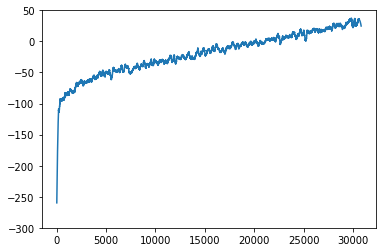

In [24]:
# reward received during training
rpR = np.vstack(episode_reward)
from scipy.signal import savgol_filter
yhat = savgol_filter(rpR[:,2], 361, 2) # window size 51, polynomial order 3
#plt.plot(rpR[:,4])
plt.figure(figsize=(6,4))
plt.plot(yhat)
plt.ylim([-300,50])

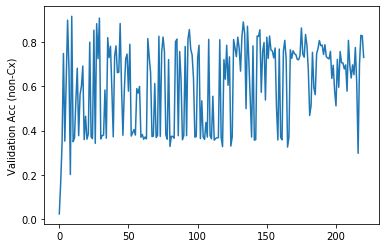

In [25]:
vvr = np.stack(validation_reward)
plt.figure(figsize=(6,4))
plt.plot(vvr[:,1])
plt.ylabel('Validation Acc (non-Cx)')
plt.show()

In [ ]:
# histogram of Q values last 10 episodes
epn = -1
mmat = allEpData
episQ = np.stack(mmat[epn][:,0])[:,]
episY = mmat[epn][:,4]*10+10
episC = mmat[epn][:,5]*10+10
episTau = mmat[epn][:,1]
# print (episY)

plt.figure(figsize=(20,10))
plt.rcParams["figure.figsize"] = (20,10)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(episY, label='GT')
ax1.plot(episTau, label='Tau', color='black')
#ax1.plot(episC+1, label='pi(s)', color='cyan')
ax1.legend(loc='best')

ax2.plot(episQ[:,0], label='A1')
ax2.plot(episQ[:,1], label='A2')
ax2.plot(episQ[:,2], label='A3')
ax2.plot(episQ[:,3], label='A4')
ax2.plot(episQ[:,4], label='A5')
ax2.plot(episQ[:,5], label='Ax')
ax2.set_ylim([-4,5])
ax2.legend(loc='best')

In [19]:
def remove_duplicates(arr): 
    final_list = [] 
    gt_tr = []
    final_list.append(arr[0])     
    for i in range(1,arr.shape[0]): 
        if arr[i] != arr[i-1]:
            final_list.append(arr[i])     
            if arr[i] != num_camera-1:
                gt_tr.append(arr[i])
    return final_list, gt_tr

In [33]:
#policy_net = torch.load('./EpData/policy_db4_3rep_del_rareFreq_ep5k_1201')
policy_net.load_state_dict(torch.load('./models/policy_ECCV_db3_pretrDukeAE256_seq20_rp20K_901')['state_dict'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

Initial position:  [  2   2 200  85  64 136]
Initial position:  [  2   2  17  89  65 146]
Initial position:  [   3 1880  190  106   54  133]
Initial position:  [   1 1448  120   96   27   81]
Initial position:  [   2 2236  219   80   52  133]
Initial position:  [  3 630 114  82  82 156]
Initial position:  [  2  68   1  94  37 131]
Person:  0
Transitions:  [2, 4, 1, 4, 0, 4, 0, 4, 1, 4, 2, 4, 3, 4, 3, 4, 2, 4, 1, 4, 0, 4, 1, 4, 2, 4, 3, 4, 3, 4, 3, 4, 2, 4, 1, 4, 0, 4, 0, 4, 1, 4, 2, 4, 2, 4, 3, 4]
GT transitions:  23
Transitions captured:  19


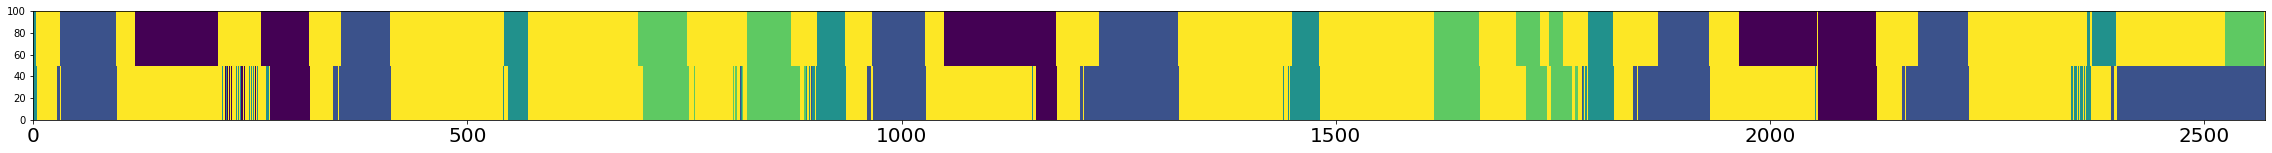

A,P,R:  0.7194552529182879 0.6882793017456359 0.6742671009771987
Num frames:  (1203, 321)
Accuracy:  0.7194552529182879
Person:  1
Transitions:  [2, 4, 1, 4, 0, 4, 0, 4, 0, 4, 1, 4, 2, 4, 3, 4, 3, 4, 3, 4, 2, 4, 2, 4, 1, 4, 0, 4, 0, 4, 0, 4, 1, 4, 2, 4, 3, 4, 3, 4, 2, 4, 1, 4, 0, 4, 0, 4, 0, 4, 1, 4, 2, 4]
GT transitions:  26
Transitions captured:  19


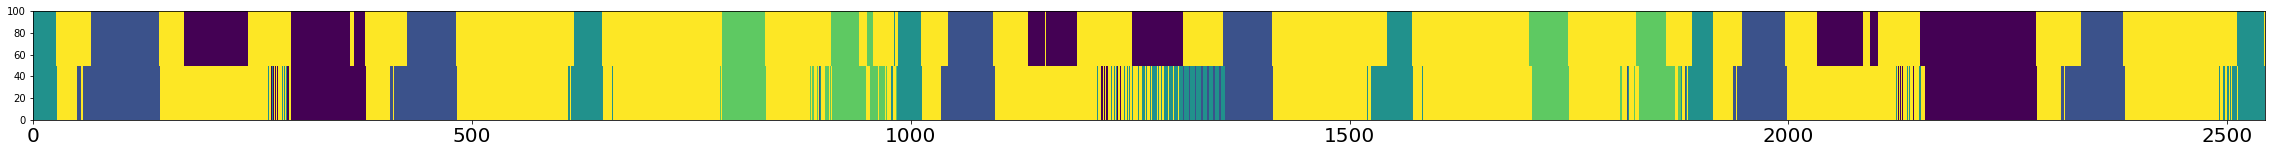

A,P,R:  0.7809673613841919 0.7255892255892256 0.762157382847038
Num frames:  (1188, 288)
Accuracy:  0.7809673613841919
Person:  2
Transitions:  [3, 4, 2, 4, 1, 4, 0, 4, 0, 4, 0, 4, 0, 4, 1, 4, 2, 4, 3, 4, 3, 4, 3, 4, 2, 4, 1, 4, 1, 4, 1, 4, 0, 4, 0, 4, 0, 4, 1, 4]
GT transitions:  19
Transitions captured:  8


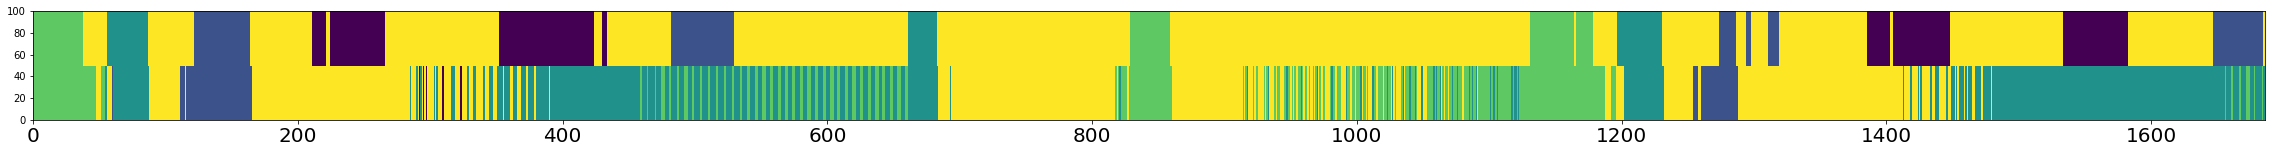

A,P,R:  0.4543297746144721 0.23745173745173745 0.41624365482233505
Num frames:  (1036, 575)
Accuracy:  0.4543297746144721
Person:  3
Transitions:  [1, 4, 2, 4]
GT transitions:  1
Transitions captured:  1


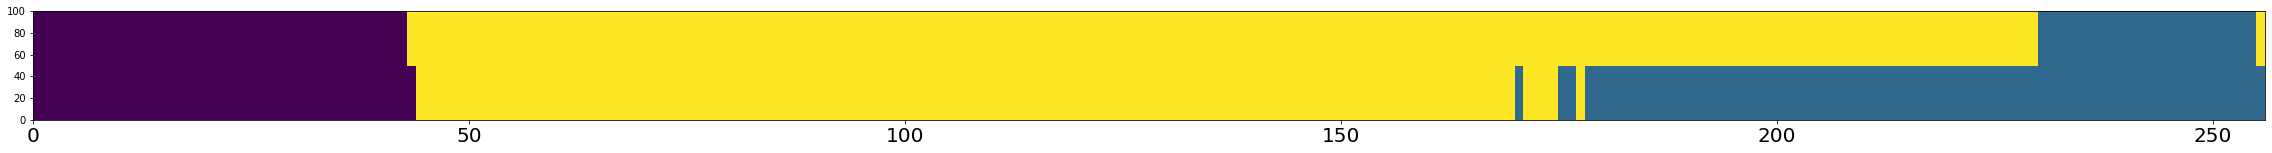

A,P,R:  0.77734375 0.544 1.0
Num frames:  (125, 57)
Accuracy:  0.77734375
Person:  4
Transitions:  [2, 4, 3, 4, 3, 4, 2, 4, 1, 4, 0, 4, 0, 4, 1, 4, 2, 4, 3, 4]
GT transitions:  9
Transitions captured:  8


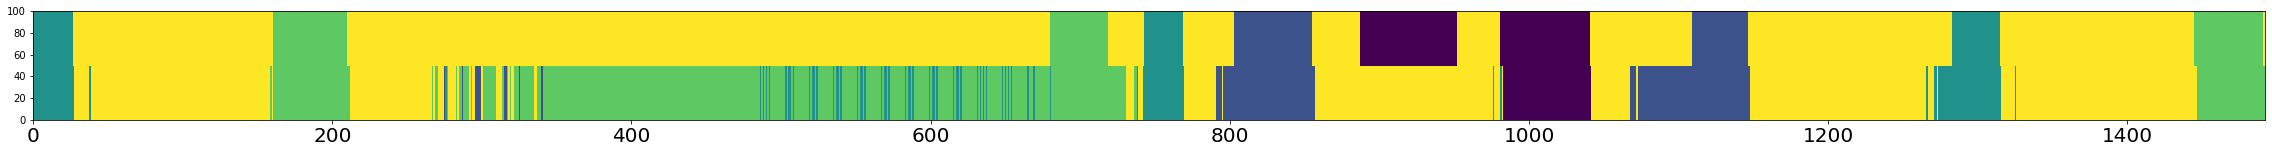

A,P,R:  0.6300268096514745 0.42924528301886794 0.8387096774193549
Num frames:  (848, 482)
Accuracy:  0.6300268096514745
Person:  5
Transitions:  [3, 4, 2, 4]
GT transitions:  1
Transitions captured:  1


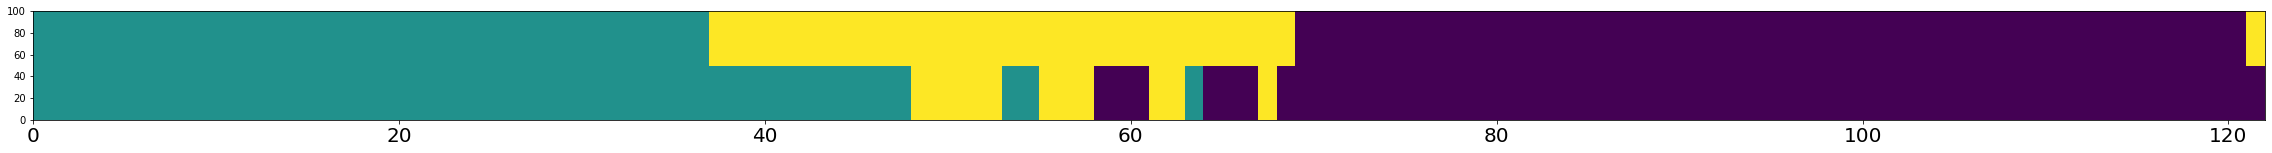

A,P,R:  0.819672131147541 0.8018018018018018 1.0
Num frames:  (111, 22)
Accuracy:  0.819672131147541
Person:  6
Transitions:  [2, 4, 1, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 1, 4, 2, 4, 3, 4, 3, 4, 2, 4, 1, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 1, 4, 2, 4, 3, 4, 3, 4, 2, 4, 1, 4, 0, 4, 0, 4, 0, 4, 1, 4]
GT transitions:  27
Transitions captured:  16


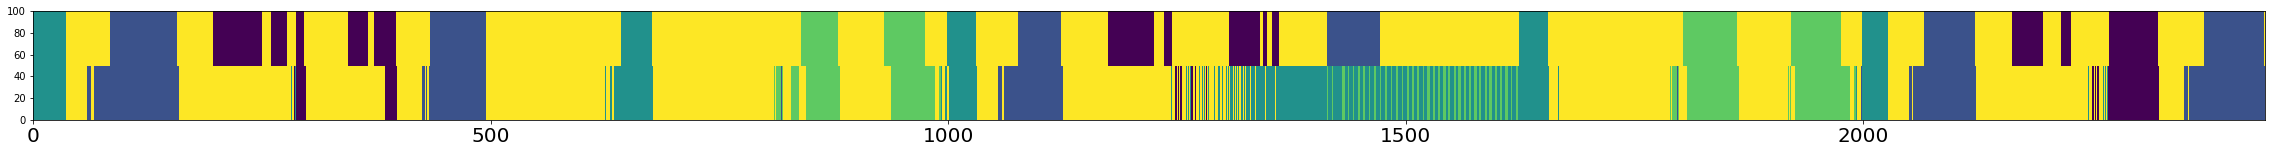

A,P,R:  0.6859368593685937 0.5776699029126213 0.6787072243346007
Num frames:  (1236, 428)
Accuracy:  0.6859368593685937
0.6953902770120803
Average (only transitions) A,P,R 0.6953902770120803 0.5720053217885557 0.767155005771504
Average (all targets) A,P,R,F, ttr 0.6953902770120803 0.5720053217885557 0.767155005771504 368.0 [47, 53, 39, 3, 19, 3, 55]
7920


In [34]:
policy_net.eval()
req_inc = 0
render = False
_,acc,_,numTR = test_func(pTest,iloc='fix',eloc='last', fixLoc=2, isdebug=0, req_inc=req_inc)
tr_acc = 0
avg_tr_captured = []
A,P,R,F, ttr = [],[],[],[],[]
A_onlytr,P_onlytr,R_onlytr = [],[],[]
nfr = []
for i in range(len(acc)):
    print ('Person: ',i)
    gt = np.array([d[0] for d in acc[i]])
    pr = np.array([d[1] for d in acc[i]])
    g = gt #t[gt != num_camera-1]
    p = pr #r[gt != num_camera-1]
    
    dups,gt_tr = remove_duplicates(g)
    print ('Transitions: ', dups)
    print ('GT transitions: ', len(gt_tr))
    print ('Transitions captured: ', numTR[i])
    if len(gt_tr) != 0:
        avg_tr_captured.append((numTR[i],len(gt_tr)))
        contains_tr = 1
    else:
        print ('')
        contains_tr = 0
        #continue
    
    # plot transitions
    afc.plot_color_transitions(p,g)
    # MCTA and number of frames
    if req_inc == 1:
        ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)
    else:
        ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)
        
    if contains_tr == 1:
        A_onlytr.append(ac)
        P_onlytr.append(pr)
        R_onlytr.append(re)
    A.append(ac)
    P.append(pr)
    R.append(re)
    F.append(fr)
    ttr.append(tr)
    print ('A,P,R: ', ac,pr,re)
    f = afc.compute_num_frames(p,g)
    nfr.append(f)
    print ('Num frames: ', f)
    # Accuracy
    tacc = np.sum(g==p, dtype=np.float)/g.shape[0]
    tr_acc += tacc
    print ('Accuracy: ',tacc)
print (tr_acc/len(A))
print ('Average (only transitions) A,P,R', np.mean(A_onlytr),np.mean(P_onlytr),np.mean(R_onlytr))
print ('Average (all targets) A,P,R,F, ttr', np.mean(A),np.mean(P),np.mean(R),np.mean(F), ttr)
print (np.sum(nfr))

In [35]:
a = np.stack(avg_tr_captured)
print (np.mean(a[:,0]/a[:,1]))
print (sum(a[:,0])/sum(a[:,1]))

0.7799129000501999
0.6792452830188679


### Test function

In [ ]:
backup_fname = '/media/win/HRLhkl/Q_CamSel_3L_l4_st200_db3_1tCont_2'
hkl.dump([[episode_reward, running_reward]], backup_fname+'_variables.hkl')

In [1]:
1/np.log(600*12)

NameError: name 'np' is not defined

In [ ]:
pp = 1
np.max(pTest[pp][1:,1] - pTest[pp][0:-1,1])